# Analyze Coral Bleaching with Mosaic + GDAL

> Read multiple NetCDFs using Mosaic and process through several performance-driving data engineering steps before rendering avg coral bleaching worldwide at h3 resolution `3`.

__Notes:__

<p/>

* This notebook was updated for Mosaic [0.3.12](https://github.com/databrickslabs/mosaic/releases/tag/v_0.3.12) on DBR 12.2 LTS
* [GDAL](https://gdal.org/) supported in [Mosaic](https://databrickslabs.github.io/mosaic/index.html)
  * Install this GDAL [init script](https://github.com/databrickslabs/mosaic/blob/main/modules/python/gdal_package/databricks-mosaic-gdal/resources/scripts/mosaic-gdal-3.4.3-filetree-init.sh) (for DBR 12.2) on your cluster, see [[1](https://docs.databricks.com/en/init-scripts/cluster-scoped.html#use-cluster-scoped-init-scripts) | [2](https://databrickslabs.github.io/mosaic/usage/install-gdal.html)] for more.
* Recommend using an auto-scaling 2-8 worker cluster, doesn't need to be a large instance type but should use delta (aka disk) caching, more [here](https://docs.databricks.com/en/optimizations/disk-cache.html).

---  
__Last Update:__ 21 NOV 2023 [Mosaic 0.3.12]

## Setup

In [0]:
%pip install "databricks-mosaic<0.4,>=0.3" --quiet

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
#  - choose option-1 or option-2 below, essential for REPARTITION!
# spark.conf.set("spark.databricks.optimizer.adaptive.enabled", False) # <- option-1: turn off completely for full control
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management

# -- import databricks + spark functions

from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
import os

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




## NetCDF Coral Bleaching Data

> These files were uploaded from [Mosaic Test Resources](https://github.com/databrickslabs/mosaic/tree/main/src/test/resources/binary/netcdf-coral).

__Hint:__ _Can also use [Databricks CLI](https://docs.databricks.com/en/dev-tools/cli/index.html) to move files around, e.g. from your local machine._

_Download data [1x] into Workspace_

> There are a few ways to do this; we will create a folder in our workspace; your path will look something like `/Workspace/Users/<your_email>/<path_to_dir>`. __Note: Spark cannot directly interact with Workspace files, so we will take an additional step after downloading, more [here](https://docs.databricks.com/en/files/workspace-interact.html#read-data-workspace-files).__ Workspace files are newer to Databricks and we want to make sure you get familiar with them.

In [0]:
ws_data = "/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data"

os.environ['WS_DATA'] = ws_data

In [0]:
%sh
# this is just in the workspace initially
mkdir -p $WS_DATA
ls -lh $WS_DATA/..

total 5.5K
drwxrwxrwx 2 root root 4.0K Nov 21 16:31 bak
drwxrwxrwx 2 root root    0 Nov 21 16:31 data
-rwxrwxrwx 1 root root 1.1K Nov  8 12:57 mosaic-gdal-3.4.3-filetree-init.sh
-rwxrwxrwx 1 root root    0 Jan  1  1970 mosaic-gdal-coral-bleaching


In [0]:
%sh 
# download all the nc files used
# - '-nc' means no clobber here
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220101.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220102.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220103.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220104.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220105.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220106.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220107.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220108.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220109.nc
wget -P $WS_DATA -nc https://github.com/databrickslabs/mosaic/raw/main/src/test/resources/binary/netcdf-coral/ct5km_baa-max-7d_v3.1_20220110.nc

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220101.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220102.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220103.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220104.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220105.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/NetCDF_Coral/data/ct5km_baa-max-7d_v3.1_20220106.nc’ already there; not retrieving.

File ‘/Workspace/Users/mjohns@databricks.com/All_Shared/mosaic_raster/

_For simplicity (and since we are running DBR 12.2), we are going to copy from the Workspace folder to DBFS, but this is all shifting with Unity Catalog (more [here](https://docs.databricks.com/en/dbfs/unity-catalog.html))._ __Note: [DBFS](https://docs.databricks.com/en/dbfs/dbfs-root.html), and more recent [Volumes](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#volumes), are FUSE mounted to the cluster nodes, looking like a local path.__

In [0]:
dbfs_data = "/home/mjohns@databricks.com/datasets/netcdf-coral"
dbfs_data_fuse = f"/dbfs{dbfs_data}"
os.environ['DBFS_DATA'] = dbfs_data
os.environ['DBFS_DATA_FUSE'] = dbfs_data_fuse

In [0]:
%sh 
# copy from workspace
# - for spark / distributed work
mkdir -p $DBFS_DATA_FUSE
cp -r $WS_DATA/* $DBFS_DATA_FUSE
ls -lh $DBFS_DATA_FUSE

total 7.0M
-rwxrwxrwx 1 root root 691K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220101.nc
-rwxrwxrwx 1 root root 692K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220102.nc
-rwxrwxrwx 1 root root 701K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220103.nc
-rwxrwxrwx 1 root root 704K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220104.nc
-rwxrwxrwx 1 root root 710K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220105.nc
-rwxrwxrwx 1 root root 714K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220106.nc
-rwxrwxrwx 1 root root 718K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220107.nc
-rwxrwxrwx 1 root root 720K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220108.nc
-rwxrwxrwx 1 root root 722K Nov 21 16:31 ct5km_baa-max-7d_v3.1_20220109.nc
-rwxrwxrwx 1 root root 726K Nov 21  2023 ct5km_baa-max-7d_v3.1_20220110.nc


## Read NetCDFs with Spark

> Uses Mosaic [GDAL readers](https://databrickslabs.github.io/mosaic/api/raster-format-readers.html#raster-format-readers). __Note: starting with Mosaic 0.3.12, the 'tile' column is populated and is used by various `rst_` functions.__

In [0]:
df = (
  spark
    .read.format("gdal")
      .option("driverName", "NetCDF")
    .load(dbfs_data)
)
print(f"count? {df.count():,}")
df.limit(1).show() # <- limiting display for ipynb output only

count? 10
+--------------------+--------------------+------+-------------------+------+------+---------+--------------------+--------------------+----+--------------------+
|                path|    modificationTime|length|               uuid|x_size|y_size|bandCount|            metadata|         subdatasets|srid|                tile|
+--------------------+--------------------+------+-------------------+------+------+---------+--------------------+--------------------+----+--------------------+
|dbfs:/home/mjohns...|1970-01-20 16:23:...|743047|5240782214809708542|   512|   512|        0|{SUBDATASET_1_DES...|{SUBDATASET_1_DES...|   0|{null, �HDF\r\n\...|
+--------------------+--------------------+------+-------------------+------+------+---------+--------------------+--------------------+----+--------------------+



__Let's work with the "bleaching_alert_area" subdataset.__

> We are using `rst_subdataset` which uses the (new) 'tile' column, more [here](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst-getsubdataset).

SubDataset 'tile' output looks something like...

```
{"index_id":null,"raster":"Q0RGAQAAAAAAAAAKAAAAAwAAAANsb24AAAAcIAAAAANsYXQAAAAOEAAAAAR0aW1lAAAAAQAAAAwAAAA7AAAAD2Fja25vd2xlZGdlbWVudAAAAAACAAAAHU5PQUEgQ29yYWwgUmVlZiB
XYXRjaCBQcm9ncmFtAAAAAAAADWNkbV8= (truncated)","parentPath":"dbfs:/home/mjohns@databricks.com/datasets/netcdf-coral/ct5km_baa-max-7d_v3.1_20220110.nc","driver":"netCDF"}
```

In [0]:
df_bleach = (
  df
    .repartition(df.count(), "tile")
    .select(
      mos
        .rst_getsubdataset("tile", F.lit("bleaching_alert_area"))
        .alias("tile")
    )
)
print(f"count? {df_bleach.count():,}")
df_bleach.limit(1).show() # <- `.display()` is prettier in databricks

count? 10
+--------------------+
|                tile|
+--------------------+
|{null, CDF      ...|
+--------------------+



## SubDivide tiles from subdataset column to max of 8MB

> While this is optional for smaller data, we want to demonstrate how you can master tiling at any scale. Let's use [rst_subdivide](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst-subdivide) to ensure we have tiles no larger than 8MB.

SubDivide 'tile' output looks something like...

```
{"index_id":null,"raster":"iUhERg0KGgoAAAAAAAgIAAQAEAAAAAAAAAAAAAAAAAD//////////6WRBAAAAAAA//////////8AAAAAAAAAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAA
AAAAAAAAAAAAAT0hEUgINSAMCIgAAAAAAAwUAAAAAAAAA//////////8= (truncated)","parentPath":"dbfs:/home/mjohns@databricks.com/datasets/netcdf-coral/
ct5km_baa-max-7d_v3.1_20220103.nc","driver":"netCDF"}
```

In [0]:
df_subdivide = (
  df_bleach
    .repartition(df_bleach.count(), "tile") # <- repartition important!
    .select(
      mos
        .rst_subdivide(col("tile"), F.lit(8))
      .alias("tile")
    )
)
print(f"count? {df_subdivide.count():,}")   # <- go from 10 to 40 tiles
df_subdivide.limit(1).show()                # <- `.display()` is prettier in databricks

count? 40
+--------------------+
|                tile|
+--------------------+
|{null, �HDF\r\n\...|
+--------------------+



## ReTile tiles from subdataset to 600x600 pixels

> While this is optional for smaller data, we want to demonstrate how you can master tiling at any scale. Let's use [rst_retile](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst-retile) to ensure we have even data and drive more parallelism.

_ReTile 'tile' output looks something like..._

```
{"index_id":null,"raster":"iUhERg0KGgoAAAAAAAgIAAQAEAAAAAAAAAAAAAAAAAD//////////9t5AQAAAAAA//////////8AAAAAAAAAAGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAT0hEUgINSAMCIgAAAAAAAwUAAAAAAAAA//////////8= (truncated)","parentPath":"dbfs:/home/mjohns@databricks.com/datasets/netcdf-coral/ct5km_baa-max-7d_v3.1_20220102.nc","driver":"netCDF"}
```

In [0]:
df_retile = (
  df_subdivide
    .repartition(df_subdivide.count(), "tile") # <- repartition important!
    .select(
      mos
        .rst_retile(col("tile"), F.lit(600), F.lit(600))
      .alias("tile")
    )
)
print(f"count? {df_retile.count():,}")         # <- go from 40 to 463 tiles
df_retile.limit(1).show()                      # <- `.display()` is prettier in databricks

count? 463
+--------------------+
|                tile|
+--------------------+
|{null, �HDF\r\n\...|
+--------------------+



## Render Raster to H3 Results

> Use [rst_rastertogridavg](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst-rastertogridavg) to tessellate to grid (default is h3) and provide the average measure for the resolution chosen (in this case resolution `3`); also, creates a temp view & renders with Kepler.gl.

Initial structure of a single `grid_avg` row looks something like...

```
[
  [
    {"cellID":"592144529759404031","measure":0},{"cellID":"592849935188099071","measure":0.8013245033112583},{"cellID":"592834816903217151","measure":0},  {"cellID":"592823203311648767","measure":0.9726027397260274},{"cellID":"592323818874208255","measure":0.028328611898016998},  
    {"cellID":"592306295407640575","measure":1.8468899521531101},{"cellID":"592143224089346047","measure":1},{"cellID":"592851447016587263","measure":0.9979123173277662},  
    {"cellID":"592849316712808447","measure":0.4621676891615542},{"cellID":"592136833178009599","measure":0.06970509383378017},  
    {"cellID":"592314885342232575","measure":0},  {"cellID":"592832274282577919","measure":0},{"cellID":"592831861965717503","measure":0}  
    ... (truncated)
  ]
]
```

Data ultimately looks something like...

| h3 | measure |
| --- | ------- |
| 593176490141548543 | 0 |
| 593386771740360703 | 2.0113207547169814 |
| 593308294097928191 | 0 |
| 593825202001936383 | 0.015432098765432098 |
| 593163914477305855 | 2.008650519031142 |

__Hint: zoom back out once rendered; also, verify the `.contains()` string is actually in the data. Also, this can take a few minutes to run, recommend a few nodes (min. 3 to say 8) in your cluster to speed up processing__

In [0]:
# here is the initial structure
# - notice the array nesting, which we will handle
#   by exploding 2x
# display (
#   df_retile
#     .limit(5)
#     .select(
#      mos.rst_rastertogridavg("tile", F.lit(3))
#      .alias("grid_avg")
#     )
# )

_Prepare a View for rendering with Kepler + other analysis._

> This generates 241,486 rows (row per cellid at h3 resolution `3`).

In [0]:
# create view "to_display"
# - you could also write to Delta Lake 
#   at any point to avoid recomputing
(
    df_retile
    .repartition(df_retile.count(), "tile")
        .select(mos.rst_rastertogridavg("tile", F.lit(3)).alias("grid_avg"))
    .select(F.explode(col("grid_avg")).alias("grid_avg")) # <- explode-1 of 2d array
    .select(F.explode(col("grid_avg")).alias("grid_avg")) # <- explode-2 of 2d array
    .select(
        F.col("grid_avg").getItem("cellID").alias("h3"),      # <- h3 cellid
        F.col("grid_avg").getItem("measure").alias("measure") # <- coral bleaching
    )
    .createOrReplaceTempView("to_display")
)

# optional: can work with the view in sql
# - you would probably want to write to delta lake 
#   to avoid recompute
# print(f"""count? {spark.table("to_display").count():,}""")

count? 241486


In [0]:
%sql
-- optional: can work with the view in sql
-- you would probably want to write to delta lake 
-- to avoid recompute
-- select * from to_display

_Render with Kepler.gl via Mosaic magic._

> Hint: zoom out within the map viewport to see all available data rendered.


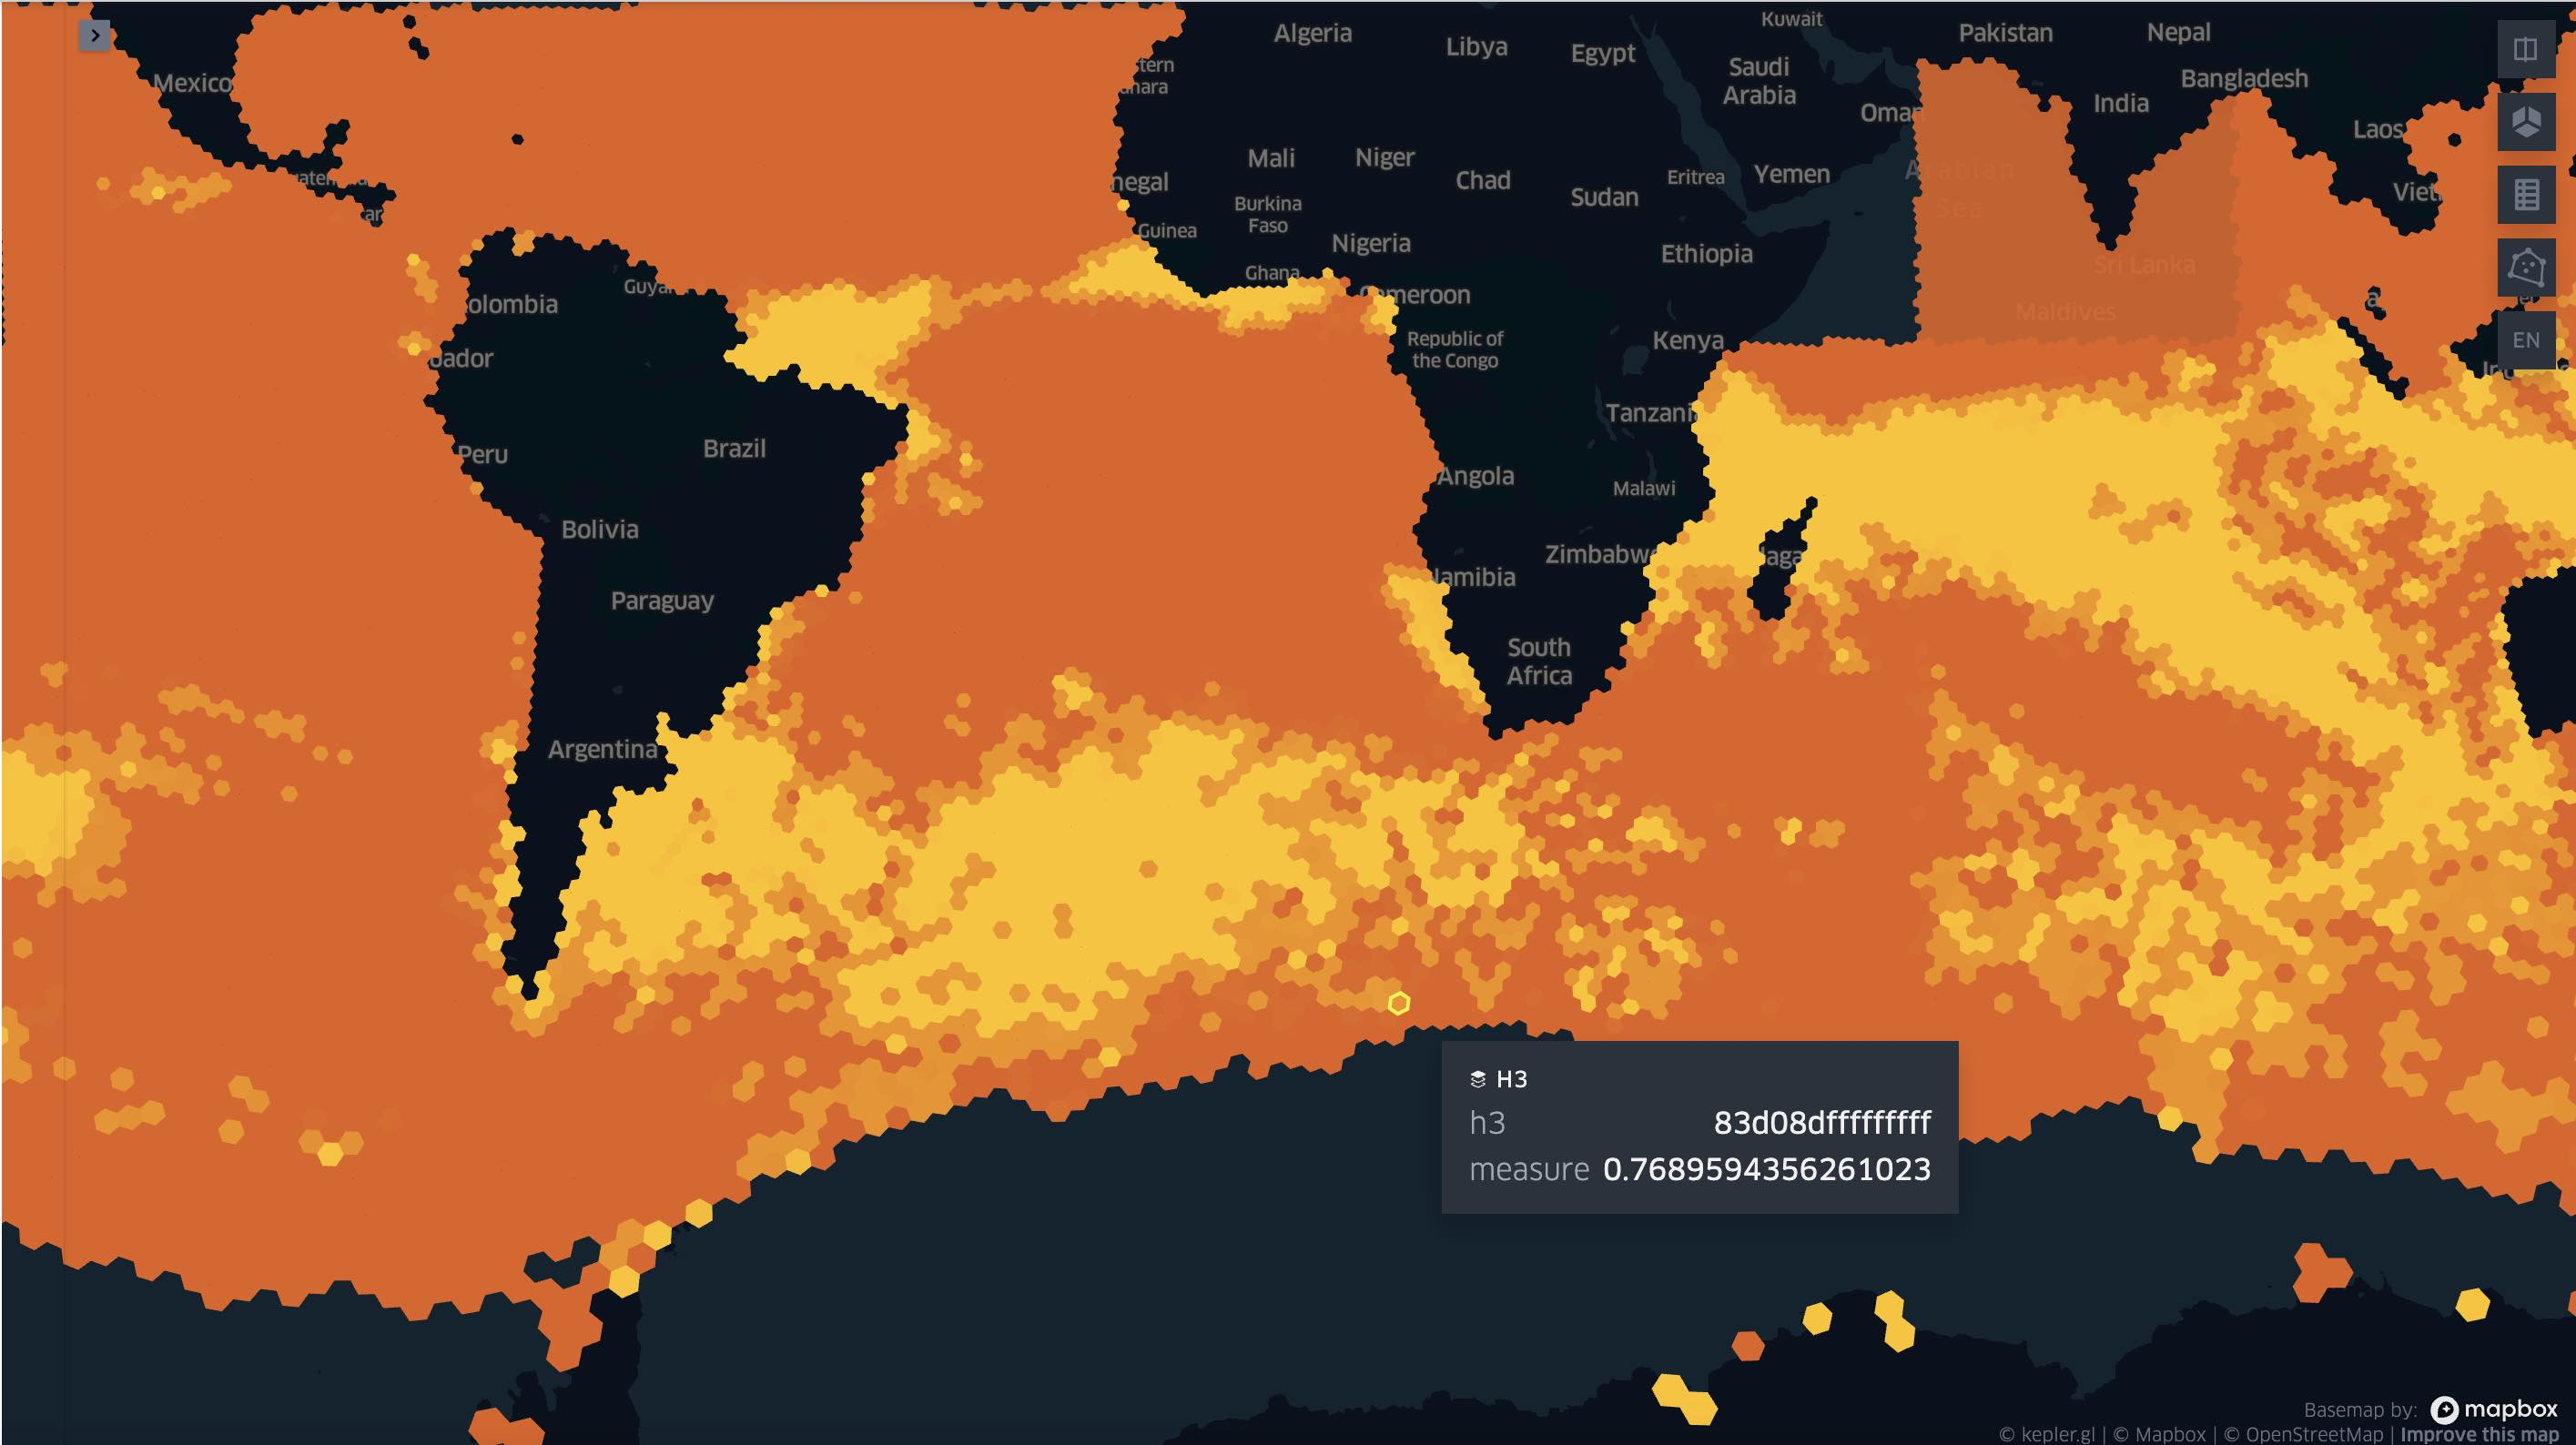

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACw6gAwAEAAAAAQAABjSkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wAKAAUACQAbABBhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/qAZhBUk9UAAAAAABjIiAAAJEoAAA1MwAArDsAAO1EAAAmTwAAolkAAPJiAAAIawAA/HIAAC99AADfiAAA05UAAFChAABRqQAAwbEAAAe8AACVxQAAbs4AAFPbAADk6QAABvQAADL9AAAJDAEAYxYBAFAiAQA8LQEA7TcBAEhCAQDMSQEAqFEBAJBZAQBDYQEAHGoBAHpyAQDcewEAdYUBAIePAQBqmgEAYKUBAECxAQCZvAEANcYBAK3OAQCv1wEAveABADbqAQCt8wEAKP0BAF4JAgA7FgIAuSICALguAgB2OgIAKkcCALJSAgCVXwIAfGoCAC92AgDggQIAqo0CAJKZAgA+pQIAcLECACe+AgC8ygIAa9cCAF/iAgB57QIA/vYCALEAAwAYCgMAdhEDAOYaAwDsIwMAMCsDAGc5AwDrRQMA3UwDAHhZAwAbagMAE3IDAOx2AwDYfAMAf4EDAHCHAwCQjQMAlJMDAAqcAwBDpQMAKKwDAJCxAwC6tgMA5roDAES/AwD7wwMAY84DAG3XAwAg5gMA/8AAEQgGNAsOAwEiAAIRAQMRAf/EAB8AAAEFAQEBAQEBAAAAAAAAAAABAgMEBQYHCAkKC//EALUQAAIBAwMCBAMFBQQEAAABfQECAwAEEQUSITFBBhNRYQcicRQygZGhCCNCscEVUtHwJDNicoIJChYXGBkaJSYnKCkqNDU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6g4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2drh4uPk5ebn6Onq8fLz9PX29/j5+v/EAB8BAAMBAQEBAQEBAQEAAAAAAAABAgMEBQYHCAkKC//EALURAAIBAgQEAwQHBQQEAAECdwABAgMRBAUhMQYSQVEHYXETIjKBCBRCkaGxwQkjM1LwFWJy0QoWJDThJfEXGBkaJicoKSo1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoKDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uLj5OXm5+jp6vLz9PX29/j5+v/bAEMABwcHBwcHDAcHDBEMDAwRFxEREREXHRcXFxcXHSMdHR0dHR0jIyMjIyMjIyoqKioqKjExMTExNzc3Nzc3Nzc3N//bAEMBCAkJDg0OGA0NGDknICc5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5OTk5Of/dAAQAsf/aAAwDAQACEQMRAD8A6fXtU1Ox1aa1t5dkabcDap6qD1Iz1NZH9vaz/wA9/wDx1f8ACtPxaoHiC5H+5/6Atc5tFfP1q81OSUnuz6qhhqbpxbitl0MzW/Eni+2dJbG5YxtwVEUbEH/vk8GsiHxX4+nkVFmkAY43GBAB7k7K6raKNoraGYyjHlauc9TKoSnzJ2XYvLrutBQDcZIHJ2Jz/wCO1Dda74ga3cW1zslx8p2IefxXvVfaKNorlWJqJ35jseDpNW5UcrJ4m+IoHySvnP8Azyi/+Jro9H17xWbXzdTuSZGPCmOMbQOOyjr1qfaKNoroqY+c1ZKxzUsspwlzPX1Lza/rQGRP/wCOJ/hXNal4i8bxXJ+w3DPEwBGI4jj1HK1quo20oUYrOljJwd739TStgKdRctrehi2HiHx3NdIt1cMkQ5YmKIcDt93vXV/29rP/AD3/APHV/wAKz9oo2iirjZzd9vQKOX06as1f1ItZ8Q+JIrCS4s7vy3iG77kZBA69VPbpXnv/AAsbxj/z/f8AkKL/AOIqz4z1Nk2aXCcbhvkx6dh/X8q8+r2cEpunzT6nhZhyKry01sdx/wALG8Y/8/3/AJCi/wDiKP8AhY3jH/n+/wDIUX/xFcPRXbZHBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyFc7j/hY3jH/n+/8hRf/EUf8LG8Y/8AP9/5Ci/+Irh6KLIdzuP+FjeMf+f7/wAhRf8AxFH/AAsbxj/z/f8AkKL/AOIrh6KLILncf8LG8Y/8/wB/5Ci/+Io/4WN4x/5/v/IUX/xFcPRRZBc7j/hY3jH/AJ/v/IUX/wARR/wsbxj/AM/3/kKL/wCIrh6KLILncf8ACxvGP/P9/wCQov8A4ij/AIWN4x/5/v8AyFF/8RXD0UWQXO4/4WN4x/5/v/IUX/xFH/CxvGP/AD/f+Qov/iK4eiiyC53H/CxvGP8Az/f+Qov/AIij/hY3jH/n+/8AIUX/AMRXD0UWQXO4/wCFjeMf+f7/AMhRf/EUf8LG8Y/8/wB/5Ci/+Irh6KLILncf8LG8Y/8AP9/5Ci/+Io/4WN4x/wCf7/yFF/8AEVw9ByOtFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iKyfD2hNq85klytvGfmI6k+g/rXWz+CtOfJgkkjPpkMP5Z/WuOri6VOXJI7aWBrVIc8VoM03xf4+1Uv9lvRhOrNHEBn0+51qS88UfEaxjM09z8i9WWOEgfkua6WxsYNPtUtbcYVB17k9yfc1NNAk8LwSfdkUqfoRg15zzJ8+i0PUjlMeTV+8eef8LG8Y/8/wB/5Ci/+Io/4WN4x/5/v/IUX/xFcleWNzZTPDPGy7SRkjAODjI9jW54c0FtUm8+5Ui2Tr23H0H9TXsTqQjDnex4lOjOc/Zpamj/AMLG8Y/8/wB/5Ci/+IrS0/xh4/1PebS7yE6kxxAZ9Pudamn8FabIcwSSRe2Qw/UZ/Wums7K3sbdba3XaiD8T7n3NedVzGCj+7Wp6dHKpuX73Y5tfEvxIM6QPOy7jjd5URUe5IUiu5i1zXEjVJLoyMByxRBk+uAuKp7RRtFcFXHTna2noelRy6nTvfX1MTxL4s8U6akU9peFUYlWBjjPPUdU+tcoPiL4yIJF9wP8AplF/8RXdahp8Go2zWs+QpIOR1BFck3gxg6iOdTGT82Vwcd8dQa78LjYclqr1PNxmX1Ofmox0II/HnjqWMzRXTsinBYQxkDv12VPYeNvHOo3QtYL35jyxMUXygdSfkrsbWzgsoFtrddqIMAVMIowxcKAx6nHNZSzPe0fQ2jlGzlL1Gzan4pZAINUdWA5LQwkE/TYK4jUPHPjXT7uS0kv8lD18qLkEZB+5Xd7RXE+JvD15qFyt3YqGOzaykgEkHjrx+tLCYxufLVehWNwEVDmpR1M7/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiKzdL8MX91eiK9ieGJOXYjGfZfUmu5uPCujTrgRGI4xlCQf1yP0ruq42lTkovX0POo5fWqRclp6mLY+NvHmoymG0u97AZP7uIAD6lKlfxd8RI5lgkmcM5AH7mLBJ9wmK6bTtMtdLtxb2w92Y9WPqav7RXFPMvefLHQ74ZQnFc0tRYtW8S/ZVjn1BjL1Z1jiHPoAUxj9afa6x4ki3fab8zZ6fuo1x+S1HtFG0VxPF1NdT0FgaKs+XY0P7e1n/nv/46v+FedT+O/F8E7wte8oxU/u4uxx/drtdorGvfD+nXzGV1KSMcllPU/jxXRhcbyN+11Ry4zL+eK9ikmjGt/Gvje7YrbXRcqMnEUXT/AL5pB428bmcWv2lvNJwFMUYP/oFdLp+m2+mweTAOTyzHqx96umNSQSASOntW8szXM+WOhzwyhuK5pa9SqdU8ZGBSupAS/wAQMUe38PkzVrT9a8UohbULze56KEjAA+oUUu0UbRXFLG1WrXO+OXUU1KwzV/EfiGCwkntrrY6YP3EPGeeqmuI/4WB4u/5/f/IUX/xNdrPbpcQPbyfdkUqcdeRjiuKl8HzCcCGZTETyWHzAfyNd2DxkVFqqzzsfgJuSlRjoH/CwPF3/AD+/+Qov/iaB4/8AF7EAXuSeg8qP/wCIrqBoum/ZVtGhVkX1659cjnJptnomn2LmSCP5j3Y5I9hVvMqdn7pmsoq3XvKxzTePvGCMVe8II6gxRg/+gVJD448a3BIgumfaMnbDGcD/AL4rqrvT7O9Xbcxq/GAe4+h61LBaW9qnl26BF9AKh5nHl0jqaLJ5c2s9Diz8QPFwODe/+Qov/iKsr4z8cvCbhbhzGP4hDHj/ANArpJtLsLiUTzQqzqc5x/P1/GroRVAVRgDoKUszVlyxHDJ3d80zhR4/8XsQBe5J6Dyo/wD4irU/jLx1aor3FwyK3QmGP/4jiuoSxtI5jcRxIsjdWAGanaNHUo4DA9QeRQ8zV1aOg45O7PmnqcVD468aXEgigui7HssUZ/8AZKWfxz40tpDDPdlHHYxRf/E110FpbWqlLeNYwTk7RjNE9pbXS7LiNZAOm4Zx9KP7TXN8Ogv7HfL8ev4HKQ+NfHFwrPBcO4XklYYz/wCyVXPxA8XA4N7/AOQov/iK7lY0RdqAADsOKqyadYyzC4khRnH8RAojmau7xCWTuy5Z6nLN438bJEJ3uWEbdGMMeD+OyoR4/wDF7EAXuSeg8qP/AOIruWjR1KOAwPUHkVTttMsLRzLbwqjN3HX8M9PwpxzONneOoSyeV1yz0OUfx74xjO2S7Kn0MUY/9kpB4+8YMcLeZPtFH/8AEV193YWl6nl3MYcdj3H0PWktdPs7JcW0apngnufqetP+04cvw6k/2PPm+PQ5D/hYHi7/AJ/f/IUX/wATR/wsDxd/z+/+Qov/AImugufDumXUwnZCh7hDgH6j/DFWzpOnGA23kIIzyQBjn1z1q3mVOytEhZRVu7yRyn/CwPF3/P7/AOQov/ia7LSfEHiS4tI7q5vWLOM7fLiAxnj+DPT3rlv+EPiMzHzyIs/KMfNj3P8A9ausgt0t4Ugj+7GoUZ9BxWWLxsXFKkzXBZdNSbrrQz9a8R+MLNhPaXZaJuCvlRkqf++c4o0jxH40muN1/OyxBSfmjjXJ7fw5rV2ijaK5vr8+Tk69zs/syn7Tn6djQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNorm+sVP5mdf1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/wDjq/4Uf29rP/Pf/wAdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/8Ajq/4Uf29rP8Az3/8dX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/wDjq/4Uf29rP/Pf/wAdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/8Ajq/4Uf29rP8Az3/8dX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/wDjq/4Uf29rP/Pf/wAdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/8Ajq/4Uf29rP8Az3/8dX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/wDjq/4Uf29rP/Pf/wAdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/8Ajq/4Uf29rP8Az3/8dX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIUf29rP/Pf/AMdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/wDjq/4Uf29rP/Pf/wAdX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/8Ajq/4Uf29rP8Az3/8dX/Cs/aKNoo+sVP5mH1Sl/KvuND+3tZ/57/+Or/hR/b2s/8APf8A8dX/AArP2ijaKPrFT+Zh9Upfyr7jQ/t7Wf8Anv8A+Or/AIVQ1PxB4kWyd7K4xIo3D5EOQOo5X0pNoo2iqjiqiadyJ4OlKLXKvuOHbx74xT712R9Yo/8A4ius0TxH4puLc3V9dEh/uL5cY49eF79qubRRtFdVXMXOPLFWOOhlUYS5pSuaH9vaz/z3/wDHV/wrgL7xt4wsrqS2a9PyngmKPkdj9yuv2iqF1pOn3r+ZcxBmxjOSD+hFThsa4SftNUXi8vVSK9lZM5eLx34ymkWKK8LMxwAIouv/AHzXaLqnigxLv1JxJjnEURGf++KzbTQ9PsZ/tFuhDYI5JPX61q7RV4jHuTXstEZYXLFFP22rOe1fxT4w0tkI1Aur558mIYI7fdrG/wCFgeLv+f3/AMhRf/E11WqacmpWbWzHaeqt6Ef5xXGP4R1FfuSRN+JH9K7MNjYSh+8epw4zL6kZ3oq6NK18aeN71ylrdFyoycRxdPxWp/8AhK/iAGCmWQZOM+THj89lbOl6ZHplqIFO5jy7ep/wrR2iuepmVpNQjodVPKLxTnJ3LNtrmvxwqtxdeZJj5m2IOfbCimXuveIfskhtbjEoXK/Ih5HblT1qHaKNorg+tVL81z0ngqXLy8qOF/4WB4u/5/f/ACFF/wDE1csPGXjTULgW8N77sfKiwB6/drTm8N6TMSxjKs3JKsf65FXNP0u102IxWwPzHJLck/8A6q9OeZQ5fcWp49PKanOvaPQJNU8cD/Vamjf70Ua/yQ1qWWt+I44ALy78yU8khEAHsMKKi2ijaK8+WNqyVmz1IZfRi7pGh/b2s/8APf8A8dX/AArg9S8a+LrK9kt/thCqcrmKLoeR/DXWbRUE1na3H+viR/8AeUGrw+NcJXnqiMTl8akbU7JnJW3jjxpdzLbwXm526fuov/iK69tT8VlBs1Qhsc5hiIz/AN8ioLbTbKzdpLaIIz8Ej/PH4Vc2itK2YSk/3eiMsPlcYxftdWOs9Y8TRBjeX3nE9MRxqAPwXrV7+3tZ/wCe/wD46v8AhWftFG0VyyxVRu/MdkcFSirKKMHXvF/irT7pRBebY3XIHlxnBHB6rWIvj7xgzBVvMk8ACKPn/wAcrtZbeCddsyK49GAP86pRaPp0E4uYYVVxnBHTn26V30sxjGFpK7PNrZVKU+aErIkj1Xxm9urvqWyQjJXyYiB7Z21JZav4yWctfXytGOgWOPn/AMcGKs7RRtFcjx1Vpq52rLaKadtjQ/t7Wf8Anv8A+Or/AIVyniDxf4o0+eM293tjkXp5cZ5HXqvuK29oqpeafaX6CO6TeAcjkjB/CnQxkoTTm20LE4GM6bjTSTOFb4ieM1ODff8AkKL/AOIpv/CxvGP/AD/f+Qov/iKd4i8N21jZtf2rOdrKGViCADxxxnriuFr3qNWFWPNA+br0Z0Zck9zuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHorayMbncf8LG8Y/wDP9/5Ci/8AiKP+FjeMf+f7/wAhRf8AxFcPRRZBc7j/AIWN4x/5/v8AyFF/8RR/wsbxj/z/AH/kKL/4iuHoosgudx/wsbxj/wA/3/kKL/4ij/hY3jH/AJ/v/IUX/wARXD0UWQXO4/4WN4x/5/v/ACFF/wDEUf8ACxvGP/P9/wCQov8A4iuHoosgudx/wsbxj/z/AH/kKL/4ij/hY3jH/n+/8hRf/EVw9FFkFzuP+FjeMf8An+/8hRf/ABFH/CxvGP8Az/f+Qov/AIiuHoosgudx/wALG8Y/8/3/AJCi/wDiKP8AhY3jH/n+/wDIUX/xFcPRRZBc7j/hY3jH/n+/8hRf/EUf8LG8Y/8AP9/5Ci/+Irh6KLILncf8LG8Y/wDP9/5Ci/8AiKP+FjeMf+f7/wAhRf8AxFcPRRZBc7j/AIWN4x/5/v8AyFF/8RR/wsbxj/z/AH/kKL/4iuHoosgudx/wsbxj/wA/3/kKL/4ij/hY3jH/AJ/v/IUX/wARXD0UWQXO4/4WN4x/5/v/ACFF/wDEUf8ACxvGP/P9/wCQov8A4iuHoosgudx/wsbxj/z/AH/kKL/4ij/hY3jH/n+/8hRf/EVw9FFkFzuP+FjeMf8An+/8hRf/ABFH/CxvGP8Az/f+Qov/AIiuHoosgudx/wALG8Y/8/3/AJCi/wDiKP8AhY3jH/n+/wDIUX/xFcPRRZBc7j/hY3jH/n+/8hRf/EUf8LG8Y/8AP9/5Ci/+Irh6KLILncf8LG8Y/wDP9/5Ci/8AiKP+FjeMf+f7/wAhRf8AxFcPRRZBc7j/AIWN4x/5/v8AyFF/8RR/wsbxj/z/AH/kKL/4iuHoosgudwPiN4x/5/v/ACFF/wDEVYT4ieLX/wCX3B/65xf/ABFef0ZxyKLIR6L/AMLA8Xf8/v8A5Ci/+JqCT4jeLV+Vb3n/AK5Rf/EVwvnSetR0WQlc7j/hY3jH/n+/8hRf/EUf8LG8Y/8AP9/5Ci/+Irh6KLIq53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9KBk4osgudv/wALG8Y/8/3/AJCi/wDiKP8AhY3jH/n+/wDIUX/xFcvd6dPZ+WJsZkXcuDng0t5ps9iqGfALjcFzk496nQep0/8Awsbxj/z/AH/kKL/4ij/hY3jH/n+/8hRf/EVxGD6UbT6U7IWp2/8Awsbxj/z/AH/kKL/4ij/hY3jH/n+/8hRf/EVxGD6U4Rse1FkGp2v/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVyiW8ckipuCAkAk9B7mrC6Y81y9vbssmwFtwPBA70aArnR/8ACxvGP/P9/wCQov8A4ij/AIWN4x/5/v8AyFF/8RXEMMGkp2QXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZBc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eiiyC53H/CxvGP/P8Af+Qov/iKP+FjeMf+f7/yFF/8RXD0UWQXO4/4WN4x/wCf7/yFF/8AEUf8LG8Y/wDP9/5Ci/8AiK4eiiyC53H/AAsbxj/z/f8AkKL/AOIo/wCFjeMf+f7/AMhRf/EVw9FFkFzuP+FjeMf+f7/yFF/8RR/wsbxj/wA/3/kKL/4iuHoosgudx/wsbxj/AM/3/kKL/wCIo/4WN4x/5/v/ACFF/wDEVw9FFkFzuP8AhY3jH/n+/wDIUX/xFH/CxvGP/P8Af+Qov/iK4eiiyC53H/CxvGP/AD/f+Qov/iKP+FjeMf8An+/8hRf/ABFcPRRZCudx/wALG8Y/8/3/AJCi/wDiKP8AhY3jH/n+/wDIUX/xFcPRRZDudx/wsbxj/wA/3/kKL/4ij/hY3jH/AJ/v/IUX/wARXD0UWQXO4/4WN4x/5/v/ACFF/wDEUf8ACxvGP/P9/wCQov8A4iuHoosgudx/wsbxj/z/AH/kKL/4ij/hY3jH/n+/8hRf/EVw9FFkJs7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4fNGaVkTzM7j/hY3jH/AJ/v/IUX/wARR/wsbxj/AM/3/kKL/wCIrh80UWQ0zuP+FjeMf+f7/wAhRf8AxFH/AAsbxj/z/f8AkKL/AOIrh6KdkVc7j/hY3jH/AJ/v/IUX/wARR/wsbxj/AM/3/kKL/wCIrh6KLILncf8ACxvGP/P9/wCQov8A4ij/AIWN4x/5/v8AyFF/8RXD0UWQXO4/4WN4x/5/v/IUX/xFH/CxvGP/AD/f+Qov/iK4eiiyFc7j/hY3jH/n+/8AIUX/AMRR/wALG8Y/8/3/AJCi/wDiK4eilZC5juP+FjeMf+f7/wAhRf8AxFH/AAsbxj/z/f8AkKL/AOIrh80UWQKR3H/CxvGP/P8Af+Qov/iKevxC8Zv0vv8AyFF/8RXEwQS3MqwQKXdzgAd69O07wlZwWoW+/eSnkkEgD2Hr9a56+Ip0vjOvD4WpWvyH/9DpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxASAMmovOWll+7VOvTwWEhWi3I8nMMbOhJKFtTE8TaYdVtke2AM8R4zxlT1Gf1riP+EZ1n/nkP8Avpf8a9Sor3KNFU48kXofPV67qz55LU8t/wCEZ1n/AJ5D/vpf8aw5I3ikaKQYZCVI9COte3V5Fq1vcR39zLJGyo0z4YggHLE8GtHZGKTMuiiikS2FFFFMoKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOl8M6OuqXhknwYYMFx3YnoPpxzXrDwQSII5I1ZRwFIBH5V5T4TvWtdWWLGVnGw+x6g163Xz2ZOXtdXp0Pp8qUHRdlr1I4YYbdBFAixoOiqAB+QqSiivMbueslbRBRRRQMCARg9KaiJGoRAFA7DgU6igAooooAKKKKACiiigAooooAKKKKACiiigArhvFutz2p/sy2BQuu539jxgf1NdzXEeL9Jur0w3VnGZGUFHC9cZyOOp7114Pk9qufY4sfz+xfs9zirHWtSsGXyJn2A8oTkH14OQK9qR1kQOhyGGR9DXidjpF9f3gs0jKMOWLAjaPU17Pa24tbWK2BLCJAgJ77RiuzMlC8eXc4cpdS0ubYnxzmiiivIPbCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAMDxLeW1rpUqXHJmUoijqWI6/QdTXjldF4pNx/bMyzuWAxsz0CkZwK52vp8DRVOmnffU+RzCu6lVq1raBRRRXaeeFFFFABRRRQAUUUUAFFFFABRRW3oenrqF4I5c+WoLMR6D/69Juw0YlLg10euabb2scNzZ5MUq5GTnn/9VTaHaW1xY3kkyBmjTKk9jg0ubQLHK0VfttPur1yLaMvjrjt+NWZNC1OMnfC2ACSeCMD3o5kFjHorStdJvrxd1vEzL69B+ZqOXT7uGcW0sZV24APfPpT5kFijS4PWtSPRdRkdo0hYlPve341cKY0jP2XkN/r8+/T+lJyCxz1Fa1vouo3SCWGIlT0PAB/Oql1ZXNk/l3KFD707oLFSiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyEBgW5FNooAnnHzBh3qCrke2SLae1VCMHBoEhKXBxmkqWQbQq98ZP40DIqKKKACiiigAooooAKKKKACiiigAooooAKcv3hTacvBoYHpjW9lNd2TXD/vViBSMjhse9c5byXFx4jX7YPm3kFT0AAPH0qlqGrLdSW8sAKNAgXOe471Pda1FNdQahHHtnjxv54bFZWLLmlojeIpUZQV3ScEcd6TyFvtNgCgb47jy2PfDUn9uabDLJeW1uVuJAeS3ygnqapaTrEdisqzKXDkMMHGGHeiwHQTW8N5qNrNEqhEd0YAcfuzkZrOtHu5Li6urURKm/l5AMKOwFU7DW1tLaWJ1LO5ZlbPQsMU2wv7eK0ks7qMyRSEN8pwQRRZhc3buJJG0+5kEZkeUKzR/dYZqW0lMeq30ChdoVmHHcAD8qxpNVg220cMJRLeTeBnOR/jTYtVWPU5b0xkxzAqVzzg0rMLmJfTSXL+fJgE8fKMD8qoVq3QgkdvsyskZ6Bjk1lkEHB61qtiLiUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAopR1rtbTT9ITSI9QvkY5JBKk+pA4qW7DSOJortv7K0jUraWXSy6yRjO1u/5+tYFrol/ep5tvHlD0JIA/WhSCxkUpBHWtG4027sJVW6Qrnp3B/EVr+JbWC2uIkt0CApk49c0cwWOXoII61qnTrq0aKWeLiQjapI+b2qxq8Usl4sQthbswGEXnPvxRzBYwaK3W8O6qsfmmE4Az1GfyzWlY6A82mSTuhMrAGIZ6j1o5kFjkKK1U0a/kuHtkjJkTG4ZHGffpT7vQ9Rs4/NmjIUdSCCB9cUcyCxj0VqQ6Pf3CJJDEWV84Ix2ovNHvrFQ9xGQp78EfpT5kFjLooopiCiiigAooooAKKKKACiiigAooooAKXBpV+8K7690O3n0qOW0QLMEDED+LjmpbsCRwGCelJXUeHLO3uZ5UuUDhYyQD65rJtNOudQnMVsu4jk9gB7mjmHYzaK6C78O31pCZ2Cuq9dhzimW/h++uoo54QCkmcHPTHrRzILGFRW7f6Be2EXnSAMncqc4+tFjoN3fQieMqqEkZY46UcyCxh9aUqRya1r/AEe700q04G1ujKcitbxPHHGlr5ahcx84GPSjmCxyNFFFUIKKKKACiiigAooooAKKKKACiiigTYUUUUAmFFFFAwooooAKKKKACiiigAooopEbBRRRTLCiiigAooooAKKKKRAUUUUCCiiigqIUUUUygq19juf7v6j/ABqrXTUAYX2O5/ufqKPsdz/c/UVu0UgML7Hc/wBz9RR9juf7n6it2igDC+x3P9z9RR9juf7n6it2igVjD+x3P939R/jVWumrmaAsXNOufsd9Bddo3Vj9M8/pXssWr6XMu6O5iI92AP5HmvDqK48ThI1mm3Y9DCY6VBOKV7n/0em8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTERzfdqnVyb7tU697KvgkfOZx8cfQzdVsDqVmbdJGicEMrKSMMOmcdqytE1qaedtJ1IYu4cgsOQ+O/HQ1qav8A2kbMppQXzWIGScYB6ke9RaPo8OkwkA75n5kkPUn/AAr1ep4psUy9sY9SsJLSXo44PoRyDT6ztb1U6Vpxkj/1snyJ7E9/wrzsepPkUN7nq5bKK9o57WPJJongmeCQYZCVI9xUVKSWJZjknkk0ld68zx3voFFFFUNBRRRQUFFFFABRRRQAUUUUAFFFFABRRRQBLDDLcSrBCpZ3OFA7k11EngzV0XcrROcdAxz+oA/WrvgiO0a5nd+Z1UbM9lPUj36D/wDXXpFePi8bOnU5IdD3MFl8KtPnm9zk/DXh9tMVrq7A+0PkAcEKv19TXWUUV49WrKpJzke7RoxpRUIbBRRRWZqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFeV+JdeuLu7a0ty0cUD44yGLDgk9xg9B/kW/DOvX8moR2N3MZI5AQN+CQcZHzde2O9eg8BNU/aX+R5izKm6vsreVz0miiivPPTCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAorH1jWrbR4Q8vzyN9yMHBPv7D3rGt/GumycTpJEfoGH6c/pW8MNUlHmjHQ5p4qlCXJKVmdc8kcZAkYLu4GTjNOZlRS7kBQMkngACvFtZ1i41e5MsnyxrkRp2A/xPes8Xd2ITbiZ/KPBTcdv5dK9COVyaTctTzJZvFSaUbo1vEOqQ6rf+fAm1EXYGPVgCeSPx4rBoor2oQUIqMeh4NSo5yc5bsKKKKszCiiigAooooAKKKKACiiigArudHtZoNFuLmBC0sw2oAOcdP8a4lACwzXYX+uJb2sFtpMhAjXDHH+IqJdikW1s7mfw69tcxskkBLJuHUDn/ABFVPDwxp9+P+mf9GpukeIpROw1KUtEVxyOh/AUljfWFnHfxB/llBEfB54OP51Ay1ou6bRriCF/Jk3ffPA5x3ouZvsWiyWdzcCaaRuArbiBx3p2kytb6HJK0X2hfM+4B06ZJ605IbDU7ad3szbNGhYP0Gf0oGXNQheO1tre3uktVVe52lvyqvPLDJHYo86TzxzKCynJIJ/8A1VRW/wBK1Ozit9SZopIRgOOc/wA6pP8A2PaXFu9nK8hSQM5I4wPTgUAaHiLVru2vDa2zeWoAJ29ST60w8+FM/wDTT/2asbXrqC8v2ntzuQhcHGOgq79vtv8AhHxY7v3u/OMHpnPWnbQRZt7S/SzilnvRaxkfu1JI469BirHiIE6Vau7iVwcbx346/pUUl3pGqWcC3krQyQLt4Gc/Tr6VW1e/sbjTYLW0J/dE8N1wAQD+NAHKUUUVqQFFFFABRRRQAUUUUAFFFFABRRRQAvXpRgjrWjpEaTahDFKNys4BB7irniG3httReKBQigLgD3FTfWw7GGFJ6UbW9K3/AA+Ls3LCzSN22HPmdMZrV0CATrfKyKz7cDjud3Sk5DscV0pK6aTwvqSxGXCkgZKg8/4Vn22kXF3BJPDgiL7wzz+VPmQrGTRVu0tJLy4W2i+8xwM1oR6HdS3b2aFS8f3jngU+ZBYxKK6K78N31rAbj5XVeTsOcVzxGDihO4WEooopiCiiigAooooAKKKUDPSgBKKdtb0oKkUXAbRRRQAUUUUAFFFKAT0oAcjlG3CpJI8jzE5B5qEgjrVi3PUUCZDGAXANSThi5OOBU4iRW3CpKYrmbRU00ew5HQ1DSKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKtwNkFT2qpT0bYwagTNCimqwYZWnUyAqnOuGDetXKQgHgjNA0zNoq20Cn7pxVZ0KHBpFXG0UUUDCiiigAooooAKKKKACiiigAooooAKKKKAFHWvQra2iuvDcUU0ohXJO49OGNeejrXUSajatoCWAJ80NkjHHUnrUSKRp28umaHbTeTcCeWQYAXp7dM1QtbG5+xJcXF59lhYnYMnn3wMVym45rro77Sr7TYbTUGeN4OAVGc/zqWrDTNDVVB0OAtKJysgAk9etal3YWl3qNvJcSDci8R/3sc1zV7qWnyaWljaBh5bgjd3Azz+tQ6xq0U97BdWTHMSjkjHOc0hkeo3U9zrQE4K7JAqr6AH+vWtnVLqKz8Qw3E4yioM+2cjNZmp31heTwXsRKyDb5i49P8ACjUb7Tr7VUmk3GDaFbAwe9AGnd2V1eNJe6XeGUNklAxBA9KhsJZR4cujuIKNgc8jp0ptrd6FpRe5tJJJZCuApGB/IVV0vU7L7LcWN+SqTHduUdzQBX0u2vr3zZlnMKKB5khJrpLBE+xXcQu/tabD1z8vB9c9axrG+0y2Fzp8jM1tLja+OenOantb/RtPint7ZnbzUI3sOp6AY/GgCR7ia28MQvA5Ri2MjrjJptlPNd+HrsXLGTZ0LcnoDWbPqFs+hRWCk+ajZIxxjJ7/AI0mn6hbQaRc2khPmS/dGPagRzZ6mkpT1NJWxAUUUUAFFFFABRRRQAUUUUAFFFFADl+8K7+/v5NOGnTpyPLww9Rha4Beord1bU4b63to4gQYU2nOOeB0/KoluUjtbOyhS7k1K0IMVxGTgdjmsfQliGk3bs5jySGYckDH/wBc1laLrv2CJ7ecF4zyMdQf8DVfStXGnvIkieZFKMMtTZjubOn3Oj6f5mLp5FkXaVKHFF1I8fheDy2Iy+OOOMtVKW78OBGMNu+9gcZPAJ/GtdJbSLw5Ab2MyRs2CB1HJ5FIZU0V3m0W9jmJKqpIz24NUodMt0sEvNSuGjRz8iKMmnXesWMVi1hpcTIr/eLdf5mkt9W06ewjstSiZvK+6yH/APVTEaWoiD/hHY/IkMqBxtZhg96p+KvuWn/XP/Cq95rFnPpv2C3iMYVwV5yMD1981V1rU4dRWERAr5S7TnHtQtwZgUUUVqQFFFFABRRRQK4UUUUDuFFFFIlsKKKKBJBRRRQPYKKKKY7hRRRSFzBRRRTHcKKKKBWCiiigoKKKKBJBRRRQMKKKKACiiikSwooooFuFFFFA0goooplCV09cxXT0gCiit2C209NPS6uwxLMV+U/X/CgDCorqtOGlSXBW2Ri20/f6YrP3aF/dl/z+NOwGLRWnqttDa3CxwAhSgbnnnJrMpAFYFrazXtwlrbjc7nAH+fSt+qPh8yrrFs0SliH5x2U8E/TB5qKknGLaLpxUpxi+rOyi8E2f2cLNM5l7suAv0wc/zq5p3hHT7Qu1yftJbgbhgAfTPX3rqRTxXzMsXWd1zH10cDQTTUD/0um8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTERy/dqnWgRkVCYFNd+ExnsU1a552MwPt5J81rFWirPkLR5C12f2r/AHfxOH+xv7/4f8ErVX1PTk1PTntW+995D6MOnp9K0hAoqYDArlxGOdTlaVrHXhcuVLmUne54c+k6pGSHtZhg4+42PzxVJ43icxyKVYdQRgivf6898Y6RI8yajbIWL/JIFGTkDg8e3B+grsw+Ye0nyyVjzsXlfs4OcHc8/oqV4Zo/9YjL9QRUVeqmeJqgoooplJhRRRQMKKKKACiiigAooooAKKKKAOp8I293JqqzwD93GD5hPTBHT6+les1y/hB7V9IVYF2urESepb1/LFdRXzGOqOdV3W2h9fl9JQoqzvfUKKKK4jvCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDyvxJot8upy3VvC8kUhDZUZ5OM5x71zFvPLaXCXER2vGwYfUV73XlXjK28nVhOOkyBvxHy/yAr3cFi3UtSmuh85mGCVO9aD6m3pHi+S7uorO8iUGQhQ6nHJ6cH1PvXdV4dpVtc3WoQx2g+cMGzzgYOckjoBXuNceYUYU5LkO/LK9SrB+01sFFFFeceoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFHPaigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKazomC5AycDJxzSSSRwxtLKwVVGSTwABTsK54/4mSZNanEzFskFSf7pGQB9OlYFbniDU49V1AzwrtRBsU92AJ5P51h19bQTVOKktbHxOIadWTi7q4UUUVsYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUuaSigC/Z6leWOfs0hTPUdj+Bqe61rULtPKmlJU9QMAfpWTRSsh3FyetFJRTEFLSUUALSUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa2if8hS3/AN8Ve8UAnVXx6L/KsnTrhLS8juHBIRgxA68V1U+t6FcyGae1Z3Pc47fjUPcpbFbwiCL6TP8AzzP8xVrQCVTUGU4IXIP/AH1VS21jTrPUGureFkiaPbtGM5znPWq2l6xBYfaC6F/Oxgdu+c/nUsY/w3NN/ayruJDht3PXjNXLO7Sy8QTQniOV2QjtyeP1psGraLY7riyt3EzDA3HgfrXPQxXWoXLNCpeQkscfXk0AdZp9iunand3EgxHbqWX6NyP0rHsLN9Te4u7iUxRLlpGHfPOK29eu3g0uO3mwLiZV8wD0X/69c/o+qxWSy290hkimGGA60AdJo6aesVyljM8gKfMrjHrzXnr/AHjXYQazpVj5kVnA4WRSCxOWJ7d+lce3LVUdxMbRRRVkhRRRQAUUUUAFSRf6wVHUsX+sFJ7DR6Lq1/a6W8aC1jk3rnOAP6VzF7erq7RW1vbLExbA298/gK6jXNU/s94k8lJdy5y3auaivpL7VreaGJI2DABV4B5rIsn/AOEZUOLdrqITEfc7/wCfwqNfDZeZ7VZ0MsahmUA9+2a3byLT4NSOoSrMZEIOFXKkgetc7Hq7Lrf9oEbVZsEf7PSndiMe3tHnultQMMzBfpWyvh5nvpLCOVS8abicHH0/Wugj09LfXJb4/wCpVDKD2yev9apeHJ2utWuLhurqT+ZFF2FiqnhZmBQXEfmgcoOf8/lTND0tTqJS5KhoW5jbktwen0qnpZk/tqIrnPmc/TvXQpt/4Sw7fTn67KG2Bha5p8NtM80cyNuc/u16r35rnlYqdw7Vo6vn+0bj/ro386zKuOxLNIHPIpaiibcg9uKlqzIY6h12mqBBBwa0qqzp/GPxoKTK1FFFIoKKKKACiiigAoopQCelACUVY+y3AXfsbHrg4qAgjg0rgJRRRTAKKKKACirTWdwkKzshCNwGI4NLLY3MEKTyoVR/ukjg0rodipRRRTESRyGM+uauI6uMis+pIiQ4x34oE0X6KKKZAVG8YkHPapKKAKLxMnPUVFWl14NN8tD/AAigq5n0VcMCZyPyp3lRntSHcrRxiQkE4xT3h2ruBzirKqq/dGKUjIxTJuZtFFFIsKKKKACiiigAooooAKKKnhtri5JW3jeQjkhFLY/Kk3bVjSb0RBRVqWxvbdPMngkjXpllIH5kVVoTT2BprRhRUsME9w/l26NI2M4UEnH0FTyadqESGSW3lVV5JKMAPxxScknZsahJq6RToooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpzczNGIixKDouTj8qgoosAUUUUAFFFFABRRRQAUUUUCaCiiigXKFFFFAcoUUUUDsFFFFANhRRRSICiiigAooooAKKKKZaCiiikLcKKKKZQUUUUAFFFFABRRRQS2FFFFIkKKKKACiiimWgpKWkoGFdPXMV09IAram/5AUP8A11P/ALNWLW68byaHCsalj5h4Az/epgM0H/j9P+4f5isWt/RIZo7wtIjKNh5II7isf7Lc/wDPJ/8Avk0Aaeu/8faf9cx/M1i1t69/x9p/1zH8zWJQwCuu8JwWq6WlxEgEj5Dt1JIJH8scVyNehaRpy6XZraq5cgliT6n0HpXl5lJKmo3PWyqDdVytoka4p9RipK8A+nR//9PpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFAENxBFdQPbTDKSKVP0NeG3tpLYXclpN96NsfUdj+I5r2rU7+LTbKS7l52jgepPQV4lc3Mt5cPcznc8hyTXtZWpe8+n6nz2cuHur7X6EFFFLg17J4ERKKKXBplCUUUUAFFFKAT0oASilII60lABRRTlO1g2AcHOD0NAHpXguyuYLWS7kbEc2NqY9P4q7aqtjcRXdnFcwjajoCB6e34Var5GvUc6jlJH22GpKnTjGLugooorE6AooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKhnt7e5Ty7iNZF9GAP8AOpqKadtUJpPRlKz02xsGdrOIRmQ5bH+eB7CrtFFEpNu7YoxUVaKCiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSE4BPXHpS0UAcPBqsGrasGxIBGh2K2AFPO7I9TxWLawW1157xPOlpEo3puyWOenpjitW6v9Oj8RB1dQoQo7jpuP8Ah0rOsJoNPkuLFrlQJlBWVDkK3NfU04x5FyrQ+KqylzycnqQPpdjPFHdWqyRr5qxuj9cMcZBovLHSbOZrTLvOWGMfdUE9D74qWV5oniM+orOvmISgbPAOcn6VmalNFJrbTRsGQup3A8Y4rUxNd9N0SK//ALNcymRyAG4wM9BXJ3tv9lupLcnOxiM/Sujurm3bxGtyrqYw6HdnjgDNYmryJLqU8kZDKzkgjoaqImZtFFFaEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVPDcTW7b4XKH1U4NQUUASyzSzNvlYsT3JyaioooAKKKKACiiigAooooAKKKKACno21gTTKKAO1k8UW02POs1fHTcQf6VEmr2F3dW6mBbdUkDFlIHY+gHeuPpQcdKjlKuemTHxAblmtpIjATlScYx/OsLWoU1HVFhsdrSbPnIOAWHvXKebIBtzxTQ7A5B5pcrC53ep3UlhoqWE7g3DjacHOFHr+HFZ/hJgL2Qscfuz1+ork2dm5Y5oDFelPl0C52P/AAkFpbyPLHZos/I3g/r0rAg1SeLUP7QPzPuLHPQ56iswknk0lNRFc3dV1K0vwHigEUhOWYHOf0rCooppWBsmhfa+D0NXazKvRPvX3HWqIaJaQgEYPSlooJM912sRTKvSoGQnuOao0i0wooooGFFFFABXTeF4IJ7/APfAHapZQfXiuZq3aNcRyebbbgyc5XqKmWw0dbd6/q1pcNHLCqqCQAVPI+uaxbOCxvXlnv5xBznAGSc88f8A6q6HSdXm1SX7BfxLKrA/Njpj1FV003T7OK7vZkMywyFETP06/nWZRSutEtDZNfadP5yx/eBGDVS/0uK00+3vFYkzDJHpxmuitJ7e40a9e3gEA2nIByDxVLWFZtCsWUZAAyfTimmFjKTSo20dtS3HcG27ccdQK0U0Cyt7dJdSufJeQZCgdKnhHl+GMyDAMoPPcbhUXiwMbqFx90x8fnRcCzrMKW+g20MbiRVfhh0Iway9Ut5YtKtZnmeRXHCHovHaruoAjw1aA/3v/iqTWv8AkB2P+6P/AEGhAcZRRRWpAVJGQrgmo6KANE8ZYnjFVlmcuM9D2pd+6E+o4qBfvD60EpGjRRRTJCiiigAooqtLN/Cn50BYWRwXVB6jNWKz0++v1FaFA2U5Ym3FlGQagrTooHczK9W0DTI7TTY/ORWkk/eHIBxnoPyxXnLIr/eFd74YvpJoWspMkQgbW9vQ/TtXn4+MvZ3ienlk4e1tLd7F7WtHi1K0KRqFmTmM9Oe4P1rzoaHq5/5dn/KvYcUYry6GMnTXKtT2MRgadWXM9GeFyRyQuYpVKspwQeCKZXpmu+HG1KZbm1KpIeJN2cEdjxnkVR03wlLb3kc946OiHdtXPJHTqOlerHHU3Dmb17Hjyy+qp8qWnc54eGtbYAi36+rKP613ugaV/ZdntkA86Q5fHPToPwrdxRivKrYydWPK9j2aGBp0pc8dytdW0N5A9tONyOMEV5rJ4V1dXZURXUHhtwGR+Nep4oxUUMTOldRLxGEp1rOfQ5rw7oz6ZC8tyB58nBxzhR2/xroZI0ljaKQblYEEHuD1qTFGKyqVJTlzy3NqdKNOKhHY8xu/CuorcyC0QNFu+QlgOPx9OlYV7YXenyCK8j2MwyOQePqM17VWPrWlLqtr5QIWRTlGPQeufqK9GjmEuZKpseXXyyHK5U9zyGiuubwdqAUlZYmI7ZPP6VyRBUlWGCOCDXq06sJ/A7njVaE6dudWEooorUxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiitDTbE6jcrbKwUtnk+wzSbAz6K7A+FDu2C5j3eneuev9Pn0+cwTDnqCOhHqKSkh2KFFP8t8ZxSbWp3ENop+xsZxTQCTincBKKeUYdq3LPSo7jTbi9ZiGh6DHB4pOQ7GBRT9jE4ApCrDqKLku42inhGPOK27rS47fSodQDEtKcFccDr/AIUrjSZg0U8Ix6Ck2nOKdydRtFP2NjOK3F0uI6O2pFjuDbduOOuKTYKLZgUU8ow6imUybBRRRQAUUUUAFFFFMtBRRRQCCiiigYUUUUAFFFFAmwooopEBRRRQAUUUUAFFFFA0FJS0lMq4V09cxXT0gQVeg1K8toxFC+FHQYB/nVGigZtQa5do+Zj5i4PGAOfwFQ/2zqP/AD0/8dH+FZdFFwJ7i5munEk7bmAx0A4/CoKKKACvVFryuvVFrx80+z8/0Pdyf7fy/UkFSUwU+vFPoEf/1Om8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAVb20iv7SS0m+7IuPoex/A814vPpWpW8jRyW8nykjIU4OO4OOR717lRXZhsXKjdJXTODF4KNezbs0eAMjo+xwVI6g8Gu8tNHtbvQ1dYx57ISG75BNWfGOlPMI9St1LMvySADJx2P4dPyplvdGw0mwmfgeZtb6HdXu0q6qwUkfM18O6M3BnBRQPLOsKD5mIAHua7TXNLs7LS1aFAJAyqW7njmrUelpaaxNqD8QIplX6n/DmqmoztdeHkuH6vMT+rVs2YpGBY6DfX0fnRgKh6MxwD9KiuNGu7W4S3nAUyHCtn5T+NddqkVl9htIp7hoECjaFUnPA9KydRvLBtKjsoJjNJG2QxUg459aLsLGDeaZc2M4t5h8zAEY5zn0q8NMu9OvYEcI0jkFVJyOveuv05Fv7S0ub1f3sZOzP8WB/k/hXLRzz3HiBJLkYfzgMemD0ouwsQarBdz6mYZI1ErY+WPp0qc+F9SWIyMFGBnG7n/CukiRW8USs3VYwR9cAVxd9d3T30jO7Z3kdTxz0oTYWJrHQr2/TzYgAn95jgUt3oGoWpQFN+8hVKHIJPQVta2zQ6LZRRHCsoJx34z/Wr3hu9aDTJJ5ySkL59cDAzilKUkm0VCMXJKWx1WjacdL0+O0Zt7DJY9snkge1alICGAZTkHkEUtfJzk5Nye59tCCjFRjsgoooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACub8VXd3aaWWtDt3sFZgeQCD0+vTNdJWLr9zYwaeyX+WSUhQq9Sev6YrfD/xI6XOfFP91LW2h4xk0ZPrXR6hYWNtLb3ERc2843Y/iA71cXTdOvIJfs0c0LxoXBk6MBX1XMfF2OQyfWjJrrf7P0q2tILy8Z8Sp91epbv9AKrWkWkug82Gd2JOSnRRnj9KOYLHN5PrR161qaxYrp960EZ3LgEE9cGsqqQgooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqWJ9j89DUVFAGnRVeBmKkHoOlWKZmIRkEetZxBUkHtWlTGRX+8KBpmfRU0kRTkcioaRYUUUUAFaWm6lNps3nQgEkYIIyCKzauW9hd3Sl7eNnA67Rmk7dRo6CXxXdFCsMaRserAc1nWGuXNjvXCyJIcsrjOT61jMpU7T1FNpcqC50cviK5kikgCIsci7dqjAH0pth4hubKH7MVWSMdFYdK56lxzijlQXNrUdcutRUROFSNTkKo4q1B4kuI4FgmjSYIMKXGSKypdNuYbRL1xiOQ4U5HP4fhWfSSQ7s3L3XLm/txbzhcK24YGPwqG71WW7tIrN1ULCMKR1PGOajOl3IsRqBA8onGc8+nSs2hJCuwoooqxBRRRQAtSQrufntzUVKCRyDigDSoqss64G4HNNNw2eAMUyLFuiqguD3FMaZ2GKAsPllz8q9O5qvRRSLCr8b71z371QqRJChyKBNF+io0kV+nX0qSmQFd/wCFzbfYmERzJuzJn9PwxXAV0nheOdr8yRkiNFO/0Oeg/Pn8K48bDmpPU78vny1o6Xueg0UUV82fWBRRRQAUUUUAFFFFABRRRQAmKSnUmKAEryPxA9pJqkrWYwM/MexfuRXrMsfmRPGGKllIyOoyOteNX9sbO4a3kG10OCP5fnXq5bFczd9Tx81k+WMbaFGiire+HG3tXtHz7KlFTyCIKCnWoKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdF4Y/5Csf0b+Rrna6HwyQuqxknAw38qmWw0bVzoiT6i8xu40LSFtufmHPTr1qt4hnl/tSItEcRgbQed/Oe2etWLzw9Lc3slyJ41V2LdeQDVi+v7EapZR7w6wZDN2BIwOf1rMsmtLrWZJUW4s0WBjg8YwD3xn+lMsbO3h1u7gCAx+Xnb25xRLaXa6oL+W6UW+8MPm7emKsW8if2/dtuGPKXnP0pAUNO1oX14NPkt4xC+QAB0wKg0mytU1u4hYBvK3eWD9f6CsnQiF1mIk4GT/I1v2HlnXb2VhlVDHf/d96YFzT7i+uZJhqduqRxjIJXGCPr1rLspWn0XUJX6sxJxx1Aqwy2GqH7NDqEu5uitnB/QZqC1i+yaRqFtIRuRiPrgCgCjo9zqUcJj0+2WQ7slyP0zxWtqkEl3pIubuERXKOF475OPy5qK0SS+0JLXT5BHKjEuM4J5NPuN1roLwyTCWVHUnBzg5BxQA7Ub9NBWKytIkOVyxYde1RaxKLrRLWVECb3HyjoODT9UsDrohvrGRD8uGBOMd6h1YJb6JbQJIrtG+CVPcA5oEaM8d3pcUVvpVqJPly7kZyf0qG5sbWW6sru6iEJlOJE7bgMjP40t0kutQxXOnXIjcLh03Ec/hWHc6ZeCeG1urpWaTOMsSFx659aANnU7zVLN5ENrGbbkAhcjHqcdPyqOwuRaeHTcGNZNsnCt0zkVb02C/04O2pzqbcKeC278s1ls8Z8NShMDMuQPbcKALUV0uuaXcm5iRXhXKso9iR/KuBbgmuw0B1XTr4MQMpx+RrkG+8aqJMtUNoooqzIKKKKACiiigAooooGgoooplhRRRQJhRRRSICiiigAooooGgooopjaCiiikIKSlrR0zS7nVbn7Pb4GBlmJ4A9feplJRXNIqEHJqMVqZtbv222/v8A6Guxn8G6c9uscLtHIo5fruPqR/hivP8AUrF9NvJLORgxTHzDjIIzWFHFU6rtHc68Rg6lFJzWhf8Attt/f/Q0fbbb+/8AoawaK6TlR0MVxFNIsURLOxwAAeT+VaVxYXlrH5s0TBR1I+bH5ZpfBhjM9wpUF9qlTgZAyc+/PFegYrzMRjZU6nIkevhcvjVp87Z59bWF3dwie3jLI3QnAz+eKsf2PqX/ADy/8eX/ABrucU4CuZ5jU6JHWsqp21bOF/sXU/8Anl/48v8AjXoIpgFSCuTEYmVW3N0O7DYSFC/I9x4p9NFOrkO0/9XpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAVHNDHcRNBKMq4II+tSVR1K/i02ykvJeQo4HqT0FVFNtKO5M2lFuWxwGr6q8Fo+jSBhLGdjMehUdD+IxWZLqcD6LHpwDeYjbieMdT/jWJc3Mt5cPcznc8hyTUFfWxi7Lm3PhZzXM+XY6y21mwns0stViLiPhWXr/AEqtdT6GxjS1idFDZdjySPQc1zlFVyhc6W/1wy3sM1oCkcGNin9c/XpUl3qljNqUOowoylSDIDjnHpzXLUUcoXOlm1tRrH9pW4O3gbW7jGDVy4v/AA9clrl4JPNbkgdM/nXHUUcoXOtttX0+exSw1SNmWP7rL1rXsPs2qJ/ZWmxvHbA7ppD1x6Drya87rqPCWoCz1MQyNtjnG056bv4f8PxrHEKSpycNzfDcsqsVPY9YRVRAijAUYH0FOzzigEEZHSivlD7UKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAwM570UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVmapqttpUaPOeZDhQP1P4Vp1ynjC1WfSvPyA0DBhk44PBA/Q/hW+HjGVSMZbHPiZSjSlKG5Uh1MxX7zy6gjwyZ2IDnHcZ9MVg6tqR1DS4GmkDzCQlgMZA5A4Fclk+tGT619OqMU7pHx8q85LlbdjtFvbJTphkdWESneOu08YzVyO6WF7k3N8kyyo2xQcgZ6ew9K8/yfWjJ9avkM+Y6LVZ4ZLCxjjcM0aEMAenTrWpHcJJp9streLbCIfvFzgk+vHWuJyT1NGT60coXN7xFcQ3N/5sDB1KLyKwKXJPWkqkrCYUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAW7c/KR71YrPRyhyKuq6uMrTIaH0UUUCEIBGD3rOYFSQe1aVVbhej/AIUFIrUUUUihQMnFehWky6NYWaNw1xJuf6H/AAyK43SrQ3l9FB2ZufoOT+ldrqzaHcXIS8nZHhG3aoOB+hrOTKRzGv2f2XU3AGFf5x+PX9a2n0bSreGK8u3ZImQEjOSzEZ4qbxBHDe6dDf2zb1jO3d6g8c/jVPxIT9hsR/0z/otIZQjGgi4mabzPKBHlhepHfNXZtN0u80+S90wuph5ZWo0eCKLSp9QWJZ5kOFVhnA47fjWpa3E91o95LNCsXynG1dueKQDGSxbQbQ6gzLGpzhepPPFZl5penXGnNqGllsRn5larF9FLL4btfLUttOTgZwOaNNje18P3ck4KiTIXPGeMfzoAoNZQjQFvctvL4xn5epHSm2v/AAj6QJ9qEryEfNjoD+lX3/5FVP8Arp/7ManucaVZ2wsrZJTKuWdl3ZPFAGPrel21rHFd2bExTDIz1HeubrufERdtKtGkQRseSoGAOOlcNWkSWFFFFUIKKKKACiiigAooooAKKXBpKACiiigApwdx0JptFAFuKUt8rda6rw9qa2dwbaX/AFcxAz6N0H4VxYJByK6nw3HDeaiolIHljftPcj/OawxCi6cubY3w3MqseTc9Oooor5c+wCiiigAooooAKKKKACiiigAooooAKqyWlrK2+WJHb1ZQT+tWqTFNNrYTSe5xHibRIzAL2xiCsnDqgxkE9cAdc/pXCNBMgJZGGPUGvcsUyVEljaKQblYEEeoPWvQoY+UI8slc8zEZdGpLmi7HhdFXtRtPsN7LahtwQ4B46fhXU+FNISXOpXADAZVFPP1J/kK9epXjCHtDxKWHlOp7NbnEUV7NNpWnTxNE8EYDDqFAI+hHSvJrywubO4e3kQ5RiM4OCPUfWs8Pi41brY2xOClRs27opUUpBBwaSus4Qp6oznCjJplbvh3/AJC0P1P/AKCaTeg0YjIyHDDBptdnPpqanr1zAzbMDcCPXAoi0HS5WNql2GuPQAYyP8+tTzDscZUsMMk7iOIFmPQDqa17XRZrjUWsCQpQncewA710NlpelwahH9luw8sbcqe+OuKHILHHLYXTXH2VUJl/u45qCaGSCQxSgqynBBrrpIXn8TSRRyNEST8y9RhazHs7eTVJoL2coqFsyNySR/jSUgsc/RXYroWmXsbjTbkySIM7WH/1hXIMu1iDVJ3E0NoooqhBShiOlJRQA/e1N3HOaSilYB/mMeM0b2plKAWIVRkngAUWQxdxzmtPTdUm06UyIAwYYZW6EVcPhfWBEsgjDZGdoYZH1zitnQfDTCT7VqaY2HCxnuR3Pt6etc1TE0lFyudVPCVZSUeWxnrr9pCfMtbKOOTs3XH6VFp2jajrzS3QYIpJO9+jN6Cu7n0LSbj/AFlugPqvy/8AoOK3oYooYlihUKijAA6AV51XMFy/u1qepRyv3v3j0PL18Iays6xkpsJ5cNkAfQ4Jr0G10fT7S1W0WJXUckuASx9TmtOiuCti6lSykenQwVKk24r7zzrxbpVvYwxXdlGIwzFHC9ORkcZ46GuE3MRivdryytr+A210u9DzjJHI9xXEav4RtLazmu7N3BjXdtbBGB17A9K9HB4yKioVNzycfl83J1KS0OBDsvQ0F2POaZRXr2PAux5kcjBNJvam0U7DVxwZhxSdaSigJBRRRQSFFFFABRRRQAUUUUAFFFFMu4UUUUCvoFFFFIkKKKKACiinMrIxVwQR1BpmlhtFamnaRfaqX+yJkIMkk4GfTPrUV5pl/p7EXcLIAcbsfKfoelR7SPNy31NPZT5ee2hQoooqzF9grpvCMrR6yigEh0ZTj0xnn8RXM17PoVjZWmnxSWijMqKzP/ExIzyf6dq4cdVUKbTW56WXYdzqqSe2prGvMPE0cF/dLeWMgfKhWXBByM88jHSvUDXk9eflsE5OXY9PNqjUYwtv+hlWmnNLOqXTeTH/ABN149gM81cvtItYgXsLkSj+6ylW/PGD+lWaK9pxbd7nz6kkrW/M2tCj0nS4/Olm3XDjDEBsAeg4rof7Z0z/AJ6/+Ot/hXCUVyVMDCcuaTf9fI7qeYzpxUYxVvn/AJnef2zpn/PX/wAdb/Cl/trTP+ev/jrf4VwVFZ/2bT7v+vka/wBq1ey/H/M78a3pf/Pb/wAdb/CtgV5RXrArz8bho0eXle56eAxc6/NzpaWHCnUlLXnHqn//1um8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRz2opDCiiigAooooAKKKKACiiigAqte2kV9ayWk33ZFx9PQ/geas0U02ndCkk1ZniFxo+p28rRtbSkKSNwQkH6HGDWc6PGxSQFWHBB4Ir6ArzrxrpoSSPVIxw/ySfUD5T+XH4Cvew2P9pNQkrHzWMyxUoOpB3scFRRRXqniphRRRQUFFFFABRRRQK+pNDcTQMGhcoQc8GvbtMvV1GxivF43ryPRhwR+deL2FjNqN2lpB95z17AdyfpXtdjZQ6faJaQfdQdT1J7k/WvGzRwtFdT38oU7yf2f1LdFFFeIfQBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFHPeiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8o8Vatc3d69iRsigYgLn7x/vH+npXq9eT+MDbNq5aBgX2ASAdmHv64xXpZak6uqPKzVtUdH1OVooor6I+WCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKxU5U4ptFAF+N965qSqsD4+Q9+lWqZDCq1weAKs1BOMpn0oBFOiiikWXbK+nsJPOtztbGM4B6/WoJppJ5WmkOWYkk+5qGilYdzTi1W7itWslb902crgHrUd3qNzeRpHO2RGMLwBgf5FUKKOVBc0rHVLzTyTbPtB6jqD+FWJde1GYOJJCRINpGBjFYtFHKgubMOuahbrGkUmFjBAGBjB9fWo77Wb7UFCXD5Uc4AwP0rKopcqC5oHUrk2YsS37oHIGB169at22v6jawiCKT5RwMgHH0zWJRRyoLmjc6ndXcKwzuXVSSM+p681nUUU0hBRRRTAKKKKACiiigArR0uxbULtLcHAPU+gHWs6uq8JY/tE56+W2PzFTLYaNCf8A4RqwlNpJE0jLwzcnn8x+lZ+s6RbQwxX1gSYZcDB5wT0rG1QMNRn3dfMb+ddXLx4Xg3ddwx/30f6VGxRhJ4b1R3KeXjA6kjFMj8PanJM0IiIK9SSAPz71u+KLq4huoUikZBs3YBxzk07xHd3KW9pskZd67mwcZOB6UXYWOTu9OurGUQ3C7SencH6GtNPDGqMm/YB7FhmtbWBJd6Zp7H5pXwM9ySBSGyWzuEF3qJWcEHbyfwp8zCxzUelXct0bIJiUfwnjpWla+H9YUrdQoUZTleQGrtY7Qy+IftGPlSEZPqSSAK1Y7GBLr7SNxfPd2x+WcfpXHWxkYNxe53YfAzqJTWiLCb9i+YAGwNwHTPenU5/vGm14B9MFFFFABRRRQAUUUUAFFFFABRRRQAUhpaKAG1T1CS4ispZLQAyqpK5/n+HWrpFJTTs7ikrpo8LZmdizEkk5JPUmux8HT3IuZbdRmErub2bsfxrduPCmmXEzTFpELsWIUjGT9Qa2NP0+3023FvbA4zkk9SfevWxGNpzpuKWp4uGwFSFVTk9EX8cUlL2pK8g9w4LxjZIpjv1IDN8jDufQ9a4at7xHc3M+qSxz8CI7UXsF6g/j1rBr6bCxcaUVJnyOMnGVaTigrd8Of8haH6n/ANBNYVXLG8exuFuYwCydM9OmK6HscyO6sv8AkZ7r/c/+JrmtK/5Dkf8A10P9aji1yeK/k1BVXfIMEYOO3v7VRt717a8F4gBZTuAPTNZ2ZVzu7Ej+3r5f4iox+lcpoyONZiVgch+fwzmq/wDa9yL86hHhZGPOOnpjFaT+KLkkPHFGj5BLAcmizC5ow/8AI2N9T/6BTIbC3vNXvZLkFkhLNtHfmsFdYmXUTqQVfMPOO3IxRDrVzb3z30eA0hO4Y4OaLMLnV6Dd2dzduttaiEhPvA54yODXBXP+vf6n+ddD/wAJRdLIHijjQd1Vev1rm5H8xy/qc1UVqJkdFFFWSFFFFABRRRQAV1XhFbd9RYTKC4TdGT2IPP44rla7Dwppc8tyNSJKRx5A/wBokYI+lc2KaVKV2deDTdaNlc9GopcUYr5k+tBVLHAq0BgYqGPhvrU9RIuIUUUVJYVm6rqFpp1m8t2chgVCjqxPYVpV5n43hkW+hmLEo8eAD0BU84/MV04WkqlRRbOPG1pUqTnFHFHGeOlJRRX1R8SFFFFMtBRRRQDCiiikQFFFFABRRRQAUUUUAFFFFA0gooooC2oUUUUx2L+m6dcapdC1tgNxGST0AHc16G3gvTDbCIO4lA/1mep+nTH+c1yHhW48jWoh2kDIfxGR+oFev14uPr1ITUYuyPoMswtKdNykrs5HSvCVrYzme6YXBB/dgjAHuR3NdFeadY36bLuJZB6ng/gRyKuUV5c685y5pPU9mnh6cI8kY6ENvbwWsSwW6BEXoBWdr9t9q0e5iAyQm4fVfm/pWvRURm1JTNJwUoOHQ+fa1LTRtSvrd7q1iLohx7n6euK9XvNB0m+O6eBd3qvyn8cYz+NakUUcMaxQqERRgADAFexPNFyrkWp4VPJ3zP2ktPI8Nh069nuxYpEwlP8ACwII9znoK9l020awsIrR23mNcEgYq/gZz3pprixOMlWSVrI9DCYGNBt3u2NNeUV6qa8qrsyv7fy/U8/OPsfP9AoorsLDSLeJFml/eOQDz0H4V7J4JzIsrg27XRXEa45PfJxxQbO4Fut0FzG2eR2wcc11+r/8g6X8P5ijSP8AkHRfj/M07AcNRXYahpFvKjTQ/u3AJ46H8K4+kAV6uK8or1UV42afY+f6HvZP9v5fqSinUwU8V4x75//X6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABXkXifVpNQv2gGVit2KKDwSRwSR9f0r12vP8AxL4cvLq9+26dHvEg/eAEDDDvyR1Hp3r0MBOEal5nl5nTqTpWp/M89orQvNK1HT0El5C0ascAnBGfTIrPr6KMlJXiz5aUHF2krBRRRVCCiiigAooooAt2F29jeRXcZwY2B+o7j8RxXtkN/Y3ADQTxvn0YV4RRXFicIq1nezO/CY6VBNJXTPoKiuX8JX/2vSxA7Ze3Ow+u3+H/AA/Cuor5yrTcJuD6H1VGqqkFNdQooorM1CiiigAooooAKKKKACmCSMuYww3DqM8/lWbrWoPpmnSXcab2GAPQE8An2rxeWaWaVp5WLOxyWPXNd+FwbrJyvZHmY3MFQko2uz1rxBr6aREI4cPcP91T0A9T/Suf0/xncyXEcF5Em12CllyMZOM45rg3keQ7pGLHGMk54FT2dnPf3CWtsu53P4D3PsK9SOBpRhaf3njTzKtOpenp5HvFFRwq6RIkh3MqgE+pA61JXzh9YgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigClqX2kWE5tDiUIdv1x29/SvCySxLMck8kmvoGuRuPBelyuzxvJGWJOAQVGfQY/rXp4HFQpJqZ5GY4SdZxcOh5XRV3UbNtPvZbNjny2wD0yOoP4iqVfQRaauj5qUXFuLCiiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRnEg+tX6z0++v1FaFMmQU1gGBU96dRQSZzKVbaabV941fr1qo8TJyeR60i0yOiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABV7Tr17C6S5j5Knp6juKo0UmgO5lvfDV9J9puUdZD94DPJ/Cs7VtZhuxFa2i7IIjkD1x049q5eip5SrnR67qNvqNxHLBnCptOeOc0us6jb3sVskOcxLtbIxzx/hXN0U+ULnVXGrwGzso4c+ZbEE56cVaur/QbqYX8iyGXglOxI9a4urqxIFAIyaXIJyO6tPEMT6uhTd5UyqhGOj54P612Wfmz715l4ea2j1NDcnHBCem48DP616ZXh5hFKpoj6LK5N0nd9RWIJyKSiivPPUCiiigAooooAKKKKACiiigAooooAKKKKACkxS0UAJijFLRQAU2nVUvYWubSa3Q7WkRlB9yKaWuom7K6PMPEd3bXupNJbDhQEZv7xHcfyrBpSCpKsMEcEGkr6unBRiorofG1JucnJ9QoooqzMKKKKACiiigAooooAKKKKBJhRRRQMKKKKBNhRRWnp2k3mqMwtgMIOWbgfT61MpKKvJlwhKT5YrUzK9c8OXAudIhPdBsP/AeB+mK4NPDOrmdIXi2hjy+QQB74Neladp8GmWotoOnUk9Se5rysfVhKCSd2ezltGpGblJWReooorxz3CZFwMmpKjRhjBqTr0rNmy2CiiikMKpX2m2epRiK8TeqnI5Iwfwq7RTjJxd0yZRUlaS0PNPEfhq1020+22ZfG8BlY5ABz079cda4ivd7+zTULOWzkOBIMZ64PUH8DXnd74Lu7dHlt5klVAWwwKtx+Y/WvcweNi48tWWp85mGXy5uejHQ4yiiivXPFQUUUUAwooopEBRRRQAVt2ekG7sJr4OAIc5XHXAzWJXbaN/yL97/wL/0EVMjSKOKIwcCnrE7fdGaT+P8AGu00+6137LGtlbL5ajAJGN35kUNiSucUVIODThE5GQOK9A1Kwju7qxeWMRvMcSAewyRVXUdem0+9NnaxoIosDGOvHNLmHyo4fac4pxicDJHFehzWdh/a9rcsqqk6Ftp6FhjH86rapeazbiWOaBDbnIBAyAD0Oe340cw+UwdD0CfWJC5PlwIcM/fPoPf+Vdnd+DNMmX/RWeBseu4fUg8/rWf4IuCTc2pHHyuP5H+ld/XiYzE1Y1Wk7WPpMBhKM6ClJXuYWjaDa6Om5f3k7DDSH09AOwrdoorzZzlN80nqetTpxhHlgrIKKKKgsKKKKACiiigAphp9RmmJkbV5XXqjV5XXtZX9r5fqfP5x9j5/oFejQf6iP/dH8q85rfSTUdUUQxfu4VGCexx6nufavZR4Rc1fULY272qNvdsdOgwc9aTSdStkgS0lOxlzyehyc9avWWlW9n8333/vEdPp6VJd6bbXgy42v/eXr+PrTEWpyDA5H90/yrzmt+aHUNKQ7XDwHj8/bt+FYFJjCvVFryuvVFrxs0+z8/0Pdyf7fy/UlFPqMVJXin0CP//Q6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBnatYjUdPltD1YZU+jDkeleTv4f1qP71q5+nP8s17TRXZh8ZOinFLQ4MVgYV2pSdmfPxBUlWGCOCDSV2/iXQLs6gbqwhaRJvmYKM4bv+fWuQntLu1x9pheLPTepXP519DSrRqRTTPlq2HnSk4yWxXooorY50woooplBUkMTTSpCmAXYKMnAyTjk1HSgkHI60Ma8z2/SdMi0qzW1j5PV2/vN61pVy+m+KNMltIhdTCOYKA4YHqOM5xjnr1rooLiC6jE1s6yIeMqcjivkq0Kik3UR9rQqU3FKm0TUUUVgdAUUUUAFFFFABRRRQBl619m/sq4F2wWMoRk+vb9cV4jXeeOHuRPBGzfuCpKj/AGgec/gRXB19Fl9Plp819z5PNavPW5bbBXa+CJ0S+mt2A3SJkHHPynp+Of0rC/sDWPKWYWzlXAIxgnB9hzXYeFNAltn/ALTvVKSYIjQ8EZ4JI/QVWLq03SkrkYChVVeL5f8AhjuqKKK+bPrwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA5bXvEq6TIttbqJJurA5wo/xNR6P4qi1O5FpNF5LsDtO7IJ9OQOaoeKtBubu4S+sI97MNsgGM8dDz7cfgKwtE0HUpNSQypJbrEQ7MQVOPQH1NexCjh5UOZvWx4dSviY4jlS0v+B6zRRRXjnuBRRRQAUUUUAFFFFABRQSAMngCigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJCgsxwBySaWqOqWhvtPntRkF0IGDjnqPwz1qopNpMmTaTaPKvEmoW+o6m01sPkVQm7+9jPP+FYFKQQcHrSV9fTgoRUV0Ph6lRzk5y6hRRRVmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5ThgT2NaNZlX43DKOee9BMiSiiimSFJ14NLRQBQlTY2B0PSo6uzLuTI7c1SpFoKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlRnOFoAE++PqK0aqrbn+I/lVqmQya2gkubhIIvvOQB/j+FeuopRFQksQAMnqfevH45JIZFliYqynII7V6tYXL3lnHcumwuMkf1Hsa8jM0/dfQ9zKJR96PUuUUUV4x7wUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWFruq/2Vab4xmWQ7U9B6k/St2sHxBpz6lYGOBQ0qMGTPHsRn6VrR5edc+xjX5/Zy9nueTsxZizHJJyTTa0LrS9Qsl8y5hZF9e3PuKz6+ojJNXiz5CUXF2kgoooqiQooooAKKKKACiiigTCiiikQFFFFM0Cug0LRH1SXzJcrAh+Y/3j6D+tc/XdeDLk5nsz04kH8j/SubFSlGm5QOrB04TrKM9jam8LaPN91GjPqjH+uRW3aWkFlAttbrtRf19z71YApa+dlVnJWk7n1EaMIO8Y2CiiiszUKKKKACpYzyRUVWFUKKmRUVqOoooqDUKKKKACggEYPSiigDyHUPDGq200hhhMkQJ2lOTjPHHXNc6ysjFHBDA4IPBBFfQFeS+L7UW+rtIvSZQ/49D/ACr38FjJVJckz5nHZfGjH2lNnL0UUV6p4zCiiikQFFFFABXd+Hljm0i5tmcIZCRkn1UVwlO3MKUlc0UjrJfDSxRvN9qjO0E4HfA+tal7A+qWtvLYXCxxomGUtjH5elef72o3t61PKw5kehXt5BajTpRIJViYhmHOeME1V1DQzqN4b21mjMUmCST045rh9zetLvb1o5Q5kdtqpg1G9h0+3mVRChG8njPHGfwrT023ubFXj1O5RonG1VLZ5PHf+Vea7m9aXe/XPSk4u2g1NX1PcNO0620yDyLZcd2Y9WPqav1zNh4r0q6RVmk8mTHO8YGR79K6UEMAynIPIIr5WrCcZfvFqfbUJ05RXsnoLRRRWRuFFFFAHF+IPFH2JmsbDmccM5HC/QHqf0qnpHjCea4itL6NT5hCB145Jxkjp/KsXxbaPBq8kwUhJQGzjjOMHn61i6fZ3l7dJFZKWcEHPZcdz6CvoKeGouim103PmKuMrrEOKfXY90ooGcc9aK+fPpwqM1JTDTEyJq8rr1Rq8rr2sr+18v1Pn84+x8/0CrFvdT2r74GK+o7H6iq9FeweEdhZ63BP8lx+6b1/hP49vxovNbghBS2xI/r/AAj/AB/CuPop3AsXF1PdPvnbPt2H4VXoopAFeqLXldeqLXj5p9n5/oe7k/2/l+pIKkpgp9eKfQI//9HpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABgZz3ooooAKw/EOmf2nprxoMyx/PH9R2/EcfWtyirhNwkpLoZ1KanFwlszwqTTdQhyZbeVQOpKEf0qlX0FXj2t6Lc2moSrbwu0JJZCqkgA84zjtXv4XHe1bjJWPmMZlzoRUoO6OeopzKynDAg+9Nr0Tyk+gUUUUygrufCOswWaS2d7II4yQ6FvU8EfyrhqKxrUlUi4SNqFeVGanE95t72zuji2mjlOM4VgT+lWa8S0S+/s7U4bk/dB2t/utwfy617JFe2U/8AqZ43/wB1gf5GvnsVhXSkrao+pweMVeLb0ZZpkkkcMbSysFVRkk8AAV5trniq5e78rS5NkUeRuGDvPryOnpWJeeIdVv7b7Lcy5QkE4AUnHY4xxWtPLqkkm9DCrmtKLcUrtfcdmPG+n+YytDJtB4YYOR64JGK6uyu4b+2S7gzskGRnr1xXg1dn4d8SW+l2zWl4rldxZSoBxnqDyK6cTl8VC9JanLhMzk52rPQ9PoBB6Vwes+LbZ7Mw6WxMknBYjG0d+vc159FPPAcwuyH/AGSR/Kuejl05xvJ2OqvmkKcuWKudt4z1OCd006IBmibc7ehxjb/jWP4Wt7W51dEuhnClkU9Cw5H6ZP4VzpJYlmOSeSTVmyu5LG6ju4sFozkA9D7V6yoclF04M8CWK566rTWl/wAD3iiuHsfGkdzcx289v5fmMF3B8gZ45GB/Ou4r5yrRnTdpo+uo4inWV6buFFFFYm4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVy3ijW30uBbe24mmBw390Dv8AX0rqa4rxsts1jEXcCZX+QdyD97+ldOEjGVWKkro5MbKUaMnF2Z5mSScnrSUUV9WfGBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVtaPpP9qyPGH2bFzkjPfFYtdj4SO2adh2j/rUy2Gjmr60eyuXtn6ocZ9fQ/jWvpOgvqcLTF/LVTgZGcnv6Vf1+EXkVtqkIz5oCsB/e7f1FdPp6pZCPS1+8sRd/qSKly0KseVtGd5VeaRopE+8CPrW9pM1/FcSDT4hI7dcjOBmurCX95Y3EOrxKCqkowx1wfr0o5hWOTGmQ/2KdSyd+7bjjHXFVmi07+zg6s5uM8rj5cf5963B/wAiqf8Arp/7NSSgf8IrGcf8tP6mlcZxlFFFakBRRRQAUUUUAFFFFAHV6XoUWo6e9wGIlBIUcY4APNYlrab79LSYFdzhD6jnBrqtJuZLTw/NcxfeSQH/ANBqxLbRahcWutWY6uvmr6EHr+FZXLsc9c2VvY6v9l2NNGpHyj7xyM44qjqEaNeMlvC0QzgI3UV0dz/yNa/76f8AoIqwjRL4rfzO/C/XaKLgcm+k6ii72gkA/wB01X+x3PneQEbf/dwc/lXolqup219LcX8wFt82MsMe2B2qtpe97O7v4GAmlkIV3PQdsk/WnzMLHD3Gn3lqAZ4mQHoWGKaLK5IQiNj5n3eDz9K7y3W6e1nt9VnilRlO3DAkH9KhkvW0/QbW4iAMpG1SecZ5P8qOZhY4W4tprZ/LnUo3oRg1BVu8vJ76XzrhtzdM9OlVKteZDCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFL05FJRQBdjlDYXvU1ZvTkVejbegJ60yGiSiiigQlUJF2ORWhUboHGD+dA0yhRTmUocGm0iwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiirMUSldzc0CbK1Xok2L7nrTwijkAU6mS2FFFFAhVIDAsMjuK9ZsLmC7tI5rfhCMY9McY/CvJgrHoCa9J8P2i22nI4OWl+cke/QfgK8vMorkTe57GUyl7RxWxt0UUV4Z9GFFFFABRRRQAUUUYoAKKKKACiiigAooooAKKKKACiiigAppp1IaAM3VooptNnjmYKpQ8noCOR1968arvvGU9yqw244hfJOO7DsfYZ/ziuBr38vg40733Pm8zqKVXlS2CiiivQPMCiiigAooooAKKKKACiirlhZSahdx2kZALnqewHJP5VMmkrsSg20kU6v6dp1xqdyLeAe7N2Uepr1WHSNPhtUtTCjqgxllBJPcn3NWLWytbMMtrGsYY5OO9eXPMlZ8q1Pbp5VK6c5aHDT+DLpSfs06OP9oFT+ma6/R9Jh0q28pPmkbl29T/AIDtWqBS159TFVKkeWTPTpYSlTlzQQUUUVzHUFFFFABRRRQAVZXOBmoo8Z5qaokzSC6hRRRUlhRRRQAUUUUAZur37aZp8t6qbymMDtknAJ9smvGLu7uL64a5uW3O36ew9q9vvrUXtnNan/lohUH0J6H868juvDmsWmS8BdR3j+b9Bz+lezls6aTvueDmsKsmuXWJh0V6VonhOBLcy6sm+SQcJkjaPw71dHg7SVuEmXftU5MZOVPt6/rXXLMKSk0cMcrrSSl3PPIdG1S4tftkFu7xHoRyT9B1P4Cs+SKWF/LmUow7MMH9a99VVRQiABQMADgACuI8b2u+0hu1HMbFSe+GH+IrChmDnUUJLc3xWVqnSc4y1R5rRRRXrHhphRRRQFgooooGkFFFFMoKKKKCWgr2nw9O1xo1tI+chNvP+ydv9K858M6ZbanqBjujlY037f72CB19Oa9eVVRQiABQMADgACvEzOqnan1PocnoyV6rej0Fooorxj3wooooAa6JIpSQBlPBB5BqG2s7W0DLaxLEGOSFGMmrFFO7tYXKr3CiiikMKYafTTTERGvPv7F1P/nl/wCPL/jXoRqMiuvD4mVK/L1OLE4SFe3O9jgP7H1L/nl/48v+NJ/Y+o/88v8Ax5f8a7wim4rq/tGp2X9fM4v7Kpd3+H+Rwv8AY+o/88v/AB5f8aP7H1H/AJ5f+PL/AI13WKMU/wC0anZf18w/sql3f4f5HC/2PqP/ADy/8eX/ABpf7H1L/nl/48v+NdzinAUv7Rqdl/XzD+yqXd/h/kcL/Yup/wDPL/x5f8a9BFMAqQVy4jEyq25uh24bCQoX5HuPFPporgPFGvX9reCxtCYQgDFh1bI/QCsqNGVWXLE1xGIjRhzzP//S6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUvXgUYNXrGEM5kb+HoKmTsribsrlMo46qR+FMrpaxrq3ZZSUUlW54FRCpd2ZEZ3KdFO2kHDDFLgVqaDKKU8UlABRRRQAUUvXgVb+wz4zx+dJtLcTaW5wPjDS5Lu2jvLdS0kJ2lRySre3sa81W3neVYFRt7naFxyT6V786NGxRhgim16WHx7pw5LXPLxOWxrT9pexy1j4T0yK0WO8j82U8s2SOfQYPQVzHijQbfTEiubJSsbHYwJJweoPPrXqFV7u0tr6A210geNuoPHT3HNZ0sZONTmk7o1rYCnKm4Qik+jPBa62z8H393aJcl1iL87HznHY8Z6+ldkvhTRUmWZY2G0527iQceua6OuyvmV0vZHBh8p39v+B4jqukXWkTLDdFSXG4FDkfqAay69k8QaMdYtkjjKrLG2VZvQ9RxnrxXHweCr/wA9BcvH5efmKEnj8QK6qGOhKF6jszjxGXVI1GqSujkPJm8sS7G2Ho2Djj3qKvfoYYreJYIVCogwoHYCuB8YaVJJcRXlshYuNjBQTyOQfxGfyqaGYKpPkasXiMsdKnzqVzz+ip0tp5GKRqWYdQASeKmi0+8mXfFE7r6hSRXpXR5LTKVFa+naTNfStFgqEBJODwR2+tUzZ3Pm+T5bbz/Dg5/KlzCSZUoq21ldJKIXjZXboCCCa9Q0bw3aWVpsvY0mlk5csAwHsM/5zXPiMTGkrs7MNhJV21E8ts7W4vblLa1G6Rjx/j+Fe7xhwiiQ5YAZPqapWul6fZStNaQrG7jBI9PT2q/Xh4zFe2astEfRYDBvDp8zu2FFFFcJ6IUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRQDmgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAPAz1ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArxrxJJdvq863ZyUOE9AnUY/D9a9hlljgjaaZgqKMknoBXjevakuq6g1zGm1AAi+pA7n3NerlifO3bQ8bN5L2ajfW5i0UUuDXvnzQlFFLg0AJRS4NSRRmWRYh1YgD8aAIqK0NQ0+XTpvImILYB4ORzWfSTAKKKKYBRRRQAUUUUAFFFFABXW+FpEjkn3sFzHxk471yVODEdKTVxpnc+G7yBoJLO6IAjbzF3frS6PfLc6xc3MjBQyELk44BGP0rhdzetG5vWp5R3Oy0KSN7e7s1kEU0v3WJxV/T4Bp8NzFc3KPI8ZIUNnAAPr65rz7cfWje3rS5Qudf5kf/AAi5j3Dd5nTPP3qJZIz4XjjDDdv6Z56muQ3N60bm9afKFxtFFFWSFFFFABRRRQAUUUUAdVbXdunh6e1ZwJWfIXuR8tQaBq32C58uU/uZOG9j2Nc7k+tJUcpVzrp7y2bxEt2rgxBlO7twK0LGZbjxJLPbkOhU8+2AOPxrgsn1qxa3c9pKJoGKsOhpOIXOwSbRL65Fq1pIjO2MjPB/OlilsdPlutFu3Pkucq3XGQOtZLeKNSK4BUE9wozWBLLJNIZZCSzHJJ60KLC50s+m6RDE8iXodgDtUDqe1GoXdvLodrbxuDIh+Ze44Nctk+tGT60+ULiUUUVZIUUUUAFFFFABRXQaboFxfxfaGYRRf3m7/QVLf6HDZ25uYrlJQCAQOvP4mp5kOxzVFb+saVHp/krExcyLuOf/AK1YRVgcEU07hYbRUgjc8gU3aQcUXENoqzBAXlRWGAxAz9TWhrenR6bdC3jYsNobJ980XHYxqKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopR1FdadL0e3tLe4vJZFMy7sKAfr2pN2GkcjRWzPYQzysNK3Soi7mLAA/0q1aaTPBcrFeW7Sb0LBAwB47/AIUuYLHOVZt26r+Nblroct1YyXSqd2R5YyMHnnNUodJv2dfLjLZZl7dV4P5UKSBxIqKuxaZfzyPFHESYzhuRgH69KYbG8FyLQxESnkLx0+vSnzIjlZVpKvXOm31mnm3EeE6ZBBH6VSpp3E1YgmjLDcOoqnWnWcwwxHoaBodFH5rhM4ycc1e1DS7nTWVbgD5hkEHIrOBwc13K/wDE80PYPmuLbp6kf/XH61LdjRHM2uk3N1bPdpgRx/eLHFZpU5wK7PWZF07T4dHiPzEBpMf57mpI7e10rT4bh7b7TNMM4PIA6+9TzBY4fBpdp9K7S8s7S5tYdShh8gmQJJHjjk1Z1CbSdKvPJ+xq5cAk8YA6cD8KfMFjgdp9KCCOtd/qH9kaNKrLaiUzDdgngD2zmqeqaVbS3Vo1ovlrdY4Hboc/kaOYLHGbT6UYNd7cvYafP9ijsPNRcBnIyefTg06HSLOLWjCUDQyRF1U845Ao5gscDtPpTa7u1u9Hmuxpgs1CklQ5wTkevf8AWuV1W1WzvpbdPuq3H06impCaM6ilAJOB1q4sKL15PvVEtlRUZvujNTC3Pc4q1S0yblX7P/tfpVhVCgKO1OooC4UUUUCCiipIYzLKsY/iOKAN+zK2tvCrdZm/nW94fiuIWuFY/udw2A+vU4/MVh3lnNM8ZiICxjjNdLp90VkW1cE784I6Ajk5rz8Ym6TsengGlWXMbgGaCMUq96bXz59QKAKCO4pQBjJpeMcUAIvWjA9aF60negBOlKelDdaU9BQAgGaXHHFIB3NOGO1ADRyaXaPWkHWg9aAAjFJTm602gAooooAKKKKACkNLRQBwPjC+tnWOwT5pUbexB+7xjH41wtbOv2xttWnQkkM28E88Nz+nSsavp8NBRppRPksXUlOrJyCiiiug5QooooAKKKKACinxxySuI4lLMegAyaeLeczC32N5jHAUjByaV0OzIavaa8seoQSQqWYOCAOSeeR+Vdra+D7U2qi7dxMeSUIwPbkdq1tI8P22lO8wYyO3AYjGB6V59THUuVpanp0suq80W9Ddp1JilrwT6MKKKKACiiigAooooAKKKKAJI1Oc1NTUOVFOrNm0VoFFFFIYUUUUAFFFFABRRRQAUUUUAFNdEkUpIAyngg8g06igDkPEWhae2nTXdvCsc0a7gUGBgHnIHHTPNeWV614j1230+3ezTDzyKRt7KGHU/wBBXktfRZdz+z9/5HymaezVVKnv1CiiivSPMCiiigAooooAKKKKANbRdRXS9QS7dSygEMB1wR2/GvVbDXdM1JhHbS/vD0Rhhumfx/CvFKvabci01CC5PRJFJ+mef0rhxWEjV97qehg8bOjaHS57pRTUkSRQ8bBlPQg5Fc5qviey0ycW20zOD84U/d/+v7V87ClKb5YrU+pqVoU4803ZHS0Vkabrmn6qSlq53gElGGCACBn07+ta9TKEou0lYqE4zXNF3QUUUVJYUUUUAFNNOpKAIzWOdb0v/nt/463+FbJryevRwWGjW5uZ7HlY/FzocvIlrc73+2tM/wCev/jrf4Un9s6Z/wA9f/HW/wAK4OivQ/s2n3f9fI8z+1avZfj/AJnd/wBs6Z/z1/8AHW/wo/tnTP8Anr/463+FcJRR/Z1Pu/6+Qv7Vq9l+P+Z3n9s6Z/z1/wDHW/wpf7a0z/nr/wCOt/hXBUUf2bT7v+vkP+1avZfj/md+Nb0v/nt/463+FbAryivWBXn43DRo8vK9z08Bi51+bnS0sOFeTeLLy0vNTDWrb/LQIxHQkEnj169a9B18SnRrnyWKsEzkdcA5P5jOa8Xroy2im3Uuc2b1mkqVt9T/0+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFXLW2E2WfhRxxVOtixkDReX3X+VZ1G0tCJtpaDJLCPYTGTntmsvpwa6J2VFLt0Fc+7b3LAYyelTSk3uKDb3GUUUvXgVsaD6s2jMJgF5z1qdbHKgs2D3qzBbrCDg5J71jKorWMpTVixRRVtLKZ0DjAz61ytpbmDaW5l3URki+XqvIrKMcg6qfyropYXhba4681HWsKlkaRnZFSG2RU/eKCx65qO6tk8rfGoBXnj0q4ZY1O1mAPoTTlKuOCCKXM73FzO9zm60LezEib5CRnpitI28B6ov5U/GOKuVW60LdS+xTis44335Jx0zVyiism29zNu+5RurZpmDpjPQ1nS28sIy44PFb9QXIQwtv4GP1rSFRqyLjNrQwaKKK6jcKKKKACiiigAooooApXkEZheQKN4U8456etedQCWztbd7i9eESDdGiAnjPevUqgnt4bhNsiKx5wWAOD616GGxns1ytXPLxmA9tLni7M5Deya5OiEhWg3EDoTgc1laTMz2F5dzTMsg2r5n3mVay59YvLfVGuJVUSx5jcY4OODUEWtyQXDzW8SIsgw0ePlI+le8lfY+Ybs7M3ob21m+zW5na4lWdWVmUggdxzXbW+rWU05tBIBMhIKnPb36V5bJrQZ43it4ovLcP8AKMZI9faootYli1B9RVRvfPHbmsK+GVVWkdWGxcqDbj1PZ0kSVBJGwZT0IOQadXEeGtesksfs17MI3Rjt3ngqeevtVzXPE1tZW4SwkSWWToVIYKPU4PX0rwnhZ+09mkfSRxtP2XtWzq6y7/WbHTWVbpiC+cYGeleenxfqZ8wZGHGBx93jGQev51Rj12VbdYJokm2ElGcZIzXdSy1p/vDza+bqy9ktfM9fimjmzsOSMZH15qWvNNK8VrDcyS34Yq6KPkGeVzzgnvmtPVvF1p9iK6YxMz8ZKkbR689/SuargZqpywWh2Ucxpulz1Hr2O4orw231XUrYgw3EigHONxx1z0r2y2nW6t47lPuyKGH4jNRicJKjZt3uaYPHRxF0lZomooorjO8KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAgubeO7t3tpRlZAQa8/to/D1xcHTVhcPkqHJ6kfjXd3EsiypEo+VlYk98jHH615Vo3/Ibi/wB8/wAjXuZdBqDk9mfN5rUi6iilqiex0RJtUmtZifLgyWI6kdvzq/Amg6jMbCGFomIOx89SPxq/YTKuvXsBOGk+7n1H/wCuqbXHiSOYxrACQeCEGPzr0jyCtY6XZ21pcXt+hl8hymwHHTj+tTmDSLjTJdThtihTK7dxxnjn9au6OZZbS5mLqJXkO9ZB8gNQara6vLaFV8kwL8xWHjpQMybW60SKFVmtXlkx85zxn25qxqOn2lvNZ3lkCsc7A7T25BrTujeWNpbJo8QZHQFmC7iT70ms+aYNPM4Ak3jcB68ZoAxfFn/ISH+4v9a5euo8Wf8AISH+4v8AWuXrSOxDCiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU5fvCm0oODmgDudeJt9GtLeI4UgZ98D/wCvXEqxziu5i+za7pUVo0ojnhwBu744/EEVjX2gPp0BnlmRiCAFHU5+tZJos6PWNVk00W/kxozsn3mGcDjgVm64I7vTbbUwgSRzhsd+D/hUXid0c2u0g4j7fhUl7JH/AMI/ZgkHDgkfnSGWLS817yENtaJ5QA7Y3D8xVm8023n1m2JjCiRS7r6laTVLWfUWiurK5VIAoz82NvvxT7y/t7fUbGbzA0ewqW9jgZNAFO419k1A2KwxmFX2YI54OM+1Zvi3/kIj/rmv8zV+50Qm/N+JoxAX37iffOKzvFTo+oBkII2L0/GmtxM5iiiitSAooooAKKKKACiilAzwKAEorSh0nULhPMihdlPQgcVUntprZtk6FG9CMGldDsQUUUUxBRVq0tJr2YQQDc56Dp0qOeF7eVoZBhlOCPcUr9AsQ0UUUwCiiigAooooAUdRXe3VwsGm2O62W4zH/EM44FcEODmtuHxDqcESwxOAqAADA6D8KmSuUmbOjzN595cJEIf3JZVA4GPSq3h2aWbVC0rFzsbknPpWXJruoSO0juCzpsJwPu+nSqdpfT2UpmtztYgjPXg1PKx3OgtC39g3uOodf5invcTQeG4jExUvKwJHXHJrCs9Vu7EsbdsB/vAjIP50ybUbieD7M5+QMXxjuev86OVhc6qJ4G0CN5vMYeYd/lnnPPXNIhg1aSGFPNjW3jYlj95l44BrmbLVbywBFu+AeoPIP4GrLa5evcJctJh0GBgDABo5WK5vxNbPo159mWQKNv8ArDnnPauYq/Nqt9cI8ckgKOMEAACqFVFWIk7hWaxySfWtKs+RdrkDpViiMrqfCkjrqOwHhkOR9Oa5apYppYW3RMVPqDg1LVy0aWsyM+qTlznDkfgOBXY+bf3uk28mlSYkjAV1BGeBjvXnTu0jF3OSepNSQ3M8B3QuyH1UkfyqXEdzqbka6giOosfLaRRgkdc57VH4p/5CY/65r/M1zst7dTENLIzkdNxJqOS4llbfKxY+pOaXKwudZ4q/1tt/1z/rV+/uFtRpU79FAz9MLmuFkuJpceYxbHTJJoe4mkULI5YL0yScfSjlC56Dqaa61x5umyboXAIClePzqvpX9oLrOzUm3SCE46cAkelcXFf3kC7IpXQegYilWa8MhlDMGPVsnP59aOVhzI1NN/5Dsf8A11P9ai8Rf8hab6j+QqiiyK/mbyG9R1/OnsN7F5CWY9S3NUo6kuSKsKMWDdquUlLVkNhRRRQIKKKKACiiigAq1ZzR284lkBOAcY9aq0UATTztNK0mSNx4Fdf4b1C3x9klOJTwpPcen1riq3PD1rHc6ipkOBF84HckdPy61zYqKdKVzrwcpKtFxPSgcUlFFfMH2AoPGDS5GMU2igBQcUuR1ptFAAeaUnjFJRQAoOKXI7U2igBRwaCec0lFACk5pKKKACiiigAooooAKKKKAK81tbz8TxrIP9oA/wA6808UafHY3yvAgSOVcgAYGRwf6V6nVae2t7ldlxGsg9GAP866cPiHSlfocuKwyrQ5ep4hRXY+KdJtrJYrq0jEasSrAZxnqP61x1fQ0qqqRU4nzFai6U3CQUUUVqYhRRRQB6X4V0+2hslv1O+WUEE/3QDjA/Lmuq2gkEjkdK820HxDFpkDWt0jMhbcpXBIz1GDiu707U7XU42ltSSFOCCMEGvncXSqKblLY+owVak6cYRevY0MUtFFcR3hRRRQAUUUUAFFFFABRRRQAUUUUAKCR0qZGLdagqaNSOTUyKje5JRRRUGoUUUUAFFFFABRRRQAUUUUAFFFU9QvF0+zkvHUuIxnC9T2/wD104pt2QpSUU5M828ZW3k6qJx0mQE/Vfl/kBXJVe1HUbnU7lrm5bJPAA6KPQVRr6yhBwpxjLdHw2IqRnVlOGzYUUUVuZhRRRQAUUUUAKAT0oxjrWtojwC/jS5VXRztIYZHPT9am1+yW01F0jG1GwygdMH/AOvU31sOxh7Se1KUZeSK6+a2trLQI3kjUzznIYjkA8/yqrri35S3F3s5T5Ng7cdaXMNowLe6ubV99tI0beqkioSWdiTkk8k10sXhe9eMNIyRs3RWPP6UumaJJ/aXkXQUeUQWVj94e3rSutybPZkXhVpI9bh2KWDBg2OwIPP516/Wbp+m2diHktkAaQ5J/oPYVpV83jayqVLpbaH12X0HSpWb31CiiiuM9AKKKKACmmnGmGmIaa8or1U15VXs5X9v5fqeBnH2Pn+gVpWWmT3yGSNlVQcc561m11WjxtLps0aNtZmYA+nyivaR4JU/4R+5/wCeifr/AIUf8I/c/wDPRP1/wrZhs7iOye2aXLtnD5PFZ/8AZF//AM/R/Nv8adhGZd6TPZxec7Kyjg4z/hWVXW38MkGjmKVt7AjLeuWzXJUmMK9XFeUV6qK8XNPsfP8AQ97J/t/L9R7okqNHIAysCCD0IPUVzdx4Q0ac5RXh/wBxv/iga6UU8V5UKs4fA7HtVKMKnxq5/9TpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhT1JXkHBplOBoAkZ3YYLEj61DT80tIQ0CpYWWOVXI4BqMADgcUZoYHRdaKwVuJlAAY4FadpOZUwx+Yda5ZU2lcwlBrUvxbPMXzPu55roq5dmVFLNwBUC69dJhQqFRwM5z/OsZUpT+ExlTctjb1aWGGANJ97Pygd/WufN/FtO0HPbNU7y8lvZfNl4wMADoKq9eBXTTopR943p0rLUVmLMWbkmrthIVlMfZh/Kk+wSkA5H41dtrfyAS3LH0qpzjaxcpK1i7kUw80VD58OcFxkVzJGCRNSdOTWZd3WT5cR47kVSM0pG0sSD71rGk2rmiptl179g5CAFfeq89y8+AeAO1VqK3UEjVRSCiiirKCiiigAooooAKKKKACiiigCGW2tp/9dEj/wC8oP8AOvIPEdithq0scahUfDoAMABuw+hzXstRyQxSjEqK4PHzAGuvC4l0ZX3RxYzCKvG2zPGtF0efWLny0+WNeXf0HoPc9q6i88EIkTyWk7FlUkIy5yQOmRjr9K7uG3t7YFbeNIwxyQgAyfXipq3q5hUcrw0Rz0srpRhyz1Z8+1btbC8vt4tImk2DLbe1eg3Xgm2mleWCdotxJwVDAZOcDkcV02mabb6XarawD3Zu7N3Jruq5jBRvDVnm0spqSnapojxW4tbq1YLcxPET03gjOPTNV69f8UabJqOm4t1LyxMGUDqexH5HP4V5ZPp99aruuYJI19WUgfn0row2JVWN3ozkxeClRnZaop0UUV2HEwq1FfXsACwTyIB0CsR/I06wsp9RuktLcfM56noB3J9q6uTwPeg/up42HuCP8a56tanB8tRnRRw1aa5qaOp8Mao2pacPOO6aE7HJ7+h/L9RXRVQ0zToNLtFtYB05Zu7HuTV+vmKzi5tw2PsaEZRpxU9wooorI2CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAq3lsbuAwrI0RzkMuM/rXA6h4buNIgfU7a5LtFg424PJwTnJ9a9Iq3baYdU327cRMpVz7Hj866KWLlR66HFicLTqJykte589vdTyTG4ZjvJzu75q/wD29quzZ57Y/DP54zXrF58J7LY72N5KCFJVXVWyewyNteIsrIxRwVYHBB4IIr6DDYujiE/ZPY+UqUp0/iOmsNSsZLB9P1HeFZt+9euferCahpWmW8q6eZJJJV25fgCuPorp5TO5pw6vqFvH5MMzKnYZ/l6VE+oXUiosjswQ5XJ6HrmqNFVyoVyzc3c92/mXDF26ZNVqKKYgooooAKKKKACiiigApQCelJXSeF1VtTUMARtbr9KTdho53a3pTa9Fge8mMq6tboluFJ3FcH2xXLSafCNJXUATuaQpjtipUh2MOnKrO21Rkmumg0a3ljsnLMDdFg3TjHpViCx0+yv4IklL3CyqGUD5QM9M+tHMFjknRkO1hg07yZdnm7Tt6Zxxn611U+mpc6he3N0THBExJYdSewFVvJY6G0yyPs87aI+MfWjmCxzNFdhLo+j21wttcTOHkA24A4z6nHrWY1haWl/La3zsFToUGSemP0p8wWMKiuivtMsxYfb7B3KBtjK4wQfwrnaadxNBRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAODEdKUyOepplFKwDixNG5vWm0UWAdvbpmjc3rTaKLAP3tjGaaWJ60lFFgCiiimAUUUUAFFFFABVuy8o3Ufnfc3Dd9M81UqWGN5ZFjTlmOB9TSewI9D1qTWoZFfT8+QFH3AD+dYNgG1zUgmokkhCOODxS2Vzr9hKtuscjAHGxlJH4Ht+ddMyQR+IImUBXkibcB69qyNDhoLWKTVhaN9wybPfGcVtLoMEurTWoYrDCAxPfkdM1DbWF2uvgtGwCyliccYznOa6KFll1DUoI+XZFA/75x/Om2Ip6XHoX9oIbB3EiZwD0bjmsGdbFtYuft5ZYw7H5epOelTeHbedNWUsjAKG3ZB44xWhZ2kE+rX00yCUxFmVD3OTSAjh03RNUSSPTzIkqLkbu9V9P0mwm01r28do/LchiPQdsfjW1od5Pd3Em+2SFVX7yrjv0rPj/wCRauv+up/mtAyJ9L0m/spZ9MZw8IyQ3f8AOuNIwcV2Phn/AI973/rn/Rq49vvGriSxtFFFWSFFFFABRRRQAUUUUAFFFFAD1dkPB/CrykMAw71nVJHIU9x6UCaL9VLgfMD7VZVg4yKjmAMZ9qZKKVFFFIsKKKKACilAJ6DNSrC7deKAIaUAk4HWr6IqDC0+gnmIkjVB7+tS0UUyQooooAKKKKACiiigAooooAKKKKACiiigAq1YpcSXcSWpIkLDaR29/wAO9anhyGCXUR5xGVBKKe5/+sOa9FCIDkKAfpXnYrGezfJa56mDwHtY+05rajhnHNFFFeAfThRTuB1pDjtQAlFGM0pBFACUUUuDQAlFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFNNOpDQB5x4p1j7RKdNg+5E3zn1Ydvwrj66/xJo93/AGg91bRNJHIAxKjdg9Dx17Zrk3R42KSKVYdQRg19LheT2aUD5PGc7qycxlFFFdRyBRRRQAV2ngw3AuptqkxMg3N2DA8fzNcXXseix20emwfZRhGQN7kkck++a4MfU5afLbc9LLqXNV5r7GrRRRXz59KFFFFABRRRQAUUUUAFFFFABRRRQAVaByM1XRdxqx0qJGkAoooqSwooooAKKKKACiiigAooooAKr3lut3ay2zAESIV59xViimnZ3Qmk1ZniV1omq2efPt3AH8SjcPzGayq+gq8N1W1NlqM9sRgK528Y+U8j9K+iweMdZuMlqfK47AqhaUXozPorR0zTLnVLkW1uPdmPRR6mte68I6xb8xqsw/2Dz+RxXXKvTjLllKzOOGHqSjzxjdHL0V6vpHhaztbUi/RZpZB82eQvsv8AjWR4j8N2NnYvfWSshQjcucrgnGeee/rXNHH05T5Edc8tqxp+0f3Hn9FFFd55o9GKsGHBFd1qUB1e1sbuP7zkRv8Aj1/Ig1wVdVo+vx6fbG3nQyDduXBHH51EkNMXxNcq94lpH9yBQuPc/wD1sVsakqNfaYr9OP6Vw1xO1xcvO55ckn8a19U1dL37O0KlDAMZPrx/hU2Hc29aXS21Bmu5pUkUDAUZAGO1OW/tb7W7N7YltqlWJGCeDVJtc0u9VW1K13yKMblPX9RWW+pW0WoR3ljCIljx8uevr+dKwXO0t/EUdrqD6ZPGxHmkK6kfxHoRx3PrXXq6uMqc44rye91XTZ7iO8ghZJQ6u5J647V3mg6gdSjmmEbJHvG0nvwAcfTFeTjsNFRdRbnvZdi5ykqUtrG9RRRXjnvBRRRQAUw0+ozTEyNq8rr1Rq8rr2sr+18v1Pn84+x8/wBArqdHi8/TJoQdu5yM+nArlq6nSI1l0uaJm2hmYE+mQK9lHhGhFp7RWT2fmkl8/Njpn2zWd/YD/wDPyf8Avn/7Kr0NhFHYParLlWzlvT9azP7Etv8An5H6f40xFq/tza6OYC2/aRz0zls+9clXWXsC22jeSjbwpHPrls1ydJjCvVFryuvVFrxs0+z8/wBD3cn+38v1JRT6jFSV4p9Aj//V6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUALTsimUUAKTmkoooAKcrunKEj6U2igCRpZHGGYkVHRRQAVZtConXd+H1qtS9ORSaurCaudJVaa5WEhcZJrOF7cDuD+FQs5di7dTWEaWupkqfcvS32YyEBBPesynmmVtGKWxoklsFFFFUUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTgO9ADaKeRTKACs7VrKO/06a2fupKn0Ycg/nWjXH+MJb6G1hNsxWMsd+3IOe3Pp1rfDxcqkUnY58VNRpSk1c4GHR9QuFLQxMwBIz7jr1qEaddmR4fLbfGMsMcgetb0cUdtZQ3V5PMDMSUWI9OepzXRFtuqySDk/ZM89+e9fUczPjLFPwlFPYXTQXMRQ3C7kYjn5eo65xz6V6BXHeF7ZrlDq13IZZCWVAScL6/nXY187jpJ1W0fV5dGUaCUgoooriPQCiiigAooooAKKKKACiiigAooooAKKKKACgjNFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFdFoV2kRkglYKD8wycc9DXO0VFSClHlZE48ysztNa1yx0PTn1G7cFV4VQeXY9FHucf1r5Uv7s399PelBGZ5GkKr0G45wK9Y8Saa+paYyQruljIdB346j8q8on06/tVL3FvJGo7spA/PpXs5PRp04t395nzeZU5xklbQp0UUV7x5AUUUUAFFFFABRRRQAUUUUAFFFFABXReGZEj1JWkYKNrck4HSudpQSOlJq40d9ZRPYXJury9jaIA5QOWzntiqUIg1LSmsoZEikWYuqucZU//AK64/c3rSjd2qOUdzu1lt7afTrLzVdoCxdgflGfesGKRP+EgEhYbfPJz2xurDw9Myc01ELneSX0eozXel3UihCSYX4ABHQZrN3Inh9oCw3if7uea5bcfWjc3rRyhc6vWJY31eB0YMoWPkHjrWl51u2r3jRyIJWQCF2xtzgZ5rgtx9aNzetHKFztL+aT+xZILqdJZhICQpBwPwriaduPrTaaVhNhRRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqSKV4XEiHDKcg+hFR0UAdIPFGqBNu8E+pUZrIa/unuftbSEyA53d6pUUuVDudEfE+qmPZ5g+u0ZrKgv7q3uPtMTkSHqfXPXPrVKijlQXOhk8S6pIVPmY2nPAAz9aoRapdw3TXkT4kYksfXPtWbRS5UFzffxJqjyCTzMY7ADFUhqdyLV7MH9253EYHWs2ijlQXNC01G4slkSA4Egw3GciqBOTmkop2C4UUUUxBRRRQAUU5VLHC80royfeoAZRRRQAUUUUAFFFFAEkchTjtVtsSIQp61QqSNirjHfigTRHShSegzWiQDweaAAOBxTFzFNIWY8jAq4AFGB0paKBNhRRRQIKKKKACiiigAooooAKKKKACio5FZlwpwajWOQHLNQMsUUUUCCiiigAooooA0NKt5bm/ijhYo2c7h1AHU16rXj0LSpMjQEiQEbcdc167D5vkp5+PM2jdjpnHOPxrxczTvFn0GUSXLJWJKKKK8k9sdkHrSEYpcD1oJ7CgBR0o7cmkGMYNJgetAwGe1OH1pqnmnAAd6AGUUUUCCiiigAooooAKKKKACiiigAooooAKKKKAG1574ytdlzDdj/lopU/Vf/wBdehHI6V41ql9c39481zwQSoXsoHavRy+DdTmXQ8zM6kVS5XuzOooor3j5sKKKKAJIopJpFiiUs7HAA6k17BpFi+n6fHayNuZck+gJOSB7V5hol19j1SCY9N20/RuP0zXsQrx8ynLSHQ93KqcbSn12FoooryD2gooooAKKKKACiiigAooooAKKKKAHx/eqemoAF4p1Zs1itAooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFQT2ttdLsuY0kHowB/nU9FNNrVCaT0ZVtLG0sIzFZxiNScnHf6nrVqiihtt3YKKSsgqveWsd7ayWsudsilSR1Ge9WKKE2ndA0mrM8x1DwZc20Lz20yyqilipBDYAzxjOTXF19AsqupRhkEYIrxy+8OarZuxELPGDgMnzcZ44HP6V72CxjneNV6nzeYYFU7SpR06mDRSkEHB60leqeMFFFFBLQUUUUiTQ0qCC51GC3uc+XI4U4OOvQfnXt8UUcMaxQqERRgADAFeO6BpN1qV4jxfLHEwZnPQY5wPevZa8LM5JyUUz6fJ4NQcmvmFFFFeSe2FFFFABUZqSmGmJkTV5XXqjV5XXtZX9r5fqfP5x9j5/oFdLpL272EttNIELsepAOCAM81zVFeweEdpHBYxWb2YnG185O4Z5qj/ZOm/wDPx/48tczRTuB1F99lt9K+yQyh8EY5BJ5z2rl6KKQBXqi15XXqi14+afZ+f6Hu5P8Ab+X6kgqSmCn14p9Aj//W6bxd/wAjDc/8A/8AQFrm66PxaT/wkV1kY5THv+7Wucr5iv8AxJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABS5pKKAFzmkoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApwOKbRQA4mm0UUAFMkjjlXZIoYehp9FNNp3Qmk1ZmLdaaIrGRbIZdQWQN83zdeMg9a85Oq3xlMxZS5j8okj+H/GvYKzJdF0qZiz26ZJyccfyr0sNjuRNVLs8jF5b7Rp0bI5nwUl4sU7uuIGI2567hwce3rXc1HFFHBGsMShUQYAHYVJXFXq+0m52PQw1H2VNQvewUUUVidAUUUUAFFFFABRRRQAUUUUAFFFFABRRSEhQWY4A5JNAC0Vzy+KtDZipn24OOVbB/SuN1zxNdT3u3TpWjhiyAVP3z6n29K7KWDqTly2t6nDWx9KnHmTv6HqdFefeGfEV3c3v2LUZN4kH7skAYYc44A6j1r0Gsa9CVKXLI2w+IjWhzwCirosZSobIBPY1WkjaJyjdRXOpJ7G6aZHRRQCCMjpVDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAOe9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVLUo4JbCeO5YJGyEMx7cdfwq7XC+ODci3g2sfIZiGH+12yfpmt8PT56ijexzYqr7OlKdrnA2tlc3j+XbIXb2q9daFqNnEZ50wg6nIP9a19OZrbw9c3MJxIzhcjqBx/jWRDBd3VpNcCQ7IsFwSecnivqeZnxljIwfSrtpZNd78OqbFLfOcZx6Vt61DDFd2yxoFDRoSAMZJNbD2lqNUvIxEu1LfcowMA4HIocgscCVINNwRXYJJb2Wj2959njlkZ2XLj3P59KmmsbW9urCVYxGLlSXVeB8vPFHMFjitp9KNp9K9C+ypPLJaz20EUGCEdSNwI6Hrms/T0ukt4/8ARIDGTjdJjc/PbNHMFjjOlJW3r9tFaak8UA2rwQPTIrEq07ksKKKKYBRRRQAV1XhUA3cvAbERIBGeciuVrp/DEqQ3MzOwT902CTjnIqZbDRZvr7V/szpdWqxxsNpbZjr75qvaWOjXTJB5svmvgZ2jbuPasiXULyf91PK7rnOCSa7XzWW5gmtriKOyAX5cjPuMYzmo2KMGLRbaGKa4v3bZFIY8RjJJHfnoKZb6XY3UssscrC2hXczEfN9MVpob77bczafcRhWlOUdhgj1xVp5rCWa6sInjRp41+YcIXGc0rgYM+mWE1jJe6a7kREb1cAHB7jFc5XXiJdJ0q5inkRpbjAVUOeB3rkDyauImJRRRVkhRRRQAUUUuDQAlFLgnpShSe1ADaKXpSUAFFFFABRRTtrdcUANooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAejlDkUO5dt1MooAKKKKACiiigAooooAKswiLI5y1VqXpyKAZpUVFHIHHvUtMzCiimb0HBIoAfRSZGM54qs1xz8g/Ogdi1RVP7Q/oKjMjnnJoCxoU0uq9TiqG9/U/nTaB8pO8xJ+TgCrETMyZaqFX4seWMUAySiiigkKKKKACiiigAooooAKKKKAHRyPE6yRnaynII7EV6tp1y93ZRXEi7Wdckf1Hse1eT163ZSpPaRSxjCsgwOmOOn4V5OZr3Yux7eUN80lctUUUV4p9AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXDar4UmubqW6tJVHmNuKNkYJ68jPeu5pDW1KtKm7wMa1CFVcs0eH3NvJaXD202N8ZwcdKgro/FL276sxgOWCgSf7w4/liucr6WlNygpM+TrQUJyiugUUUVoZHX+FdJhu5GvrjDLE2FT/a65PsO3/1q9IFcB4MM4kuBtPkkDntuHYfgea78dK+dxzbqtNn1GXxiqKaQtFFFcR3hRRRQAUUUUAFFFFABRRRQAUUUUASK+0YqVWDDIqtUseefSpaLi+hLRRRUGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB4t4gtTaavcRgYVn3L6Yb5uPpnFY1e+zW8Fynl3CLIp7MM/wA68m8U6fFp+p7bdAkciBwB0zyD/KvocHjFUtTa1Pl8dgHSvVT0uc3RRVmezu7YA3ETxgjI3KRn869K62PKSb1K1FdFofh6fVyZGJigXI34zk+g/rWjN4J1BJVWGRJIycFuhA9SP8DXPLFUoy5JS1OmODrSjzxjodF4MuBLpRh7xSEfgef8a62s/TNMttLthbW492Y9WPqa0K+arzU6kpR2Z9ZhoShSjCW6CiiisToCiiigAphp9NNMREa8+/sXU/8Anl/48v8AjXoRqMiuvD4mVK/L1OLE4SFe3O9jgP7H1L/nl/48v+NJ/Y+o/wDPL/x5f8a7wim4rq/tGp2X9fM4v7Kpd3+H+Rwv9j6j/wA8v/Hl/wAaP7H1H/nl/wCPL/jXdYoxT/tGp2X9fMP7Kpd3+H+Rwv8AY+o/88v/AB5f8aX+x9S/55f+PL/jXc4pwFL+0anZf18w/sql3f4f5HC/2Lqf/PL/AMeX/GvQRTAKkFcuIxMqtuboduGwkKF+R7jxT6aKdXIdp//X6bxd/wAjDc/8A/8AQFrm66DxXGE8R3rAk72jY57fukHH5Vz9fMV/4kvVn2WF/gw9EFFFFYnQFFFFABRRRQA1/u0o6Uj/AHaUdKYhaKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpfJlxu2HB9qdbqjTKsnQ1vVlOpy6Gcp2PH/ABH4mmtLkWWmtteM/vGwDz/d5/X/APXXM3nibVL20azmZQrfeZRhiPTg4we/FbnxBsILXVUu4SA1ym507grxu+h/mDXBV9Tg6VKVKM1E+WxeJre0lFyCiiivQPOPRPAWhQX07arc7WW3YBEzzv4O4j0Hb3+leveRDkNsGRzXj/w7N+NTl8hc2zJiYnoD1U+5zkfQmvZDxXyOaOXt2mz6TL7eyVkLXB+KPFFppV2losfnSgZkw2NoPIB4PJ6/Su5rwPxhpsmn65MWyUuD5qMefvdR+Bz+GKnLaMKlW0y8bWnShzUzR1fxct7ZG2skeJpOHZsfd9Bj1/l+nH295c2rh4JGXBBwCQDjnnBqtRX1NOhCnHlitDwKuJqVJc8nqe56dqMGoWsc8bDcwyVyMg9xjJrA17xONLuFtbVFlkHMmeg9Bx3rywEg5HWgkscscn3rihlsFPmbuux6FTNZyhyxVn3PWtD8Sx6xM1s8flSKNw+bIYd+w5FdPXg1pdTWNyl3bnDxnI/qPoRXc6f4zmmuY4LyJFV2CllJ4z7c965cVgGnzUlodeDzKLjy1nqegUUVj6jrunaXIIbpzvYZ2qCeK8uEJSdoq57E5xguaTsjUmmht0Ms7rGg6sxAH5moIL+xuZDFbTxysBuIRg3HTPFeaeJdfTVdltaZ8lPmJPBLf/WrA069k0+8ju4z9w8j1HcdRXqU8tcqfNJ2fY8irmsY1OWKuu57rRXFL43sTIFaGQKTy3HH4V2gIYBlOQeQRXnVKM6dudWPUpYinVv7N3sLRRRWRsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUohlI3BCQfai4EVFaNtZhhvmH0FWks4UcOAeOxrN1EtCHNIzfslxgHb1+lS/2VbXUJjv41lVudrcgf/XrXq4ljM6B+BnsawddrrYwnO6tI8+1rR9J0rSJpILciHIMqqSeDxnk9uOlecyX+j29jPa2AkLT4yXxgYNe/SxNGxjkArk/EHh2xvtLuFtraMXG0tGyIA5Yc4yB36fjXr4LMuVKFXXzPIxWC5vfp6eR5edT0i7WGW/STzYVC/LjDYpia5C17dXUqkCaMooHOOwzXNTW89u+y4jaNh2YEH9ahr6RJPVHg8zNye/gk0qGxGd8blie2DmrL6xGiWJgB32o+bPQ5xXNUU+UOc6i4udAuGe5KzLI+SVBGMmlbUdMubeD7Wsnm26hQFI2tiuWoo5Q5zW1q9i1C9NzCCFIAwfYVk0UVSDmuFFFFMYUUUUAFKCR0pKKAF96Xc3rTaKAHbm9aTcfWkoosApYmkoooAKKKKACiiigBy/eFd9Podvc6RFLaoFnEavx/FxyK4FfvCu+vb6XT7bTbiPkbMMPUYWokUjG8OWcFzePFcoHCoTg+uRRoq3ZuJhZxxudpz5nYZ7V1llZwfbjqlof3U8ZyPRsisLwv/wAfdz/uf1qLjOfs9LutSlYQKML94ngCrz+GL9RvBjKDqwbgY9a09CxJYXkMpMcbdZB2JGKYZrHTNMns4pvPkn9AQB2p3YWMay0K9vkMsQATpuY4FR3mjXdjIiTgYc4Vgcg/jXWXsdn/AGRZx3E7QxlQRtGcnHfFUpLzTv7PjsIZ2mdZFKllIxzRzMLGWnhrUXmaEBRsxkk8c84qeKO9j0i4RUiMSuQzH72RjpV3xVe3EdylvGxVQoYgHGSSev5UlkS3hi6J6l//AImjUDIstAvL+L7RGVVCTgscdKrajpF3puDOBtbowORWrDplvHYx3epXDRpJ9xFGTWlqgh/4R2LyJDKgcbWYc96LsLHB0UUVqQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRW9p+g3WowefAyhQdvzEg5H4Val8K30UbSs0eFBJwT2/Cp5kDTOXorTXTZWsWv8Ajy1bb75qez0n7VYz3m/b5AzjGc8Zo5kOxi0U4qR2rTsLO0uYpXuJ1hKDKgjO6m2FjKopxXnAoKkU7iG0U7a3pSFSOtACUVrR2do1g1y06iVTgR45NZe09qSY7CAkHIqwLggcjJquQR1pKYrEryu/HQVFRRQAUUUUAFFFFABRRRQAoGSAO9X0XYu3OapRjLj61oUyZBRRRQSFFFFABRRRQAUUUUAFFFFAEtvEJ544WbaHYLk9smvWoII7aFYIRhUGBXkAJUgg4IrutO8S/aZ47WeLaXIXeD3+mO5rzMwpTmk47I9jLK1ODanuzq6KKK8I+jCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqveLK9rKsBKyFG2kdjjirFFNOzuJq6seEEknJpK9TuvC+l3LtIA0bMSSUPc+xzXmVxC1tPJbv1jYqfwOK+loYmFX4T5TEYSdH4jS0bSZNVuvLHEaYMjeg9Pqa72fwvo8wwsZjPqjH+uRXJeErhotU8oAlZUIOB0xyD/T8a9OrzcdWqRqWTsj1cvoUp0ryV2V7S0gs4Ft7ZdqL+vuferVFFeY227s9ZJJWQUUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFWhjHFVgCTgVYAwMVMi4C0UUVBoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZWp6NY6sF+1qdy/dZTgj+latFVGbi7xepM4RmuWSujldP8JWNjdi6Z2m28orAYB9T6+1dSQGGGGR70tFVUqzqO83cilRhTXLBWGoiRqEjAVRwAOAKdRRWZqFFFFABRRRQAUUUUAFNNOpKAIzWOdb0v/nt/463+FbJryevRwWGjW5uZ7HlY/FzocvIlrc73+2tM/wCev/jrf4Un9s6Z/wA9f/HW/wAK4OivQ/s2n3f9fI8z+1avZfj/AJnd/wBs6Z/z1/8AHW/wo/tnTP8Anr/463+FcJRR/Z1Pu/6+Qv7Vq9l+P+Z3n9s6Z/z1/wDHW/wpf7a0z/nr/wCOt/hXBUUf2bT7v+vkP+1avZfj/md+Nb0v/nt/463+FbAryivWBXn43DRo8vK9z08Bi51+bnS0sOFOpKWvOPVP/9DoPFUwk8SXyAEeW0an3zEjf1rBro/FoH/CQ3X/AAD/ANAWucr5jEfxJW7n2WFv7GF+yCiiisToCiiigAooooAa/wB2lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVJEqPKqyHapIBPoKAHpbXEieZHGzL6gE1Eysh2uCD6GvRookhjWKMYVRgCsXXLQzRJOn3kOMeoNccMTeVmjlhXvK1jkaKkaKRBllIH0qOuw6gooooAKUAnoKStq2jVIgV53ck1E5cqJlKxyup6lBpVo11MeRwg7s3YVx8PxG1ZT+/ghcf7O5T+eT/Ku08aaWNQ0WSVP9ZbZlH0A+b9P5V4TXs5fQo1qbc1dnz+Y4mrGolF2Re1HULnVLyS9u23O5/ADsB7CqNFFe7GKirI8Rtt3YUUUUyWj2X4eXttJpklkihJon3Njq4bo34dPy9a7i8u4LG1kvLltscS7mP+e9fNVtd3VnL51pK8T4xuQlTj047VdvNb1bULdbW9uHljU5Ab19Sep/GvCr5U6lZzUtGevRzBQp8jWqPToviLpLHE0Eye4Cn+orzPW9Xn1q/e8myF6Imc7VHQf41kUV6NDBUqMuaC1OOtiqlVcsmFFFFdhyhRRRQAUUUUAdVa+MNVt0WNhHIqjA3Lg8fQiuevLue+uXurg5dzk+g9h7Cq1FZQowg+aKszadepNKM5XQUUUVqYhXQ2/ifV7W2S1ikXbGNqkqCcDoK56ionTjPSSuaQqyhrB2PZ9A1T+1dPWZyPNQ7ZAPUd/xFbdYHhzS10zT13YMs2Hcj9Bn2/xrYubq3s4TPdOI0HUmvlayi6jVPY+yoSkqUXV3tqT0VlWut6VeTC3tpw8jZwuCM457itWspRcXaSsawnGSvF3CiiipLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilHWgA2nGccVbtrXzvmfIX+da0aKiBF6Cpo4pJM+Wucda5pVuxg6hnLYRhgSSQOxq9TnjeM4cEfWkUgMCRkZrJyb3Icrk8drNIm9Rx71btrIht046dB1rSUgqCvQ9KdXK6jOZ1GQfZ4MhtgyKnooqLmdypcWqzkNnBAxTbezWFt7Hce3tV2inzO1iuZ2sUdTtre8064tbsqIpI2Vy3QAjqenTr1r5CddjsgIbBIyOhx3Fe+fFKfUYNHgFq5W3kkKT46nIyo+nBz+FeAV9dkdJxpOd9+noeJj5XklbYKKKK9880KKKKACiiigAoooploKKKKBhRRRQK4UUUUDCiiigAooooAKKKKACiiigBy9RW9qmpw3lnbW8YYNAuCTjngDj8q5+ik0O502h67/ZytDOC0Z5AHUH8fWmaPqkGnzzSygsJFwMY9c1zlFLlC53WgPOmn3T2eJJdwxGen1rRgNxdpINYtI4olUnf0Oa86inmgbdExU+oODU01/dzrtmldx6MSanlHc6C11iya0Gn6lEZI0PysOo/lVa7utGAQWELqyuGLMew7dTXOUU+ULm5ruow6ldCeEFQFC4brwT6VNbapBFo8unsCXkbIPGO3+Fc7RT5RXOsg1bTZ7COz1KNm8n7rIf/rio77V7S400WFvEYwjgr3GB6+/NcvRS5R3CiiirJCiiigAooooAKKKKACiiigLhRRRQK4UUUUCuFFFFIOYKKKKY7hRRRQO4UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUEyPQNEgkudAmgiYKzOQCeMcCse80e/srdriWZWUdQGJPPFa2jW8l14fmt4sbnYgZ/CstvDGqKpYlMAZ+9/8AWrE1NuO/RNA+1eRGQG27MfKTnGT71Bo9xC+n31xLGPLJ3FF6Yx0qKyge/wDDj2tthpFfOM475pmmRPDo+oRSDDLkEe4FAy1YT2OuJLaNapEVXKle3b0FZ+gW8MlvemVFYonBIzjg9KXwlxeTf9cz/MVN4f8A9Rf/AO5/RqGIi0y3tLPS5NWuYxK2cIp6en86tWklnr8E0LW6RSouVZKZp6f2loMmnwkecjZAPfnNS6PYzaLFcXt/iMbMAZBJ79qBkdutja6HHfT26yurEDPc5I5pwNnrmmzyLAsM0AyCv0z7dcVJFaS3/huOGHG8uSATjPzHimWlrJomlXUl5hXlG1VznsQP50AUba3gPhuecopcPgNjnqO9RabeNFbiO3sFncZ3OVz3+lW7Uj/hF5/9/wDqtXQl7No1qNGbGB+82kA578/WgCjrtrBJp0OopD5EjHay4x69vwri677WRMugxJcv5kqyAMc5554/CuBq4ksKKKKskKKKKACiiigAoop6IXbA/GgCeBP4z+FWaQAAYFLTIYUUUUCCiiigAooooAKKKKACiiigArqtA0YztHqMzAIrZVR1JU9/TkVzdtbzXcy28A3O3SvTdJsX0+zW3kYM2STjpzXn46tyQ5YvVnp5dh/aVOaS0X5mlRRRXz59QFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRSqMnFADTXMaj4XtL+d7oSPHI/Jxgrn6df1rrCyg4xTNu4kitKdWUHeLsZ1KUKi5Zq5i6Ro8GkwlEO+RvvORgn29hWxinbCvNK2c81M5uT5pPUqEIwioxWg2kNPQAtzTG61JYlOoVN3NOKlRmgBtFOCE0hUr1oEJRT2+6KaQQM0AJRTwhPemkEHBoASiiigAooooAkjPOPWpqq09XOQCalouMuhPRRRUGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU0040w0xDTXlFeqmvKq9nK/t/L9TwM4+x8/wBAqUQTsocIxB4BwcGoq7SfUYraxjcDa8ifIuOnH8hXtHgmPaab5DLdagVjQHO1up/CtPUYodQgxaMjyJzwRnHpXKSyyzsZJWLH1NJHJJE4kiJVhyCKLgNZWUlWGCOoNJW+j2+sYjmHl3IHDDo2PWqd9pctiiyMwZScZHY0AZlerivKK9VFeLmn2Pn+h72T/b+X6kop1MFPFeMe+f/R2/E8cyeKNReRso7xFB6AQoD+ZFY1bfii6jm8Uahbr96ExBh/vRIQf8+lYlfNYm/tZXPsMHb2MLdgooornOoKKKKACiiigBknCE9acOlI/wB2lHSmLqLRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOVSxCqMk02preTypVc9O9J7CZ1dveyxQpHIAxUAZqK4uGnbJ4A6CoKK8/lV7nJyq9xkiLIhRuhFc8eDiti9LiH5emeaxq66K0OinsFFFFbGgVzN147g025azig+0InVw+Oe4Awc4+tdHIgljaMkgMCMjg8+leE3lq9ldS2khy0bFcjvjv8AjXoYLDU6zaqHkZniKlKMeTqdj4l8YtrNstlZo0MR5k3YyxHQcdq4Wiiveo0YUo8kFofNVa06kuaTCiiitTPUKKKKZQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQK4UUUUAmTiNfK3k1BUrSAoEUY9aioC53Wj+LYrGxW1vEkkaPhSuPu9h26VleIdf/tho44VZIY+cN3b149B0rmqK5Y4WnGftEtTqnjasqfsm9Ca3nltZ0uYTh42DA+4rvh46jwN1qSe+Gx/SvO6Kqrh6dWzmjOhi6tG6pu1z3y3niuoEuYTlJFDD6GpqwvDdnPY6TFFcElmy+3+6G5x/U+5rdr5apFRk1F6H2tKTlBSkrMKKKKg0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKdikIxQAlFFFABRRRQAUUUUAFFKAWIA6mrv2Cb1Wk5JbibS3KNFOdSjFG6ikUFiFHU0xiUVZ+yT/AN39ar0k09hJpiUUUUxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTlUsdqjJNADaKsx20rOFZSAeprW+zwf3B+VZyqJEOaQ21DiBd/XH6dq6Ox2eQNvXv9axK1dPRgrOTweAK4auquclXVFi6g89MD7w6VRjsJN48z7vfFbFFYKbSsYqbSsIAFAA4ApaKKggKKKKACiiigCtd2dpfwm3vYkmjPJV1DDPrg15X488H6Zb6M2o6RbCKWKRS4jHBU8HjPGCQeP/1eu0V1YbFTozUovTsZVaUZppnxkQVJBGCOopK+ofGehnW9Cngtow1wpWSPAGSy9snHUZHX/CvnfUPD2t6VH52oWkkUYON5Hy5PuMivs8FmEMRG70fa54dfDSpvujGooor0jlCiiimUkFFFFBQUUUUAFb9noZmtheXUyQRMcAt1P0FYK9RXW64D/Zun+X9zy/1wKmTKRQbSbYXcEEVwsyzNtyvb6iql7ps1vPKkaM0cbFd+Djj9K2LKxjgfTrxWJaaTkHoMGtS31C7k8QvZu+YSzLs7YANRdjscPFa3E/EKM+P7oJ/lQbW4EnlFG3/3cHP5V01tFPbwzXH2k2sAlKjaMkkfStxSJL7TZ9/mMyOC+MbgB6U+ZisefNZ3Kx+a0bBP7xBx+dEVnczjMMbPj+6Cf5V2Wm311d31zaXL74ij/KQMDBxxVCyW4trBbiS8NtE7HYFGSSOp4o5mFjlpI3ibbICCOoNMrqvE6hpreRfmZ4QSwGM9ea5WrTuJoKfHHJM4iiUu7HAVRkk+wFMr0n4XOg1+WNlBLW7FSQMghl6HtwTWOJreypyqJXsXShzyUe5yepeGtc0iBLnULZo43/i4IGegbBOD7GsKvsVlV1KOAVIwQeQQa+TNYtTZatd2hG3ypnUADAwGOMD0x0rzstzB4m8ZqzR04rDKlZpmbRSgEgkDgdaSvYOIKKKKACiiigAooooE2FFFFIm4UUUUBcKKKKBthRRRQK4UUUUA2FFFFAgooooAKKKKACiiigAooooAKKKKACiiimWmFFFFAwooooAKKKKACiiigAooooAKKKKCWTpcTRjajkD2JFO+13J6yN+ZqtRSsNNk8dxNEcxMVJ9CR/Kj7RNgjcfm68nn61BRRZFXJUmkjOUYjPpxSrPKmdrEZ64qGiiwrkqTSRtvRip9RxT5bq4mGJXZsepJ/nVeiiyC50B1df7JTTkBVkbdvB9yaxpbmeb/AFrs2PUk/wA6gopKI7komkCbAx2+nanR3M8QIjcrnrgkVBRTshXJTNIV2ljjrioqKKYBRRRQAUUUUAFFFFABV6JdqD35qvFHvbJ6CrtMlsKKKKCQooooAKKKKACiiigAooooAKKKKAL+l3i2F9HcuCVXIIHXBGK9HstTs9QB+zNkryQRgivKQCTgV3XhvTbq13XU/wAgkXAQ/e69T6V5mPpQcedvU9fLK1RS9nFadTq6KKK8I+kCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAozg5FFKDg560APDBuGFKo2kim7lHIFIHwST3pDG5ycmnyfeplOY7jmmAqfepjdTTlO05pd6dxQAgUYy3SncbDimhxggjijeMFQKQCv91aP+WdIWyAPSk3fLtoAk+XaN1NfO6kLZAHpQWyMHqKAFKqvU80SdRQWU8kc0jNuxQA2iiimIKKKKACnqu76UypYz1FJjjuS0UUVmbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTDT6jNMTI2ryuvVGryuvayv7Xy/U+fzj7Hz/QkijM0qxL1YgfnWlrMga88pfuxKFH86u6FZxSZu3OWRsAfh1/WqeoaddpcSShC6MxYMOev0r2TwirDPO1u1jCm8Od3Ay3FW9Mv4bDzFnQkt6Dnjsc1W0++NhKz7NwIwR0NVrmc3M7zsMFjnAoAdHO8dyJ4RtO7IHYZ7Vr69cyNOLX+BQG/E1i267p419WA/Wr2sNnUZPbA/QUAZleqLXldeqLXjZp9n5/oe7k/2/l+pKKfUYqSvFPoEf/S6DxVBFF4lvpkHzSmMsfpGoH6CsGtDxH9p/4THVd/+p3Q7M9d3kpnHtWfXzeKVqsrs+vwTToxsrBRRRXMdYUUUUAFFFFADX+7SjpSP92lHSmIWiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHBmX7pIrct5PNiDd+h+tYaLuYLnGTjNdBGixoEXoKwrWMqgrqHUo3Q1Rawjx8pINX6a7BFLt0FYxk1sZJtbHPEEHB7UlSSv5kjPjGTUddqOoKrzWdpcnNxDHIf9tQf5irFFNNrYTSejPKvFulR2F2k9sgSKYYwowAy/41yVdL4n1WbUL4wFTHHASqqeCT3JHv29q5qvqsKpKnHn3PisW4OtL2ewUUUV0nOFFFFABRRRQAUUUUAFFFFABRRRQAUUUUiGwooooEFFFFABU9vA9xMsKcs5AH1NQVr6E6pqkDPwN4H58UnsNbmrLpuh2T/Z7y4cyj72xeB+hrGksDIZpbPLwxHl+nHY4rR1C1c660cynbJKPxVj/hWuLaO3g1W1twdqhcDqcVFzWxyUWn3M0XnRrlNwTPHU9B1pr2tzaXIidSkqkHHv1Fb8AZPDkzHIzMMH8q00iTVJbLVG6KCJvqnP60XFyo7m1uhNCjS4SUqC6ZGVPerYIPIrymJVv3vNTuHdYkIJWPqc9B+FdbouoWlvp8WTII5JNib+Tk9uO1eLXwHKnKGvkfRYbM+aShUVvM6mis+HVbKe8ewjf98gyQQR09/wAa0K8yUHF2krHsQnGavF3CiszUdXs9LCtdlgG4GBmn6ZqtlqqO9mxOwgMCMEZ6fnVOlNR52tCFXpuXIpa9jRpKkrmLjxVpFtO9u7sWjYqcLkZFKFOU9Iq46lWENZux0dFVbK9t9QtlurVtyNn2PHHIq1UtNOzNIyTV0FFLg04DFIY0Cn0qqWIVRkmrP2K4/u/qKlyS3JbXUpEUlSdKApchVGSadx3I6KtGznAyR096goTT2C6GUVKqNIwVBk1KLO4yAVwPXIocktwuiuFY8gGkII4PFbyKEUIvQVXuLaS4wYV3MOw9KyVVX1IVTUyKXBxnHFaEWl3jyKjRlQTyT2FdnFEkMaxRjCqMCpqV1HbUmdZR21OLs7cPmSQZHQCrj2sLKQqgHsa3byBnxJGMnocVTS1mZwpUgHvisfa394y9pfU5dlKsVPUU2vRFijVQgUYHHNc7rVkFZbiFcA/KwA79jV08QpOzRUK6k7HO4FMqYo68sCPqKZXVc6LjKKcQe1OijMsgQd6LjI6u21qJlLuSB2xWiLWADGwVKqhQFUYArCVXTQxdTsVorSOJ94JJHrVupIYjNIEHfr9K2PsVv/dP5muadTXUwlO25if2UL0eaX2dumc/yph0n7H++3+Z+GMfqa6UKFAVeAOlQXLqkLbucjGKhVpbdCVVlsc/VGazLyF0IGfWtDApK3jJrY2TtsYc0Dw43YOfSoa17wr5JDde31rJrqhK6uzeLugwaKfUsVu85O3jHrVN23HcrVN9nm/uH8quw2LJIGcggdq0qylVtsZyqdjncY4NIRnpWnPaSPIXiGQev1p1tavG++UYI6U/aK1x86tcy1RmYIBya2Fs4AoDLk+vNWqKylUb2M5TbMO5h8mTA+6elVq6F1VuGAOPWqV1Apj3RqAV9B2rSFToy4z6My6KcqlmCjqa2FsoAoDDJ7nJq5TUdy5SSM+C1adS2cDpV+2tfJJZjk9qtKqooVeAKdgkjH41zyqNmMpthVv7Dceg/OmW4QTKX6ZrfrmnNrYwnNrYhhiWKMRj8frUvTpVSW8SNymM4qeKVZl3LWLT3Zi092S0Ux3WNS7nAFRR3UEjbVbk0rMVmWKKKjMkanaWAPoTSESUUnWloAKKKKACiiigArG8QaSuuaPcaYSFMqjaxGQGBBB49xWzRVQm4SUo7oUkmrM+a9b+H+s6HYyajNJDLDFjd5ZbcMkDoVHc+tcLX2Ff2UGpWU1hcgmOZCjY64Pce47V414o+HNjpOkT6np08rmABikhU5XIB5AXp1r6zAZup+5XfvN6Hj4jBOPvU9jyKiiivoTzkwooqWOCaUM0SM4XGSoJxnpmm2WRUV0/hjwte+Jrvyof3cCf62UjIX2HqT6V3UnwlnW4jEV8rwlv3hZCrBf9kZYE/XFcVbH0KUuScrM3hQqSXNFHj1b1lrsltb/ZJo0niHIVxnH0r1fV/hXYSwhtFmaGVRjbKdyMfcgZUnv1HtU8Xwr0gaeIZppTdEAmUEbQfQLj7v15965HnGGcU7/ga/U6t7WPJZ9eaWWBkhSNbdtyqvTNVY9WePUjqQUbyS2O3NevaN8LLG3d5Nal+09QiJlFx2JPXPt0+tQt8J7T+0FdLt/smcshA8z6Bun44o/tbC3a5vwD6pVtex5ZBrRjjkgmiSWN3L7W7E+lS/8ACQTebBL5aD7PuCgDAw3b8K9c1j4X6TdIG0l2tJFAGDl0bHrnkH3z+FWYPhj4fTTvslwXkuDybgEq2fZclQPbn61H9sYblT19LFfU6t7Hk3hWaKfxHDDMPkunMbYOPveh+tfRE2gaNPZLp0lrEYE5VAoAU+o9/U964rQPhrZaVfi/vZzctC4eFQNgBUggtg5JB7Zx9a9Nrxc0xsalSLoSdl+Z2YWi4xfOjkE0exsZj5cYZ1G0O4BYL6A44FYsvg/w/NeLetbAMOSg4Rj6len+ea7+a1SY7ujetNjs41XD/MT3riWMmnzczuzv5afKk0clqehaXq0AgvIVO0YVlGGUf7J7D26UzTNJsNHi8rT4hH6t1Yn3J5rrPsKhsliV9O9MnsoyC8fykc47UvrL5eTm0NEoc3NbUofaZmTYW/HvWFquhaZrCYvYQzgcOOGH4jn8K1wMUhOKqEnB80HZmjhFqzRx9rp1lZ2/2WCJQhGGGAd3+96/jXm3izTLXT7uNrRNiyqSVHTIPYdq9c1YLY2M1/Gu7yUL7M4zj37V4bq2sXWsTLJcYVUyEVegz/U19DlvPObqJ6dThzOdJU1Ttr0Mmlwantbd7qdIE+85AH4139rpGhw30OlTZknm4yc4Bx7YxmvdnNRTbPnoxbdkecUV7vP4D0GW2MKK8bk5EgYkj8DkY/D8a801XwhqOmzOiYnReQy8Ej/dPOfzrjw+PpVm4x3OivhKlJJs5OitG30y7uo2kgQuEIBx6npxVqfw/qcCB3iJB/u4P8q7eZHJyvqYlFbc3h/UoIDPJF8oGTggkfgKpWmn3V8/l26FiOuOg+pouhcrKNFa95ot/Yp5k6YX1BBH6UiaNfyeVsjJ80ZXp09fajmQcrMmitU6Pei7NkEJlHJA54+vSrFx4e1O3jMrx5UcnaQcfgKOZByswqKv2em3d85S2QsR19B+Jq1d6FqNnGZZo/lHUgg4+uKLoOVmNRWrBo1/cxpLBGWVyQCMdqW90W/sE8ydML6ggj9KLoOVmTRRRTJCiiigAooooAKKKKACiiigAooooAKKKKBphRRRTKuFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKkjTe2Ow60AW4l2oBUlFFMzCiiigAooooAKKKKACiiigAooooAKKKKAAEggjqK9StNY0+8wsUoDn+E8HPpz1/CvLa2NEtLqe+imgXKxOpdugA7/pXFjKMZx5pO1j0MDiJ058sFe56bRRRXzh9WFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSGlooAbS4paKACiiigAooooAKKKKACiiigAooooAKsqoUYFVqsjOOamRcBaKKKg0CiiigAoop2KAG0VetIFc735x2rQaKN/vKDWUqiTsQ5pOxg0VJImyRk9DUdalhRRRQAUUUUAFFFFABRRXIeIfEn2AmzsMNP8AxN1Ce31rWlSlUlyxMa1aFKPPNnX0VwGmeMLie5itbyFf3jBd6kjGTjJBz/Ou/p1qE6TtMmhiIVlzQYUUUVidAUUUUAFFFFABRRRQAUUUUAFFFFABUZqSmGmJkTV5XXqjV5XXtZX9r5fqfP5x9j5/oTRXE8BJhcpnrg1LDfXcBzHK30JyPyNVKK9g8I2hqsU/F9Asn+0ODR9m0q5/495jEx/hk6fn/wDXrFopgb1to93FdxOdrIrBtwPGAc1T1eORL6QuMbuR7imWGoS2LkqNynqpOKZfXr303muAoAwAKAKdeqLXldeqLXjZp9n5/oe7k/2/l+pIKnjikkzsGcVCK3LIgwDHYmvCnKyue9J2Vz//09nxPeJN4s1Gz6PAYvxVokOfzzWRWt4ns4YvFmo3gwZJTED7BYkGP6/lWTXzeK5fay5T6/Bc3sY839dgooormOsKKKKACiiigBr/AHaUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVqJfoFAcHPfFZdFTKKe4nFPc6KORZUDr0NJLGJYyh71l21z5KlWGQelSz3oaMrGCCe5rn9m09DHkd9DOIIOD2pKKK6jcKKKa4ZkIQ7SRweuD60AeU+LorZdWLW5y7KDIB2b/64xXL7WrttNtBapeahqKeZLAxXDc/MOSfx9am03UYtblexvIIwCpKlRyMV9ZRXLBRvex8RWfPUlO1rnPWelJc6bPfF8GH+HHXjNYm0knFdtYxeTo2own+BmX8hiktBBpWijUvLWSaVsLu7cn/CtFIzscUVYUbGruoJotf0+486JEmhG5WUY7Z/pTmuINP0a0u/ISSQjaCw6Z5z+lHMKxwe1vSjaQea9Dlu7RtMTWmtkM2doGOM5xVS8eHVdDbUGiWOWJsZX6j/ABo5gsYV5pSW2nQXofJm7Y6cZrE2kda9AmvUsNFs5jEsrYAXd0HHWq9w0Gs6LJfGJY5oTyV79P6GhSHY5uS2sVsEmSbM5ODHjoPrWXsauwuY0XwzA4UBi/Jxz1an2F7qQtkWzsVZFABbb97HfPFCkKxxZBHWkrsPE1tEscF2sYieUHeo45GDXH1SdyJBRRRTICiiigAooooAKcrFTkU2igDoYvE2qRoE3hsdCwBP51Ti1i+iunu0fEj/AHuBg/hWVRS5UaJs1rzV7zUAsdww2A5CgYGa0hqFnY6bLa2bu7z43FhgLxziuXoocR3NCy1K5sGZoDjcMEEZB/CrEmt30oUOwIRw6jA4I6Vj0UWRHMzVh1a4i1FdT4MgbcewPGCPxFdgfHUeDttTntl//rV51RWFXDU6jvNHTRxlWkmoM077VrzUVC3TbsMWHtmpdE1Z9HvPtAXejKVdc4yO35GseitZU4uPI1oYRqyjNTT1O/u/G7S20kVtAYpGGFfdnHv0rgKKKilQhSTUEaV8TUrNOo72Ok0HxC+jLJE8ZljchgM4w3TPQ9R/Kuz0nxXbaleLZtEYmfO0lsgkc46CvKK0tItLi91GGG1JVwwbcP4QvO78P51z4jCUpKU5aPudWFx1aDjTi7rse6UUzJp1fMn15fsAnmkn72OK1qxLRGadSvGOSa265au5hU3KE1kZJC6EDPanQW3kEsxyTV2p7eDz32ngDqah1HazJc3bUq1GdFnmPmoyqG5AOc1uLp8QIJJOO1Xqx9s18Ji6tvhOWWweyP7whi3cU+uhnhWdNrcY5BqqunxqwJYnHan7W+sh+1vqykthM6hwQM9jmr9rbG3BL4LH09KvUhGaydRvQyc2xlLg0uKdUE3EAxS0UUhBWReyM0nl9Ata9VLm28/BUgEevpVwaT1Lg0nqYciCRCjdDWadLvuojJHrxXTR2LK4LkECtOt/buPwm3tuXY4+3t2gB8wYc9R6VZrYu7VpmDx4z0OaghsZBIDJjaOfrT9qnqw9onqyl5M39xvyNatpbhI9zj5m9e1XqKwlUbVjKU29BoVQcgAU6iiszMSqd7CZIty9V5/CrtUr2by4tg6vx+Heqhe+hUb30MWkwKWius6jNv4mIEg6Dg1mgEnA710ZAYYIyKYIYgdwQAj2raNSysaRnZWKqWKbBvJ3d8VaiiWJdq1JVG7uGQhIzg9Sai7k7E3ctC9RWXDdybx5pyprUpSi47iasSDpUU0ixRl27VRmvHjcpHjA659apzXEk+N+OPSqjTb1ZSgy+t7GzBcEZq5XPVcW/dVAK5I75q5Uv5SnDsXppo4iN561SuLpHj2Rnr1+lU5pWmcu35VFVxppasqMLDlYqwYdRW2lzEyBmYAnqKwqKqUFIqUbnSAhhkHIpwOKybW6WJCkmcDpTrm6SRNkZ69a5/Zu9jHkd7GtkVMt5cKMBuB7CuXRzG4cdRWwLmAjO8fjSnSsKUC3ndye9SxXDwElec9jXOzXDtIWRiB2wat2lxuBSQ8jkE0SpaXB09DXnunnUKQABzxVYMUO8HGOc1WuZvKiyp+Y8Cstrqd1Ks2QfaiFK60CNPTQ6Rdfi6NGR7g00sXO8nOea5mrMd9LEoQAED1qnQS+EfskvhOlj1K3tlEM5IPbAzxSTXkd1gwHKj8Oa5R5GlcyN1NT21wYCeMg9qTw6Wq3F7Fb9TqbSfY21z8p9e1Wrm5RIj5bAseBg1z9vcrOSAMEVO7BULN0AzWEqfvamTp66lqG8lWQeY2V71slgqlj0AzXGPfRlDszu7ZrOV3QhlPQ5rT6vza7FOjc7H7dJn7oxWoCGAYdDXKpdQOB8wBParqzSqAFYgCsZ0jOVM3qjkjjmjaGZQ6OCrKwyCDwQQeoNMjnjkUHcAccjNVZb0q+2MAgdzWKi76GSi3ocT4u8GaTJodxNpdmkd1EoZPKXBIBBIwOuRn3rw+00LV7y+TToraQTSHgOpXA9TkcD3r6vt5vOQsRgg4p8syQruc17GFzWrRi6bV/VnDWwUZyT2PJP+FS2xgQfbnWXaNx2Bl3d8DIOPxr0bQtCsfD9itlZL7u5+87ep/oO1aUVzFMdqZz15qxXDXxtequSrLQ3hQhB3SEAAyQOvWlpoZT0INOrjNQooooAKKKKACiikJxQAtFMaREXc5wKrx3kTttPy+maaTHZluiqj3kKPtzn1I7U9rmFV37s56Yp8rDlZKTmqlxcrD8mMkj8KelxE4znHsazbuVJZAU5wMZq4x11NIx11KbuqKXboKofbQX5X5f1qe5ljVGjJ5I6VkV304Jq7OyEb7lnUJIbqzms8nE0bISOwYY/rXjl34P1WGcJbBZo2PDAgYH+0D/AEzXq560YNd+GxEqF1DqYV8FTrW5jiNO8JvYXEN15wdkJ3LjA7gYNTwaHfN4iGrSEJFFIrLz8zYA4wOg7c12FOFbPHVXFxfUz/s2ipKSWx0NrILttkQ+YDJB9KzNU8L3k1+uqW0+cR7Hh7HHQg+v1rS0NDHMzyDbuXAz35rqa8VYiVCpzUyMVBT9x7HkOh+D9WaO9M3+hiZ28onlu+DtB4/HBrHg0rXNDkuoNT3MoXdFJksrYzyCf1Br3avPfHt59khieSNzFtdS6rlQzYABPbpXrYLM6tWuoStZnlVsNCELrc8r8M3dzcXc0U8jOrISQxzzkf41Z02NI9DmZZRAXcgyenIHasHQdQt9PupJbgnaybRgZ5yKl0zVraCOayvVLwSnPHUZr6U825qW0tnb2dxbT3yzrIp2g54OPenX97PZaDaG3O1nUDcOoGM8Vk3I8OpA5tmleQj5c9Af0qPUtQt7nS7a1jzviHzZHHTFAGro88o0q9vyxabGNx5PA4/nVXw1eXL6kYpHZldWyCc9Oc81T0TVYLNZbW7UtDMMNjqO1adveaDpRe5szJLKQQoYYAz+ApsSZcmzYaLdNa/KxmZcjqBux/KqnhieW5a4tp2LoyZwxz7VU0/WLV7eay1MExysW3L1BPJ/WrCahpGlW8o00vJLIMbmGMfypDJmmltvDCtAxQ7yuRwcbjTNOnlutBvFuGL7BxuOccZrNk1G3bQlsMnzQ+TxxjJPWk07ULe20u6tZM75h8uBx0xQBzh6mkpT1NJWpgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUDTCiiimWFFFFABRRRQAUUVPMgQLigCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAUDJwKvxoEXH51HFFt+ZutT0yGwooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeleHQRpMQK7eW/Hk81x/h+GCfUlSdQwAJAPTI/nXpdePmNXanbzPdyqhvWv5BRRRXjnvBRRRQAUUUUAFFFFABRRRQAUUUUAFFFOKletADaKAMnApSCpwaAEoopVG44oASijpxSgZOKAEopcDdgmkoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJI8ZqaqwJByKkWQk4NS0XF9CWiiioNAooooAUdafUdOB556UCZo2Qf5jj5f61fwaVQoUBenanVxSld3Odu7K0trFKdx4PqKyriHyZNgOR1Fb1Vri18/BztIq4Ts9SoytuYdFWJ7eSDG/BB7iq9dKd9UbJ3CiiimMKKKKACuF1p7Cy1Fg1j57yASFs568e/pXUaveyafp0t3EoZkAAz0ySBn9a5aebU20y3n03LvL80rAAsT+PvXq5dTld1Omx4mbVY8qpddyI6TFdvaX2mwbN7Deh6ADqT6YxXoFZmkG4Nkgu8edj5+nX8K06xx1VyqcrWx0ZbRUKXOnuFFFFcB6YUUUUAFFFFABRRRQAUUUUAFFFFABTDT6aaYiI159/Yup/8APL/x5f8AGvQjUZFdeHxMqV+XqcWJwkK9ud7HAf2PqX/PL/x5f8agubC7tIjPcJtRepyD1+hr0IisHxG0aaVKrsFZsbQe5BHSu6lj6kpqLSPNrZbThByTen9djkpYpYWCSKcsARgZ6/SnPBKnm7hjyQC/sD0+v4VdV5NX8r7DdmKTaA0fPUd+K2BoLpaTR+cZJp1AZn6ZH6/zr0KmIjBpSZ5dLCzqJuCOStnW7nW2tzukbOB06DJ68Vrf2PqX/PL/AMeX/GtTRPDsenN9puSJJz0x0X6e/vXTgVw1swalanselh8sTjerdM4X+xdT/wCeX/jy/wCNek29u03PRfWqgFbtqd0K+3FeXi8XOoldbHo0MLGgnyPcqixl3AAgg961oolhTYtMaRIhuc4FSpIkgyhBrzZSbWp0Ntn/1LHiFbj/AIT3WG/5Y4gB/wB7yU6fh1/CoaveJtQRvGupac+AyeUy8dQYkz+P9Ko189jb+1d0fV5fb2EeV3CiiiuM7wooooAKKKKAGv8AdpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA8dKD0puaM5pCsJRRRTGFIxCgsegpahuYFubeS3fpIpU/jTja+pMr2fLucaLldQm1DT5WVJJW+T0IAAH16CqekaTLpE731+yoiqcc5zmuJnV4J3izkoxXI9jjtTGmlcYZifqa+tjCySjsfETk3JuW52lnKJtH1Gbpvdm/Pmltoxq+grYwsomhbO0nGeT/Q1xAkYDGaFkdDlTg1XKZuR3dnatoOnXMl4yiSVdqqDnscfzqnqZB8PWf1/oa5F5ZHOWYn60hkYjBNHKPmR17kf8Iqg/wCmn/sxpbQj/hF7gf7f9Vrj/MbGM0eYwGM0couZHeXFi+o6NZwQMvmKobaTjIxjiopYho2hSWtww86c/dBz6f0FcSJXBBB6UjSO5yxyaOVi5kdlckf8Ivbj/b/q1aN7BeX1tbPpUoSFUAIDbcH3x6V555jYxmlErgbQeDRyj50dl4lINhaDeJCAQWHOSAAT+dcTTy7EYJplUlYiTuFFFFMkKKKKACiiigAooooAKKKKZaCiiigbCiiikZhRRRQAUUUUAFFFFABXTeFdSjsNSCS4CT4QtjkHPHPYZ61zNFZ1KanFwfU1o1XTmpx6H0FWxBaIIx5oyx5NfNQnmUgh2BHQ5NfQ3h3Vv7a0qK8YYf7kn++vUj2PWvmcdg5UYqSd0fTYfMVXbjaxtRRpHkIMZqWrljAHYyt0XgfWtQxowIKjn2rw5VLM6JVLM5+tKwkHzRnr1FU5IJI3K4JA71bsoDnzWGMcCibVgk1Y06KKK5jnCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACq11Grwtu4wMg0ye7EL7Au49+cVRubozIEA2jvWkYO6ZpGLvcpUUUV0nQFMdwiFz2p9FAGAzs7Fz1NNz606UKkjKvIBqInNdyOlDs0omlHR2/M1HRRYdh4OeTQTimUUwsLk0lFFAwooooAKKKKAClHFJRQA7NNoooAcDS5zTKUHFArDj0plKTn2pKAQtJRRQMXOKUGm0UATJI0TB06ipJbuaZNjYwfSqtFLlW4rIKdmm0UxhWtHqKBAJASQOSKyaKmUVLclxT3J5ZDK5kPetKC9iEYWU4I46Vj5opOCasJxT0NCS+n8wmGRlXtgkZq1DdmVP9Ikyw4+Y9qxQcUHmk6aasJwRuNfm2cNBhm9+n6Vbh1aW6zEyhTjqK5kGtezjQIJByT+lZTpxS1InCKWpqRBzIuwZOc1vVmaceXyPTmtIkYrhqPWxx1HrYXIoyKjLBQWY4ApscscozGc1nYmwS3EUPDnn0qRHSQbkORWJdlTOSpzn0qbT2AkYE4yK0cPduW4aXNimkUM6pjcQM+tL05NZGRVuELxFV69qxXIjz5ny49a3shuRyDXKazIHugqnOxcfjXTRV3ynRSV3YtxypKNyHIpFmiZ9isCawASOh60gJByOK6/Y+Z0+zOheRE4dgCaQkAZJwKwCSxyTk0pdmAUkkDpR7HzD2Y6Vg0rMOhJqFqeOtOrbY1IR1p9JS0wCrVkuZx7ZNQRJvkVD3NbaIkYwgxWVSVlYicraE1b8OfKTPXAqnZ26GMSuMk+taNedUlfQ4JyvoFRyRxzRtFModGGCrDII9wakrw/xl481aDUrjSNMZYEhbaZF5ckYJ5PTByK2wmFniJ8lM5a1aNON5HmGqeQNTuhbALF5z7AvQLuOMe2KoUpJYkk5J6mkr9DirJI+bbu7hRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFA0goooplhRRRQAUUUUAKMAgnpVi452ke9VqnRg6+W3HoaBMgopWGCR6UlAwooooAKKKKACiiigAooooAKKKKACiiigAq3FFj5m69hSQxfxt+FWaZLYUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA6OSSJxJExVh0IOCPxruPDeo3V20sNy5faAVJ6+nWuIjTzJFjzjcQM/WvU7DTbXTo9kC/MfvMep/z6V5uYTgocrWrPWyyE3Pmi9FuX6KKK8E+lCiiigAooooAKKKKACiiigAooooAKnbkEVBUjHDg0hiJxlj2ok6ilc4GBQ+NwzQAAn+7xQBiTilIbdnPFH/LT8KAGqAWJPanKwLYxSKfmI9aFQhsmgAH+sNC4yVNC/wCsNMzhs+9ACqMtg9qcAGYnsKccKCw70xDjI9aAHD5uCMUgGFyBk0bZPWmqG6rQAjHJ6YpKkftnrUdMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOUEnim1NGeCKTGldklFFFZmwUUUUAFFFFAF2K9eNQjAEDj3rVjcSIHHeudq/bXaxJscE89qxqU+qMpw7GtT6zZrxduITknv6VUS6nToxP15rJUm0RyNmndwmaPC/eByKxnhlj++pHvW8jb0D+ozTJozLE0ajJI4HvThNx0CMraHP0U5kdDtcFT6HiuL1Pxfb2V39nt4/PVeHYNjn0HBzjvXfSpTqO0FcqtXhSXNN2OyorC0fxBaawzRRKySIu4q2OnTgjrW7UzhKD5ZLUunUjOPNB3RUv7UXtlNaZwZFIBPY9j+deazaV4j0iF2QkxKCWMT8Adzjg/pXqtNkRZEaNujAg/jXRh8VKlotjlxWChX1e54pbaxqNq2YJ2XnPXI/I5FemaLrsGpn7OCxlVNzZGOmAenua8uvdLvrCRluInVQSAxHBx79P1rrvCGj3STLqsvyR7SEU9Wz39h/OvXxkaUqbnp5HhYCVaNZU1e3VHolFFFfOn1QUUUUAFFFFABRRRQAUUUUAFFFFABTTTqSgDntX1+00llicGSRuqr1C+p/oKqy+I7b7K0sMbGX+GNsDn6g4wK881uN4tWukclj5hOT1weR+ladfQUsBScU2fL1czrKcktEImr+IY5jMJCdxyVOCv0A7fhVC/l1PUpzPcjnoACAAPQDNaFFd8aUE7pHmyqzkuWUnYb4eaTT9RWW4G2NlZWOc47jgZ7gV3v8AbOmf89f/AB1v8K4Siuetg4VZc0jqw+OqUY8kUjvP7Z0z/nr/AOOt/hS/21pn/PX/AMdb/CuCorH+zafd/wBfI6P7Vq9l+P8Amd+Nb0vvN/463+Fb0bvH9w4ryKvYHhki5ccetedjsNCjyqL3PSwGLlX5udLSw2SR5G3Oc0gJHQ4oxSdK889VH//V0PEdtB/wmeq3fBlLQp/ujyYz+tUaZ4khuD8R9UnQ4iVYVf3JhTA/r/8Arp9fP45WqvW59VlrvQWlv63CgZ70UVxHoBRRRQAUUUUANf7tKOlI/wB2lHSmIWiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA5z7UUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOxSCn0CYwjFJV63tDOpYnaO1OmsTEhkDbgPao51ewuZbFDBpKkppqx3G0UUUDOa1vxJDpEqQJH50h5Zd2No7Z4PJrnL/xm9xaPDaxGGR+NxOcDvjjrWF4ktJLTV5g5JEh8xSSTw319OlYVfRYfBUuSMrXPlcTj6/PKF7IKKKK9I8pMKKKKACiiikSFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKB3CiiigLhRRRQIKKKKACiiigYUUUUCCiiigCSJBJKkbMEDMAWPQZPU+wr6W06wg0yyisbYYSJcZ7k9yfcnk18y16dpXxAjs9PhtbyB5ZIl27wRyB0698da8jNMPVqxj7PXyPUy6tTpyfOey2c4hch/utWmt1AzBVbk+xrg/D3iC18QQSS26mNom2sjYJAPQ8djz+VdB0r5OrQcZOM1ZnurlmuaLOkoqOIs0as/BI5qSuMxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDAnRklZW5OevrVSeUQxlj17D3q/dSiWXjovArIvoy8Ycfw9fpXbT1tc64a2uVhfSd1FaSsHUMvQ1gVIlzNGNqHiumVO+xvKF9jWnnWBNx5J6CqLX7FSAuCe+aqSTSTEFznFRU400lqOMF1CiiitTQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtey3LFk9CeKyK0Le6VI9knbpWdRNrQiaujrrR0MAxgY61MHVydpBxxxXLRXEcxIXqOxqyrumShIz6VwypanJKmXr9ssqDtzVBWIOAcZqKVisbP3ANYnmPu35O71ranTujWENDoqOnIrn5JpJDuY9OlPe6mdAjHj+dX7Fl+zZvs7Ocucn3pHlkZQjMSo7VhC7mVNgP496I7qWPPO7PrS9ixezZpXNzNDF5UbEButZBJOSetDyvIdznNMJzW8IWRpGNgoyaSirLFyaAaSnAUAOpc00nFJmkIdRTc0E0AOSRo3Dr1FbME4mTdjBHFYVaVnKgXyycHNZ1I6XImtLnRWt6I1Eco4HQintqJ3jYvy+/WsJrqFGCk5+narBkQLvJG31rkdJb2OZ01vY6WOVJUDp0NeCeOfBt/ZXNzr0Dia3lkaR88NHuOec9Rk4GPyr2zT7iCaHbE2SucjvXFfEfV7KDQZtL85ftM5QCMHLBQwYkgdBgd+tdWW1KlPEKNNb6P0PNxlKLg+bofPVFFbenaO1/A9wJUjWMgEvx1r7hux86lcxKK273RJrSD7UsiSxZxuQ5waylgmdSyqSB1IFF0PlZDRUohkYZAJ7UPBKh2upBPYjFF0KzIqKkMUobaVIJ7d61LbSzNZT3TEqYMfLjrmi4KLMeip2gkjbEikZ9eK17jSYbW7ht5ZDtlQOWCk4zntRzIfKzBoqzNABO0cOWAJAOME/hUUkUkRxICD78UXE0yOipY4JZf9Wpb6DNWbSxmurlbZRgscc9vrRcLMo0Vr6lY21k3lxSGRgSGypA49PWsihO4NWCiiimIKKKKACiiigAooooAKKKKACiiigApQCeBSVbXZEgbuRTK2KzIUOGptOdi7bjTaCgooooAKKUda259IMGmx6iXBEhA245Gc9/wpN2HYw6K3dN0V76CS5dxFHH1Zh19ax3QbyE5HrRcLEfWkp7RuvUUeW3pRcVhlFPMbqcEUhRhyRRcBtFOCsegpwjdjgCi4EdFOZWXqKbTAKKKKACiirEcO75m6UAQqrMcKM1ZSBRy3JqcAAYHFLTIbCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAACQciu20zxJNc3CWtzGuXOAy8foa4muq0HRZZXj1Cc7EUhkA6sR/SuPFxp8l6nyO7AyqqolS+Z3dFFFfNn1oUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVhV2iq9Wh05qZFwCiipIlDyKrdCag0GhHI3AHHrT4onmfav4n0rbVQoCqMAU5QATgda53V8jJ1DPfTz/A351PBbrCOeWPU1cppFZubaszPmb0KdxCjRsyqAw5yKyK6EjPBqq1nC3QEfStIVLaMuM7bmbHHI4JQZAqRYZHfYAQfetZEVFCqMAVIuScCh1QcxsSeXGEznFbdjEgj83qx4+lZFbNkjxxHeMZOQK5Kr0OepsSXlrFe20ltKOJFK57jIxkV8gTwyW8z28ow8bFWHuDg19kZzXPaj4T8O6qzSXlnGXckl1+RiT3JXBJ+td+WZgsM5KaumeVisO6qVnsfNugakml6itzLnyyrK+3rgjj074r1Wy1jTNQIW1nVmP8J4bj2ODXk+v6b/ZGs3enDO2GQhM9dh5XPA/hIqvpdz9j1GC57I4zn0PB/Svp8RhoV4+1i9bHPg8bOg/Zva57nRUUM8Fwu+CRZF9VII/Spa+datufVJ31QEAjB6UUUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHM6z4ntdKmFsiefJ/GAcbR7nB59qoTeNbEWxeCNzN0VWAxn1JB6VwWqwtBqVzExztkbn1ycis+voaeApcqbPlauaV1OSWn6E1zczXk73Nw26RzkmugrmK6evRSS0R5V23dhRRWlb6XcXEInVkVWyBuOOn4UxmbRV26sJbRA8jIwJx8pzTbmyntAjSgYcZBFAFSip/s0n2b7Vxs3bPfOM1BQAV7nOpeEgda8Mr3OJ/MQMe4rwc4+w/X9D2cq+0/T9TJ5HBoNal0oaEnuKyhXkRldXPoou5/9ZfE2oNH8Q9SsHyVk8pl74YQp+hFLWp4o0+KLxhqGoE7pJvKA4+6BEgwPrisuvnsbKMqr5T6vL4TjRXP8vQKKKK4zvCiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLSU8UAS28Bmkweg5NbBghP8A/Ksm3kEUoY9OhrWWeJyArDJ4rnqXuYzvcnQAKFUYApWAKkHoRitqG1jjj2sAxPUmq17bosYkjGMdcVyKom7HMppuxzZsB/C/6VmOpVirdRxXR1jXWySUsv0rspzbep1Qk3uZ8ssUETTTMERBkk9AKzE1/RpAWW6j49Tj+dc145mvI0gt14t3ySR3Ydj7Acj1/CvOa93DYCNSmpye55OLzKVKp7OMdja17VW1a+aYcRJ8sY9vU+5rFop6I0jBVGSeAK9uEVCKjHZHztWpKcnKW7GUVNNBLA22ZSp9CMGoaoz2CiiigLhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigqwUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRU1vBNdTpbW6l5JGCqo6knoK+h9P+HHhyKwhiv7fzbgIPMkEjjLHrgBgOO3FcOLx1PDW9p17HTQoSqN8p558MrG9udXluIW228ce2bPfd90D3yM59M+te7JYxqwYknHaotJ0jT9EtBZabH5ce4sRkkknuSeT6fStOvjsdjPb1XOOiPdw8HThy3CiiivPNQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo2kjQ4dgM+tSVg3Ds8rFuO2KuEblxjc0Lm5QR4iYEnjjtWVkjpTWYKpZuAKq/brf1P5V0Qh2N4wtsWWkjU4ZgD7mqV5cqseyMgluOOwrLmlM0hc9+n0qKuqNK2rOiNPqxaSiitzUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAFBIORxTlkdWDgnIplFAE8lxLKMMcD0FQUUUkrbCSsFFFFMYUUUUAFFFFABRRRQAtOyKZRQAppKKKACiiigAooooAKXJ6UlFAGdq93LZaXc3MLtG6xkKykggngEEcjrXiDMzsXcksTkk8kk177LFHNG0Uyh0YYIIyDXkvifS7XS71FtCQsq7th/h5xwfSvYyypFNw6s8DOKMmlVWyOarstFWF9FvFuHKISuWAzj8K42ta21P7PYTWO3Imxls9MV7Mj5+LN+9EGn6MttbFpUum3eYeBxjjHrxWldS/YJYYIbqOCNEX92VJ3epOB3rkYtV26c2nSoHUncpJ5U+1W11yGSJI762SdoxtViSDj3qbMu6N37RFBaahdaeRtEishxwCQM4B+pqm1xJqOifaLv5pIpgFbGDg4/wAajs9StEsLt2SP946kQk8EcdKy73WBPbraW0SwRKd21TnJ+tKw7mtqn/IyRf70f9K0nnktv7VniwGVlIzzWIviOMlJ57ZHnQYEhz29qq2+utH5/nRrL9obLhun0osxXRpNcy6loU014d0kMg2tjnnHH61dn/5Dth/1yX+RrnbvV0mtRZWsKwRbtxAJJJ9yae+tl76C98sAwKFC564z7e9OzC6NtHNnDqOoQgecsxUEjOBn/wCvXKXl/dXzK1028rwDgDj8Kv2+ttBNOzxrJHcEl0bpyfWqV/d21yym2gWADsDnP1zTSBvQ6Ce6m0zSLMWR8szZZ2AGSf8AJrTSaRrrTrsHa9ypWTH8WOa5q21mJbRbO9gWdEOUySCPxFD66z3sN0IwqQDCRjoB9aVmF0V9Zu7i4vJI5mLCN2C57DNY9WLqb7RO8+Mb2LY+pzVerRnJ6hRRRTJCiiigAooooAKKKKACiiigAooooGkFLSUUywoop6Iz9KAGUVZ+znPXilNuOzUCuisOor0UWkd74ftoZJVhHB3N078V54ylH2muyv5EPhq2QMCwYcZ571Ei4kniKRrC0h022UrCRkt/ex2/qaZ4ftdljNqCRCaYHbGp55/yamsp4db0prG6YCaIfIzfof6GoNFni+y3Gk3Enkux+Vs456dfwqBmnHHfalbTQatbhCF3RuBjB/Wq7XY07Q7W6jjV5PugsOmck/yqhPpGoW8Tyy3i7VBP3zz7Uak6Hw7aKCCQ3I79DQMtXMy6voUl7MirLC2Mj8P8ahO3VPDxIGZbU8+pA/8ArfyqOykQeGrlCw3F+mef4ao+Hbv7Pe+RJ/q5xsI+vSmIv6ZtsdDub5gN0h2Jn8v6mm6Vc6wtsI9Ot1ZQTlyOv4kil8RvHaRwaXD92Mbj9SeP61dWN9R0W3hsJljaL76lsfnj86QDNehabSory6iEdwG2tj8a4Su61PZHoCW/nCV0kAYg555P6ZrhauIpBV+30vULuFri2gd40GSwHH4ep9hUdgqvfQI4BUyICD0IyK92ACgKowBwAK48Zi3Rsktz0MDglXu5O1jwmOHacv19PSrstvPBt8+Nk3DK7gRkfjXr/wBgshcm78lPNP8AFjn6/X3p9za295EYblA6nsf6HqK5v7UV17uh1f2NKzvPXoeMqrOcICT7UlexWenWdgmy1jC56t1Y/U9aoT+HdMnuVuWQrg5KrwrH3H+FWs0hd3WhlLJqiimpK55ZRXr1zpNhd2620sQCoMJt4K/Q1RsfDmnWZ3uvnP6vyB9B0prM6fLdrUTyerzJJqx5fRXoV34StppxJbuYkP3lxn8qtXPhfTpbcRQAxOvR+v5+taf2jR0/qxl/ZNfXbT8TzOiu9sfCMSEtqD+Z6KmQPrnrVO58I3AuALSRTEx6v1X8utaLHUXLluZPLa6ipcpN4b0exubYXtwvmPuICt90Y9u/41p3/hiyu5PNhJgJPzBRlT+HY/5xWrpenpploLZGL8lix4yT7VoV4lXFz9q5wkfRUcFT9jGFSKv19TnJPC+mNbeRGGVxyJM5bPv2qjZeEYY2Zr6TzB2Vcjv1J/pXY0VCxlZJrmLeBoNqXJscHP4Ql+1AW8o8ljyW+8v4d6df+EikIewcuyj5lbHzfQ/0ruqK0WPrXWuxk8soWatuef2/hG5kgZ7iQRyH7qjkD/eP+Gao23hnUprgwzL5SKcFzyPw55r06irWY1tf6sQ8poab6fieb6l4YnsoXuYpVkjQZORg/wBRXMV7PeWy3lrJascCRSM+lcN/wiF2LhVMqmInlhwQPp/9eu7CY5OL9tLU87G5a1JewjocjTkjeRtsalj1wBmvTW8MaS0Ii2MCBjeG+b8e36Ve07SrTTEK24JZvvM3JNOWZ07XitSYZPVckpNWPJFjd3EaKWYnAUDJJ+lep6Pa3FtpsMNwMOoOR6ZJIrV8iHzRPsXzACA2OcH3qWuDFY32yUUrHp4PLlQk5OVyFY88tSMm3mp6Rl3DFcFz0+XQrUVKI+eTTyintT5iOVkABPSgAk4FWAABgUtLmK5CExtTlj/vVJRSux8qIXQKMio6skAjBpnljPWqUiXHsQ0oBPSrG0elKABwKOYOQrbWzjFSeWcdalopcxXKiNY8ctSMgAyKlo68Urhyoq0VP5a0/AAxVcxPIVgCxwKdsbNTgAdKKXMPkGeWuKhYYOKs01kDc0Jg49ivRjPFWFQLTsDrT5hchD5ZxT1QAc0+ipuVyoidQBkVFVogEYNM8tc5ppicexDg4zinKm7k9Knoo5g5SLyuetS4GMUUUrlJJEDjB4pnXgVZIB60gULyKfMS46kJRh2p6xjHzVLTijAbiCAe9JyHyorOm3kUyrLDcMVH5Zz1qkyXHsRUoBY4FWNoxjFAAHSjmDkITGwqRUAHNPoqblKKGhFByKdRUsKLJIEY4BpN9R7EeDjOOKAcHIrfVVVdqjAFZt7GEZWUYB9KyjUu7Eqd3YmS+Q/fBH611Ntaxxpk4Yt36j8K4PrwK7eyuV+zRpMdrhQDn2rnxELJcphWjZaBd28axmRFwR6VmV0W1ZFweVNVW0+EnKkj2rnjO2jMIztozIEUjjcikgelLDC8z7FH1PpXQKoUBVGAKcOtDqjdQzn01cfI5z71NbWqwcnlvWr1NIrPnb0Znzt6MiMcZO4qCfXFPpwHrS4FS2K4gp1JS0iTivEHgTR/EFy19M0kNwwALxkYOAAMgg5wB7GvCPFGgN4b1U6cZDKuxXVyu3Ib2yehBFfVlcH4y8GHxO0NxBOIZoVZfmXIYHkAkcjB+vWvcy3MpU5qFWXu/kcOJwylFuC1PnOCea2lWaBijqcgg4r3eCZbiBJ0+7IoYfQjNeSeIPDGpeGpIo9Q2ETBijRkkHbjPUA9x2rOtdW1KyAFtcOir0XOV/I5FfRYihHExjOmzHB4v6tKUZo9xorP0q7N9p0F22CzoN2P7w4P61oV8/KLi2mfUxkpJSXUKKKKkoKKKKACiiigAopQCxCjkmtSOwTZ+8J3e3aplJLclyS3Mqoop4JwWgkWQDglSD/KuY8dXd1pscVnbnalwG3P3wMZUfnzXlscssL74WKMO6nB/SvUw2B9rT9pzWueViczjSqciVz1bWPFFtpc4to089x98A4C+2cHn2rOuvGtqbRjZxuJzwA4GB78HmvNySxLMck8kmkr0YZdSSV9WeVPNK0m+V2T/AkllknkaaZizucknqTUVLSV6FrHlO99Qrp65iunoKQV0KQxTaPCs0oiAcnJGfXiuerbiksZtOjtbiYxsjFuFJ9fb3poZm3MMMJAhlEoPUgYxXS3DxTsumz8CSNWRvRua5+5hso4w1tOZGz02kcevNP1G4jnmjeBs7Y1GeRgjNAFiSJ4dJaKQYZZ8H/vmsatu71GO705Y2OJgwLDHXAxmsShgFfQcOmCOJUD/MBz6Zr58r6XUjGa+bzyTXs7ef6Hq5dJrmt5fqcheSusjW/TacH3qnWnqMRlummhGVOPzHFZmCDg15lNrlR9LTeiP//X6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSg4pKKAHg5pelMBxS5pCOztdWtHhTzZAr4wwOev1qjq+qKU+z2rBtwyzA9vSuYornjh4qXMYqhFO5MJ5um8/nS1k6nfx6bZvdyDO3hR6segrjte1HUI7S0uIJnjMi5YoSBkgGvToYOVVNrQ58VjIUGotXZu+MDEdIKSDJ3qV9j6/lXFw6NpTKqy3yB2xwB0z261p3Mlze+HoXuWLSSygbm78kCqt7Fo+lSraSW7zPtBLbsdfSvcw1H2UOS587iq/tqnPYyrjQbiHUUsFIYycq3QY9fwrYj0Gzt7mNFu0M6MCUOBnBzjrW85X+2rbPGYGxn6/4VwzCT+28PnPn8/99V0XOSxqa/ayXmtrbxDLOqgfrSnw9p6SC1kvVE54247+nWtklf8AhKRn/nlx+VcdeLL/AGvIOd3mn893FAMtQaBI2pPp0rBSqlg2MgjtT7nQ4bOzaW4nUTAZEQ68/jmuvfb/AMJAmOv2c5/76rzjUJHe9ldjkl2/nTV2DsiketJRRWhiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFOVSxwozSEFSQe1ACUUUUAFFFFABRRRQAUUUUAFeufDLw0l1JJrt6gaKPMcKsAQWP3mI9hwPr7V5HXpXw88VW2iTz2GpyeXazDerEEhZBx0H94fyFefmUajw8lS3/Q6cLyqouc90i0rS4JBNBawxuvRljUEfQgVoVzll4t8OajcpZ2d4jyvwq4YZPoMgCujr4WrGpF2qJ38z6CLi17oUUUVkUFFFFABRRRQAUUx3SMZkYKPUnFIkkcmfLYNjrg5p2AkooopAFFFFABRRRQAU0nFOph600NCg06o6XJosFhxOKQHNNqOWVYUMjdqLDsWKxr9kE3y9cc03+0p/Rf1/wAaosxdizck1vCDTuzWEGndlO/d/KAXoTzWRW3cFBC2/p/WsSu+lsdlPYKKKK1NAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAzdS1Wz0mIS3bEbs7VUZLEenb868o1zVjrF4LkJ5aquxRnPAJOT7811fjiK4dbeVVJiTduYdATjGfyrzuvfy+hBQVXqfL5riZubo9ApQMnFJTlOCK9Q8VGlLpc0VpFdsOJScDnI2+tS32kta+UIiZDLGJOB0z+dbuoX92ujWjCQ5lDB/cdKl1LU7ux+xpbMFDRKTwDms7s2sjh9r52054ZY/vqRn1GK9E+zwrrdxOAqskIcZHAY98Vl3N3DNp88N5dpcPw0eFIII/AU+YXIcrZ2c19OIIBljWvcaCtvC7m5iZ0GSgPP0q14XwJrgr98RHb+dc18xk570NhZIFt5nBZFJA7gE0wRSHJA6da7TVdQutLuYbSyOyNEU4AHOfWtKQLa3V/NCoB8hZMY43c9vwo5mCijzp4JY8b1Iz6jFKtvM671UkDuAa60Xc+o6HcveHe0TqVOACMmtTzHhWzdJ1toUjUvGwwT68Y5zRzMfKefCCUsFCnJ7U2SKSI4kUg+/Fdyb0izvdVtT87SBEY9QvHT86ozTyajoDXF380kUoCtjnBxx+tHMTyo5CiiirMwooooAKKKKACiiigAooooAKKKKACiiimVEKKKKChQMkAd6vouxQvpVAHByK0qCZBRRSdOTTJK1w3IX8c1BuanSPvbNR0jRChiOlLub1ptFFgHb29aNzHvTaKVgHbmrc07VoLCP/j2SSUHIduo/SsGihody1eXUt5O1xMcsxyarhmHQ02tHStLutYvFsbTbvYE5Y4AA6k//WpSairy2Gk5OyOg8J6XaanJPJeAuIdmFzgHdnrjntXd32iadf24t5IggQYQoACv09vareheE00WBwJzJLLjccYX5c4AHXv1z+Aq86NGxR+CK+YxGL56rlTlotj6rB4eKoqE469TmdM8L6bpxErDz5RyGfoD7Dp/M10dFFYVKkpu83c7qdKFNcsFYKKKKzNAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArRt7MMu+Xv0FZ1b1sxeBSeuMflWVVtLQzm2loQLYRq4YkkDsau+1LT408xwmcZNc0pN7mLd9zBu4xHMQOh5qCONpWCIMk16D9lgMYidAwHqAaybqzhtnDQJtDdfrVQxKelgjXT0Oae0nQZxkD0qtXS1jT2NzCSTG23sccYraFS+jNozvuU6KKK2NAqaBHeQbOxzUNadiw2MvcGom7K5MnZF4nAzWPcTmZsDhR0rY6Vgvt3tt6Z4rKktTOmi1YbDP8wyccfWtusizt23CZuAOnvWzCA8qo/QnFRVetyaj1NayYtDg9jirlNVVVQqjAFOrz27u5wt3dxuKUDFLRSEFFFFABRRRQAUUnTk1RN/EHK4JHqKai3sNJvYv0Vmz3y7MQ9T39Korc3CjCufx5/nVqm2WqbZw3xXksTptrC8gF0su5E77CCGPsM4rwqtHVpr2bUrhtQlaadZGV2fqSpx+A9B0FZ1ff4HD+woqne58zXq8827G7pviLUtLjEEJVogc7GHqcnkYP616fomp/wBrWC3RUK+SrAdAR/8AWwa8Tro9D8Qy6Mjw+WJY3bcRkgg9OOo6e1Z4zCKcbwXvHfgMc6cuWo/dPX6KyNH1m31mFpYVZChAZWx1PpjtWvXz04OL5Zbn08JxnFSi9AoooqSwooooAejbHDehzXQKysMqQR7VzlOVip3KcGs5w5iJRuJ4l8PJ4hto4vN8l4mLK23cORyCMj+deP694ZvdA8trl0kSUkKyZ7eoI4/WvoJSGUMO4zXM+LNDm13T0gtiqyxuHUuSBjBBHAPWurAY6VKSpyfunjYzBxqRc0vePAKK2dU0DVdGCtfxbEY4VgQQT+B/nWNX1cJxkuaLuj5uUZRdpKzCkpwGTitO70qe0to7qTG2UZXB56Z5ptgk2ZVdPXNbW9K6WmNBRRRQMKKKKACiiigAr3hZHCbAxx6V4PXQ+LfE9/HevpVgWgEDYdhwzMPQ9h/P6V5GY4eVaUIR8/0PRwVeNKMpS8v1PWBWVdACc4781wnhzxdqd5crp97sbcp2yYw2Rzzjg8ewrs8knJrxJ4adGfLM+hwtWNWPPE//0Om8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBWvbf7XaS2/ALqVBPIBI4NcHbvr9lbra3NgZ41HygjdgfhmvRxTq6qGKlSTSRw4rBwrNNuzPF9T1u5visTqIljPCLxgj1+lXG8TPIimWCJ5VGBIRzUPiu0W01iQoQRMBJgdQT1B/Hn8a5uvpKbU4KS6nylWLpzcH0N65125nuIboYWSEYBHf1z9auyeJi/7xbeJZv+emMn8P/wBdcpRV8qMedmzdaxNcX66ggCOuMY6cVq/8JOpYTPaxGYfx9/5Z/WuRoo5ULnZvQa7cR37ag4DuwK4PTHtWNPJ5srSf3iT+dRUU0gcmwooopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADlZlOVOKV23nJHNMooAKKKKBpBRRRTHYKKKKB3CiiigGwooopCuSwTS20yXEDFJI2Dqw6hlOQfwNe+W/xS0FoIzcxzLKVG8KoKhscgEt0z0r5+orixWBpYi3tOhtSrzpX5T6/03UrPVrNL+wcSRSDg9we4I7EdxV+vm3wf42k8NJLa3MbXFvJhlUNgo3fGfXv9K9U8P/EDTNevxp3lNbuykoXIwxH8I9+4r5LF5XVpSk4q8V1PXo4uE0k3qd9RRXJeIfGekeG547a9EkkkiltsQUlR2LZZevb6V51KlOpLlgrs6pTUVeTOsJCgknAHU1zA8aeFjyL+L9f8K848UfEi11PSnsNHSeKSY7XeQKPk7gbWbk9PpXkFe/g8lc4uVe6OCtjVF2hqdh428RHxDrDPCxNrb5jhHYjPL4/2v5Yqn4U1yXQdZhuwW8lmCTIM/Mh4PHcjqPeubr0D4caPa6prvnXTAi0XzVjPVmzgH6KcH64r3q0KVHDOLXupHn05SqVE1ufR1FFFfnx9CFFFFABRRRQAUlLRQA0im1JRTuO5iXN2/m7YmwF9O9VJJpZQBI2QKmu4PJl4+63I/wAKzLqXyo8D7zcCuyEU7WOqCTtYsVmz3TiQrEcAVT8yT+8fzpoBPSuqNO250RhbckkmklADnOKipSCOtJWiXY0CiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIyq6lHAKkYIPIINeDXZjN3MYRtTe20DsM8Cveq4jUvBkNzcCayk8lWOXUjIGe6/wCFejgK8KbfO9zyMzw060Y+zV7HmlLXqD+C9NNqYo3cS9pCc8/TgYrzm+s5LC7ks5SC0ZwSOnrXs0cTCq2ongYjB1KCTmtzSXV4208WNxCJNmdjZIK5/nUN9qX20wkrt8lAnXOcd6yKK35UcvMzon1+U6h9vRACV2FTyCKiutTsZoWSG0SJ2/iBJI+lYVFPlRSky9YX02n3AuIeo7HoQexrVudYsp43C2caSOCC47E9wMVzlFDih3OmXXYJEjN7bLNJEAFckjp0yO9QnXZXe5eVQTcps9No7Yrn6KXKhOTNaDUfJsZrELkTEHdnpiur+3NJHD9ku4ViVFDLN97I69a8+pcn1ocR83c6251m1gup44Ylltpcbl6AsOpHpWbfaus9stlaxCCEHdtBJJPuTWHRRykubCiiiqICiiigAooooAKKKKACiiigAooooAKKKKZaCiiigZJGAXGav1nKcMD6GpWnYtleBQS0W6rTufudqb9of0FNeZnGOnrTBIiooopFBRRRQAUUUUAFFFFABXovgHS75dSGpSQssAjYK54BJxjGeSOvI4rkvD6K+t2aOAymZMg8jrX0UqqqhVAAAwAOgFeLmmKdOPskt0epl+HU37RvYl69Kyb+GWOXe6kKwGDXSWCqdzEcjGKvvGkqlJAGU9jXyqq8kj3facrOARHkbbGCxPYU0gg4PBFd/b2tvbLiBAufz/M1S1Gyt5U85l+cEcjjP1rVYlN2saKum7WONwcZ7Ulb+xNuzAx6Vj3EaxSlV6VvGpzaG0ZXIKKKK0LCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKOc+1Lg0oHrQA2ilIxSUAFFFORGdtqDJoAbRTmR0OGBH1ptABRWrZQJs808k9Pan3VvGYmdFAYc8Vn7RXsRzq9jHooorQsnt1R5lV+hrdAAGBXOqxVgw6g5rTjvwxCuuM9xWFWLeqMpxb2NCpIldpAIxls5FR1p6cy5Zcc9a5ZOyuc8nZXNOmSRJKNsgzUlRCaIsVDDIrlV+hzLyIEsoUk3jJx0Bq5VG5vBEdkeC3f0FVZNUMcLPsywHHPFXySkXyyZz+sQ+TfPjo/zD8ev61mdanllknkMsp3M3U1FXqwTUUmehHRJMTBp6M0ZyhwaSpmt5lGSp/Cm2uo2xJLiV02MeKrVowWm8bpcgHoKk+wJuBDHHcVHPFaE8yWhLZsWgGe3FaEETzSAJ25J9KgACgKowBWtpzDaydwc1y1JbtHPOW7Rp0UUVxnKFFFFIQUUUUAFFFFAFe6UtA4Hpn8qwK6brwaqyWcLg4XB7YrWE7aM0hO2jMOiiiug6Dj9W8FaVqs0l3ukhmkOSynIJ9SD/QivGtY046VqU2nli3lNgMRjIIBBxz2NfSyqWIVRkmuZ8RfDxddnF/HdeRPtClSu5Tjp3BH616+BzH2cuWtL3TycdhIyjzU1qfPtFbniDQbzw5f/YL1kZigdWTJBUkjuB6GsVGCuGI3AHOD3r6mE1OKlF3TPCaadpHoXgm0u4hNduNsEoAGerEHqPYc131RQNG8CPCMIVBUDsMcdKgvdQtNOjEt5IEVjge5+gr5atUlWqOVtWfa0KcaFJRvoi5RVO11Cxvf+PWZJD1wDz+XWrlYOLTszojJNXTCiiikMKuWkCysWbovaqdWrWdYXJboR2qZXtoTK9tDZ6dKWoopo5vuHp1FS1xvTc5jnPFWjXet6O9tYx+ZMjLIq5Azjg4J4zgmvDb/AEjU9LfZqNtJBzgF1IBPseh/A19aWqIsKlBjIyfrXMeOtMl1Tw1cQ26NJMhWRFUEklTyAACTwT0r0cvzJ0pKi17rZ5GNwyqNzW6PmNfvCu31kZ0uwB9F/wDQRXJx2F694liIX89ztEZUhiT7Gvb7vwDNe6VawtcCK4hUEgruUkDGMg8fXBr6TE4ulRt7SW55NKjKV+VHA6pPp2k3Cqloju6gknGAOnHBrLeKSOOKVhhZsBD65r1qPw7Dbah9tusSTRrtT0Xvke/P4VR8S2Nu2mPciNQ9uVlUgdNpBPT1Ga41mdP2ihFXT6nX9Rnyc7fyPL7k/Y5PKuflbGcdf5Vt2vhzWb23S7toN8cg3K25RkfQkGqetaZc6hOl5ZASI6joRXqfhm4istJgsbptrxjHt+db47Ezo01Kmrsxw9D2kmjgP+ES8Qf8+3/j6f8AxVH/AAiXiD/n2/8AH0/+Kr1+a6RQPKIfPfqKaLxNpyp3fpXj/wBsV/5V+P8Amdv9nx8zyL/hEvEH/Pt/4+n/AMVR/wAIl4gHW2/8fT/4qvU1uZlbdnOex6USyvMctwB0FP8Atev2X4/5lLLo92eXf8If4iP/AC6/+Pp/8VXRa54QnuPEE2qiHzbaRQ2Bj74ABBHXtmu7sHYS+WTwR0rcUVz1M2rc6k0tPXrbz8hvBQinG55V4b0C71GX7Xc2aWUUZOxsfvGPTgY6epz9M110mg3atiIq6+vT9K60U6uHEY+pVnzM68OnRjyxP//R6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUHj3oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoooOe1ABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAtRXEksdvJJAu+RVJVT3IHAqSkZlRS7kBQMkngACmtxNaHglxcTXc73M7bnkOSahq/qkttPqE81mCsTuSoPv1PsCeg7VQr7CPwrSx8HU+Jq9woooqjIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooGmFFFFA7hRRRQDYUUUUEhRRRQNMKKKKBBRRRQNMKKKKAbCp7a5ntJ0ubZzHLGdysvBBFQUUNX0YI9cj+LV+P8AW2MTcfwuRz+RrzPVdSudY1CbUbs5kmYnHYDso9gOBWfRXLRwdGi3KnGzNalac9JMKKKK6jPoFa+h6tPoeqQ6lbnmM/MOoKnhhjIzx+tZFFKUFKLjLZlRbWqPev8AhbGjf8+tx/45/wDFV6XaXUN7bR3duwaOVQykEHg/TIr46r0Twv8AECfw7px02W2+1Irloz5mzaG5I+63Gcn8TXzeNyWPInhlr6/5npUca72qPQ+gby7t7C1lvbptkUKl2PsK4H/haPhr+7cf98D/AOKrzjxV49uPElkmnx2/2WINuk+feXx90fdXAHXvnj0rz+lg8ki4XxG4Vcc72p7H2RbzR3EEdxEwdJFDKw6EEZBH1pLm4gtLeS6uWCRRKXdj2A5Jrwfwt8RDoemrpl9A06RE+WykAhSc4OevJ49OlQ+LfH51+wXT7GJ7eNmzLuIJYDoOO2eT+FcCyat7bka92+/kdH1yHJfqel/8LH8J/wDPw/8A37f/AArtopEmjWWM5VwGB9QeRXxrXqvhT4hwaJpK6ZqMUsxiY+WyY4Q84OSOhz+HHauzG5KowUsPdvsZUcbd2qHvNFcn4d8Y6T4lmlt7FZY5IlDlZQoJUnBI2s3Q4z9RXWV87VpTpy5JqzPQjJSV4s564lM0pY/QCqNzF50RA6jkVuXFk7yF48YPJz61SmtpYAC+MH0reE1pY7IyWljmvs0/9w1sQRCGMJ36n61NS4JraVRy0NZTbKl3F5kRPdeaxK1792SMIOjdT9KyK2pfCaU9gooorU0CiiigAooooAKKKKACiiigAooooAAABgcAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUEZGKKKACiiigAooooAKKKKACiiigAooooAK8c8SWt1Bq00twpCysWRuxXtz/SvY6w/EnljRblpFDYUYz2JIAP15rswVZ06i030PPzDDqrSetranjNFFFfTnxoUUUUykgooooKCiiigAooooAKKKKRmFFFFABRRRQAUUUUAFFFFA7BRRRQIKKKKAClII60lWJFzGrDsBTLuV6KKKBSCiiigaYUUUUDCiiigAooooAKKKKACiiuo0TwnqeslZQpggJ/1jjqPVRxurOpVjTjzTdkXCnKb5Yq56fovg7S9IZZ2BuLheRI/QH/ZXoPxyfeusopcGvhatWdR803dn1sKcYLlgrEsM7wnK9D1FbkDCaMSdM9q59UZ22oCT7V0FrG0UAR+DzXLVsTUsT49KjlhWVDG3Q+lTUVhcxuc7PavAfmwQehrLubQyneh59DXTagjsisoyBnNZIBY4UZJrrpzdrnVCbtcx4rKR+ZPlH61DNbSQ8nkeorfdHjO1xg1TvATAcc4IreNVtmqm2zEooorpNwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopaSgAooooAKKKKACiiigAopyIzttUZJqV7eZOq/iOaV0K5BRWhHZErmQ4J7CnJYfN87fL7VPtIi50ZtPRHc4QZrba2gYYKj8OKEiSIbUGKj2q6Ee0MTY+7Zg59KtfYZNucjPpWrjJ4oqHVfQTqMwWjaNtr8GkwK07m1kkIkQZ46VDDZyOxEgKgf54rVTVrspT0uUqWtR9PU/6tiPrVqK3iiXaBnPUnvUuqugnNGD14FTtbToMlT+HNbKwQo29VANS1DrdiXU7HMkdqkhh82QJnFTXUbJMxx8pOc9uaW1jdpQ69B1NbOXu3NL6XL/2WDaF2jj86dFBHCPkHXvU1FcnMzC7Ipk8yJk9RWAQQcHiukprIj/eAP1q4T5SozsVbJHSL5+MnIq2RkYNLRUN3dyW7u5SlsoipKAg44rHrfnnWBNx5J6CsEnJJ9a6KTbWptTb6iU5EZ2CqMk02r1g4EpU/wAQ/lWknZXLbsrmqoIUBuuOa2bS38oeY33iPyFZFaltdReWEdsEcc159S9tDine2hYundYSVOPX6Vj1eu7pQvlR4JPU1lPKyRlgMkClTi7BBaEjYzioJ5EjjJfuMY9axndnYuxyTTXZmxuJOPWutUvM6FTEyKWo6eCK3NbFyzCmQ5644rSrER2Rty9a1LKcTzrDKMBu4rCpF7mU11LYVtu7Bx60ldAFCjaBgCsy9jCuHAwDXLGd3Y51O7sUqVWZTlSQfamkhRljgCqy3kDHGcfWtUmzSzZvWVzI8nlyHPHFalcRLftG4+zNgj+KrVvrd0zCKUKc8BsYP+FZyoSeqIlRb1R1JliVtjMAfTNPrmSSxJJyTWnp0nDRn6ispU7K5lKnZXNSiiisTIKKaTSA07DsPoopKQilJYROSykqT+VZDqUcoexxXRsyopZjgCufnkWWVnUYBrem29zem29x9q+ydT6nH51v1m2Num0THk9vatKoqO7IqO7POvHXg+78SNb3WnvGssKsrByRuBIIwQD05rw7V9A1bQpEj1SAxeZnYchg23GcEE+or62rz/4heHrzXdMgOnRebcQSZ25AOxh82CcdwOM17WWZnKnKNGbXL+R5mJwyknOO54dZeJNXsVWOOXdGowFcAgAcD34+tUNQ1G61O4NzdNljwAOij0A9KW+0rUtMcJqFvJAT03qQD9D0P4VQr6yEKd+eCXqebKrUceSTdjc8OTvBrVuyc7m2EdeG4/8Ar17NXHeENOtI7FdRX5ppMgk/wgHGB9etdjXgY+qp1dOmh9NltGVOj7z31CiirUVpLKm8YHpnvXntpbnot23KtFXo7GQviXhR+tX2tIGGNuPpUOokS5pFCw3eaSBxjmtuKJ5n2JUCIsa7EGAKuWkgjnBY4B4Nc1SV9UYTlfVG1FGIoxGOcVJTVZWGVII9qdXCzjZG0aMyuyglfukjkZ44pT05p1Vrpd1u+PTNNaiSMa8dJZiydMYzVF41dSjgMrDBB5BB7VYxTcV2R0Oq2ljmptA0yIedBF5ZXnapIU/VQcfpUW2uoKhgQehrPuLOJYy6AgiuuNdvSbuVSjGOiQ2zIaILnkVNLIkQG7v2FZYBHIpTuY5Y5PvScLu5o6etzVR45PuHNShazLVgkwLHAPFbGBjNZTVmZyjZixgoQ44IrXtLl5H8t+fesRLmAnbux9aeb1baQMg3MO1ZSg3pYlwvpY6qg1n2mpQXbeWoKvjOD/Q1frkcWnZnO4tOzP/S6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYijAwaWiigAooooAKKKKACiiigAoHHvRRQAUUUUAFFFFABRRRQAUUUUAFFFFAAc4460UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRgZz3oooAKKKKAPO/EviOVbgWemylRGfnde7emfQd65m417V7qBraectG/UYAz+IGa2vFOizx6ibq0iZ0n+Y7FJw3fp69fzrkHjkjOJFKn3GK+mwtOk6cXFf5nyOMq1lUkpN/oMooortPMaCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFBSCiiimUFFFFABRRRQJBRRRQMKKKKACiiigAooooA09H1W40XUYtRtuWiOSuSAw7g47GvVR8XRkZ0zA7/AL7/AOwrxeiuPEYGjXalVjd/M2p15wVos+xLK8g1C0ivrY7opkDqfYjPPv61LNGJYzGe9fNehePNa0CwGnWqQyxKxZfNViV3ckDDLxnJ+pNemeDPHk3iC9bTtTSKKYrui8vcA2MkjBJ6DnrXyeJyqtR5prWK/I9ali4SaXU7j+zm/vj8qpFSp2kYIroq8a8VePjYavJZaXHHMsQ2u7Z5fuBgjp0+tcuFo1K8uSCudksRGCvNneXEQmiKHj0PvWYdPfHDCud8L+L216eSzu41ilVd6bScMO/XuOP8iu3repCpRlyT3OijXU480Hoc2QQcHqKStmWzSVy+SM1RubbyMEHINXGonodammVKKKK0LCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACgZxz1oooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKhubaC7ga2uVDxuMEGpqKadtUJpNWZ474h0ZNHuVSJ96SAsoPUAdj61z9eg+M9OvJpkv4k3QxxhWx1BySSR6V59X1OFqc9NNu7Pi8bS9nWkoqyCiiiuo5gooooAKKKKBNhRRRQFwooooDoFFFFIgKKKKACiiigAooooKbCiiigTQUUUUCCrzDERHoKo1oI29Q1NDM+itbS9Piv5GjllEO0Zy38uoroP8AhFINnm/a12f3scfnmpciuW5xNFa+p6dHYyrFDKs2RnK/y6ms5reZBuZSB7ihNDtYhoqQRuRuxxStBKgBZSAemRTuFiKipFikYZVSaUwygZKkUXCxFRUy28zjKqSPYUwRuTtA5ougsMoqYQSsCVUnHXAp9skRnVbjITI3Y649qLjsVq+jdAjki0SzjlUqwhTIIwelVfA2g6ELb+1reIySbyEeQZK7f7oPTr1r0GaGOZfnHI6HvXyea4+M5exS2Z7eApez999Tnx1p9JjFWbWJZpdj9MZ4ryW7anrt21Lmnfdf6itOmJGkY2oMCn1ySd3c5ZO7uFFFFSSFRrFGhLKoBNSUUARTIjxkOM8VztdMQCMHvWRdWYiUyRn5R2NbU5W0ZrTlbQ5q+jRGVlGC2c1QrengWdcHgjoaxZYmhfY3WvRpyurHdCWliOiiitTQKKKKACiiigAooooAKKKcql2Cr1NADaK1FsU24cnPqKdFZojbmO70rP2iI50ZNSrDK6l1UkCtdoIXILKKsAADA4AqHW7Eup2MGOCSV9oH1PpVh7GVfuEN+lbG043Y49aSpdV9CfaMox2MYTEnLH07UqWMaPuJ3DsDV4AsQq8k1pJp+U/eNhvbtWUqrW7M5VLbsyWjRxhwDXPsNrEehrq5rdoW2sc55GKpS2kEuSRgnuKunUSLhNIwlR3zsBOOuKQIxbaAc+ldAiLGoRBgClIHWr9t5Fe0MhrKUDIwT6VJDZ5+ab8q0aXBqXUYudlE2Me4EEgdxVryo9nl7QV9D0rQt7Nphvb5V/U1KdOfcNrDH61m6vRszdTo2ZSRpHnYAM1IAScCt1bSAJsKg+/enRW0ULFkHJ9e1ZuqiHURhPG6HDqR9atQ2csi7j8vpnvW0QDwaKh1GQ6jMGWCSH74696hxW3dRNLHhBkg5rLFvMW2bTmrjK61LjK6NG0hjSMSAZYjrT7mJHjZsDIGc1JDH5UYTOcVLWLlrcyb1uYFGRWrPbxlGZRhsZ4rGreMrm0XcsRxtK21asvZOPuEH9KNPb76/Q1pVnKTTM5SaZWhtEVcyDcTVe7tkjj8yPI55FagqORVkQxt0NZqbvchSd7nO0gAAwBgVqGwXdkMcelXRFGqbAox6Vs6iNXURhRxtIwRBkmpJLaaLll49RzW3HHHHnYAM1IRkEHvUOrqS6mpzNFSSRSRkhgQPWoicVubC0U3NJk0AV7yMyRfKMkGscI5bZg5PaugzmkxWsanKrGkZ2VjN+wttGGGamt7byjvflu3tV2rK2czIHAHPbvUyqO1mxOb6lbJpKvwWbM2ZhgDt61PJZRlSUyD6Vk5oyc1sZVJjPFSUVZZmPYuOUIP1rOJrpKyZrOXeWQZBOa3p1P5jWE+5QorSt7PI3zD6CpvsMO4HnHpVuoloU5ozFRyu4KcetXtPtZbidWTgIQS3pitEAAYHAFadiw2Mnoc/nWE6zs7IxnUdtC6TgE+lYs0zTNk9B0FbRIUZPAFYL43Hb0zxXNTMKZn34bywQeM81k1fu7jeTEvQHn61Qr0KaaWp2wWgUoJBBHakpcd60LNFL/JAkX8RWlXOqrOwVRkmt5MqgVuoFc1SKWxhOKWxq2M7mXy3YkEcZ9a165hSVIZTgir9tdymRUc5BOOa45wvqjlnDqjWIptSU01ijJCZoJzTHdUUsxwBVIXwz8y8VSi3sUot7Et4u6A+xBrGq3cXTS/IvC/qahgKiZCwyM1vBNLU2imka1kjpD8/GTkVcoormbu7nO3d3CiiikI4vx9pc2q+HJYrZDJLE6yoigsxIODgDnOCa+bTa3InFqYn80naE2ndnpjHXNfY1VbqFJYiWUFlBKkjkH2r2cBmjw8PZuN0clbCqrJSvY8u8MeH7vTtLEV44EjsX2ddmQOM59s/WukgstjbpSDjoBWhVuOylkTfwM9M1jVxEpycpPc9WFqcFBPRFBoYn+8oNP6cCppYZISA469KirG9yr3JYoJJs+WM4pHikj++pFb0IQRLsGARmoryNpYcKMkHIrFVNbGKqa2MKinMjpw4I+tNrY2LNm224X34reqhYxIsYlHLH9Kv1zVHdnNN3YUmKWqT30KOU5IHcVCTexKTewl1bxGJmVQGAzke1YmK07m9Drsh6Hqaza6ad0tTognbUTFULycKDCvJPX2rQxWXewv5nmKMgjmt6dr6msEr6mfmip4beSY/LwPU0S28sX3hx6jpXVzK9je62K/WpFdwNm449KTFJ0pjHYqQDAqSzRZZgr9MZrcKIw2kAj0rGc7OxnKVnYpaSspvFaMZAzuPYAiuuqGzSNLdRGAo9vWrNefVnzSucVSfMz/0+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVznijTW1DTGMQJkhO9QO4HUflXR0VpTm4SU10M6tNVIOEup4HJb3EP+ujZP94EfzqGvoFlV1KMMgjBFeHarZNp+oTWjdEb5f908j9K+hwmM9s3FqzPl8bgfYJSTumZ9FFFdx5TCiiigQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQVYKKKKYJBRRRQUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi0urixuY7y0cxyxMGRh2I+vB+hqvRSaTVmB3B+IviwoUN0vIxny0z9elcQSWJJOSeppKKzp0KdO/s4pehcpyl8Tudv4A0i51TX45YnaOO1/eSOvp02/8C6fTNfRZsbcggAj8a8P+F+trZ6lJo85AS7GUPpIo6fiM/iB6175XyGdTn9Ys9raHsYGyp+6zm5EMblG6iqF66rDtPJbp/jXWPFG53MoJrA1qyGxbmIY28MB6etefSmnJJnrU5ptJnM0UUV6B2hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeBTOJJnkGMMxPHA5Ne+1534p0CztYW1O1Pl5YBowPlJPcen8q9PLq0YTcZdTyM1oSnBSj0OBooor6E+WbCiiikSFFFFABRRRQUmFFFFMLhRRRSJCiiigAooopl7hRRRSJCiiigQUUUUAFXYQBGMd6pVYgfB2nvTQyMuSxI4zXZn/kUv+Bf+z1ykkIb5l4NdOZYv+EW8rcN+77uefvelRI0iYOlS3cd2rWaeZJyACM13lidYmkaHVokMLqemOD6cVyvhm5ggu3WZgm9CqsexzW1ptmunX/nXd2jlwQoDZznuc9KljQzSylnpt7IED+TIcBunHSpNL1GTW4ri0vVUgJkEDGO1VIJohpeoqXXLSMQM9fpVbwvLFFNOZWCgpxk470iihpuq31nm1swrF26EZJJ4roNf1B4rNdPlIadwDJjoO+KreHLe2RZL13QSglUDHGOOtVL7S2jL3891FM2dxUHk80CNK0uPEhgjMEKiNQMAgDI/E5q1eQRrrtlMFCtIDuHuBUOp2y6o0d5b3aJCFAILY2/hT7q4tm1PTnjkDIqnLZ9u9AyC612ez1RrOGNBEr4Ixyc9Tn8ar6nbxQeIYPLAAkZGIHTOcH+VZOpuja1I6kFTIOR07VsatNC+vWsiOpUbMkHgfMaBHd6b4xXSNTOj3UJaFyCrxglgWA6juPp+teqo6TRrIhyrgEH2NfPBurdPE4ckMrqEUjnkjA/wr3/AE+J4bC3hlzvSJFbPXIABr5bOcPTg1Ujuz1sFUlK8XsilLZyofk+Ye3WrtpavCTJJ1Ixirg60+vCc21Y9JzdrBRRRWZmFFFFABRRRQAVXuUaSBkTkn/GrFFNO2o07HMsrKdrDB96yL6N/M8zHy4611eogbVPfNZPXg12U59Trpz6nPxxPKcIM01lZTtYYIroVVVGFAA9qGRGILAEjpmt/ba7GvtDBMMqpvKkCmojSNtQZJroqaqIgwgA+lHtvIPaHPMrKcMMGm1s3qqYSxHIxzWNWsJcyuaRldXCiirNoqtMAwzVN2Vxt2ICjBQxBwehqe1R2lUqMgHmtcgMMMMg05FVF2qMCsHV02MnU0CkqUI752AnHpUdYmYoHerNtGssyo/Q1XHStS0tWBEz8egqJuyIk7I0gqhdgHHpWJeIqTkKMAgHArdqKSGOUfOoPv3rnhKzMIyszDtwfOTaCcEdK6GoYoI4R8gxnvU1E5XYTldlO5t2mwVIyPWqsVnIW/ecAfrWtRQptKwKbSsZ8mnxNyhK/rU8UMcS7VH1PrVmm4o5m9GLmfUyr2GNFV0UDnBxWfXRvEki7XGRVdbKFX38nHY9K0jUSWppGoktR1sSYEJ9KnAzT6SsWzJsbg0uKdRRcLjCMUlKTSUxhRRRQAUmRQelNoAq3N0I/kQZY+vaspQCQDwK0Lu3kdhIi5GOaqw20kzbQMAdSe1bxskbRskbEcSRLtQVMKQLgAZzTgMVztmLYtMIp9FIkYBmlxTqKdx3EAxS0UUhCVzc6eXMyeh4+ldLTGRHGHAI96uE+UuEuU52GCSckIOnc0sltNFyy8eo6VvqixjagwKZKnmRsnqK09pqae01OexWnYwx7fNPLZx9KpNFIhwykVq2cDxIS/G7t6VU3oVN6E7RRucsoJHeipCMU3ArG5gIAT0oAJOKlHSlqbiuZsmnhiWRsZ7Gp4IFhXHUnqat00iq529GVzPZmdeQII96KAQecelZddJtDDDDIPaq7WcBO4Lj27VcaltGXGdtGZAglK7wpIqSC2eZ8HgDqa2unApQwHBOM0OowdRmc+nf882/OrkUSRJtX8T61K7rGpdzgCqK38RPzAipvKSJvJoS+U+WGHQHmsqrt1deb+7j+7/OqVbQVlqbQVlqZF1byeaXRSQeeKjgtmlb5uFHWtumkV0Kq7WNlN2sZzWI/gbH1q3HEkS7VqSipcm9GJybGhEU5UAE+lOopR1qSRw6VdtLZpW3nhR+tU61tPY7GU9AeKzm2loZzbS0NGiiiuU5ilfJuiDD+E1kV0dM8qPdv2jPrWkZ2VjSM7Kxk/YZmXdxn0PWpLexffumGAO3rWtRR7Rh7RhRRRWZmFFFFABRRRQBG0UbnLKCfpUlFFAFO8gaZBs6g1kSQyRf6xcV0dVLyJpYsIMkHNawnbQ0hO2hmR3c0QCgggdjW1E/mRq/qKwhbzFwm0gn1rchj8mMR5zinUt0HUt0I7tC8DAcnqKwSCODxXSGq9ynmQMAMnGR+FKE7aBCVtDOt70wLsK7hnPWteGVZoxIvQ+tc1V+1uxAhRhkZzWk4X1Rc4dUatwCYXC9cVz1aNxeh12RZGeprOopppahTTS1Cr9paiX95J93sPWqFaNncxxIUkOOcinO9tCp3toTXFpEI2dBggZrIrpFZJUypyprOubONIzJHkY7VEJ9GZwn0ZlgAdKhuELwsoGT2qeit07O5umc/tbdtwc+lTNaTgbgM+wrZIGc45FFbe1fQv2jMGF2hlEmOV7Vsw3aTfLjDelZVyAJ2xSQSCKUM3TvVyipK5cldXOlhupYeByPQ1tRP5kav0yK5lJEkGUINaVveCGPy2UnHcVwVIdkck4dj//U6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKOe9Ym4UUUUAFFFFADX+7SjpSP8AdpR0piFooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKMAdO9ABRRkZx3ooAKKKKACiiigDP1W9bTtPlvETeYxwPc8ZPsO9eJTzS3MzzzHc7kkn3Ne9SRpNG0Ug3K4KsD3B4Iry2fwbq0bt5OyRc8YbnHvkCvXy6rTgmpaM8TNKNWbi4K6OSoqe5t5bSd7acbXQ4Izn+VQV7id1dHzcotaMKKKKCAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooopmgUUtJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6h8MvD63+oNrM5BjszhF7mQjg/QDn6/Svfa+c/hvq1xY+IEsUDPFeAoyjsQCwbHtg59ia+ja+JzpTWI956W09P+HPawVvZ6DMVn30u1REP4uT9K06p3duZkBQfMOleRB66noReuphFFYYIGDWJJbyo5UKSB0IFdK1pcKCxXge4qvXbCpbY64ztsc4yspwwIPvTa1r6IMgk6EcfWsrBrqjK6ubxldCUUUVRQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVz/iXT7nUtN8m0ALq4fB4yADwPfmugoq6c3CSkuhnUpqcXB9T5/dHjYpICrDgg8EU2uo8YOG1pgBjaij9M/wBa5evrKU+eCl3Ph69P2dSUE9gooorQxCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooHYKKKKBBRRRQBbhctlW5qGQlXIzTUco24VYlXeokHp+lMorKGJwvWlJdTg8UisVO4dqtExzLgnBosO5V3N60BiKGUqcGm0gbY7c3rRub1ptFFh3Hbm9aNzetNoosA7cc5o3N602inYD6K+HGlWEXh+31QQobmYybpCMtgOy4BPQYHbFeh18++D/H76HBHpWoR+ZaKTtdB86bjk57MMkn1+vSvfYp454knhO5JFDKfUEZBr4PM6FWFaUqmzbt6HvYWcZQSj0JaWm5ozXmHUOopM5paQgooooAKKKKACiiigCOSJJV2uM1TTT4w+WJK9h/jWhRVKTWxSk1sUprKNxmP5T+lLHZQopDDcT3P9KuUUcz2Dmexm/2em/O47fTvUstjE4+T5SKu0U+dhzs5Z0V1KOMg1Q/s9d+d3y+netma3libJGQTwRUgsZym7AB9O9dSqW2Z1KdupjS2UbD938pp8FqkPzHlvWtGO2lkcqBjHXPalltpYjgjI7EU/aP4bj5+lx9narMxZ/ur29a03tYHABXGPTiorKB4VYvwWxxV6uWcnfRnNOTvoRxxpEu1BgVQ1FRhG78itOmsqsNrDI96mMrO5Kdnc5oAk4FdHFkRqG64GaakEUbl0XBNTVU53KnO4UUUVmZhRRRQAUUUUAFFFFABRRRQAUUUUAFIelLRQBHS4NOxS0x3GYNLinUUXC5HQAM04igCmA6iiipEFFFFABRRRQAUUUUAFFFFABRRRQAmKMYpaKAEpaKKAEIzTcGn0UDuJS0UUCCiiigAooooAaR6Vz0sjyOS/X09K6Os6aw3sXRsEnODWtOSW5pCSW5lFmI2kkgdqSnOhRijdRxTa6DoCiiigAp9Mpc0AI471H0rMubh5H2j5Qp6e9QNLIU2ljitlSdjRQZo/a4dxXP49qsKysAynINc/WrY7jEQRwDxTnTSV0OUElc0EILgP0zzXQqqou1RgCubArSS+ZRh1B+lclSLexzzi3sawpSQBknAFRqQwDDoear3iloD7c1gld2MLXY06hEGIwcetXI5FlXehyDXN1oWdzHEhSQ45yK1lT00NJU9NDXoqjNexon7ohmNUlv51+9hvqP8KzVNshQbNuimqwZQw6EZp1QQFFFFABRRRQAUUUUAFFFFABRRRQAhGaAMUtFAFe4iWSJuATjisCunqMxRMclQT9K0hOxpGdjISxldN/Az2NWLexKtumwcdB61p0UOo2J1GU57WExsyqAQCRisSumqnPaQmNmRcMBkYpwnbRlQnbRlezuY40KSHHORU91cR+WUUhiw7VjVIEfZvwcevatHBXuW4K9xmKXAqWOJ5W2oKVoZVbYVOTV3LuV6q3bOkO5Dg5rZewlChlIJ7is6WLcGikHsacJK44yVzncnrSVomwIbhvl/WrDWsLLtxjHcda63UidHOihZttnGe+RW3XPSJ5chT0NPS4nQYVjj8/51M4c2qFKN9Uf/1em8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAACD0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiig5xx1oA8w8aw2y6hHLEw811/eKPb7p/EcfhXG4NX743TajN9t/128h/r7e3p7V2WoQ6DpgjE9sWMgz8pPb6mvrKMeSnGN7nxWIn7SpKaVjz2iuv1LTNPl00anpoZVzgqfrj9DWfbeHNSuYhKqBVPI3HGa15jlcWYFFag0m8+2CxZMSnoD+fWrC6BfmGS4ZdqR5ySeuOuKfMhcrMOitK90y4sVjafGJBlcHPH+TQ+mXEdkt+wHlOcA55z9Pwoug5WZtFFFMkKKKKACiiigAooooAKKKKACiiigAooooGFFFFAgooooAKKKKACiiigAooooAKKKKANDS7ZLy9jtpCQrnBI6100+kaBbymCa6dXHUHt+lYWgf8AIVg/3v6Guk1O30N9Qka8ndJCRuUDjp64NZvc1jsc/q+jtp8yLG3mJKMqcc/SqCabevIYlicsvJG05H1rrNaExu7KRcG3yojIOe46/hUviDV7jT7nyLPCFgGdsZJPQdfYUJsHFHHQ6be3GfJid8cHANRz2VzbOEnRkJ6Bhiul05NaktfMgmWCEsTuYgZJ69q0tWEzaGkl06ySxuMOpyDT5mHKjj/7J1L/AJ95P++T/hVqwtfIvBFfWzyZBPlgEN7HtXQaLealcb7y8nItoRlsgcn06VHpd+2o+IPtBGBtYKPQAcUNsqxT0extL7UpoZoyEAYhSTkYI4Nc1OAsrKOgJrttE/5D13/wP/0IVxVx/rn+p/nRHcTIKKKK0JCiiigAooooAKKKKCUFFFFBQUUUUAFFFFABRRRQAV1On+EtQ1C0S7V0jV+VDZyR68DvXNweV58fn8x7hvxx8uef0r3uAwtBG1vjyyoKY6bccY/CvOx2JnSS5Op6mX4WFZtz6DPh/wCGE0mW4vLpkkuCAibf4V7nnua9RrjNGEpvQY+gB3fT/wDXXZ18Zjakp1XOb1PVdGNL3YbBRRUFxOsCbjyT0FciV9BJXJ656dFWVgnTNW21FiCAuCe+ao1vCLW5tCLW5k3xfzAp+7jiqNa1+yeUFP3ieKzYiokUv0zXfTfunXF6EwsXIBJA9qrSxNE+xq3Kz75l+Vf4uv4VMJtuzCMm2Z1FFFbmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBz2t+H7TVlMuRFOB/rB3x2b1rx6vfZ0eSCSOM4ZlIBPYkcV4Zd2dzYzGC6Qo49e/uD3Fe5ltVtODfofN5xRScZxW+5Vooor1zwQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKB3CiiigRYjh3Dc3TtVerEk25dq5HrVemVcKsJPgbWHT0qvRSFcKKKKY0xzMzY3HOKbRRQUFFKQR1pKAuFFFFIm4UUUUxoK+rvDl5a3miWjWsqyBIY1bac4YKAQfQ+1fKNb3hvUL+w1e3+wTNCZpUjbHIKswGCDwa8vMsH9Yp6OzR14Wv7OW259WUUUor4U98VadRRUkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEgDJOBRkYzWNeySGUxtwo6CqgdwCoJwe1aqndXNVTurk106STFk6Vk3dyYv3afePf0q9WVflC64PzAYNddKKvY6aa1sMjvZlIDnIzzWvXN1djvpFADAMB+FbTp32NJQ7GtkDrxSkhRk8AVhTTvM2W4HYVFvfbsycelSqIvZk08iPKzJ0NQk02rCW0zpvUcVtoka6Iij2l1D9M810IAUYHAFY8NpI74kBVR1/+tWwOBisKrT2MqjFooorEyL8N6I0COpOO4ptzdmT5I+F7+9UqqNewq+zk+4pKnd3SEoXd0W6KZHIkq7kORT/AK0xkkcMkuTGucU9LeV32bSPrW5GqKgEYwKczKgyxAHvWDqvoYuo+g2NBHGEBzipKjaWNUMrMAo5J7VzzeIAJSFj3R9jnBqY05T2REYSlsdLRWC2pC7j/cgqvQ560yKeSNgQxwO1P2T6leyfU6Gik68ilrIyCiiigAooooAKKKKACiiigAooooAKKKKACk68GlooAqmztyc7cVZwAMDpS0U229xttjVVVGFGB7U6iikIKxbyF1laQA7T3rapKqMrO5UZWZgRWss4yvA9TSGzuA+zb+PaugAAGBxS1ftWX7VnO3WhGQeZFJ8+OQehrKTTihIuPvDjArt6yLq2laUui5B9K1p15bNmkKz2bP/W6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAczqPhez1G6a8LtG7AZCgYJHfp1qr4g02xk8l72cxBQVBx1rsK47xleW0dgLNxulkIZP9nB6/jyK9HCYio5xhe6PKx2FpezlUtZmNPe6clrDo9ixkVpF3sfTdk1d1yO1e6QTXht9qjCBSfx4rz1WKsGHUV2D6to+pxodTjcSoMbk717zVj5m5ppd2l1qdj5EvmvGrKzYIz8vvXO65qF1JqEsG9hGpKhQcDA9qmiv9JtNRhntEdY4wd2eSSR161iajcJc3slxHna7Fhnrg0JCbOj8Tf6iy/65/4Ut1/yK1v/AL/9WpI9W0q+tIrfVI23RDAZfyqlrGr21zbR2NihSGM5570B5nNUUUVoYhRRRQAUUUUAFFFFA7hRRRQIKKKKACiiigaYUUUUytwooopEBRRRQAUUUUAFFFFA0FFFFMs1dGljg1GGWVtqq2ST2rpb620O+ununvdpfGQPYYrhulGT61DWoc1jsdS1Oyka1s7Q5igZSWPtxWf4juYLq/8ANt3DrtUZHtmueyetGSetCiHNc7OKbT9S0iKynnFu8J79DS3Nxpo0cafbzbisg5PGeckgelcXkjpRk+tHKVc9Buv7Hns47GK8WKJOoAzuPvWZp/8AZ2m6sjJcB4thy+McntXI5PrRk+tHKFzsdJvbWHWLm4lkCxvv2k98tmuTnIMrEdCTUWT60lNRsJsKKKKoQUUUUAFFFFABRRRQJBRRRQMKKKKACiiigAoorq/C2jJqVw1xcjMEPbszHt+HWs6tRU4ucjWjSlVmoR3ZyoBJwOSa9/8ADmkS2ejQQXxbzQCSv93JyF/Cs2HRNIgmSeO2QMjBhx3BzXbRuJEDr0NfN5jjvaxUYKyPoMLgZUG5SZo6UkMIaJB8zc59cVsVzkZZW3KcEVOZ5mBBY4NfPzg27nTKF3cnkv5N5EeNo6ZqnLM8xBftUVUrycxqEQ4Y/wAq1hBXsjSMFfQuEgDJrKe/l3ny8be3FVmuJmBVmJBqGumNK250RhbcneZ5m3OeaREaRxGgyWOBUYHerNrOba4ScDO09PbvWj0WhT0Wh2UWnW6RqrAsQME5PNc1rFmba48xfuSdPYjtXXxzRyxrIh4YZFZWoyrKwh4IXk/WvOpTkp6nDSnJS1ONoralgR4yqgA9qxjxxXoRnzHdGVxKKKKsoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArjfGxUabECAWMowfQYOa7Ks7UtLtdVg8i6B45Vh1U+orfDzUKilLY58VTdSlKEd2eHUVpappkul3jWkjByACCPQ1m19VGSkuZHw84OLcZboKKKKokKKKKACiinBSelADaKUjHBpKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKZaLihZYwO4qnVm3/AIvwqBhhiB2NAhtFFFIkKKKKZaCpreeS2njuYjh4mDqevKnIqGik1fRjPofwl49t9elj0y9jMV4wOCoyjlRk47qcAnB49+1ejAYr5v8AhzZXc3ia2vIonaGHzPMkAO1cxsACemSSOK+ka+FzWhTo1uWltY93C1JTheQUUUV5R1BRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJ05NLTXUOpQ9xigDEu5UllynQDGfWqtKylWKnqKSuxKysdaVkIQSCBwa5w5yd3XvW5cz+QmRyTwKwySxJPU100V1N6aEooorc1CtSzgTb5x5J6e1ZdbNmjpFh+MnIFZ1HoRN6ErW8LHJQVLS0VzXOe5G8scZAdgM0NPEqbywx7Vhys7SMXOTnFR1sqSNlTNEag2TlRitCNxIgdehrnwCTgVt2sbxxBX69aVSKS0FOKS0HzgtCwXrisCukqFraB+qj8OKmE+XcUJWKunh8Nx8p7+9aNIAFGBwBTJJUiGXOM1EnzO5Ld2X472aNQvBA9ainnedstwOwqoZ4gpfcCB6Vn/wBoPuPyjHalGlfVISp9Ui9crugce2fyrBq1PdPN8o+VfSoI22OrehzXVTi4rU3gmkatlG8cZ38ZOQKu02lrmk7u5g3d3J0uJk+6x/nW8jB0DjuM1h20HnvgnAHJrdVVRQqjAFc1Wxz1LDJJY4RukOM0JNFJwjAn0rEut3nsGOcH9KdZlhcLtGfX6UezVrh7PS5vUUUViZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9fpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFGRnHeigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8s8ZWbw6kLrJKTqMZ7FeCB/P8AGvU6r3Nna3ihLqJZQpyAwziunC1/ZT5jkxeH9tT5Op4LRXqOu+G7H+zpZbCAJMg3jGeQOoxn0ry6vo8PiI1o80T5bE4aVCXLIKKKK6DjaCiiikSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUDsFFFFAgoooplIKKKKAYUUUUiQooooHcKKKKB3uFFFFMoKKKKRmFFFFA0FFFFMsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSKGWeQQwI0jt0VQST9AK04tB1qWRYxZzLuOMtGwA9ySOBXq/wr0a3FvNrrlXlZjCgHOwDBbPuePw+tevMqupRxkMMEexr57GZz7Kq6cI3sejQwanFSkzyOx0q0s7SO28tG2LgsVBJPc/nV9I44htjUKOuAMVcu4Ps1w8AO4KetVq81zcveb3PqoRikuVDlUswUdTW/FGIowg7Vz4JUgjqK34ZPNiV+ma561yahMGA68ChpY1UsWHFZt7KeIh9TWfURpXV2QoX1JZJnkcvkjNREMx7k0Vo2MYwZT16Vu2oq5q3ZGaY5AMlSPwpldIQGBB6Gsd7KYOQgyOxqY1E9xRnfcqg1LEnmyBAetMkjeJtrjBpgJUhlOCK03Whe+x0SgKAo6CmSOkY3OcVWF9FtG7Oe9ULmbznyPujpXNGm29TFQd9S7NdRiM+W2WNZVFFdEYqOxqo2CiiiqKCiiigAooooAKKKKACiiigAooooAKKKKACiigcDHWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKimnht08ydwi9Mk459Klrhb2Fr7xUEc5S3VWx2HGf1Jrpw1H2s+W5yYvEexhzpXNDVLaxv55rYIv2hot6tjn0FeZQWr3FytsvDO20Z9TXoK2GpDXDqJ2+UTtxnnbjH/16xbm0+y+JItowskiuPxPP619HBcsVFHyNSTnJzfUrp4UvmJDsic4GSefpxWLc6bc2t0LSRfnOMAc5z0xWt4hlkGsPhj8u3HPTgdK2tYLjVrGSNd74HHrzV3ZFkZA8LXeArSRLIRnYW5/lVJ9Cu1uksl2tKw3EKfu/WuovotOj1X7fcTuroVJQKTyPejSrtL2/vr2IYOwbfXA//VRdhyoxW8K3gU7JI3cdVB5/lVjw1Dse7jlXlUxgjoeay9Ell/teFgTlm5989a622VV1fUQv9wH8SKTYJI4yw0mbUmcxsqhMZLHHWrN94eurOA3IZZIx1KHOKfp2mwz2st7eSNHBGcHb1J/ya3bIWH9kXq2Lu6bSSH7HB6U7sLI8+opT1NJWhDQUUUUEBRRRQAUUUUAFFFFABRRRQNBRRS4J6UDYlFLRg+lAkhKKKdtOM0yyW3++fpSzIFO4d6kgUBd3c1HcHLAelBN9SvRRSgE9KRIlFL0pKCkFaOkWyXmrWdnKMpNPHGwyRkMwB5HNZ1WLS5lsrqK8gwJIXWRc8jcpyP1FKabi0ty1vqfXtpZ2thAttZxLFGvRUGBVmvPvCXjy38Qyrp91F5F4VyNuSj4GTjuPofzNeg1+cYijUpTcaq1Po6c4yV47BRRRWBYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAxkRxhwD9awJ4/KlZOwPH0rdml8mMyYzisB3aRy7dTW9K5tTuUb3b5BDHBzx9axau3wYTcnIxxVMDPAr0aatE7oKyEop7Run3lIplaFj422OrehroOtZVlCkhLtzt7VrVzVXrYwqPUKhmmWFNx5PYVNVe5iMsRVeoORWcbX1IW+pjO5kcuepplSPFJH99SKjrsXkdSJrdtkyn3x+db1ZtjEhBlPJBx9K0GG5SPUVz1HdmE3dleS7iifYcn1x2pkl9GEzFyx/SskggkHtSVoqSLVNFlbudT97P1qKSR5W3Ocmo6K0UVuXZBRRRTGFX7KFHJkbnaelUKs29x5BPGQamadtCZXtobdLWZJfApiMEMfXtVITzKchz+dc6pNmSps6i1mEEm5s4IwcVsRXEUxwh59K5uF/MiV/Uc/WrVvL5Moc9O9c84XMJwubUltDKcuOfWligjhBCDr3pI7mGU7Ubn0qeudt7MwbezCiiipJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9DpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWLeEzPz90daik8LeH5fvWcYx/dBX+RFT2kvlyYJ4bitN5okRpXYBVBJOeABWUqk4v3XY5q0FL4lc+e/EOkto2qy2eD5ed8ZPdG6fl0PuKxK6LxNrZ1zUjOgxDGNkQ749T7k1ztfZ0Of2cfabnx9bl53ybBRRRWxhYKKKKAsFFFFIVgooooEFFFFABRRRTNAooooAKKKKRLQUUUUCsFFFFMrQKKKKRNgoooplWCiiigEgooooGFFFFImwUUUUxpBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0r4a6zNp+pTWjBmt5k3Nj+Fl6H8c4P4elezS69aiNvKDF8cZHGfzrx/wWtn/Z7tDzPu/e5/8dH0x+tdlXyOYU4TruVj6rAYdexi5O45mZ2LscknJJ9aSlxSgYrE9QWNAzqrHAJroAAoCjgCufrch3+WvmfernrdDGoQXqKYtx4I6VlVevt+9Qfu44+tUaumvdKhsFXLEv5u0dCOap1q2GzY2PvZ5+lOo/dCexdwaSn0m2uQwKlzbicDBwR3qi9i6IWBBxzitgjFJVxqNFKbRzVFbBsYSc8j2FULmDyHwPunpXTGaeiN1NMqkZ+lLRRVlBRRRQAUUUUAFFFFABQTgZoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiisbVddsdIwlwS0jDcqKOSPXPQDNVCEpvlirsidSMFzSdkc94o8QXtjc/YLMhMoGZ+rc54HYVzun62tpHcSShpLif+Mn27/jWZq+oDVNQkvAmwNgAZzwBisyvp8PQUIJW16nyGLxDqVG73XQti8uA2fMb8zXRXOvW9zJaztGRJAwLHI59f1rkqK6eU4723NbVL6O/vmukG0Njg+wxWxJqkGpanaPzEsZAJJ965GlBI6UuUXMem3U+vrdMtvBHJDn5ScdPzrN1HUYdK1VZYFUlkAmReBn/GuNW9ulXYsrgegY4quzFjk0uUbmdhHrOiW0hurW1YTc4yeAT+J/lVKw1wQT3NxcKXacY44wa5qinyi5zo9M1e3treSyvI/NhkOSAeQatf23YQ2s9naQGNJFIBzk5PGTXJUUcoc4p6mkooqxsKKKKRmFFFFABRRRQAUUUUAFFFFABW94dhhuNRWOdQ6kNweR0rBro/C//IUX/db+VKWxUdyPWNPEGpeXbj5JcNGB0w3YfjWtrlhaWenQLCq7w212A5JA5/WrenTW09ot1c8vYFvxH8NUbmT7To9tLcHHmXDFj9Sc1ma2KcOh2dwfJt7xHmI4XBwce9PWFU8PS7lG9Z9ue/biuihglt9URYreJLVfuyYGTkeuc5JrHmx/Y1zn/n6NFwKdppdpOFiS8TzXGQm09T2zVSbSnW2munYboZPLdf0zmurSBre8txaQRfZcKfNIGfrnPWqcQ+03+o6eT/rssv1U07sVkYF3ozWttBcbgxmwNoH3SRkCtKz02Wz1SSzgkQssZJLLkc44xmteApf3txan7sMsbKP9z5TWfpU/2jXLmbsyvj6ZGKVwsjjX+9TKe/3qZWqM76hRRRTGmdl4Bu7ay8T2013IsSYddznAyVIGSa+mwQwBByD0NfGVez/CvU9RuJrjTppi9tDEGRG52kt2Pp14r5zOsFzr6wnsj0sFWs/Ztbns9FFFfJHrBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTHdY1LtwBT6huFDQuD6U1uNGY1/MXymAvoav21x9oU5GCKwqs21x5DkkZBFdEoK2hvKCtob1FV4bmOc7UznGcGrFc7VtzBq24UUUUhBRRRQAUUUUAFFFFABRRRQAUUUUAQXBRYW8zoRj8654nAya1NRDZU5+X096y+vBrpprQ6Ka0MS6n89+Pur0qWxVCxY/eHSoJoHjY8HaDwatWUL5808DGB713Sso6HW7cuhoEZGDWDImyRk9DWzcu0URdetYhOeTU0l1FT7l+wR9xf+HGK3LWETS7WOAOfrWdaOHgHqOKvQSGKVXHbr9KyqNtsyqNu5ttbQMNpQcelYtxGIpmQdO1bMd1DIQoOCexp0tvFMcyLk+tckZOL1OeMnF6nMzJ5kTJ6isNo5FOGUj8K6q6gEEgC9CMjNVq7KdSy0OmE7Ip2kLxKS/wDF29KW7maJQFHLd/SrdQTweem3OMHOaFK8rsE9bsw+vJpKszWskI3Ngj2qtXUmnsdCd9goopyqWIVRkmmMbRUrwSp95SKiouAUVdsoo5HJfnb0Fa5UMMMM/WspVLOxnKdnY5wDNTQQ+dJtzgdaWZPLlZffj6VNaI5lDr0HWqctLlN6XNREWNQqDAFPqKVxFGZDzisdrqctuDEew6Vzxg5amKi2byzrbsJnOAprWj1Sxl4WTn0IINcRJNJLjzDnFMVtrBh2Oabw6a1B0E9zsXv5S+Y+F9KvWk5nQlsZB7VzaXUD4AbBPY1dimkhJMZxnrXPKnpaxjKnpY6KiqdpcNOGD4BHpVyuZqzsznatoFFFFIQUUUUAFFFZs99sfbEAcdSaai3sNJvY0qKqWtz9oBBGCKt0NW0YNW0YUUUUhBRRRQAUUUUAFFFFABRRRQB//9HpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRjH40AFGQOveiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoJA60UUAFFFFABRRRQAU10WRCjjIYYP0NOooA8V1HR7yzvJoVhdkRvlZVJG08jn6VksrKcMCD719AVw3jDSJbkR39pGXdfkcKMkjqDx6V7uGzDnkoTXzPnMVlnJF1Kbv5Hm1FTy2tzCMzROg/2lI/nUFesmnseK01uFFFFMQUUUUAFFFFBLQUUUUiQooopl3CiiigYUUUUiLhRRRQIKKKKACiiimaIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0L4f6dcXF5NebisCLsb/aY8gfh1//AF16q1hGFOwnPbNcf8P9UguNNOmYCzW5LYA+8rH7x98nH5V37EKCx6CvjswqzdeV9D6jA+7Rjys5+inyNvcuBjJplZnqj4yqupYZAPNb3WueqRbqdAFVsAewrOcObYiUbmhesojCnkk8Vl0rSPK25zk0lVCNlYcVZWCpIpXhbenWoMmlBqmirGgl9LvBfG3vWsCGAYdDXOKpdgq9TW9GvloEB6CuarFLYxmktjRtrcS5Z/uj+dWZLOEoQi4btyaisphtMTHGORVqSeNFJ3AkDpmuOTdzlbdzCIIOD1FMeNJBhxmpGYuxY9Sc0xnVBlyB9a3RsitNaxvGQigN2rG6cGtma6jSMlGBY9MVi11Ur21N4X6hRRRWpoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXk/jHzP7YJcEL5a7T6j/APXXrFUdQ0+01K3MF4uV6g9CvuD2rqwldUqnM0ceNw7rU+RPU8LopTjJ29O2aSvqj40KKKKRLCiiigkKKKKB2CiiigLBRRRQIKKKKZogooopEtBRRRQSFFFFABRRRTKsFFFFITQU9XZDlTimUUWKSsSCRwCAevWjzHxtzwO1R0UWQNk3nzYA3HA6c9Kb5shGMnBqOiiyDmJfPl27dxwO2asGZc/Kx3HvVKiiyGSCWRSSGIJoWR1OVOM1HRRYl3FJzyaSiigkKKKKZaNDS9LvNYvU0+wQPK+cAkAYHJOT6Cvobwb4OTwxE800vm3UyhX2/cAByAuQD+J/IV5R8NoZX8TxTKp2RpJubsMrgfqa+j6+VzvFzUvYReltT1sFSVvaPcKKKK+ZPSCiiigAooooAKKKKACiiigAoorK1fWtN0O2+1anKI0JwowSzH0AHJ/zmqjFyfLFXYm0ldnhWufEfWtRuAdMY2UCEEKpBZiO7HH6dPXNeheBPGV54iaWx1CNfOhTf5i8bhkDlegPuD+FfPjlC7FBhcnA9q9u+GnhzVNOll1W+j8qOeILGrH5iCQc47DjvzX1+Y4XD08M0opPp3/4J4+Fq1JVdXc9cwM7scnvS0UV8ceyFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVj30shk8o8KP1rXrFvHSWXKdhjNaU9zSnuU6KUKe9OwK6ToJLWQRzKx6d63VkRxlCDXPgYp6NscOOxzWc4X1M5RvqdBRSdaWuY5wopjusal26CspryYvuU4HpVRi2VGLZrkgDJ4ApiSxv91gayJbmSYBW4HtVetFT7lqn3NSe82NtiwcdTT4LoTNsIwayKkjcxyBx2qnTVinBWN+iqsd3DIQuSCexq1WDTW5i1bcKKKKQiOWJJl2uMjrWXc2awp5iEkZ6Gtio5FV0KN3FXGTRUZNHOUVeksWRSytnHNUa6U09jpTT2GOgkQoe4xWVJZSoCwIYD862KTr1rSM3HYuMmjnld0+4SPpWvYztKrK5yw/lVCSzmUkqMjtirtpAYRvb7x/QVtUcWjSbTRoglSGHUc1tR3cEgHzAH0PFYOTSVyShc5pRudFLBHMAJB06Vk3VssG0qSQfWtG2uI3iUFhuxgiq9/MhXyRyev0rGF07Gcbp2MuikoroNyOaPzYynrWYbGYMBwR61r1LFE8zbUFWpuJSm0UltIAm0rn370+K3ihJKDk960msZ1PADfQ1disYlTEg3E/54rN1dNzN1PMxsbuOuaxZrG6gJ3xsAO+OPzrt47SGJ96g57Z7VaqY4jl2QlXtscvpelOV+0TkpuHyr3+prWXT1D5Zsr6dK0qKylVlJ3MpVZN3IzHGy7GUFR2I4rEuolhmKoAqnkAcCt+mlVYYYZ+tTGdhRlY5eRBIhQ9xisiSzljUtwQOeK6a9iWOX5RgEZ4qkwDAqeh4rshUaWh1Qn2Oboq69jKoJBBAqlXYmnsdKaew5QxYBevauiGSBnrWXYbdzZHPY1qgFjtUZJrnqvWxjUetjatLYwAs5+Y/pV2mJu2Dd1wM/Wn15rd3qcDd2FFFFIQUUUUAJXOSBQ7BeRk4rVvy4iG08E4NY9dFJaXN6a0uSxTPC25O9a1rcmcMGABHpWJU8MrwtuTv1qpxuipRudBRVe3n89ScYI61Yrmatoc7VgooopCCiiigAooooAKKKKAP/9LpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBVvbSK/tJLSb7si4+h7H8DzXjM2j6pA7I9tL8pK5CMQcehxyK9worsw2LlRukro4MXgo12m3Zo+f2VkYo4IYHBB6g02u98VaFcyXovbGJpBMPnCjOGHf8RXGXFleWgBuoZIgTgF1IB+ma+ho141IqSe58zXw86UnFrYq0UUVucxP5DFQwOcioenBqwk5Jw2AKbMUJyp570CIKKK6bTtBS+szdvOIlDFTkenvkVLdhcpzNFdbJ4YLRNJZ3CTFRkgf/WJrldjbtoFCYOLQyipWhkT7ykfWty00yCfSZ79iweI4AGMHp1/OjmKSOeorYii042Du7P8AaAflAHy4+tZTRuvJGBQmJxGUU9UdvujNaoi0/wDs8uWf7TnhcfLj6/8A16GxKNzHoqVYZH+4pP0pjIynDDFFxWY2iiiqLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA9Z+H2iGONtbnHMgKRD/Zz8zfiRgfjXpUqCSMoe9eafD7WcwS6RcH/V/vIz2AJ+Ye3PI+pr0d7mJVJVgT2FfG5gqn1iXN8vTofUYFL2UeT+mY7KUYq3UUwmnsSxLHqaYR3qEeqhKSiimMKWkooAKKKKAHo7RsHXqK21uISoYsBntmsGiolBSJlG5oXc4kIRDkDkn3qqjsjB16iogcUuaajZWBRtobIvIMAlse2DWddTiZ/l+6OlVaKmNNJ3EoJahRRRWhYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXE6t4vtIle2sVMrEFS5+VR9O5/Suqvr23sYGluJFj4O3J5J9h3rwmvUwGGjUvKa2PIzLFypJQpvVhRRRX0B8wFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQKwUUUUBYKKKKBhRRRQKwUUUUDCiiigVgooooBoKKKKASCiiigUgoor0Hw18PdS1yKO+uZFtrV+Vb7zsPZR0+pP4GsK1enRjz1HZDhTlN2ijz6tbQrSK+1i1tJ13RySAMMkZHcZHNd94j+Gd7ZZudCJuYu8R/1i/ToGH6+xrV8JfDq7triHVtWl8pk+dYU5bOP4ieBj0GfqK4amZUPYucZ/wCdzrpYaaqKMkdta2ltZQi3tI1ijHRVGB/+utywldtyMcgDiq8llMr4Ubge/wDjV+1tvIyWOSa+NqTTV2z6STjy2RcooormMAooooAKKKKACiiigAoqnqF7FptjNfzhmjgQuwXBJA54yQP1rwHU/iTr11fLcWDC2hjJ2RgA7gf7+c5P0xjt6134TAVcTfk2RhVrxp/EfRVfM3xDZm8XXgYkhREBnsPLU8fia6uf4sTvp+yC0CXh4LE5jHuB1z7H8zXlV7fXeo3L3l9I0sr/AHmbrXu5Tl9WjUlUqq2ljgxeIhOKjE1PCzBfEmnFv+fmMfmwFfV9efeDvBulaXaQao48+6lRZA7j7m4Zwo7devWvQa8rNsVCvVXJ00OrCUnCPvdQoooryDsCiiigAoopOnJoAWio0kjkGUYGo5rmKHhjz6CnZ7Ds9ixRUUc0Uv8Aq2zUtKwgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAguQWgYD0z+VYddERkYNVHsoW5XK/StYTS0ZpCSW5lpG752AnHpSbGLbcHPpW8iLGu1BgU7A60/aj9oZwsMqMthu/pT4bPa26XBx0FX6gkuIomCueTUc8noTzSehPRUDXESpvDA+wrPF7MGJ4I9KFBsSg2aU6hoWB9Kwasz3LzALjA9KrVtCLS1NoRstQqC5mMMe5Rknip6R7Z7pGiQcn17Vomr6mit1OeEkgbeGIJ71sWkrSxZY5IODVKbTb2H78ZI9RyP0q9bQeQnP3j1reo4taGkmmtC0M54610CklQTwSKzLFUZyW5I5FatcFR62OOo9bBRRRWRmFMNOPAzWJNcSSvuBKgdAKuMblxjc1ZHSNC8hwoGSTXK/bIGY9QO2afqMkzwqCxKg8isWu2jSVrs6qdPS7OgByMiiqdvcR+WqO2COOauAhhkHIpNWYNWCiilpCKV1c+UNqfeP6VFDeszhJAOTjIpL6IkiRRnsazunIrohFOJtGKaOkorMTUDjDrn3FaIORkVg4tbmTi1uRTzrAmTyT0FVo75WYK64z3pt+mQsg7cGs9FZ2Cr1PStoQTjc1jFNG/WxprAxsncHP51jhTgZ610dvEsMQVe/JPrXHVeljlqPSxPRRRXMc4UUmRWddXhRvLi4I6mqUW9EUotmlRWXbXkjyCOTHPetSiUWtxOLW4VHIxSNnAzgZoaWJW2swB9Cap39/DZw5b5mYfKvr/8AWojFt2SGotuxlySPKxdzk0ysxdQP8afkapSzPK+9j9PavQjSZ3Kmzdd1jUs5wBXPHGTjpSl3YAMSQPWm1tCHKaRjYcrMhypIPtXQ6FcF53jkOTtyuevHWucrbtIRCokU/MR1FTWScbMmqk42OxorKsp5Gl8t2JBHGfWtNmCgsxwBXlyjZ2PPlGzsOoqh/aEOcYOPWrqsHUMvQ80nFrcTTW4pIAyaq/bIMkZP1xSXobyMg9xmsgAsQqjJNaQgmrsuME1dlm7uvO/dp90d/WqVXzp8uMgj6VRIKkqeo4raNtkbRtshKcDnim0hYINxOMc5qijctIXiUl/4scelXKr29zDcpuhYN6gdvwpTcwB/LLDP6VyyTb1OVptk9FJSMyqNzHAqCR1FUlvoi2CCB60TXqJxH8x/Sq5GVysu0VXhuEm4HB9KsUmrbiasFFFFIR//0+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRQOPeigAooooAKKKKACiiigAooooAKKMg9O1FABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVla1pw1TTpLX+P70Z9GHT8+n41q0VUJOLUl0InBTi4y2Z4s/h/Wkzm1fj05/lWNX0FXmmteFr97+SfTow8Uh3Y3AYJ6jkjvXu4bMFNtVLI+dxeWOnFSpXZxFFXb7T7zTpBFexmNmGRyDkfUZFUq9RSTV0eRKLi7SWoV32lQpceHJYZJBErOcs3QdK4Gu80qOO60CSzMqxs7n7x+hqZAixpNjFYCaeznW6kKYCIQP61S0dEtbG61WRA0qEhQex/8A1mrOm2Fro0zXtzdxthSAFPrUGnXltfw3lhI4iM7s6E+//wCqoGS6TqkmsyyWOoKrqykjAxjFQ2kflaFfxf3XI/LFTabp8ehvJfXsyHCkKFOSc1WtbhH0O+ZmAaRy2M884oAS0A/4Re4bHO/+q0suNR8OCTrJanB+n/6jUdrLGPDNxGWG4v0zz1Wq3hy6jWeWznIEc6lTnpn/APVTAuadjTtBnvSPnmOxP5f40IB/wirnHPmf+zCq/iK4ijjg062YFIVycdMmpY5Yx4XeMsN3mdM8/eFIB+mT679kRLCFfLXPzEDnn3IqXxJEz6fBd3EYjnJ2vj6H/CpZYv7V0u2WynSLylw6lsc4FVtaaFdEgt45hKyPgkHrgHNAM4qiiitTAKKKKZaYUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigTYUUUUDCiiigD1jwjYwW+mi5jYPJPyxHbHRfwrqq8/8DPdYuI8fuODk9n9vqOv4V6BXy2MTVaV3c+xwEk6EbKw/IppOaSiuQ7QooooAKKKKACjHOaKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKRmCqWPQDNLTXRZEKOMhhg/Q0Azwa4uZ7uUz3Dl3Pdjn8Oe1QV1viPw6NL/ANLtTmBjjaTypP8AMVyVfX0akZxUobHw9elOnNxqbhRRRWpiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSiIjl/lFRg4OetKzs5y1AEj+VjCZzUNFFABRRRQAUUUUAFFFFABRRRQAUUUUiGFfVnhKJofDVhG+QRCpIIwRnnFee+BdE09dLh1d4le4kLYZudu1iBjPQ8dq9FjleI5Q4r5PN8Uqz9jFbM97A4Rxj7Rvc36KQcjNLXzh2BRRRQAUUUUAFFFFABRRRQA1mVFLuQqqMkngACsrTNe0jWS40y5SYxnDAZBHvg4OPfpXkPxWvL1dTgsRKwtmgVzGD8pcMwyR9MV5ZBcT2sy3Fs7RyIcqynBB9jX0OFyZVaKqOWr2/4J59XGck+Wx9NeNNU06x0G7t7yZUknhdI48jexYYGB1xnqa+X6tXl7d6hObm+leaVurOST9Oe3tVWvfy/BfVoON7tnBiK3tJXsFbGjaDqevXP2bToi+PvOeEUe5/yax6+iPhec+Gj7XD/yWjMMVLD0XUitRYekqk+VndadbPZ6fb2khDNDEiMR0JVQCRVyiivgG7u7PfStoFFFFIYUUUUAFZWoSOHEYOFIzWrVS5tRPhgcMPyq4NJ6lQaT1MRWZTuU4PtQSWOWOSadJG0TlH6imV1HUW7IgXA9wa3K5itKynlaTy3bIx3rGpG+plUjfU1aKKKwMAoopKAFooooAKKbmjNAWHUUzJpw5oAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBrZ2nb1xxXPkliWY5JroqoSWIYlkbGexrSnJLc0hJLcy6Kc6lGKHqOKbXQbhVm2g85+TwOtVquWRYTYHQjmpltoTLY0Gt4WGCo/CnxxJEu1BipKK5rs57saQGBU9DxWC6Mh2sMV0FIQCMHmqjKxUZWMyyiYv5vQDj61qUgAAwOBS0pSu7ik7u4UUUVJIVjzWsodii5XPGK2KKqMrFRlYyIbNZFP2heD/AAmqV7o8CQvLBuBUZxnI4roGZQcEgE0hwRg8g1pGrJO6NFUadzzytKxclWT05rQl0NTzDJj2Yf1qKOEQLsHUdfrXbKrGS0Op1IyWhJTttIOtOrEzGVRvog0W8DlT+lXj1rLvpm3eSOB1PvV00+bQqG5nVoQ3oRAjqeOMis+iuqUU9zoaT3Ldzcecdq/dFJZuEnAP8XFVaKOVWsLl0sdLWpBeKkYSQHjjIrj4rqVHGWJGeQfSt/ryK46lO2jOacO50KOrqHU5Bpx6VlW10sSlHBxnIxWlHKkoyhzXJKLRyyi0FYl0UM7FDkVsXCF4WC8HHaufrSkuppT7lK5uzCdsXDjnPpUkGuXgISTawPGcc/pUN3bPK4ePHTBrNeN4m2uMHrXbGEJKzOtRi1qdCzFiWY5JrLv1G5W79KhW9nHUg/UVWZ2diznJNOFNp3HGDTG0UUvWtzUSinYptAD0RpGCoMk1vRIY41RjkgYrLsN5uNqAnIPTmtxYZGcIFOTXNWlrYwqPoR9OlPMkhXaWJHpmtH+zl2j5znv6VnSxmKQxntXOpJ7GKknsNVSxCqMk10ECNHEqPyRWRZHFwvvkVtO6xqXc4ArKq+hnUfQd1pmyNTuAAPrWcdRO7hOPrzVW4uGnbnhR0FJU2SqbNqWaOCMyynCjvXHy6mskrOEwCcjmnXwzB9DmsauyjRVrs6qVJJXZPPO07ZPAHQUwO5Gwk49KjorqSS0OixPG7RuHUkEelbtc8DmpknljGFPFZzhfYiUbnaafIGiKZ5U9PaproAwMDXBrLIr+YrEN6jrW7Dcy3MQaVskcVyToNPmuc06NnckqNZo2YorAkVHdZ8hipxisatYQurmkY3Oot5BFKHbp3raR0cbkORXMW7b4VJ9K0bNws2CcZGK5qkDGpDqbNFFMWRHJCsCR1xXOc5//1Om8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAHJeMoLaTSxNKwWSNx5fqc9R+XP4V5VXY+NJLk6ikchPlBAYx256/jmuOr6fAwcaKu9z5HMZqVd2WwU7c3rTaK7Tzx25vWkBI6UlFFgHbmPejc3rTaKVgHbm9aQEjpSUUE9RSSetLub1ptFAOQ7cw70bmPFNoosK4UUUUCCiiigaCiiimWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFArBRRRQMntraW8uEtoBl5DgCvRV8D2O0b55N2OcYxn8q5PwxeRWWrxtMBtkBj3H+Et0P58fQmvYq8fH4ipCajF2R7uW4WlUg5TV2UtO0+DTLVbS3ztXkk9ST1Jq7RRXiSk5O7PfjFRSitgooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUE4GaKKACiiigDkvGaTPpS+UpZVkDORzgAHr7ZryqvoEgMCrDIPBBrx7xNaWtlqrw2i7F2hio6An09K9vLa6t7Kx89m2Hd/bX8jn6KKK9k8IKKKcql2CjvQA2iriwIB83NU6BJhRRRQMKKKKACiiigAooooAKKKKALEdrcSjdGjMPYE0/7Dd/8APJ/++T/hWjp+uXenxGC324JzyM8/nXZDVbm10r7bf7fMk/1aAY69M/zqHJlWRwCaddyW73SITGn3m9Ko9K6i1tWm0a5uzK6hW+4D8p6dR+NSW2i2L6fHqF1OYlYndx74AHvSUu4WOSortW0DTJIlvYLnFsPvkjn8P/1VWvNGsWsWv9MmMixn5g3/AOoU+YLHPvY3KW63TIRGxwG7E1Tr0FILWfw7breS+VGrZJ6k8ngVlXmi2T2LX+mSmRU+8G6/yFCl3CxydOUFjgV0Fla6KYFkvp2Vzn5VHT9DUuo6Rb2sUV9ZSGSGQ4yeoo5gsYd1ZXFmQtwhQsMgH0qpXpGt22mSzxS6hOY/kwFUcnnr0Nc5qejwWZhuIZPMt5SPm7j/ACKFLuFjmqK6PUdHS01CK0hJZZduCfc4p2taPDpzReQxdZMjnHUduKOYlxOarV0jRdS1y5+y6ZEZHAyxyAqj1JPA/wA4rRvtESC8gsbdi0koBOe2a9X+Hum2en3F4kLmSUKiucYA6nA/rz6VyYzEujRlUjujajS55qLMKT4T3A05Wiu1N6OWUj90fYHGfxI/AVyNj4E8R3l+9i9uYBEQHkfhOo+6ejcHPFfTlFfLwzrERTTs/wBD1JYGm2mctpPh46LpcOnQyed5QOWI2klmLHjn19a0IrSSTlhtHvWzRXlyrSk3KW7O+MuWKihAMDFLRRWJIUUUUAFFFFABRRRQAVgeIfEVl4bsxd3gZy7bURMZY4z3wAPU1v1wHj3Tbm/gspIY/MSCfdJ7Ke9dWDpxqVownszKtJxg3E8Q8R+Ib3xHfC9vFWPauxFToB169Tya5+uo1uyM2sm1tUALBcKMAdKY3hbU1QsArEdg3NfoNOMYRUIqyR4Em5O7OaorSs9Lu72ZoYFyV+9njH1rSbwxqK4ICEdyGGB9avmRNjm63NF8R6voEm/TZiqk5aM8o31X+o5pbTw/e3kfmxbdmSMlh2/OrcHg/XLq6W0tYd7EZ3AjaB6knp/P0rKq6bi/abeY48yfubn0joeotq2k22pOgjadAxUHIBrVrK0TTm0nSbbTXcSGBApYDAJrVr86q8vPLk2vofRwvyq+4UUUVmUFFFFABRRRQBkX0TmXzACVwOaz66esG8XbcNjjOP5V0U5X0N6cr6FapIpWhcOvUVHRWpqaw1CPZkqd3pVL7ZPv37vw7VSeWOMgO2M07epXcCMevapVNLoSoJG/bztPHuYYOccVNXN22rwQuYnB2E/eH+Fb8U8Uyb4WDD2rKdNx6GU4OPQsUHpUYc96C2elZWM7C0U0GnUxhTxxTR1p9ITCiiikIKKKQnFAC0U3NLQAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBm3NtI8heMZBqGC1d2/eAqo61sUVp7R2sXzu1io9lC3TK/SpookhXav4mpaKhyb0JuwooopCCiiigAooooAKKKKACmuSqlgMkCnUUAc+7tIxZjkmrVo53FD36UsllJklMEZ4FWba28obnHzH9K6JSVjeUlYlqlNYu7l0I57GtPA60tZKTWxkpNbHNyRtE2xxgimZNaGoBfMUjrjms+uiLurnRF3VwrL1DbuXB+bHI9q1K5+bd5rbzk5rektbm1NakVFPRHkbagyakFvMWCbSM/lXTdG1yCitoWUG0KRz61mXEXkyFB06ipjNPRCU0yCrCXU6DCsce/NV6KppPcbR0sTiSNXHcVdtrgQMQ/3TXKR3E0Q2o2B6Vr283nx7j1HBrkqUrehzzpnURTxTcRnOKbJawyA5UAnuKxreXyZQ56dD9K1jewbCytkjtXJKLT905XFp6GIwKsVPUcVk37IWVR94da13Yuxduprn7hSszA885rtpLU7Ka1IKKsQW7z528AdzSS28kIy+MHjIrp5lextdXsQUoOKSimMnijaV9i1omxhI6nPrWdbyiGUOenetiO4ilOEPPpWFRyT0Mp3WxuabawW8AaIZZurHrWjXPxXM0Q2oePStm3lM0Qc9e9efUTvdnDNO92T1VmtI5m3sSD7VNJKkS7nOKqy6hbRRNKWzjtjmoipdCYp9CaC3SAYXknqabeBTbtk49K5WTW71pS8ZCqei4Bx+NW1u5byMSSnkcYHSuh0JJ80jb2Mk7sR5FjUux4FZZv5dxIAx2Bq7dlRAwY9en1rErrpxTV2dMIprUmlmeZsv26CoaKK2SsbWCiiimAoOK0LO3SYeY54Bxis6rtpcrBlXGQfTtUTvbQmV7aFySxQnKHb6irMaLEu1OlOWRJF3Icg013WNS7dBXK23oznu3oyXgjmqzWkJbcBj27VWS/+b51+X260s192hH4mqUJJ6FKMkXgAowvApc5rP8At42ZK/N+lQJfShsuAQe1Hs5ByM3BPME8sMcVFTUYOocdxmrNvEkrlXbaMZrLYz2P/9XpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBwHje6tWWG0xunU78/3VPGD9f6V55XS+KrKS11Z5WOVn+dT+hHU9K5qvqsHFRpR5WfG46cpVpOSsFFFFdRxhRRRQAUUUUAFFFFIhhRRRQIKKKKACiiigAooooGgoooplhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa2i6Y+rXy2w4QfM59FH+PSva1VUUIowAMAV4rompPpmoRzgnyydsijup9u5HUV7WDkZrwcz5udX2PpMo5OSVt+oUUUV5J7QUUUUAFFFFABRRRQAUUUUAFFFHfFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRWvFYxgAyfMfToKrTWUit+6G4H9KzVSLdiFNFGirxsJQm7IJ9KphWJ2gHPpVKSexSaew2vPfFWg3ctw+q22ZFIG9B1XAAyPUeteivG8Zw4xmoJZBFE8p4CqTz7CunD1pU5c0TnxNCNaHLI8BopTknnqaUqR1r60+KG05WKnK02igBSxPU5pKKKACinpG8jbUBJPYU/wAiXeY9p3DtjmlcCGinMpU4PWljjeVtsYJJ6Ac0wGUU90ZG2uMEdqZQAUUUUAFFFFAHS+HtLF5ObicfuYuT7n0/xputT3mpXRZY3EacINp6ev41DY6/d6fB9ngC7ck8jJ5/Grn/AAlmo+if98//AF6zs7l6FzTwR4auwf7x/wDZaS4/5FWH/rp/VqwU1edLSWzXGyU5bjnJ9Ka+qTvYrp5x5ancOOc/X8aVmFzfg/5FWb/rp/UUaV/yAL7/AD2FYCapOlg2ngDy2OTxznjv+FJb6pPb2ktmmNkv3sjn8KdmFzorxWbwvb7RnDZP5tRoqmPRL2SQYVlIGe5xj+tZFv4gvbaKOCLbsjyMEZznnmm3+vXl9F5DbUT+6gwDSswubBistM0uC6a3W4kn5JboKt6i6yaBBIsQhDSA7B0HWues/EF5ZwfZlCug6BxnFR3OuXd3D5E5BXdu6d/T6UcrC5s+LFb7TC2OPLxn8afqAMXhu1jl4YsCAfTk/wAjWevii/3EuEcH+ErwPpzWXqGqXWpOHnP3egHAFOzC529vGL4adftz5SsG/wCAj/EVWtR/bFsrNyY7rd/wE81zNtrl3aWjWcWNjZ6jkZ64qfQ7zVVmNppMJmklx8gUseO/HQc8mpeiuxXu7HfeGLK11rxdctc7ittHlQDgEjCnPfHJ6Yr2iC2t7VPKto1jXOcKMcnqfqfWvPfA/hPU9Fup9U1R0WS4Tb5S/MRkhiSRxnjoM/WvRnkSMZc4FfF5piPa1moSvH8D28LT5YarUfRVNb2Jn2nIHqat5BGRXlNNbnW01uLRSA5qvNdRQ8E5PoKEm9gSLNFV4bmKb7pwfQ0yS8ijO0fMe+KfK9g5XsW6KiWaN13hhgdarm9i3YwcetCiw5WXaKhNxCq7ywwarx3qM2HG30NHKx8rL1FICCMilqSQoorF1zXrDw/Z/bL8thjtRVGSzYzgdh+JFVCEptRirsTaSuzy7x7o8b6/aiwUQyTxs0jDI+6cZx9PSub0yCwttSVIbxpJRkFcHDcc80/WfGh1PW4tQEe2GJDGqfxYPJyc9c1QTU9DtboXltFIXY5Oei564GetffYOnOFGMam54NaUXNuOxp2WPtWpwtlEYnMg/hzms+OWy0nT7iBbgTyTjAUA4HGP61c0u6eY393ZjeztuWJsc+5qxame9Zo9UsUiiCklyMY/OuozMCDTY1sUu9QuWhjf7igEmva/ARi/sYrDKZlD8ORgkf8A1q878LWmneKJl0W8DbbVTIGBxuUMFx7dRXuFjY2mm2qWVjGIoo+FUf4nk/U18/nOKgoew6nfg6Tvz9C5RRTJCVjZl6gEivlT1BGkjQgOwBPTNPJAGSeK5pmZzuY5PvS732bMnb6Vv7I29kbiXcDttDYPv3qzXMV0FtzAn0qZwS2JnC2xPRSEgDJ4FFZGZWubgW6jjJPSsV3aRi7nJNaGospCrnkdqzK6aa0udFNaXMu7ncuYhwo/WqyTSx/cP4dqu3VrKzmVOc9u9QQ2ryHLfKtdsXHlOpNWKbMzncxyaTJxjPBq/NYsoLRnIHY9apAVopJ7Fpp7DK6jQWJgkTsGz+Y/+tWNYWqXVyInJA6nHfFdlHHHEuyJQqjsK5sRNW5TCvNW5R5IAyeKhS4hc7Q3NVL9myq54NZtc0YXVzCMLq5uT3KQjHVuwpkV/G5w42n86xySetAzniq9mrFezVjpqcDTRyM1DNOkABbk+grntcwtctUVBHcwy8K3PoanpNW3E1YKYetOJxTKECCnA02imMkopB0pakkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKSlooA5uQsZGL/ezzTVVnO1Rk+1bE1kkrlwxBP41JbWwgB5yx710e0Vjf2isYvlybgu05Parcmi2swDSFg+OSDWzRUOq+hLqvocwbFbFigO7POTRW9cWy3AGTgjvUENiI5N7ncB0+tae1urvctVLq7Mpo3T76kfUVWmt45sF85HpXW9eDXPTx+VKyds8fSnCpdjhO5z9zb+QQVOQaq10EsSzJsb68Vmz2flJvVsgdeK7IVE9GdUZ9GUaminkhzsPWoacEcjcAceuK1dupb8zXtbgzZD4yPT0q4AScCuejkeJtycGtzSbwSXYjmAyQdp965qkLXkjGcbaoutaXCDJXgenNU3ijk++oNdXXOzqqSsq8gGuanNs54TbK6RpGu1BgUyeITRlO/apqK1u73Nb9TEltJIV3nBHtVWugnKCFt/TFc/XVTk2tTeErrUKlhk8qRX9KiorRlm3HdxSsEGQT61dSaWP7jEVzSMUcOOxzWh/aC4+6c1zTpdjCVPsaskskp3SHJqGRPMjZPUVhNNK7byxz7VqWUjSRHcSSD3pOm4q4nDlVyp9glz1GK0ooliTYtS1HKxjjZwM4FJzctGJyb0Mq93Cbk8YGKp093aRi7nJNMrqirKx0JWVgooopjCiiigAooooA0rKZFUxucHPGas3TosRVjyRwKxKU5wCfwrJ09bmbhrceoLHC8k1Ya1mVd2M/Sm2ZInXAzW3SnNxdhTk0yha6Vc3ab/uLjgnvVeXTruGTy3Tr0Pb867a13eQm4EEDHNZmt6ppumwKb+dIS7AKGPJP09PU9K54V5ynypXOb6w09dihFEY41QnJFalvZuy+Yzbc9MVmefB5P2jzF8rG7fkbceuemKZp3jHw1dIYxfRI0XynzW8sHHcFsAj6UpQqSTcVcirVS3e5/9bpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRkHp2oooA8l8UauNSvPIhOYYMgH1bufp6Vy9dB4m08WGqOExsl/eKPTJ57k9a5+vrcOoqnHk2PisU5urL2m4UUUVucwUUUUAFFFFABRRRSMwooooAKKKKACiiigAooooAKKKKZaQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACtrTtA1HU4TPaqNgOMscZPtWLXumlpapp0C2X+p2Ar+POT756+9cONxMqMU4rVno4DCxryak9EcZofhS5t75bnUguyP5lAOct2z7DrXoNFFeBWryqy5pn0uHw8KMeWAUUUVgdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOUcjPSm1JQBvRyJIu5Dmpdj7d+Dj1qrocYe7JYZCqT+ORXWkAjaRkGvOqy5JWOKpLldjmqTABzjk1tfYoQ5bkj07UyezRxmIbSPyNT7RC9ojGkjSRdrjIqBLeKMcLn3PNbSWDEfvGx9KpzW8kLbSMg9CK0U+iZSn0ueQeMvDNnZR/2tZERKWCtF2JPdfT6dKwdcijXTrAooUsnJA68CvZNe0ibUNMaFo8qTk+ox3x7V5N4ht3S3sbXqwBT8eBX1mW1nUpe87tHz2OhGNT3UUIvDsDKokvIldgCF6nn8RVQ6FOmpLp0jAFxlW7Ec/wCFat5Y6RpLx214kzyMofcOBg9x09K2brH9u2JH9xuv0NejzHDYwF8LOSY3uI1l7J1NJF4XkPyTzxxyHonUmmkn/hJ/+2/9aXVmb/hIs56PHj9Kd2FinaWN5Z6wlojCOUNwxGR06/iK2tMWZfEcq3DB3AbLAYzwO1T3f/I0wf7o/kaSz/5Gmf6N/IUrgU5fDn2i4kzcxrKzMQnU8nPP/wCqszTrS9ttXFrGwimUkZIyOn9RUUZkGuApnPn/APs1dRLt/wCErjx/c5/75NO4HNyWEt5qs1vPModSSztwOKuN4aEkTPZ3Mc7KMlV//WamGmx6hrN4Z2KxxMzNjrWjoMmlNeOtgkiMEPLHIIyKLhY8+YbTg02rFz/r3+p/nVetEQFFFFMAooooAKKKKACiiigAooooAKKKKACiiigAr0v4VoG8Ryk/w2rkf99oP615pVuxv7zTblbuwlaGVejKf09x7GubFUXVpSpp7l0pKM1Jn2HWZf8A3lHsa5TwH4qu/ElrPHfIomtdmXXgOH3Y47Ebea7mSGOUYcfj3r4CrSlQqOnPdH0dKopJTWxg1r2v+oX8f50xLFA2XOR2FXQiqNqjAFROaeiNpzT0Q2uef77fU1duLt9zRJ8uDjPfiqFaU4tblwjYUdafURAPWng9q0LHUUUhOKQC0VHk1IDkUAbsH+pT6VKSByaw4p5Ivunj0PSiWeSU/MePSsXTdzH2bubteT/FiaL+y7SDevmedu2ZG7btIzjrjPet7xJrF/pGg3N3YvtkQKFJAbG5wvQ8dDXzpd3l1fTtc3krSyN1Zzk17eUYCUpqu3omeZjqvIvZ9ytRRRX154xNDcTW7b4WKkdwcGrE2pXs67JpXZfQk4qjW94XRJPEWnxyKGU3CZBGQeazqNRi5dioq7sekfDXw7q9nevrN3H5MLxNGFcEO2SrAgEdOOvHtXtFFFfnuLxMsRUdSSPoKNJU48qCqNzdKoMacnkH2q9WDOCJnz6msaaTep0QSb1K5GKSpljeTIQZxUJBBweDXQdAVPDcyw8KePQ9KgqOSVIl3Ofwp2voO19C/LcSTfe4HoKas8sakI3FZ8V7C/DfKfeop71V+WL5j69qapvawcnSxc68mnLVOG6WUhCMNVoHFDTWjG1Ykph61es4VmJZ+i9q03hiddrKMDpWTmk7GTmk7HNsQFJY4GKwKv6luS6eHPyqeB+tUBwea7aasrnVBaXNLTA0dws5+4Mg++RXUrPCw3BhxWLSVzVPfdzCa5ncsXM4nIAGAvSqtOpDQlbQaVtBta9jDH5YlIy38qyCQBknAqWz1e2izDJkLnIbqPy60pRbXuilFtaHRVz8ufMbd1yauXOrWsMW6NhIzD5QP6+lc4NRlZy8oByc8cUqVKW9hU6ctzXiO2RW9CK6SuVRxIgcdDVqO5mi+63HoamcLkzhc3z0ph4608HIyKiuF3QOB6VzowRRkvgr4QZA71ZguEnOF4PUisOrNnIscwLHAIxW8oK2hvKCtobtLSAgjIOaWuc5wooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGSOsal26CqK34/jX8jTr5SUVh2P8AOsutoQTV2awimtToVYOoZehp1ZttdIkYSTPFX0dJBuQ5FZyi0Q4tD6KKKkkKKillSFdznAqL7Zb7SwbOO1NJsaTLVFYDXUzOXDEZ7DpWnZzNNGd5yymrlBpXKlBpXLlIQDweaWisyDEvohHLuXgMKrR25uT5XY9T6CuiKqwwwz9aakcaElFAz6VsqlkaqpZHNSeH2UbklyB2IwaFVUUKvAFdTWXJp7Fi0bDBPQ1arN6SZaqt/EzmL6I7xIozkc/hUNmshuFdDjYc5rbdSjFG6g4porpVT3bG6npYvG/mKkYHPcVSoorFJLYzSS2Cs69uGVhGhII5JrRrM1BR8r556YrWnbm1NIblJ5pXXa7EiowCxCjkmkqaB/LlVz0zXVstDfbYtGwbGQ3P0qh04NdHUz6Csv7zzCjNyRjIz+dc6rJfGzFVUviOZWKRxlFJA9KYQVOGGDXRi3+y/uP7vf196o3lu8pV4xkjg1caqbKVS7MyMKzhW4BOK6BEWNQqDAFZUNnIzZl+UD861X3bDt64OPrUVXd2Qpu+wx5okba7AGq9xdRqhVCGLCsgkscsck0lWqSRSpoKKKlgKiVdwyM1szQkW0nZQ4HWoGVkYqwwRXQkgDJrEunSSYsnSsoTbZnGTbK9FFFamgUUoGSB61rixhCbTkn1qJTUdyZSS3MyEK0qq/IJxW9sQrswMeleV+LtavtIuhp1p+7YqH83uQcjgdunWqNh8Q9Rt4DFexLcOB8r52HP+1gEH8MV1PL6tSCqQPMrY+kp8jex7BHFHF9wYq9ZhDOA4z6Z9a+e4PG3iCG7N08wkDdY2A2Y9gMY/D8c1Nq3jjV9QdRaMbONcHEbfMWHOd2Afw/nVPJ6zdrr1OZ5lTcW9bn03Xyz40W4j8T30dw7uVk+XeckIRuUDPYA8VvR/E7xCmntaN5bTnAW4wNwHfK/dJ/D864C5uZ7ud7m5cySyHczNySTXZleX1cPUlKpbsedisRGpFKIC5uRAbUSv5RO4puO0n1x0zUFFFe8lY4Ln//X6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUyRzHGzhSxUE7R1OOwp9FAHhN/ey6hdyXk33nOceg7D8BVOtfXVtl1e5Fp9zefpu/ix7ZzWRX2NNpxVlY+Fqpqck3d3CiiirMwooooAKKKKACiinL1FIzG0V3X9n6Ja6dBd3qvmVR90nqRmq1zpOm3Wnvf6Wzfu/vK3t1/Sp5i+Q46itm30HUrqMSxREqeQSQM/maqy6bdwXC20qFXbgD1z6dqd0LlZQorYj0PUpHdFiOU+9nA/WkttE1C7TzIIyV9cgDj60cyK5TIoq/d6dd2LBLlChPT0P4irkXh/VJoxKkJwRkZIB/Imi6JUWYlFa/8AYeo71iMRDvnAOBnHXvVEWspuPswH7zdtx75xinzIqzK1FaQ0m+NybMRkygZK8dKsXGgalbRmWSI7RySCDj8qXMh2MWir5026Fr9s2/uum7io7SyuL2TyrZdzYzj2/GndBYqUVJJG0TlG6g4P4VHTEFFFFABRRRQAUUUUAFFFFABRRVtNPv5I1ljt5WRujBCQfocUm0txqLexUpQCxAAyT0Fdz4W8PtJK17qMWFThEcdW9SD2Hau9i07ToZkuI7WEOjBgfLXqDkHpXnV8whTk4pXPUoZZOpDnbsJoXw00ttLhl1pZPtTjc6hsBc9FwB2HX3rnPHHgW10SyXVdJLmFWCyox3bc8BgfTPB9yK9ztbhLqBZ06N29DWT4gli+wtZyKricFWVhkbe//wBavmaOZYj26lJ9djqeCjJezS1Pk+vW/CVrc2ulA3GQJGLop7Kf8etXT4c0QkMbVePr/jW0AAMDpXsYvGqrDkijowWXyozc5sKKngiM0gXsOtaX2S3/ALv6mvIlNLQ9VySMaipp4jFIV7dqhqk76lIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAElTW8Qmk2k4AGagBzVq1lWKT5+h4zUSvbQmW2hs2hFm26Ideue9dDFIsqB171zvWt2zx9nUD8a86qupw1V1LBHekxT6K5zG5HSHpTzTaYxlZkujaVPcrdz20byIcqWGcH1APGa0yMUVpGco/C7CcU90ZupaTY6tEIr2NX2HKMQCVPqK+fNS1kQa1u27zZs8Wem/BIz7Z9Oa9l1jxx4f0cOjTfaJlJXyovmOR6noMd+c+1fNs0pnmeZursWP4nNfU5LTqqMue6j0PJx0oNrl3NL+0gdU/tHb/AB79uf0zRd6kLrUft+3byp25z93Hf8KyKK+g5TzrnRy64JdUj1Ly8bBjbnr17496bFrYi1STUhHkuD8uemffFc9RRyoLnXR+IbNX+0tZp9o/vg459elZkGsSJqf9pTDe2ScdOox+lYlFHKgudDb649vqEt6qArNnchPY+9XYvEdtay77S0SNT97B5P444rkaKOVBclmcSSM47nNRUUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAPUPhpr2l6RcXVvqMvkm68vYzcINm7q3b73fj3r3sugXeSNvXNfGle3fD2Sd9BdZWZlWdggJyANq8D05zXzGcYCN3iE99z1cBVcn7JnrEd1DK21Tz796sVzFdBbEmBCTk4r5ucLao9acLbGRcxSJKzMOGJINVq6YgEYPIrma0hK5pCVwqB7qGJgrHJ9u1LcEiByPSsCumnDm1Z0Qjfc6dXVl3qQR61Ua9gL7M/j2rEycYzwaSrVFdSlTR0TSIi7mIxUcV5C52n5fTNYgJxilo9khezR0hIpC6qpZyFAGST0AqCD/Up9BVTVv8AkF3f/XGT/wBBNYqN5cpjLRNnnnjDxfp97YyaRp+ZfMK7pOigKQ3HcnI9MV5XRRX3OGw8KEOSB8nWrSqy5pBRRRXQYhXq2geGodNaO+nbzLhcMpHCoeuR6n3rymvb9L1Kz1C3U20quyqNyjgg/Q84ry8ynNQSjs9z18qp05TfPv0O2stauGPkzAOccN0/OrBnmL+ZuOaxLKGTeJSML/OtJ3WNSznAFfJThFS91HuyjFPRHQWszTRbn6g4qZ40kGHGa5uz1mGEmOVSEJyGH9RWzJfwhA0JDkjI9K5p05J7HPKnJPYuIixrtQYAqnfopi345B60kF8JCEkGCeAR0q5JGsqbH6VGsXqTrF6nOVk3v+u/CugubbyMEHIP51QkhjlGHH4967Kc0nc6oSW5h0U6dPKkMec4qLOK7FrqdCLNuypMrMcCtoEEZHNc5VuydhMEycHPFZVIX1InHqdNZTpCzCQ4DY5+laUt1BDH5sjgL29/pWBVC9/gP1rk9kpSOf2akyC9nF1ctOq7d2OOvQYpbe1Mnzvwv86rVq2pzCB6Zrqk+WNkdEtFoWaYTmlZgoLMcAVDHNHL9w/hWCXUySJc0lV57lIeOrelIl3C45O0+9Vyu1x8r3GX2fKGPWsqrdxc+d8ijCj9aqV0wTS1N4qyCiiirKNezmj8pYy2GHrV3OK5utaybMWPQ1z1IW1MZw6nQwagoUJKCMcZFNur7cDHD07t/hWXSBlJIByR1rm9mr3MPZq9x2TT6hd1jXcxwKhjvYX4b5T71pyt6ouzNO2kZJlwSASAa6CuYVujKfcGr8eoSLxIAw/I1hUg3qjGcG9UbFFJ15FLXOYBRRRQAUUUUAFFMd1jUu3QVkvdys+5TtHYVUYtlRi2bNQ/aIdxXcMis1ryVk2HAz3FVK0VPuWqfc6IEEZHNLWfYPlWT05rQrKSs7GbVnYKKKKQgopDnB28HtS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANZVdSrDINUprSPYWjBBAzV+kpqTQ02jnau2cyxsVc4B9amawU/cYj681lOpVyrdQcV0XUlY6LqSsdA00aoZNwIHpWT9un3FhjB7VToojTSEoJE007ztubt0FQ1nz3vlybIwCB1qCa9aWPYo25610RpM2VNmks0TfdYfnVmOWSI5jOK5aty1lEkS5PI4P4U6lOyHOFkb9pdPK/lyY6cVo1zSO0bB16itCK/cuFkAwTjIrjnT6o5pw6o1aKKKxMQooooAz7mzaaTzEIGRzmsuWJ4X2P1610lZeo7MJ/e/pW1ObvY1hJ3sZdGRjNVLyRo4sL/FxmsfJHSuyNPmVzrjC6uX3v3DnYBt7ZqpLK0z72qKiuhRS2NVFIkjjaVtida0bHTXmuVSYYQcnnrjtTbDbhv739K1YpPKkWT0NY1JtXSM5zeqR0HlRddo49qkqol5BIwUEgngZq3XmNNbnntPqVZrSOdt7Eg+1ZNxCYJNvUHkGt7coOMjNZN/IrSBB1XqfrWtNu9jSm3exlyzJCoZ+/pVKa+BTEOcnue1N1BW3K3bGKzq74QTVztjBWuFFFFbmoUUoBYhR1PFasdjGE/ecsfTtUyko7kuSW5mLvY7Fyc9hStFIgy6kCtuGCOHOzqe5pl2yLCwc9en1rL2utkiOfXQw6vxWLOm52xnp3qhWxa3EbRrGThgMc1dRtLQqbaWhyevarDoCL56l5JASijvjGee3WoNK+IGm3K7NTU2zgfeGWU/kMg+2KwviBqmm3hgtLaQSzQsxYrgqA3UZz1yBxXmte3hsBTq0U6iaZ89isfUjVtFqyOp8V69Br16ktvGUSEFFYnlhnOcY4+nNctRRXs0qcacVCOyPIqTc5OUtwooorQgKKKKACiiigD/0Om8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFUdTF02nziyOJth2+ufb39Per1QXNzFZ273M5wkYyTVQvzKxE7cruzwSirF1MtxdS3CqEEjlgo7ZOcVXr7FbHwr30CiiimIKKKKACiiigTCnL94U2nL1FJiuei3FnBe6LaJPOsAVVOW7/L06iqDz6fpOmTWVtOJ5Zs8joMjH8qz9T1G2uNJtrWIkyRAbhjHQYrmQxzk1mkaN2OvjsbqK2ikvL/AOzKw+RMnp9ARWtqQy2mOzCRvMUbx/F05/Gsya90bU7eFr13jliXaQozn9DSXWrWEoshBlVt3BII6KMY/QUhj/EeqXcF79lt3MaqATt4yT61XtbK6+wxz3F59lhbOwZPP4DFZmuXkN5qDXEBJQgYyMdBWsl9pV/p0Nrfu8bwDAKjOf50+gGhqmP7HtpHkFwVkHzj+Ic1Y1OCSe8iuEu1gVVBKM20jv0rKn1CwmsoLCyLIUlXG4dvU/ia19TvGhuvJew+0DA+fHX9DSAihvIbzxGrW7bkWMrnsT7VzMP/ACMA/wCvj/2aty8a10i6tdQhi8oyA74u4BFILrw2t1/aQZ/Mzu2YON3r/k0DC9tby612cWknlYRdz5xgYFaGjRhJpIxfC6UrynPHvyTWJaa7AdQuZboERXA2nHJAHA/SrFhe6Fpc5a3eR94ILEdB1x0oAZociXMVzo8h4kBKfX/ODSaQrabY3l9IMOv7tfr/APrIrDsTcrfLc2qM5V88Anqf610Piq5SNEs4uCxMjj3PSmI4hyWYk02iitSAooooAKKKKACiirFpaz31zHZ2yl5ZWCqB3JpNpK7Ar1saNod/rszwWIXMa7mZjgD0555NetR/Cax8lPNvZfMx8+ANufbvj610ukeHrfw3a/YYG8wsdzSEYLE/4dK8SvnFLlfsXeR6NDAylK09jySH4f6ys6/a/LEIOXZWycd8DivSYoo4I1hiUKiABQOgArpjjHNc9IUDkJyueK8mpjKlf4+h72Fw8KV+QYwzzUeDUhOaSoR3XI6UknknNLik6UxiUUUUAWrWby5Np+63WtXenqKwKKzlTTdyJQvqWbmXzZOPujgVWooq0rKxSVgooopjCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHCnVHS5NAG5ajEC5q7DM8LbkP1HrWHbXZj+STlex9KstfID8ik/XiuSVNts55Qdzae7nc/e2/Sr9rcmb5H+8Bn61hxSpMu5D9fatKwKiRgTzjiuecUlsYTikjVIzTKkph61zmCGHrSU+mU0M+PrmY3FxJOxJMjliT15Oahr3H4g+FNONhNr9tiCaLaXUABZMsF/Buevf9a8Or9CweKhXp88D5ytSdOXLIKKKK7DEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooEmdv4S8F3HicPcmdYLeJ9jHG5ycA4A6dD1J/A17zp/h3TtKshZaepRQS2Sckk+tcd8L4XtdHmjuAY5JJi6owwSu1RkZ7HmvT6+IzXF1JVpU7+6j3sLSUIqVtTJj09t3708D071qKqooVRgCnU1mCgsxwBXkOTe52OTe46sq4sQAZIjgDnBrSR1cbkOR7VBdzRQwOZWC5BAz3+lOLadkEW09DAZVdSrdDWTc2nkrvU5Hoa1wQwypyDVa7RnhIQZOa7oSadjti7MxKKXpwam+zzbPM2nH611NnRchBxWja2ySKJX59qza1rOaMRiMnDe9RUvbQid7aF4AAYFLRRXIc5514y8NaWNPn1a3TyZogCQmArZIByPXnqK8dr6J12OPUdOn01XwZRjdjIGCD/AErwzU9Fv9Kf/SUymcCReVP49j7Gvqcqr3hyTlr09DwsxwzUvaRjoZNFFFe0eSFaOkSNHqtq6ttxMnIOOCwz+lZ1ev8AhfwXbQxw6pqLCaRgJEQfcAIyM5GSf0+tcmLxEKUG59Tow9GdSa5Oh6RVDUP9Wv1q3LJ5UbPjOKwpJXlbc5r4ylG7ufXwjrcjrctDm3X8f51h1JHI8R3IcGt5x5lY1lG6OkjOJFJ4wRXRghhlTkGuWjYvGrHuAanSaWPhGIzXBOFzjnC5oag6FVQH5gc1l0deTRTirKw4qysZd3byu5lVcj078Vn9ODXSVh3YxcN+H8q66U76HRCV9CtT0do3Dr1FMorY1NRdQXb86nPtVGWeSVsseB0FQ0VCglqiVFIkDE0qsynKnBqMHFOzVDY+WaSXAc5xUNKTmkoSBC0lFFMYUUUUAFFFFABUscskRyh/CoqKGgLj3kjJtA2nuRVTJznPNJRSUUthJJbD2d3++ScetMoopjNy0bdAvtxVgkKNx4Arnkd0OUJBqVp5ZV2ucgVg6Wpi6ep19rqtnIqoz7WGB83GatT3SxrhCCxrgq2rJt1uB6EisKmHS1RjKilqbSXzDiQZ9xWmCGAI71zta1tcxGNUZgGAxzXPOHVGM49UXaKgmnWFc9Segqkl8w/1ig/Ss1BvUhRb1L0674WX2rCq3cXTS/KvC/zqpW8ItLU2gmlqFOVS7BR1PFNpykqwYdjmrLNqCBYV45J6mp6SlrkbvucrdwopCcDNYk87TN6AdBTjG44xublFY9vPIJFVmJUnHNbFEo2CUbBRRRUkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWdc2TSyGSMgZ7GtGimpNbDTa2OclheFtrioq27yBplBjGWH8qzVtZ2cIVIz37V0xmmrs6IzTWpysiGNyh7GpIIGnbaOAOprt206ykXDxKT69D+YrMntYrR9kIwp5Het1iU9FuaqunojAkspY1L5BAqnXSEAjB71jvZTgnaAR9a1hUvuaxnfcs2EpZTGx5HIrQrnDuUkdCKuWk7iUI7Eg8c+tKdPqhSh1R1CagwADrn3zWmjB0DjoRmubq9b3nkp5bLkfWuGdPsckodjXZgo3McAUiujfdYH6Gse6uvPAVQQo61WjcxyK47GkqWhKp6HSVhXgYXDbuc8j6VuAgjI71FLBFNgyDOKiErMmErM5W72+Q27j0+tYdb+t2vkGN0zsOR+NYIBYhRyTXp0bctz0KT924lLg4zVw2Ew6EGtOKMRIEHaqlUS2G5pbGHHI8TbkODWja3TyyeW+ORxior6PDCQDrwfrVFWKMGXgiiykrhZSVzo8456Yqymv2vR1f64GP51zTXUzoUY8Gq1ZewT+Iz9in8R1EkhlcyHvULSImA7AZ9azYb3y0CMuccZqrPKZpC56dhSjSd7MFT6Fu+mVsRqQe5rOoorojGysbJWVgooqSNDI4Qd6oYwEg5HatUX8ePmBzSvZRFDsBDY45rJ6cGsvdmRpIme4ldy+4j6Gomd3OXJJ96bRWiSKsFISFBZjgDkk0tef+OLpwLezVsA7nYevQDP610UKPtZqBhia6o03UaOGvEjju5UhYMgdgpHQjPBH4VWoor6xKysfFN3dwooopiCiiigAooooAKKKKAP/9HpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABWL4g099S0uSCLO9fnUDuV7fj/OtqsHxDq40mxLIf30uVjH8z+FbUFL2keTcwxDgqcvabHjdFKSScnrSV9cfEBRRRQAUUUUAFFFFAmFFFFITQUUUUEhRRRQAUUUUAKCQciteLXdUiQRpM2B0zg/zFY9FFrlxuWLi6nun8ydy7HuTmq9FFMYUUUUAaFnqd5Yqy2zlN3XAHP51VnnluJDLMxZj1J61DRSsO4UUUUxBRRRQAUUUUAFdR4N1eHRfEFveXAHlMTG7H+EPxuHpjv7ZrK0/RdV1VZH063ecRY37BnGc4/lXQaN4M1e61GOHUrWW3tx80jOpUEDsCe5/+vXHialLklCpLpr3LpQqOScUfTKsrqHQhlYZBHIINZuoSL8sY5Yc/SqMbNEixxkqqgAAHoBTHJJ3E5Jr4ONOzufVxhZ3ZDPveJlQ4OKwq6GojaW7Ekryfc11Qmo6M6IysYdFW7u3ELAp901UroTuro1TuFIelJmkJzTKsJRRRTGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACin1HS5NAGlYD5mPtWkCQcisCKZ4W3L+I9a6a1ga6iWZTtVvXr6Vy1lZ3Zz1NNWa1tI8kKs/WpqZGgjQIO1SYNee9ziYlNIxTqQ9KEBynjPTr3VPD1xZ2C75G2ttzjIVgxA9TxwK+ZJI5IXMUqlHU4KsMEH3Br7ErxH4rRWyXllLHGqyyI/mMOrAbQufpzivo8lxbjL6vbR6/gebjqN17S+x5NRRRX1Z5AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFbvh/w/feI702dltG0BnZjgKuQCffr0r1xfhXpf8AZnktPJ9sIB83+EN6BePl/HPv2rgxOYUaElGo9Tenh5zV4o8Gr0LwVZ28kU13JGrSI4VWIyRxnj0+tU7rwDrtnefZpxGIzyJQ2VI9h97Ptiu10bSItHtjBG5kLHcxPHOMcDsPxNc+MxdOVK1OV79j0suwk/aqco6I2FZlIZTgjoRXc6VLJNZJJK25skZPsa46C2ebkcL611FjcJawrbsPlXOD9Tmvl8TZqy3Pcr6qyNusC5kd5WDHIBIAqxeavBb/ACxfvH9ug+prCS+EjHzQFJOcjpXPSpS+KxjTpvexfWWSHLxnBArnZppbiQyzNuY960J71ACkfzE8Z7VlV20oW1aOqnG2rLdo7iZUB4PUVtVz0chicOvUetblnL9sby4xh8ZxU1Y9RVF1FMUZfeVG71qStZdPTZhmO71FZ9xA1uwDc56GuZTT0MFNPQwb5QJhgYyMn8zVKtqe3Wf5icMO9ZTxGNyjdq7ack1Y6oSVrG3ASYUJ9BTpOUb6GsuG6eIBTyorWGGGexrnlFpmMlZnN1yvjJc6Pn+7Ip/mK7+5tYwhkT5SOcDpWQ6JIpSQBlPBB5BruoVlGSmuhVWHtacoLqfP9TtbXCwi5aNhGxwHIOD+NetjwtoxuhdeV0/5Z5+TPrj+nSuhMcbR+UygpjG0jjHpivbnmkVblieHDKJO/PI8BggmuZlt7dS8jnCqOpNfSmmRTQ6bbQ3C7ZEhRXHXDBQCOPeqej6Tp2no8tlCsbSn5iO+O3PQew4rZPSvHzDGqu1GKskdWEwjo3cnqVLyZFjMZ5YjpWNS9eTSjrXPGPKj14xsgxTakph61Y0adveJtEcnGBgHtWjXNV0i8gVzVYpaoxnGwySRYkLt0FZbX0xfcvA9KvXhH2dgTycY/OsSqpRTV2VCKauzSbUDs+RcN79Kz2ZnO5jk02itYxS2NFFLYKKKKoYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUoOKSigCzBEZ32jgDk1sxosS7U4rIsmxOPcEVtVzVW72MKm9hSSaSkJoyDWJmSL0pajziq15JIkXycZOCaaV3YErk5uIQ+wsM1LuGMjmubq/YtyyfjWsqVldFyhZXNTca1LKJCvnHk549qya0LK4jiVkkOMnIrmmnbQxmnbQ16KrS3UEMJndhtHpzk+lcw2vXfnF1C7Oykf165rKFGU9jKFKUtjsK5tpYTKyI6nBPQ1TutaluYfKRfLz94g5yPSseumlh2viOinRa3OvtoGlbd0Ud62axtEl8yz2HqjEfgea2a5at+ZpnPUvezCiiiszMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGWGOYAOOnSpqKEwMa6tFhTehJGec1RrpJEEiFG6Gs2TT9qlkbOOcEVvCp3N4T7nMXVtIZS8a5B5pLW2Yyb5AQF7Hua1qVVZzhQSfaur2jtY6Od2sJRUqQyO4jwQT61r/AGO3wAV6d81hKaRjKaRh1as41lmAboOcetR3EXkylB07U613+euzrnn6d6bd1oNvTQ36KKK5DlILi3iuo/KmGV6+lZMukW1uDPDnK9icit2q11KsURzyW4ArSE5LRMuEpLRGDSUtFdJ0mLeSM0xU8BegqpWxc2pmYOpAOMGs2aB4CA2DnoRXXCSskdEZK1iGil68CphbzEgbSM1bdi7kFFby20KqFKg47kVkXEflSlR06j6VEaik7ERmmQUUUVoWFSRSGKQOO1R0UMDca6hCFgwOO1YjEsSx6nmkoqIwUSYxsFFFWrW3E7HdkAelU3ZXY27ak+mWaXtz5cmdqjccVc8U+HdF1DR5nu49n2aN5EkTAZdoJPXqPY8VasfLsnLKM7hg+ta2o2a6pp09iztGtxGULL1AYY71xyrSjVjJOyPOxXvprofIFFbWvaFeeHtQbT73BOA6MvRlOQCPyIrFr7+E4zipRd0z5Rpp2YUUUVQgooooAKKKKACiiigD/9LpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UHgZ60d80hhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAc59qKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooACM0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOVWdgqjJNTG1nH8P8qtWKLgv1PT6VfrGVRp2RnKdnY56sDxNYx3ukyliA0I8xSf9nqPxH6101wFWZgnSvPPG19PHHFYICI5fmZuzbT938OCfwruwkXKrHlMMZOMaMnJaHnNFFFfWHxgUUUUAFFFFABRRRQAUUUUEvYKKKKRIUUUUAFFFFA7BRRRTLCiiigAooooAKKKKBXCiiigYUUUUiWwoooplXPqnwjYWGn+H7WPTm3xyIJTJjBdmAJJHb0x2Ax2roJkEkZVuPevO/hhbajBoTyXRxBLJugUjkDox+hPT6H1rvrwuIfl6Z5+lfneLg44iUea+u59Hh3eEWlYyDwaSioZZ44SA/f0ppXO9ImpvmR9Nw/OqU16nlnys7jx9Kya0jSb3NFC+5fv7jcRCnQck1m5NKabXTGNlY2irIKKKKooKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoBBGRyDRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA5UZzhASfau505QlnGmeVHPsetYVsoWBAO4z+dXbd3SVdh6kCuKs+ZWOWq+ZWN2pKTApa4DjGmm08jNMPHWmCOJ8W+MIfDAjhEJnmmUsoztUYOOTyfwH6V4Rr/iC98R3i3l6EUouxVQYAGSe5J7133xUsb1r631FYybZYhGXHZ9zHB9OMYrySvtcpw1JUo1Uve7ni4yrNzcHsFFFFe0cIUUUUAFFFFABRRWrYaPe6gC0CfKOrE4FJuwGVRW1faFfWEXnTqNmcZBBrGwaEx2EopcGjBpiEoqRI2dgoHJ4q1d2M1lN5FwMNjJHXrSuOxRorW1LSpNN8sSMGMi7hisrBHWhO4WEooopiCiiigAooooA9U+FM0Eeq3SSuqu8QCAkAnnJA9a96r4zVmRg6EqwOQRwQRXuvgbxDrGqWEyX83m+SyqrEfPgjnJ7/XrXy+cYCTk8Qn2PVwNW9qR1fiAgzxj0X+tc/XSMocEOMg+tVks4Ubdgn0B7V5VOajHlZ9FCSjGwWQxAPfNWqTpwKybq4lMjRg4A9KhJyYkuZkMxBlcj1NR0zOKCc11pG9hKKKKYwrb0EE3pIHAQ/0qlp1vHdXawy52nJOPYV3UcUcKBIlCqOwrlxFVJchzV6iS5SSsfUmUsgBzjOatX0rxxjYcZOKxuvWuOnH7Rz049SPpWRcMrzEqcipr9mDhAflxnFZ9ehTh1OyEeo+tuGaORQEPIHSsGlBIORxVzhzFSjc17ueNYzHnLHjjt9ax6XryaB1ojHlVhxjZCgYqeKF5jheg6moq0bAjaw75om7K6FJ2Vy5FGIkCDnFSUUYIrjbOcoy2KPzH8p/SpY7WGNduN2epNWaKrne1yuZ7GRdwLDgp0PaqNaF7NHJtVDkjrVCuqF7am8dtTWs4IxGJTyx/SrjEhSR2FUbS4jWMRPwR37Vf6iuad76mEr31OekkeRtznNMq5LZyx8r8w9utSxWBK5lOM9AP61088UjfmVjOoqzNbSQ8nlfWoMVSaew7obRSkYpKYwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApRSUUAbkUKQjC9e5qaq0NxE6hc4bHQ0T3KwjA5Y9q42m3Y57O5Ypc45rNS+I4kXPuKjnuDLwvC/wA6r2buPkZs1SvJYxGYzyxrOSWSP7jEVExLEsxyTVxpWdyow1FyKersh3KcGoakrY0aNC3upGcRvznvWjWJAjvINnY5zW3XNUST0MJpXKl6m6An+6c1i1o3VxvJjT7vf3qjgVtTTS1NIaLUaDipUUyMETkmoalhfy5Vf0NWy2dDaI1ouIzyep9a17W5eV9j46cVl1btI3aUOvReprzp63bOKaurs2KKKK5TmCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDLk09ixMbDBPQ1atrcQJz949TVqiqc21ZlOTasFFFFSSQS28UxBccjvSQ28cBJTOT61Yop3drDu9gooopCCqV9F5kW8dV/lV2imnZ3GnZ3OY6daK6KaMSxlD3HFc6Rg4NdMJcx0RlcKr3EAnQLnBBzViitE7ao0TsZ8NmY5A7EEDpV+lqSAIZlEn3c05Sb1YSlfVkgtbgqGC8H6VWKg8MPzrqKwbxVW4bb35P1rCE7syhO7OfvYgjh1GA386o1cvZC8208BeBVOvRheyudsdgoooqygpwVm6Amp1tZ3AIXg+ta0EflRBO/f61nKolsRKaRhFWU4YEH3qe2mkicBBnccY9a0LxIzEWfqOlZ1rOLa4Scru2nODQpc0dgT5kdcunPkb2GPatXpxVaG8tp4xKjjB9eCPap0kSQZQg15UnJ7nnSbe589fE221BfELXdxEwt2REhfjaQBkjI7hieDz+GK85r6Z+IUkUfhS6MihixRVyAcEsORnuBmvmavt8oruph1dWtoeBi4ctTfcKKKK9Y5AooooAKKKKACiiigD//0+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNBMYW3AZB7Vaa+JUgLg+uaz6KlwT1ZLimLXI+Mjaf2WFn/1pcGLHXI6/hj+ldbXlvjSK5XU1llOYnQeX6DH3h9c8/iK78DDmrLXY4sxqctCWl76HH0UUV9OfIBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQJhRRRSFYKKKKZQUUUUCsFFFPRHkdY0GWYgAepNIlI+q/DGr2mtaNBd2gVAqiN416IygZXn04x7VtTsiRMX6dK5zwh4eTw5pK2zczyfPMc5G49h7DpW9eRGSPcvVecV+cV1D2slTfu3PqKN+Vc+5j1iXG/zm8zr/Stusm8kV5ML/DxmumluejT3KdMpx6U2ulGww9aSnGm1RQUUUUAFFFFABRRRQAUZGcd6KDwM9aACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAL9tdlMRy/d7H0qyNREciui52nPNZA60+s3Ti2Q4JnfWt3DdxebEenUHqPrUgnhL+WGBNcXYZ3sfatOuGdFJ2OSVFJnT1E/WorN3kh3OcnOM1YKg1z2s7HPsyvJHHMhilUOjDBVhkEe4NfKWvw21trd7bWihIopnRVGeApx35r6x2+teA+M/BF/p9xNq1lm5t5XZ3AHzR7jnkDqOeo/GveySvCFSUZStc4cdByimlsea0V1+l+BvEeqgPHb+RGV3B5vkB9MD73P0xXN31heabcNaX0TQyr1Vh+vuPevqoV6cpOEZJtHkOnJK7RUooorYgKKKKAFHWvQLANf6EtpYSiKZD8wzgnk+nPNef1v22jao0KXlopIbkFWwR/KokUht5b6tb4trwuVc8ZOVJ9jW5drpWhrHbyW4uJWXLFj/+urs73Ftog/tY5l3jbnBPBBH49apeIdPub+aK8s1MqMgHy898/wBagZHdafYyCz1G0TbHNIqsh6cn/wCtisrxBbw22pGKBQihRwPpW/ckabplja3Bw4lV2HoAST/Oodd0i9vdQFxbLvRwBkEcfWhASXENjZXdiRApEq4I6fMSuD+FQeI7m1W4e3MAMpVcS55H4VLrciRX9jCWGYtu725H+FVPE1ncG9N2EPlbV+bt6UDNfWLrTrVoGvIPPcpwD0ArD12ys/scGo2SeWsvVfwzU3ir/WW3/XP+tLqf/IuWf1/oaaEcZRRRWpAUUUUAFFFFAGhYaXfanJ5dlEXx1PRR9SeK9j8KaYdAtZIbhw7SsGJUcDAxj1P1rmvAa4s7l8dZAM/Qf/Xru6+czHESlJ0eh9Jl+EgoKs92boYMMqcilqraf6n8TVqvAas7HoNWZDLPFD988+g61iSP5kjP6nNSXXM7/Wq9dVOCSubwjbUKKKK0LCiiigC3Y3Is7lZyu4DPHTrXbW17bXYzC2T3B4I/CvPq3fD/APx+P/1zP8xXLiKaa5upz1qaa5jprmDz0ABwRWLLE8LbXGK6OsnUT86D2rjpyd7HLTk72MO5tfPO9ThgMe1ZDo0bFH4Iroqw7shp2I5HH8q7qUnsdlNvYrUUUV0GwUUUUAOBpwJByDg00Cpo4nlbag/GkyWa9m7SRbnOTnFWqrwR+Smzr3NQXF55ZKRjLdya42uZ6HPa70LdVrzP2dse386rRXpHEvPuKguLtphsXhf1q403ctQdynTlptLnFdRuPrbg/wBSn0rDBzViK5ki46j0NZVItrQzkrm1RWzaW8axrNjLMAee2aW5tYnRpAMMBniuH2ivY5PaK9jm7wEwnHY1kV0oGKzL+GNY/NQYOcHFdVOf2TohLoZZptFFdJuFFFFABRRRQAU4Cm1JQA0im089KZQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPBplFAElNIoFOpCGdKKU02mM3LTaYFKjHr9as1iwXTQLsxkZzViS/BTEYIY+vauWVN3MHB3K1wuyZh75/OoKaSSck5NFdKRskJWlZ2wYCZ+R2FZtaljKoQxsQDnjNRUvbQmd7aGjk10FsVMCFRjiufq3BdvCuzAIrgnG60OScbrQ3KjWSNjhWBI96y5r4yJtjG3PWqFQqXczVPub1xOIV45Y9BVNb6QffAP6VQBJ6nNLVqmktS1BdToUYOoYdxmnVWtQ4hAf8AD6VZrne5g9wooopCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKt3K0UJK9Txn0rCropoxLGUPfp9ayGsp0BbAOOeDW9NpI2ptWKlFFNZ0T77AZ9TWxsOopoZW5Ug/SnUAXl1CUAAqDVJmLMWbqeaZWVJey7zsxt7U4U77BGHYdfhN6kfexzWfT5HaRy7dTU1tb+exzwBXWvdjqdK0WpAil2CL1PFaC6ec/Mwx7VaitIom3rkketWaxlV/lM5VOwnTgVTvJ2iAVDhj/KrtV7mFJYyW4KjOazja+pEbX1Md5pZBh2yKioortsdJuWhj8kBD9frVXWNZbQdNm1GPG9BhFYZBY8AEAjj8aZYKTIWzwBUuq6Xa6xZPY3YJVuQR1UjoR7iudKCqLn26nHXi7NR3PCdb8Ua1r5A1CcmMHIiT5UB9cDqfc5Nc/WlrGnHStSm0/eJPKbAYDGQQCPx55rNr7ejGCgvZqyPkJ83M+bcKKKK1ICiiigAooooAKKKKAP/U6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooqxbw+cxBOAOtJu2rE3Yr0VueRFs2bRgUxLWJG3AZ9M9qz9qiPaIxpY3VMspAOKQdK35QChB9qyLhAkpCjA4pwnzaBGV2QUUUVoaBRRRQAUUoGaXFADaKKKACiiigAooooAKKKKACiiigAo5z7UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAaFtaqyb5RnPQVJNaR+WTGMEVNbS+bECeo4NLcTCFM9z0rmcpcxhd3MSvO/GmowyGPTYwGdDvZu6nHA/Hqfwr0U88mvIvFentZao0wyY7jLgn1/iH58/Q17OXxi6vvHHmkpKj7vXc5miiivpD5QKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACitvQ9Gl1i5MeSkSDLv6egHua6weBYPMXddMEz8w2DOPY56/hXLVxdKm+WT1Oqnga1WPPCOh6l4K1+XVdBin1EnzkZoy5H3wvRuPyPuDW1qmoKkHlwHLSZGfQd6zLaCC2t44LZQkSKAoHQCkuVVoiW4xyK+InGEqrnFWV9j6OjS5UlJ3Zlh3HQkfjTaTIpp5rqsd44nAqLJpxGaZVIaCiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAxzmiiigAooooAKKKKACirENtJMNy4A96fLZyRIXJBx1xU8yvYXMtipRRRVDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClyaSigCaKZ4W3KfqPWtuKQSoHHGa56tuzK/Z1APTOawqpWuZVFpc3rK5jVBC/B7H1rTrmK6VRgAelefUjZ3OKpG2ohpKfjNGKzM7jK83+J0FmdAF1LErTiRUjkx8y55PPoQOlektxzXN+JtAi8SaZ9glkMRVxIjDnDAEDI7jBNdeDqKnWhOTskzKtFyg0j5YorW1jRNR0K6+yajHsYjKsOVYeoNZNfoUZqSUou6PnWmnZhRRRVCCr1vqV7ajbBKyD0B4/KqNX9PsZNQuVto+C2eT0GKTt1GiK4vLm6bdPIzn3Oalg1O+tk2QSuq+gPFT6ppUumMiuwYONwZelO0jSm1OcxltioNzMewpaWHqZ01zPcP5kzlm9ScmrMWqX8CeXFM6r6BjU2oW1hCQLGUy9d2RjFZioc80aBqK8skj73JYnqTzVp9RvJIfs7ys0f90k4qe/trGBIzaTeaWXLcYwazNrUaMWpPNd3FxjznZ9vA3HOKHu7iSIQu5KL0UngfQVBtb0oKkUWQajaKKKoQUUUUAFFWLa0ubyTyrWNpG9FFb9z4S1a3thOFEh/iROWH09fwrKdaEWlJm0KFSacoxukY1jqV7psvm2chQ9x2P1HQ17FoeqPq1gt3IgjbJUgHIOO4rxe3tbi6mEFvGzyH+EDnivY/D2nz6ZpiW1xjzNzE4ORya8zM1T5U/tHq5U6nM19k6GKeSI/KePQ9KnkvXYYjG33qjRnNeA4p6n0HKtxT8xyetR0+mVRSCiiimMKKKKAFHNSxu8TB4yVI7ioh1p1JiZ0llqlzKhjfBZf4u9PYliS3JNYdpcJAx35we9azXEKp5hYY9q5J07PRHNKFnoiheyur+WpwMZ4rOqW4nE0u8DAxiociumCsjeKshppKWkqywpR1pKKAJK0LD+P8P61m5oDMp3KcGplG6sS43Vjo6xLlladipyP/rU17maRNjHj+dV6zhTtqyYwtuPNMpaStjQKKKcKAFHSnojO21Bk02tazA8nIHes5ysrmcnbU6SyljNvHFn5lUAj6CpLmeONCrHJIxj61hdORSkljljkmvP9nrc5PZ63Hgg1XuI/OjMYOPepKK1WmpojAlt5Yj8449R0qPFbN4P3B+orIrrhK6udEZXQwjFJTmptaFhRRRQAUtJS4zQAlFOxVy3szJ88nC9h61LklqxNpFGiteWxjbmP5T+lZTKVYqeoOKIzUthKSew2iiiqKCiiigAooooAKKKKACiiigAooooAKKKKAFzilzTaKACiiigAooooAKKKKACiiigC9YyES7CeCOla9c4rFWDLwRVxL+UfeAasKlNt3RlODbujSkmjixvOM0qSxyfcYGsR3aRizHJNLG+yRXHY0vZaC5NDoQMVatFRpgHGfT61W68ino5Rw47GuZrQwex0FFUVvoz94EfrV3rXK01uczTW4tFFFIQUVHLKsS7mqFbyBu+PrTsx2ZaooopCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAqNpYkO1mAPuac7bULDnAzXOO7OxduprSEOYuEbnRhlYZU5HtTqxrK4SEssrBVPIJOBmtVJYpOI3Vvoc0pRaYpRsSUUUVBIUUVBcbvJbZ1xTQIwpQokYJyMnFYF1IzzNnjHAFblY99s875euOa9GjuehT3FsZCsvl9m/pWvWfYIu1n/i6fhWhSqP3hT3EIBGD3rBkheNyuDxXQou5gucZOK6JEVFCL0FZ+25DP2vIeb9ODVu0nMT7DyrGui1HRzdSCa2Kqx+8D0PvxnmqsWhzQnzWZWK84Fbe3hKOpr7WLWotFFZ91dPG4SM9BzWcYtuyISvoWbibyI93U5wKzJbyWRSmAAfSoZJpJceYc4qKuiNNLc3jBLcKKKkijMsgQdzWpYsMrxOGT8vWuxj09iAXbGe2Kw4bSKGRZeWKkHB6cV1cdxFIm/cB657VwYid7cpx1p7cp8zeMPD2o6Jqckl2TNHcMXSbHDZ5IPoR6flXI17b8VtQY2lnYQ8xu7SOwHGVGFGencnH0rxKvtMurTq0IznufK4mChUaQUUUV3nOFFFFABRRRQAUUUUAf/9XpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CrdpIsch3nAIqpRSaurCavodAGDDKnIpayrJiJcdiK1a5JRs7GElZle5mWGPLdT0FZLyNK29qu6kP3Sn3rOHSt6aVrmkF1FopaStTQKKKKAHjpS0zNBOaQrBSUUUxhRRRQAUUUUAFFOA70uKAGUUtJQAUU4qy9QRTaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHgYoIpM0uc0hDcGvGdf1dtWvi6n9zHlYx7dz9T/hXtNeM+J7OGy1iVICNsmJNo/hLdR/X6GvVyzl9o77nkZtzeyVtr6nP0UUV9AfMhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRXYQ+A/FNxapeQ2mUkUMAXQNg8g4JB/DrWVSrCnZzkl6lRhKXwo0PBWoxIJNMkwHdt6H+9xyPwxn869DAJOB1rm/CPhG50yd7/WItkw+WNDg4z1bgkc9BXoaKqOHVRkHI4r5fH1qbqt09T6nASnGilNF+008pbqszHd1wO3tWfq1s8IVlJMZ6+x966ONxIgde9VL54/JMLjO/t/WvGhUfPdmkZvm1OMpM1qGziPTIrKdWRirdRXfGSex2RaYE02iirLCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooOccdaKAHojyOI4xlmOAK0V0fUG6oB9SP8auaDbq0j3LdU4A+veuorjrYhxlyxOapWcXZHMpF5CiLGCvWndeDWxcWnnMHQgHvmoDp7hSdwJA6Y61j7RPVmXOnuYBsIySdxx6VXubQQqHjyR3zWv04NRTsFiYtzxW8akrmym7nP0U/ApCK6ze42iiigYUUUUAFFFFABRRRQAUUUUAFFFFABS0lSRo0jbUGTQAykq6LKXBJIFUyCp2ngikpJ7CTT2EooopjCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACpI5XibchqOigCzJdzSHrtHoK6HStWeZ1tbjlj91vp6/41ytamjlFv0dzgDOM+pGKwqwi4PQyqQTi9DuKKKK8o80Y/So6nqJgAeKpDR4R8VZi2rWkGfuQbsf7zEf+y15bX1Zrmgad4gtTbX6cjlJF4dD6g/06V80a3ph0bVbjTC/meS2A2MZBGRx9DX2eUYqE6SordHi4ylKMufozKooor2zhCux0BBZ2F1qjjlV2J9f/wBeK5BAWYAV6HcXcGh6bb2kkSzFxllPTPUnoe5qJdikZ84/tLw4k3WS2OD9On8sVP4YumaGa3KLiNSQccnJ6H2q3pOrWmotJYiBYVdT93GD2PYVR0CE21zewP1RcfkTUDE0e7GqanmeKMBYmGFXjqKp6hqlrHHJplpAqoPl39yQeTR4VIGpNn/nmf6Vz1z/AMfb/wC838zTsB12s2iTSafBGoXzBg4GOuKk1HU7bRpvsNrbRkKBuLDrmjWbgW02nT9dgyfwxRq+iyarcC+sHR0cDPPpSXmMy9Pv52nlezs0leQ7h8uQo9q2rqN77SZ5b62EM0PKkDGRUenW8qabc6faOq3SvyQeo46GpUiurbR7yG9l3y7Sdu7cVBH9aAPPD1NJSnqaStjMKKKKAPTvBC406Z/WUj8lH+NdpXiul63faS2Ldsxk5aNuh/wNetaXqCapZJeRqUDZGD2IOK+cx9CcZuo9mfU5biYSpqkt0aCRxoWdFAL8sQOT9akpgOKXNecenYQ9aSiigoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQcUlFAD8irMF2YRsIyv61TopOKejE0mast8oGIuSe57VFDfMvEvzD1HWs+io9nG1ieRF+e9Zvli+Ueveliv2UYlG73FZ9FP2cbWHyLYnmuJJjycD0FQ5NJRVJJbDsFFFFMYUUUUAFPHSmUoOKAH1s2pzAvtxWJmlSR4zlCRWc48ysRKN0dD05NYE5UzMV5BNPkupZV2scDvjvVelThy6sUI2CiiitTQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApQCTgck0lX7EKSxI+YdKmTsribsrjTZygcYNaOm6YZm824GEU9PU/wCFPrU06QYaM/UVyTqy5dDmnN20L7QxN1UVlTxiOUqOnatmq81usxDE4I4rljK25zxlbcyK2Le4jMahmAYDByfSs64gaAA5yDxVStWlJGjSkjpuvSlrL05/vRn6itSueSs7GElZ2Ma8LmYhug6VVqzezI0uF5K8E0y2RZpMHoOTXQtI3ZutFc14H3xKx64qaowMcCnCuZnOx1FFFIQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVkSWEm4lCMZ4Fa9FVGTWxUZNbHCXxkE5hcY2cY/rTbG4+y3SSnpnB+hroNU0yW7lWaDGcYbPHTpXP3NlcWmDOuA2cEHPSvRpzjKPKdsJRlGx263ED/ckU/Qg1NXm4JByOCK7uzu0uLZJGYBiOfr3rkq0OTVHPUpcuqLtJWZe3JyI4jjHJIqC3uZBKA7Eg8cms1TdrkKDtctmxhJzyPpXFXMbxTvHIcsrEE+teg1zN7HBc3DSY9sjvjvXRh6jTdzajOz1MW3nMDEgZB7VpQXazPs244zWdcwiFwF6HpUCsUYOvUV2OKkrnU4qWp0db9s0jwq0nU/yrhjeznoQPwrr9NvkvIB0Drwy/1HtXFWptK5y1oNK5pUhIAyegpaSuQ5TnJWDyM4GATWZewKVMw4I6+9bl5AsUg2dG5x6VkX0cjRfJyAcmu+k9VY7ab2sYtFFFdp1Cgc5qeCTyZN4GexqAGri2k57Y+tTJrqS7dTWR1kUOvQ06mIgRAg7Cn1xs5ijqNpZXtnJBqChocZbPGMc5z2x6180Ps3ny87c8Z6496+nrq3jvLaS1mzslUo2Dg4YYNeAeI/D82gXghdhJFICY37kDqCOxFe/k1WKcoN6voePmdNu00tDnqKKK+jPECiiigAooooAKKKKAP//W6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAcrMh3KcEVcW+kAwwBPrVGg8e9S4p7iaT3CZ2kBZzk0L0pr/dpR0qugDqKKKBiUUUUAFFFFABRRRQAUUUUAFFFT2yLJKFfpSbsribBIZWTeFJFIsbs2wDmtvpRWHtWZe0KRsUKjk5oiswjbnO7HSrtFRzyJ5mBAIwaybyMJJlRgEVrVHJFHKMOM4ohKzCLszCoq9cWqxoXQnjtVGuqMk9Ubp32A8e9FFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKDikooAjuZZY7eSSBN8iqSq+pA4FeDTzy3MzzzHc7ksT7mvfCQoLMcAckmvDdUltptRnlsxiJnJX+p+hPSvZyt6yVjwc4WkXf5FCiiivbPnwooooAKKKKACiiigAooooAtpCuAx5qOdVUjaMZpqSsgwKa7s5y1AhlFFFAwooooAKKKKACiiigAooooAKKKKACvSPBXgZPEEEmoakzx23KR+WQGZu5yQeB9OT9OfN697+GGvfbNPfRZyPMtfmjwAMxk89P7rdT7ivMzSrVp0HKl/SOnCxjKdpli0+F+i2t7FdedNKkbbvLfaQ2OgJAH4+tel0yR1jQu3QVk/wBoTZyAMV8ZVrVa9nUd7Hu0qKj8CJ9RRCgcnDA4HuKx8GrE0zztuf8AIVFTgrKx1xVlYBx0prnjcx6etOrLv5G3CPoOv1rSMbuxpFXZe3pjO4YrGnl82QsOnQVDRXTGHLqbRjYKKu2cAkfe3Re3qa0zBCeqL+VKVRJ2BzSdjn6KnuIjDIV7dvpUFaJ31LTCiiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRVu1txMxLfdH86TdldibtqVKK2zZ2+MBf1P+NY8iGNyjdRUxmpbCjJMZRRRVlBRRRQAUUUUAFFFFABRRRQBdsLp7S4V15B4YeorsDewDuT+FcfYory7j/CMgVsVx14pyOarFNnRxSLKgdOhqSsawZxKUH3SOa2a4Zxs7HHJWZTksopHLkkZ64rP1DTN9v8A6Pkspzj1H+NblISACT0FVGpJNNDU2mecU010EkULyNJsA3HNVLq2Vk3xgAr2HcV6SqpnepoyKKKK2NQooq3b2pnUtuwM4pNpasTdtypRWk9htQlGJYdqzunBpRknsCknsJRRRVDCilpcUANooooAK0bFOGf8Ko1LFKYn3D8RUTV1ZEy1Rs1n3oTK8fN/SpzdxjoCaoTSGV93QVjCLvczinchwKbin0V0GozBpKkphpjEooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilHNACr1qWoxxT8ipYmakWrXcUPlAg46MeSBUcWpXkcvmly3qD0NZ+aWs/Zx7GfJHsdnHqcMsQkVTk9vQ0Jdh2xIMViWZUwAA5IzmrVcbppNo5nTSdjbr5o8b6dqFnr9zcXcTLHcSM8T/wALL2wRxkDqOtfSsYxGo9hVLVLSyvbGWDUIlmh2ksrcdB1z1B9x0rpwGM+r1Oa109DgxNH2kbXPkiiiivvT54UEg5FOZ2b7xplFADlZl6U7zX9ajopWAeHYHINJuOc02iiwDy7NwTTlnlQYViAfQ1FRRYCQSup3KcGjzXOTnrUdFFkFwooopgTQW891KIbZGkc9lGTWrfeHtV0+AXE8WUxlip3bfZsf/q967vwbGq6QXAGXkbJ+mBXWEAjB6V41fMZQqOKWiPew+VxnSU5PVngEcckziOJS7NwFUZJ+gFey+HbSay0iGC4XZINxYHtliR+laFvY2dozPbQpGz/eKgAmrVcmLxvtlypWR2YLAewk5t3YUUUV556gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUo5oASin0YFArjcUU+rVmB5pyO3FS3ZXBuwwWcxXdxn0qsyMhw4wa36o3w+RT6GsoVG3ZmcZtuzMyiiitzUKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqaCXyX3YzxjFQ0Umr6A0bEd3HIwXkE+tXAMVzikqQw6jmugSRJBlSDXNUhbYwnG2xetZnWVVJJB4xWzXJXFyIB8v3+3tSxa7dLxIqv8AoaxlRlLVGMqTeqN+/kiiti0rY9PrWGlxC/3WH48Vm3t7Jey734UfdX0FUq2p0LR1NYUrLU6ZWZDuUkH2qc3dxtK7utU4n8yNX9RSSyrCm9qy5buxHLqLUsM628glkOFHX6Gslb9v4l/KoLi4Mx44UdBWvsm9Gaezb0Z2sd7aS/clU+2cH8jVG5u2d8QsQF7jvXH1uwv5kSv6jmolQUNSHRUdTUt7ybzVWRsqTjmtuuVHWtJdQlH3lB/SsJwvsYzhfY05ZUhXc5xTEuoHICtyaxp52nfceB2FQgkHI7UlS01Eqemp09FQxzRyKCGGSOlSE+lY2MrDqKZk06kIWiiigAooooAKKKKACiiigArO1SET2bKTgggjPrWhzn2rK1Bn3qp+7jI+tXT+JWLh8RzAs5twBxjua1FUKAq9BTqtfY58ZwPzrsnUvudUp9yrSgZoZSjFW6igdakRL5kmMbj+dViMHFTZFFJCRXaNJB84zio3tYWQqFAPYirZFJg1Skyrswfss+cba6vRbUQWxc/fc8+2OgqjU0Nw9udy8g9RRVk5xsFSTkrHQ1mvqADEIucd81VfUJmBAAGfzqnWEaf8xjGn3J5JTM5dqidgilz0AzVG9lMcYVTgt/Ksksx6kmuqFK6udEad0PY7mLYxk5phHpViG3kmXcuABxzT5bWSJd3Ud8V0cyvY2utiCEKJVL8AGt/rXPVsWgYQDcevT6VnVXUzqLqa1nbrMxLjKj+daDWcBXaFx796zLW5MDYPKnrW5Xn1G0zjm2mYhsrjcVAyPXNeK/Eq21GLVIXuIyLfywsbA5Ut1b6H29BX0NXOeLXso/Dd9JfoskYiOFbpvPCfT5iOe1d2AxTp1ou1+n3nLik6lNxbsfKlFFFfenzoUUUUAFFFFABRRRQB/9fpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAU+N9jh/Q0yigDXS8hbgnb9atVz1bkD74lPtXNUglqjGcbbEtFNd1jUsxwBVNb5CfmUioUW9iEm9i9RVCe8G3bCeT3qissifdYirVJtFKDZtuodCh7jFZjWUq/dw1X7eQyxBj16GpqlScdBJuOhTt7YRjfJy38qme3hccqAfapd6g7SRn0paTk73Bt7nPkFSVPUUla8tokjF8kE1nzwmFgCcg9DXTGaZspJkFFFFWUFFLV1bFygJOD6UnJLcTaW5RoqaaB4cbsEH0qGhO+w0wooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZWt2093pVxBbEh2XgDvjkr+I4rxKvcdV1GLS7J7uXkjhV/vMeg/wA9q8TmlaeZ5nADOSxwMDn0Fe7lfNyy00PnM45eeNnqRUUUV654gUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFaumaJq2seZ/Zlu8/lDLFegz7nv7dahvdK1PTcfb7aWDPQyIVB+hI5rP2kObkvqVyu17FCiiitCQooooAKKKKACvpH4eaRZWGgRXsDLJLdjfI49uNn/AeQffNfN1e3fDK41C206fzxm0Z8xA5zu/ix22/1rxs5jJ4fR9fvO3A61LWPW5ohNGUPfp9a5ssoYrkZHBGauX+pstq3kAhjxn0B71yFfK0KTadz6WjTdtTVurtkbZEeR1NQx30gcCTBXvVCpIo2lcIveuvkilqdPKkjoOvIqhfmPYFJ+ccge1XkUIoQdAMVl30bCTzOoPH0rCmveMoblCilAJOBWktgCoLMQa6ZSS3N3JLcgspGWXaOQ3X/Gtg8DNQQWywZIOSe9WK5ZyTd0YTab0MCaUzSFz07D2qGrN2EWchPx+tVq647aG62CiiimMKKKKACiiigAooooAKKMc5ooAKKKKACiiigAooooAKKKKACtWwkBQxdxzWVTldkO5Dg1M43ViZK6sdHWFdSCWYsvQcCmm4mIwXODUNRCny6smMLBRRRWpoFFFFABRTwKCKAGUUUvSgBKKKKAHxyNG4de1dAp3KGxjIzisS1RZJlVunX64rdrnrbmNTc1tPCbGIPzZ5/pWjXNx3H2UmbsOo9aRvES/wQk/Vv/rVxulKTvE5XSk3dGxdXRgIVMEnk5rPkvJpFKEgA+lU1ufteZjwT1HpTqpU0tGUoJbhUFxL5URYdeg+tT1DPCJo9h4PUGtI2vqaLfUwKUAsQo5JpSrBipHI7VesoTvMjDAHTPrXZKVlc6W7K5ELK4PUY+prWijEUap6D9akorllNy3OeUmwrCuirTsVrcPTiufljaJyjdaujuXT3I6KKK6TYcKdTOlXUtJXAbgA881LaW4m7blQjNGBVma3eEAnketV6E77CTuFAFKKdRcYUUUUhCYFBFLSHpTAbTD1p9IaYxlFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKOtJRQBJRSClpEhRRRQA+OR423IcGuhUkqCeuK5wD1rehnSYfLwfSsKq6mVRdTRiuSnyycj9agvLlbiCS2AIWRShPQ4IxxVWWeKPh2APpTetc6hrcx5E9zwTxB4WvtDcy4MtsT8sg7Z7MOx/Q1y9e9eNJPL8N3OOrbF/8AHx/SvBa+0y7ESrUuae60Pm8bRjSqcsQooor0DiCiiigAooooAKKKKACiiigArs9A8MR6lAt9dyEREkBF6nBxyT0rkoLee6lENsjSOeyjJr2Pw/aTWWkQW9wu2QBiw/3mJGffBrz8fXdOHuPU9PLcOqtS81dI0LS0gsbdba2Xai9B/WrNFFfONtu7PqkklZBRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSikooAkopgp9IVgrRtrdkPmP19KpRHEqn3FbNY1JNaGc30CmsiuNrjIp1FYGRmXFqsamRDwO1Ua3ZkLxMo6kViMjIcOMGumnK61N4O+42iiitSwooooAKKKcuNwz0zQBLDbyTcjgeppHt5Y+WXj1FbQAUYAwBQRuBHrXP7V3MfaM5+ilPHBpK6DYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBSSTk0lFFABRRRQA5XdOUJH0pXkeTBck4plFKwWCiiimAU4My8qSPpTaKANaymZwyOckc1frn4neJt6HBqyb2baRx9a55023dGMoa6FyW8jifYQTjripIriObITOR61hdeTU1tKIpQx6dDVOkraDdNWN6tWxkzGYz/Cf51iLPC3RxU4JByDiuWUbqzMJRurHQswVSzcAVmHUJdx2gbe2apmWRhtZiR7mmVEaaW5CgupvW0/noSeCDyKs1z9vO0DFgM5GMVow3yyuEK4z75rOUHfQzlB9C/RRRWRmFFFFABRRRQAVXuIFnUKTjB61Yopp21Q07GdHYCNw5bcB2xV2n0m2m5N7jcm9zOuLN5ZN8eOeuaoSwSQkBx1roainhWdNjceh9KuNRrRlxqW3Oeq7DaSSoHyAD61YGnL3c/lWiAFAUcAVUqnYcqnYxprV4VDE5Hf2qrW7cOscLM3PbFYGTVQba1Kg21qZt1eOkpSLHHX61HFesXxMeD+lR3cBjcuPut/OoYEEkqq3Su5RjynWkrG315FPApamghad9i8d81ytmDZUliSZNrfgfSs8ae/dhXTHTmCkh8n0xWeylSVYYIpwq9IsI1OxFFGIowg7U5yFUsegFV7uUxoApwxrLaSR/vMT+NaRg5alqN9RhOST0rRtLgnET8+hqlHDJJyg4rQtbdomLPjJGBWlRq1jSdrGjFsEql/u55rogQRkVzNbVgG8jLHjPH0rgqrS5x1F1LtUdR0601ayksL5N8UowR39iD2IPSr1FYxk4u63Odq+jPlTxR4em8N6mbGRxIjLvjbuUJIGR2OQRXOV3vxFt9TXxFNd30ZWGTCwNnKlVA6H1zyR6muCr9Gwk3OjCUndtHz1WKjNpBRRRXSZBRRRQAUUUUAf/9DpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooqaGCSY4QcdzWDdtze5DRWm+njb+7bn3qGOykLfvOAKn2kSedFKith7SFhgDbj0rMmi8pymc0RmmCkmQP92lHSkf7tKOlaDFooopDCiiigAooooAKKmhheZtq/ia1RZwbApHPr3qJTSJckjEoq5c2wgwynIPrVOqTTV0NO+oUUUUxhShipypwfalVHf7gJx6UhBBwRigB7yySYDnOKjoooAKKKKALENw0OQBkGrLXwKfKuG/Ss6iocE9SXFMUksdx5Jq7ZSHzChPBHFUacrFSGXginJXVhtXVjfqjfbdi5PzZ4qut7MvXBqu7tIxZjkmso02ndmcYNMRVLMFHU8VrxW6RptYBieuaxwSCCOordjcSIGHcU6rY6lxoghVt4UAipaKKwbuY3IbiMyxFR16ispreZeqn+dbdFXGbjoXGTRUt7ZUTMgBY+vanS2sTKdi4btVmmSOsaF26ClzNu4uZ3MKkpzNuYtjGTmm11nQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFKAScDmpxazkAhetXrS2MZ8yQc9hUSmkiXJIzfKk/un8qjrpawbmMRzMq9Ov51MKnNoKM7nOeIdMGp6c8YwJI/nQn1HUfiK8Zr1LxfqktnaLZw5DXGct6KOoHuc/lXltfT5bGSp3e3Q+azWUHVtHdbhRRRXpHkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB9LfD06a3hmFtOTY2SJ+ckyjqSfcYI9ARW74i0m31rR7iwuCEDKWVycBWXlWPsD19q5H4aaLc6bpL39yzD7btdYz0CjO1vq2fyxU3xLOpjw9ix5hLgXG0Hds6j/AIDnr+HbNfC1Ic2Ncac+u57sZWoXkuh86kYJB7UlFFfdHhBRRRQAV2fgjw2niLVSlw2Le3AkkGeW54UfU9T6fhXGV0/g6+v7DxDbPp6NI8jeW0akDep5IyeB0z+Fc2K5/Yy9m7OxpStzrm2PoSfwj4ZuBiTT4Bn+4oT/ANBxSPZxWAW2t1CRKMIB0ArpKYyI/wB8A/Wvz/283pJto+jglF3SOaZQwKsMg1mnT/7r/mK6u5tUMRaNcFeeO9Y9bQqPodkJ9jnpI2ico3UUkbmNw69RWzPbJOQScEelUZrIxoXVt2OoxXVGomrM3U09GX1uoCPvAVtWVtFLH5sgDhugPIxXEV0WiXvlK8EmdnUH0Pesa1K0bxMqtO0bxN1rC0IO2JVPYgAYrHZSjFG6jithr6AISpyewwaxmYuxZuSa5qfN1MYX6iUhBIIBxQSFGWOBTWkRVLk8L1rY0OfdWVirdQeabUs0nmyGTpmoq7UdaCiiimAU+NDI4Re9MqxayeXMM9DwaT20E9jR+ywYwVrNuIvKkwOh5FbVMkgjmwXHSuaM2nqYxnZ6mDRV+6tViTfHnrzmqFdEZJq6Nk77BRRRVDCiiigAooooAKKKKACpYYzK4Qfj9KiqzayeXKM9G4pS20E9jT8iH+4KzruERuGUYVq1qCiuMOMj3rljNp3MFKzOeorea2hZSAoGe+Kw2UoxRuorojNSNoyuNoooqygooooAf1qe3i82QL2HJrVt7dI4gGUFupzU+1R0AFc8qvRGLqdENAA4FZ97b7v3yDnvWjRWUZWdzNOzuc6I5D0U/lTK6Wsi8g2PvXo3b3rohUu7M2jO7sUlYqQynBFa630JUFsg9xWRg0lVKCluU4pl66ulmUJHkDvmqNFFVGKSshpW0RNDM8Dbl79QanN/MewH4VSopOKerBxTOghlWZA4/H61LWZYKwDPng8YrQya5ZKzsjnkrMfRSDmjIzjPNQSLRRRQAVFLDHNjeM4qWimnYCD7LABjYKyJ4Ghfb1B6Gt6tawiAQykcnp9KftXDVj9py6nHQ2k8jDKMFHU4OBW3XTdeDWTNYv5hMQ+U/pWbr871I9tzPUzioYFW5BqutjAOuT9TWx9glClsgkdhVPpVRn2Y1LszOuLUAb4h06iqIVm4UE/St+gADgVoqjSNFNowGVlOGGDTa2riATL/ALQ6GqS2Mh+8QP1rRVFbUtTXUda26SKXkGeeKumCIoU2gA+lOjjEaBB2p9Yyk2zJyuzDe1lWQooLehoe0nVC5HTt3rcoq/asr2jOXoraksYWk3cgHsKR7KEptQYPrWvtUae0RjUU90aNijDBFNwa1NBKKKcOtACYNJUlIRmgVxlFPwKaRQMSn4FIBTqQmNI9KMU6igLjOlJTz0plMYUUUUAFFFFABRRRQAUUUUAOBpaZRQKw+lplFILE1BJUZBxUQYigsTSsFhtZet61daNprT220uWCruGQM961Kw/EOly6tp/2eBgrqwcA9DgEYP51vRUHNe02McQpOnLk3PKr/VtS1Rg1/O8uDkAn5QfYDgflWdU9zbXFnKYLlDG46g1BX1sFFK0dj4qTlf3twoopcHGe1USJTkR5GCICxPYcmm16j4KgRdMefaN7yEbsc4AHGfTNc+Jr+yhz2udWFw/tqnJex5/c6TqVnAtzdQNHG/Qnt9R1H44rOr6AdEkUpIAyngg8g1i2/hzR7ac3CQAsTkBuQPoDxXnU80VnzrXyPTqZQ7r2ctPM8caN0ALqQGGRkYyPamV7tfWFpqMPkXaB17eoPqD2rnLPwZp1vKZLh2nGflU8AfXHX9B7VrDM6bjeSszKplNRSSg7o8sor1/U/DGnX8f7pBBKowrIMDjpkd/51gWPghhIW1GUbQeFj7/Ukcfl+NaQzCk48z0Mp5ZWUuVK/mdH4Zhji0aBlQKzgliAMnk4J9eK36iggitYUt4F2ogwo9B+NS18/UnzTcu59PShyQjHsFGAevaiiszQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKdmm0UAO3elW47114k+YfrVKlAzwKTinuJpPc6CimpnYueDgVNHG8rbUGa4mczI6RlDqVPerklnNGMj5h7VVpJ9hJ32OePHBpK05bIMS0ZwT2NNgs8HdN+VdftFa50c6M6itqS2ik6jB9RxWVKnlyFPSnGakOMrkVFFFWUaUV6uAsgxjuKJ7wAbYuSe9ZtFZ+zV7kciCiiitCwooooAKKKKACg57UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADxRTc0ZzSEJRRRTGFb8EgljVs845+tYFFROHMTKNzcuZxCnH3j0/wAazReXA/iz+AqsST15o68ClGmktRKCR0ET+ZGr+oqVSVYMOo5qtaxtFCFbqefpViuWVr6GD3NcahEeqkVeVg6h16Hmuaq1DqlvbDyJycjpgZ4rCVL+UxlT/lN2iqlte213kQNkr1GCP51brFprRmLTWjCimllBwSBS9elIQtFFFABRRRQAUUUUAFFFFAEM8InjKHr2PvWN9luMkbDxW/RVxm0XGbRw2pCWOURSKVAGfrWaCQciu51S2iuLY+Zwy/dPua5kaev8TE/hXoUqqcdTtp1E46luB3kiV3GCa2NPkjUlDwx6H19qzAABgdqmgjMsqoKwnZpmU9Uzoqwrxw85x24rcrKvbdU/fJxk8iuem1cwptXMeeFZlweCOhrFPBI9K3pC4jbZy2OK57pwa9Glsd1M2LUp5I2nPr9as1kWYYzgKeO/0raU7WDDqDms6isyJqzNuOyhVRvXLY5qyAsa4HCgVVgvElB8zCEep68dRUd3dRtEUjbJPp6VxWk3ZnHZt2ZO15br/Fn6VYVgwDKcg1zVaenFzuGflH86qVNJXRUoJK6MbxwbJfDF5JexrIqqNgPaQnapHIPBPbtXy9X1trmi2mv6c+nXmQrcqw6qw6EV8wa5ot3oGovp15gsvKsOjKehFfTZDVhySp31vc8THQd1LoZFFFFfSHnBRRVi0hFxdRW5ziR1XjrycUm7K40ruyIVR3zsBOBk47D1pte7WOlWGnR+XaRKuRgnqx+pPP4dK5/UPB9hd3BuInMAbqqgYz6j0rzIZnTcmpKyPWnlNRRTi7s//9HpvF3/ACMNz/wD/wBAWubrqfFMEkviK5Cj+5z2+4tZR09dnDfN+lfK4iaVSV+7PscPJKlD0X5GXWxYnMH0JqoljKWw+APWtSKJIU2J0rlqSTVkaTkrWJKaetOornMSOs+8hkZw6qSMY4rTwKWqjKzuUpW1OZZSw2gck1oLYPszuG70rRkVQCwAycc08dK1dV9CnUd9DGWznLbSMe/atAWUG3aRk+verdFQ6jYnNsxbm28jBByDVStu7iaWLCDJBzWMyspwwwa3pyutTWDuhtFGAevanKpdgo6k4rQsuWDYmK+orXqtBbJCM9W9as1x1Gm7o5pu70K91EZotq9Qcisd4ZY/vqRXQU1l3KVPcYpwqNaDjO2hzlOQBmCk4BOKQgg4Paius6DdjjSJdqCkljEiFSM8cUyO4ikA+YZ9DxU9cbunqczvc56itZ7ONzlSVJrOmiMT7Cc10xmnsbqSZFRRRVlBRRRQAUUUUAFFFFABSgkHIOKSigDTspWcFGOSORmr1YKO0bbkODVoXsoGCAawnTbd0ZShroXZbiOIhWzn2pY7iKQ7VPPpWKzFiWbkmlVijBh2OafslYfs1Y36qXibotw/h5qwkiOMqQaguphGmwfeYVlG9zON7mRRRRXWdAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFKMZ56UAWIbWSZdwwB71ZisWWQNIQQOwq+m3YNnTHFTRo0jhF6muWVRnO6jG0Vp/wBm/wDTT9P/AK9UJojDIUPOKwUk9jJST2IJGZY2ZRkgVzzEsSzck10ZIAya56TYXYp93PFdNHqb0zmPFcdq+kSNcnBUgxnHO7sPx715DXc+N/tf2mHf/qNvyYz97vntn+lcNX1uXw5aSd9z5nM6nNWatsFFFKBk4rvPNEorYn0S+t7X7ZKmI8A9RnnpxWRg0kx2EopcH0owfSmISilwfSjB9KAEopcGjB9KAEoqza2st3MsEIyzcAU/7Iy3X2WQhSG2knoDnFK6HYp0VoahZLZTmFJFlwAcr05qhtPpQmKwlFLRtPpTA+kvh9rkusaGsVwGMtpiIuRwwA+Xnucdf/r12d1bQXlvJa3Kh45FKspGQQaxvC2n2OmaFbW9g6yoUDmReQ7N95vz/IcV0NfnOKnF1pSpqyufRUk+RKR5dd/CrRJQTaXE8Le5V1/LAP614Ze2c+n3ctjcjbLC5Rh7g449vSvsSuN13wNomv3TX1z5kU7ABnjYDOBgEggjgDH0r1sBm8oSaxDbRy18IpK9NanzVbW093OltbIZJZDtVV5JJrTn8N+ILY/vrC4X38tiPzAxXv8A4a8Ead4bupbyKRp5HG1C4HyL3xjue5rta6q+epTtSjdGUMDde+9TxfSvAWmJYKNVQvctyxViAuf4Rg4OPXnn2rrvDHhjR9Eu3ntVZpnXarSHOB3A4GM10E9pIshMa5U9MUtpbOZQ7gqF/DmvIrY2rUi+aejPVWHpRSaWxs0UUV5gineTNFHhercZ9KxK6KaITRlD36fWso2E46EH8a3pySRtTkkilSdeDXQwQrDHs6nuabcW4mjIUAN1FP2quP2iucmbCE9CRVqKJIU2JUxRx1Uj8K0bazVk3zDr0Fayqaas1lPTUzKK07m0jSIvGCCKzKmMk9UJSvsY97MzSGPoF/nVOtK7tpJJPMjGcjms90eM7XGDXbBq2h0xatoMrRgsg8e+QkE9MVng4IPpXRKwZQw6EZpVZNbCm2tjHubbyMEHINVK2L5kEW09SeKx6qm21qODutQoooqyyRZZF+6xH41vRuJEDjuK52pknljG1GIFZzhfYiUbmtdyKkJDdW4FYdSSSvKd0hyajpwjyocY2QUUUVZQUUUUAFFFFABRRRQAUUUUASedL/fb8zWtaTebHhj8y1i09XdDlCR9KiULomUbo6EkAZPasGeXzZC/btSNNKw2sxIPvUVTCny6ijCwUUUVqWFOVijBh1BzTaKAOjhkE0YkHfr9alPFU7WIwxYPU8mrNcMkr6HK1roFFFFIQVkXcvmSbR0Xites28hwfOXv1rSna+pcNyhTCMU7IptdRuJRRVuOzlkQOCAD60Npbg3bcgjjMrhB3rSGnx92NOtrUwsXYgnGBV2uedR30MpT10IljWJQi9BS1JSYFZXM7mNdylpCgPC8VWVirBl4IqzdwGJ9w+6xqpXZG1tDoja2hvwTCaPeOD0IqaoYI/KiVe/f61NXG7X0Od76BT40MkgQd6ZVuzdEl+fuMA1LdkS9i+tnAv8ADn6mrSAKAqjAFJSjrXK23uczd9x9FFFSSFVZLSOV95yPXFWqKabWw07bFM2UOwqowfWsp0aNijjBFdDSYBOSOauM2ty4za3OeKOBuIOPWm10RAYFWGQazHsX3/u8bfetI1E9y4zT3Kcab5FT1NbSW0CdFH481Bb2nlP5jHJFXqznK+xE5X2M67tsjzIxyOorMrcun2QMfXj86w60pttF027DT1pKJGCIXPYZrIe8mbphfpW8YOWxtGLY27fdMfbiq9BJJJPU1KkE0n3VNdSskb7ImgtFlXe5IHoKsvZxlMR8H1qxEuyML6cVJWDm7mTm7mH5Mu7YFJIp0lvNGod14reXpSkAjBp+2Ye0OaoqxcRokzKnQVDit07myG0oGaljt5peUXj1qaS0kiXd19cdqTkthXWxWxTSMU6kYEdaaGMIzTcEnAp9aunoPLZ8ck4pSlyq4nKyM1reZU8xlIFQV1PXg1RNlAJC2OPTtWca3clVO5iUVvPbROmzGMdMdqxZYzE5Ru1aRmpFxkmR0UUVZQUUUUAFFFFABRRRQAUUUUAFFFFAHnHjl1NzbR9wjE/if/rVwle0axodrq8X7z5ZVGEkHb2PqK4aHwXqbzmOZkjjB+/nOR6gf44r38HiqUaSjJ2sfNY7B1ZVnKKumaPhPRbC7tDfXcYkdZCqg/dwAOo6Hv1rs7zTLG/tvstxGNg+7jgqfUY6UzSdNj0mzFpGxfksWIxkmtKvKr13Ko5RfoezhsNGFJQlHXqcHb+B4lnLXM5aIHhVGCfqf8P0rs7OztrCAW1quxB26/zqzS9eBUVcRUqfGzSjhaVLWERKKUqVOGGD70lYHQTRwSy/cHHr2p0ttLDywyPUVswjESD/AGRT+vBrndV3MfaO5zdFOfG446ZptdBsFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFa1pGgjEgHzHvWUAScAZNbNsjRxBX61lVehnPYnras9vkAgYPesWrttdeSNjDI9RXHNXWhzTV1oa9Yt4MTt74NXnvIQm5Dk9hWXJI0r7361FNO9yKad7kdFFFbGwVn3VvI7+YgyMVoUVUZWd0NOxz5BU4YYPvSVp3y/KrehxWZXVGV1c6Iu6uFFKAT0GaSqGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVLCwSVWPQGoqKGB0tV7icQLnqT0FZi3k6gDOQPUVDJI0r7361zqlrqYqnrqX/AO0OPuc/Ws5mLEsxyTTaK2UUtjVRS2NPSbhre8U/wtw30rsPtdvjO+uSsY1EZk6k8fSr9cdaKlK5y1YqUrkk0rTSF271asJdkpQnhv5iswzwglSwBFPVlYblOQfSpcdLCcdLHUdelLXMqxUhlOCK6CCUTRh+nrXPKFjnlCxNRRRWZAUUUUAFFFFABRRRQBRvo3kjBTkLyRWNXT1EIYgc7Fz9K1jUsrGkZ2VihZW6MhkkAOema0VRF+6oH0FOAAGBxS1EpXZLldhWZqJfCjHy+vvWnUcqo0bCT7uOaIuzuEXZ3OcrHvtnnYUc45rYOM8Vk3luysZl5B6+1ehS3O2nuQW0/kPkjIPBrcVgwDKcg1zyxu5woJzW+iBECDsKqqluVUsPooorAyCrtnciE7H+6T19KpVJHE8jBQDgnrSkk1qKSTWp0QIIyK+ZPH01zN4puzcqyBSqxhv7ijAI9icn8a+mwABgdBXMeK9A03XNOYXwKvECY5F+8pPb3B7j+vNb5Zio0K3NJaPQ8zEUXUjyxPlmvXLDwtpUEMbTwiSXaNxYkjOOeOmM+1Fp4P0i2ZXcPMynPznjP0GOPrXUBWJwoz9K93GY7nsqTaNsDl/s7yrJM4bXfCkU6m60tQkg6xjhW+nYH+dUtE8J3sN1FeXzLGImDhB8xJHPOOB+temfZZ9pbacCq9c8cdU5ORM6ngKMqntLf5D800nNJRXGd1j/0vQfEX/IYn/4D/6CKxa6/WoIpNQl3LydvPf7orDXTxv5b5f1r4fEzXtp+r/M+moTXs4+iMyiujEUap5YUbfSsu8t0hAePjJxiueNRN2NVO7sUKKKK0NAprMFBZjgCnVVvRm3J9MU0ruw0rspXF+f+WQ49+9W7e7SYhMEMaxH+7Vi0OJ0PvXVKmuU2cEb9FFFchgFQzoHiYH04qakIyMGmnYEc3Tlbawb0Oa0pLAHmJsexp9vZiP55MFu3oK6nUjY6OdWLvWloorkOcKp3N2IvkTlv5VcrHvlxNu/vCtKaTepcEm9SmSScnqaSip0tpXTeo4rqbSN72IK1bJ8xFT/AAms10dDhwRSxyvEcocZqZLmWgpK6N2s2+271wecc0n26TbggZ9apEljuPJNZwg07siMWndiUUUVuahRT0RpGCqMk1M1pMvbP0pNpbiuitRSkEHBGDSUxhRRRQAUUUUAFFFFABRRRQAUpJPWkooAKuQ2hkTex256VUUgEE8it8EEAr07VlUk1sROTWxlS2jRKXByBVSugIBBDdO9YBwCQOlFOTe4QlfcOvAoKkdRitGyhB/fN9BWj1olUs7ClUs7HOUVau4/LlJHRuRVWtE7q5ad9QooopjCiiigAooooAKKKKACiiigAooooAKKKKAClAJOBSVJE/lyK/XBoYG1bxtHEEY5Na2nsgkKkckcGs4EMAynINX7GAvJ5p4Vf1NefU2dzins7m1UE1vHPjfnj0qeiuROxzJ2MTUNPH2RzATuUZx6gda46up8UeIIfDmlveuA8rfLEh/iY/0HU183N4h1piWN0/PPGB/Svdy7CVK0HLoS8wjR92Wp13jS/gECacFDSsQ5P9wD+p/lXm9SzTS3ErTTsXdjkseSair6rD0VSgoHhYqu61RzCtTSLT7ZfxQ44Jy30HJrLrtvDMSWtvPqk/3UG0fzP9K2k9DnRrJdpqF/e6W33Cm1fqvB/U1yOkWiPq6WtyoYZIZT6gGt621fQo7sTRQOkjHG769e9Ty2n2fxPFKo+WYFvxwQazKKN+2i6cZbNYfMmIPzdlJ6AZ9Kknj0/SLO3ZrUXDTLks30H19a57Wv+QtP/vmu6T93Y2yQTpENgIEw5P50MDJ1DT7N3tLe1hERujuY87lAHI/WiZ9Hs7r7B9iLqCFaTqeaJI7601K31K+lWaIts3r0AOR0q3qR8QpdMbE74W5XAXj86Ble20W0j1aa0kXfEYt6Z6jJx+lR2cuhXlx/Zy2m3OQHPU4/WrGkNfnVZRqJzKIfbpkHtXO6H/yGov8AeP8AI0Aa+ipDZ6zJYsgZlZtj9wAD/MVVv7izuNTW2S3CMJ8O2c7ucHNWbZlXxU+44yzAfXFUbqyubfWlmlQqjzgqexy2aAL09jaL4iitFjUREDK9uhqR5tDtL06ebTd821nPOCfT2FTXP/I1Q/7o/wDQTXP6j/yHn/66j+YoESanZ2um6sEKloeG257HqK1rObTLyZbVtP8ALSTgP/8AXx/WrV4kMniaBZ8EbBgHpnnFSxPrh1YiX5bYMew27e2D1zQMbb+NdY8LbtHtljnhikO0zBiwU4woIYYA/rXpfg3xmviczW08SwXEKhsKchl6EjPTB/mK8G8Q/wDIWn/3v6Cu1+Geh31zqg1pWMVvb5UkfxsRjb7gZyfwxz08jMcHQ9jKq1Z9/P8A4J1YetU51Fao9/ooor4w9kKKKKACiiigAooooAKKKKACiiigAooooAayh1Kt0IxWbLYKqFo2PAzg1qUlUpNbFKTWxzNZ2oKMK/4V0T6e+SUYY965K6keSUhhjaSMV3UXzO6Oyk7vQrVYS5mjAVW4FV6K62k9zoaJJJGlfe/Wo6KKYwooooAKKtWsHnP833V61rmGI9UH5VnKok7ESmloc9RU9xH5UpUDA6j6VBVp31KTCiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKmgiM0gXt1P0rX+y2/wDc/nWcqijoRKaRRs7cSZkkGV6CtEQQg5CD8qeqqihVGAKdXPKbbuYuTbCmu4RC7dBTqimi86MpnGalb6iRiPLI7Fix596sWlwUfY5yG/nVMgqSD1FJXY4pqx0tJqx0tZV9LlhEOg5P1qgST1NJURp2dyIws7hT0jeQ4QE4plblpF5UQz1bk1U5cqKlKyM6OzmZhuXA7mtkAAYHalqaK3lmG5Bx61yznfc55TvuQ1pJpxIBdse2KILKRZQ8mMDmtWuedTsYTn2MS5tDAodTkd6p10rAMpVhkGqIsYR1yaI1NNRxqaamMyqwwwBHvQFVfugD6VoXVqIwHiHHeqNaqV1oaJ3QUYNOFLTGMoqWKBpDsiHQfTAq0mnykjeQB39alyS3JcktzQtwxhUydcVPjFHTilrlbOZsKKKKQgooooAKKKKACiiigArPurl432RnHHNaFYl0rLO27vyD2xWlNJvUuCTepE8jyffYmo6Wiug6Crdh2gIQZ9fpWJXSVTeyjkffkqD1AranNLRmkJW0ZnWyb51Hvn8q3aijt4ouUHPrUwVmOFGT7VNSXMyZSuNIzQFFWPs020uVOBUNZpkphRRRQBh3Cusrbx1OahroGgS4IibucZ9K1IdLsoOQm8+rc/8A1q1ddRWpbrJLUyLddsKD2z+dS1pXFpn54R9R/hUKWUrcthaw509TLnT1M5YIVO4KM0SwpMu1vwPpVyaBoWweQehqCqUr6lKV9TnJEMblDzg4q7aXQjHlPwPWqcpJkYnuTTK7XG6szpautTpMjrTCcmmRjbGq+gFPrjOcKwblt07ketPlnkkYgnj0qAjNdNOHLqzaEbajKKdigj0rY1uNop2KQjFACU/Apop9ITGkd6bTz0plMaCiiigAooooAKKKKACiiigAregiRI1IABIGTU9toBOGun4/ur/iavT2JiG6LlR27iuSpWi9EzmnVi9EzMlhjmGHHPY96hjs4Y+SNx96JLyFOh3H2qWGeOYfKefSl7yQe8kS9Ky5L9jxEMe561flmjjU7iAfSsCrpQT1ZcI33F60lFFdJsL14FW47KV+W+Ue/X8qghGZkH+0K6Csqk2tEZzk1sYM1vJCfmHHqKdHazScgYHqa2yAeDS1n7V2I9oznpIniOHGKfHbyyjKjj3rdKhhhhn60dOBT9s7D9oc86Oh2uMGmVt3iqYGJHTpWJWsJcyuaRldBRRRVlBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBo2IU7jjkd60KxrefyWJIyDWpFPHL9w8+lc1SLvcxmne5LRRUc0oiTeRms0rmZJRWI88rtvJI9MdqmF7MFwcE+taeyZp7Nmk0iIQGIBNPrnySx3HkmrNrIyyqueD2pulZXBw0NenKpY7VGSabUsDbZkPvWLM2Xl06F023A3Z7dMVl3OiBAZIX4HZvSulprLuUr6jFYxqyT0ZhGrJPc5mKJYl2r+J9aZPCjoxwN2OtWnRkO1xg0yt1J3udF+pz1FXpLJxzGQR+VU2UqSrcEV1qSex0Jp7DaKKKoYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBp6eW+Yfw/1q3cSNFEXUc9KWBUWJRH0xmnyKrxsrcAiuOTTlc5m7u5z3Xk1oWErbjEenX6VnnrxWvYogi3Kck9fauio/dNp7F5QCwBOM966NEEaBF6Cubrds2doAX/A+orz6q0OKqtC1RRRXOYBRVW6uPIUY5Y1ntfzkY4H0q1BvUtQbLE18UkKIAQO5ot70yPslwM9MVlVJDGZZAg79fpWzgrGrgrHR0UlLXMc4UUUUAFFFFABUU0ZljZAcZqWigDmnRo2KOMEU2rV5J5k5x0Xiqtdieh1rYKhmnWBQzc56AVHJdwxsVOSR6Vm3M/nsCBgCtoU23qaRhfctjUBuAK4HrmtBWDAMpyDXN1s2KlYcnueKqpBJXRU4pK6NixjDzZPIUVt1zsMzwvvT8R61vRSCWMSAYzXBVTvc46id7klUr+2e7tmhRtp6898dqu0VmnZ3RmnZ3R53JFJC5ikUqw7GrtnDIpMjqQOgyK7NlXduwM9M010WRSjjINdbxN1ax0uvdWsc9WRfKiyDaMEjJrZmURysgOQDWXdwM581ecDkVrSeprB6mZRRRXWdB//0/XNX/5CEv8AwH/0EVnitLVh/wATCT/gP/oIrOr4DF/x6nq/zPfpP3I+gtVLyJ5YgEGSDmrdFc6dtTZO2pzTIyHDgg+9NrdvFzbt7Y/nWFXTGV0dEZXQU1lV1KsMg06iqKMuewG0mNsdODVu3t0hXjlvWppOVwPan7WX5WGD71bm2rMbk3oFFPjjaRgiDJNWXsZ05GG+lZtpEtpFOiggg4PBopjCiiigAAJOBV0WMhQNkA+hp1ht3tkc44rUrKc2nZGUpNOyMCSGSL74xUDxxyDDgGtu9XdBn0INY9XCV1cuMrq5SNlCG3DOPSrPSnmm4NaOTe5d29yC5XfCw9Bn8qxK6MDPWqr2ULfdyp9q0pzS0ZpCSWjMhVZ2CqMk1K9vMnVc/TmtWGBYBgcnualqnV10G6nY56ird4m2bP8AeGaqVsndXNE7q5rWaoIty9T1q3WVa3CxAq+cGr/2iHaWDDiuacXcxknco3qYkD/3h/KqVTTTNM2TwB0FQ10RTSszaK0CiiiqGFFFFABRRRQAUUUUAFFFFABVuK7aJQhGQKqUUmk9xNX3Lk12ZE2KNuetU6KKEktgStsXrKYIxjY4B/nWoGU9CDXO0VnKnd3IlC7uWrqfzn4+6vSqtFFaJWVi0raBRRRTGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAEoZgMAmt7Rr/Y/2WY/K3Kk+vpXPg0hNZzgpKzIlBSVmeitNEv3nH51iTTvLIXyQOwrlOnIresmkuY/lUkrwcVyuhyK9zn9jyanLeNtKOqaO0y8zWmZF/3f4x+IGfqBXg9e2/EW6uLLSorQKy/aXwWHTavJBPvkfrXiVfV5Qpewu9r6HzuYuLq+6FFFFeuecFWheXIh+zh2EZ/hycflVWilYBQSDmrp1G9ZldpXJT7pLHj6VRoosO5K8zySeZISxPUnk11L6ppGoRxnUY5BJGu3KHgiuRopOIXOj1HVbV7NNPsIykSndljkk1mRapfwJ5cUzqvoGOKz6KFFBcuLf3ayGVZWDtwWyckfWoY55YpPNjYqw6EHBqGinZBcna4leXzmYl85znnP1qeXUb2bb5srNsOVyTwfUVRoosguWze3TSicyMZB0bJz+dRNPK8nnMxL5zknnP1qGiiyC5Zku55nEkrlmHcnJqZ9TvpAqvM5C8jLHtVCiiyC5LLLJM5klJZj1J5Jr0n4ceJ4dJuZdM1GUR20w3oznCo46/TcP1A9a8xorDEYeNam6UtmXTqOElJH2FbahYXgzaXEU3/XNw38iauV8eWF9cabeRX9qQssLBlJGRke1fW9hdi/sYL5VKCeNZNrdRuGcH6V8ZmOXPDWad0z2cPiPa301LlFFFeUdQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVxWp2j/bZHhG5Sc8evf9a626d0hZk61gV00G4vmR0UW1qc4ysh2sMGm1o38Z3CQDqMGs6vRjK6ud0XdXCiiiqGFFFWDazgZ2Gk2luK5NYybZCh6N/Otes+ztyn72QYPYHtWhXLUactDCbV9CKSCKXmQZxWfdWqRpvjB681q010EiFG6GlGbTFGTRzlFap09P4WIrMZSrFT1FdUZJ7G6knsNoooqigooooAKKKKACiiigAooooAKKKKAL9jIFkMZ/i71rVgW8bSSqF7HOfTFb9ctVamFRahRRRWRmFFadraRvHvlGd3T6VYeygKEINp7HJrN1EnYzdRXsc+YYmO5lBP0qvc2yNHujUArzxxmrxBUlW4IpK2UmtTVSaOaorofJi67F/KqV5bjZ5qDGOoHpXQqqbsbKomzLrWsZjIPJPJHT6Vk11Oh2uyNrpxy3C/TvSrNKN2Kq0o3YCGY9EP5VvQxiKNUHalpwNebKdzhlK46iiiszMQ9KZUlMPWmhohmYJEzN6Vg1sXkbSRZX+HnHrWPXRT2N6ewoPanUwdafVlmvYx7Yt56sf0q7WPaXHlNsY/Kf0NbFc007nPNahRRRUEBRRRQAUUUUAFFFFABRRRQAVBcKjQtv7DI+tOeWOPh2xVC5ukkTy489eTVxi2yop3KFFFTQJvmVfeulnSxqQTP91TRJE8R2uMVv1FLEsq7W/A1iqmpiqmpg1rWK4iLep/lSJYxj75J/SriqqKFUYAonNNWQTmmrIdVOSzjd9wOAeoFXKKyTa2M02tir9jh2lQOfWsySCSN9mM+mO9btFUptFKbRmW1tKsgkcYArToqpdTtCAExk0NuTE25Mt0VhGeYtuLHIrQjvIymZOCP1pum0NwaJ7jb5LbvSsKr9xdiRDGg4PeqFaU00tTWCaWpTu7dJEMnRlGc+tZGK37iOVrZ2RSRjtWDXZSeh003oaUF0GG2Q4Pr60S3ka8J8x9ulZh6U2q9mr3HyIKKKK1LCipYY/NlEecZrZjtoY1wFznqTzWcpqJMpWMGkPSr91aiIeYh+X0qhVxkmroad9RlLmnLG7ttQZNXRp0pTcSA3pQ5JblOSW5n1btIFmY7+gquY3D+XtO70rctNPuoY2lkTGe3fjPapqTSW5M5JLcUwRFNm0YqkNPG/lvl/WtKmLIjkhSCR1rnUmtjFSa2K0lnE6AINpHf/Gsl0aNyjdRXRVgXBBncj1rWlJvRmlNshpcGkqStzRjCMVLDE8jjaMjPPpSxDdIqnuRW6ABwKynO2hEp2OmVlcblOQaiuW228jDshP6ViRTyQn5D17dqSSaSU/O2fbtXnKlqcXs9TlqUEqcg4Nad1axhTKny46jtWXXqRkpI707i9eTSUUVRQUUoBY4AyauJYysMsQvtScktxNpblPpyK0bW6kZxE/zZ6HvVGSJ4jtcYp9u6xzK79BUySaFJXRvVHJIIkMjdBTlZWG5TkGql5IghKZGTjj8a5Yq7sc6V3YqSX0rH5PlFWI79Sv70YI9O9ZVFdTpxN+RFye7aZSgGFNU6KKpJLRFJW2CiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrVmcTgeoNV1UswUdTxWvDbJFyeW9aznJJWIk7IsVXuwDA2anY7VLAZwM1iSzPKcseOwrGnG7uZwjdkVGecUUV1G4U5WKMGHY5ptFAGrHextw42/rXQW1oBiSTn0FcVXeWb+ZaxP6qPzxXFXjyrQ5ay5VoWaKKK4zkEKhhhhke9YVwgSZlAwM1tu6xqXc4ArEnl86QuBitadzWnchrJvFxNn1ANa1IyK4wwBHvXTCXK7nRF2Zz9WVtZmTeB+B61oC1hVw4HTt2qxWkqvYt1OxgsjocOCKZWzdrugPtzWNWkJcyuXF3QUU5EZ22qMk094ZU+8pqrodyKiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACirUVo8qb849M0kttJEu4kEe1TzK9hcy2K1FFFUMKKKKACiiigAoq3bW3n5LZCj+dWW09cHaxz2qHNJ2ZLmloQwXnlRhGXOOlE94ZU2KNuevNUiCpIPUUlHIr3DlV7hViCdoGJAyD1FV6Kpq+jG1c0xqI3DcnHfmu0heOSJHi+6QCPpXnFaFrqd1aRGKIjBOeRnFc1ahzL3TCrR5l7p3TMEUs3AFZB1CYngACsT+2LmX5JyCh64GKudeRXP7Hl+IxVLl+IllleZtz9elR0UVZYVLDK0Lh1/H6VGATwBmpEglcgBTz3xSduonbqb6Osih0OQafTEQRoEXoKfXGzkCiiigAooooAKKKKAMq9tgoM0fA7isw5AJHJrW1ByFVB0PJ/Csquqne2p0wvbU5xs7ju655p0UbSyLEvViAPxrXmtI5m3dD3x3qS2gjtplmXJZfWux1VY6faKxsx6PYRgZj3H1JP8ulJc2QUbrdcAfwj+laMciyqHQ5BqSvN9pK+rODnlfVmAtpcN0Uj68VuRrsQJ6DFPopSm2EpNhRRRUEDSKbTz0plMaOfuI5I5T5nc5z61XJ2gk9q3rwqLdtwz6Vhda6oSujqg7o58kkknvSVfurZUHmJwPSqW2u+Mk1dHWmmf/U9e1b/kISf8B/9BFZ9aGrf8hCT/gP/oIrPr8/xf8AHqer/M9+l8EfQKKKK5jQZIgkQo3Q1lS2Ei8x/MP1rYoqoza2KUmjPt7JUw83J9O1PlsYX5T5T+lXaKOd3uHO73KKWqQRk9W45/HtVkoki7XGRSy/cP4fzpy9KG29RNtu42OJIhtjGBUlFRSypCm5/wAvWluG5l6guJgfUVRqeedp33HgDoKo3Ephj3gZ5xXXBOyR1RTskSl1UgMQCemadXOu7SMXc5JqxbTyLIqbjtJxit3S0NnT0Oggm8l9+M8YrUS7gfqdv1rFornlBMwcUy5cXRl+ROF/nVOik6cmmlbRDStsLRVZbuBiV3Y+tWNwIyDmqaa3KaYtFMyaXNIQHrTaKKYyOSKOUYcZxVKe0REMiE8dq0abJt2HecDHNXGTRSk0YFFFW7a38073+6P1rqbsrs3bsVKK22t4W6qPw4rNuYRC+F6EVEaiehKmmVqKKK0LCiiigAooooAKKKXBxnHFACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFLg0AJXcaRAIbFCMEv8xx71w9aFt4htNEgZ9SfZBnggEkMewArCtTlOPLA58Qvcv2On1nSbXXNNl027+5IOGHVWHIYfQ/4V8m3UH2a5ltg6yeU7JvX7rbTjI9j2r3fVviZoo0+ddKaRrkqViJQgZPGcn0614DXuZLQrU4y9orLoj5jG1ISa5Qooor3zgCiiigAooooAKKKKACiiigAooooAKKKeUcIHKkK2cHHBx1xQAyiiigAooooAK9R8D+BrfXLOTUtW3iFspCFOCSDy2eeh4H415dXu3wt1ue6s5dFmXK2gDRuB/CxOVJ+vT2z6V5ma1KsKDlSdv8jqwsYyqWkW7b4XaLbX8Vz50ssMZyYpNp3EdMkAceoxzXpgAUAAYA6Clor4qtialazqSvY9mFOMPhQUUUVzmgUUUUAFFFFABRRRQAUUUUAFFFFABRTWZUUuxwBWM97MXLIcD0qoxb2KjFvY1Z2RYW39MYrnqmmuJJ8b+3YVDXRCNkbwjZBVK9jDRbwOVP6Vo+TLtDbTg98VEQCCrDitIys7midnc5ur0Nk0se8ttz04q8bSAnO2rHTgVtKr2NHU7FCGy8uTe5BA6VoU+ONpWCIMk1K1pcIMleB6c1jKd3qzJyu9SvRRRSAKKKKACqFxZmWTehAz1z61foqoya1Q07bGDNbyQAF8c+lQVvXKK8LBuMc5rBrppy5lqbwldBRRRWhYUUVPbxGWTHYdaTdtQbsQUVuGCE/wD8qzruEROCowpqI1E3YhTT0KlFFadvZo0YeXOTz+FVKSWrKbS3MyitSayRYy0ecjmsuiMk9gUk9jQsHUOUI5PQ/0rVrAgV2mUJ1zmt+ueqtTGotS1a2/nsd33R1q+LCAZzk/jS2LIYdq9R1q7XFObuccpO4gAAwOgpaKKyMyu9rBIxd1yTVeeyj8smFcMP1rQoqlJopSaOYpOvBrfNpbsSxXk+5qrdWiLHviGNvX6VuqiZsqiZkCOMdFH5VqWU2P3Lfh/hWdVyxi3y7z0Xn8e1VPValT21NenjpS0VyHNcKKKKBCUypKaRTQ0NqubKBmLEHnnrVrFOp3a2He2xQlso/LPlDDD9ayuldJURhiLFioJPrVxqW3KjO25lWke+YE9F5NbVNCheFGKdUSldkyldhRRRUkhRRRQAUUUUARSyrCm9+lUW1EfwJn6mm6i/Kx/jWbW8IJq7NoQVrs6KGZJk3p+I9KlrnYZXifchqZrmZ+rH8OKTpa6CdPXQLh98zHt0H4VBS1KsEz/dU1rsjXZE9tbLMpdiQM44rQjgiiOUHPrSwx+XEqdx1qWueUm2YSk2FFFFQQFFFFABRRRQAUUUlADHljj++wFZN1Mszgr0AqGRt7s3qc0yuiMLanRGFtQorMnupA5ROADj3qCK5kjbcSWB6g10Km7XNlB2Nqr1lGrszMM4rPR1kUOvQ1oWc6R5R+M96xnexlO9jU6Vj3OjQzzeajbAeoA7+3pWxkYzTFljc7UYEisIylHWJhGTWqKS6VZLGY9mcjG49a5y80qe2kAT50bofT612lZ1+eEX6mtaVWSe5pTqSucyunsVyzAN6dqoOjRsUcYIro6vWMaM7OwBK4wTXR7ZrVnR7VrVmHY2F1n7QyEKBxnqfwq9XR1Xa2hd95H4dq53W5ndmDq3epy9/nyRgfxCsevRGijaMxMoKngisJtAjM2VkIj9O/0zW1KvFKzNYVlazMjTx+8Y+1atakenWsUeyNcH+93qv9im37eMetRKqpO5LqJu5LYIpLOQMjGD+daVQwwrCu1ec0SzxwjLnn0HWueTu9Dnlq9DldcbZdCKP5VKgkDuSTWKrMp3KcEVsaoslzN9oQcAYx34rFr1KXwJHo0/hSLMl1LKu0nA7471Woqe3tprp9kK7j39vrV6RReiRqQWscQDdW9T/SlaxWdwIztZjj2q48TwnZIMGprWN2mVlGQDya43N/Fc5XN73LNvpFnByQXb1b/wCtUVzaGEeYnK/yrarPv5oli8osNxI4zz+Vc0ZyctTCM5NmRSdOTS1TvjiD6kV0xV3Y6EruxHdXMRiMaHJPpWVRVuzjWSbDjIAzzXWkoI6ElFFYI7AsoJA602ukAAGBRBptvdTfPlQBk7e9Z+2XUz9qupjWQzcD2BrarfitbaFPLijUD6fzNY+pollGJk53NjbXO6qnKyMfaKcrIzL44gPuRWNU8txLNw549BUIGa7IRsrM6oqyHK7qCFJGeuKb15NLgUhGKsYlFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB6Ha6t6EGt6ueqWOaSL7h49O1ZzhzESjc2nKhTvOBWBUsszynLn6CoqIQ5QjGwUUUVoWWILd5uei+tW3sVPMZx9altDmAe2RVmuaU3cxlJ3M6KyO7MvQdh3rVileEYiOB6dqjoqJSctyJO+5t20xmQs2Mg44qzWRaTrESr8A1qCRCu4MMeua5ZRszmlGzKGoA/I31rNq7dXAlOxPug9apVtBaam0FpqFFFOXG4bumeaoomht5Jz8vA9T0pZLWePkrkeo5rdVQoCqMAUtYe0Zj7RnMEAjB6Gqj2cTfdytX5V2SMnoTTK6FJrY3T7EMMKQrhevc1LVj7LPtDbeDVSZxAuZOD6Ur8zFe5kXK7ZmHrz+dQVLLK0r72qKu1banStgooopjCiipI42lbalAEdFWWtJ17Z+lVyCDg9aSaewk7iUUUUxhRRRQAUUUUAFFFFABRRRQAUUUUAFSR7TIofpnmo6KAOh6UyVPMjKeoqkl8AAGU/Wr0MiypvX6c1xuLjqc7TWpkG0uB/D+VQEEHB4IrpKxr1Nk24dGGa2hUu7M0jO7synRRRWxoFFFFAG5aurwqF4xwRVmqFjEyIZD/F0FX64p7uxzS3KslpFI5ds5PpVW4s1SPfFk4659K1KQ9Oaam0Ck0c3RWz9lgP8P6mqd1biPDoPl6V0RqJuxspp6FKiiitCwqUTSqNqsQPrUVFFgL1rdMr7ZSSD69q16xLWEySjcOBya265atr6GFS19DYsItkfmHq38qv1kWM5VvJPRunsa164Jp31OKad9QoooqCAooooAKKKKACiiigCOSNZUKN0NZo05+7itaiqUmtilJrYw7m0MADA7l71UrpiAwIPINQrbQL0QfjzWiq6amiqaakFgm2Hef4j/Kr1Jwo9AKrNeW6/xZ+lZu8nczd27lqio45FlUOhyDUlSSFFFFABVG7ufs+0KMk1dyKydQikZhKOVAx9KuCTepcFrqU5bmWYbXPHXAqszKoyxA+tLWTetmbHoMV2whd2OuMb6Et1OjqEQ55yap1HS5NdSjZWRuo2P//V9e1b/kISf8B/9BFZ9aGrf8hCT/gP/oIrPr8/xf8AHqer/M9+l8EfQKKKK5jQKKKKACiiigCOX7h/D+dOXpTZfuH8P50qnin0AfWdqK/Irehx+daGRUUiJKuxxkU4uzuVF2dznqr3Sl4GA69a15rLYpdDkDnBrNJzXXGXVHVGXVHO0qnaQw7VuvFHJ98A1hsNrFfQ4rsjPmOmMrmvHewvw3yn3plxeBBtiIJPfqBWTRU+yV7k+zVywl1OnRs/XmnTXckq7TwO+O9VaKvlW9i+VBV+xbDMnqM1Qp6O0bbkODRJXVgkrqxvU13VBuc4FUEvj/GufpVWaZ5my3TsKwVJ31MlB9TZWRHGUINSAVztbtu++FW74wfwpThy6ilGxNgVj3kjmQxngLWzWTfhfMBB5xzRS+IKe5QrUsXyhT0P86y6ekjxnKHFdE43VjWSujeqhfMmFX+IfyqEXswGDg1UJLHceSayhTad2RGDTuxKBnvQQCMHkGitzUKKKKACiiigCeCHznx2HWtkAKABwBWNbyeXKD2PB/Gtquere5jU3Kd3EGj3qMFayq2LqYRpt6luMVj1dK9tS4bBRRRWpYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLg0Cn0AIBS0UUhDDXnvjie4/cW20iHl93Yt0x+A/nXoVZesWMGoafJBcEKACysf4WAOD+Hf2rpwtRQqKUkc2LpOpSlCLPEKKKK+sPimFFFFAwooooAKKKKACiiigAooooAKKKKAPpLwH4dttL0SC6ljVrm5AmZyMkAjKgZ6YB/MmtbxX4ei8R6S9oflmjy8LejgHAPseh/PtXnvw08USs6+G7vc4O5oG67QBkqfbjI/L0r2ivg8b7ajinOT1vdHvUeSdJJbHgNv8KddkTdcXFvEccAFmOfQ/Lj8ia81uIJrWd7a4UpJGxVlPUEdRX2RXOXfhLw5fXrahd2aSTP8AeYlsH3Kg4z74zXfhs8km/bq68jnqYFNLkPEfAfhdNfv2uL1N1nb/AHwcjexHC5Hp1P4etezTeDvDr2c1pFZxR+cpXeFyynsQeoweetb1np9lp0AtrCFIYwc7UGBn1PqatAVwYvMalapzxbS6I6aOHjCNmrs+b/8AhXPihriSGOBTGjMokZ1AYA8EDO7n6V7T4Q8OJ4b0oWz4a4lO+Zx0LdgPZRx+Z711VFTiszrYiHJPbyFSw0Kb5kFFFFeadIUUVm3mpwWcixOCxPXHYVUYuTshqLeiNKiq1tdwXaloTnHUHqKs0mmtGDVtGFITilpppCEyafUdPpsbFooopCCiiigCGdPMhZfUVz1bN5ceUvlr95h+QrGropJ2N6a0Kc92sLbFG496uabLFeT+W3GBnB71zrgh2DckE5q7pbOt/EUBPODj0PWuydNcjsdUoLldju6x79Nswf8AvD+VbGRSMiuMOAR715sZWdzgi7O5zaqzsFUZJrU/s5cD5yD3q4kEUbb0UA1NVyqPoXKo+hVtrcQKe7HvVkgMCrDIPUUtFZt31M277nPTxGKVlxxnioa6esrUIsbZVHsa3jUvozaM76MzaKKz5r3ZIUQAgdfrW8Yt7GyTexoVS+3wgkYP1qpLetImwDbnqc1SraNL+Y1jT7l66uhKAkf3epqjT0R5DtQZNK0MqjLKQPpWqSWiLVloR0+NDI4Re9MqWGTypA/bvTe2g2bCxRqoXA4p6oq/dAGfSl60oGa47nNcSmSRpKu1xkVNgU08UkwuVfskAOcfrVymVqW9iHiDyEgnoPalOfcUpdzPqi1jGzFskZrensfLjLoScdR7Vn0Rn1iEZ9UVoLdICcEknvVmnxo0jhF6mr/9nHs/6UpTV9RSmupHYB/OJXpjmtmoLeBYE2jknqanrmm7s5pu7CiiioJCiiigApOvBpaKAK32O2znZ+pqZI0jGEGBT6KbbHdhRRRSEFFFFABRRSE45NAC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQBBcQLOm08EdDWCyMjFT1HFdFI4RC57CufJJOT3rek2bU2xAMUtJWlBZq6B3J55wK0cktzRyS3ILRN8wPZea2aijhji+4MZqWuecrs55SuwoooqCQpCQBk0jMEUsewzWAzu5yxJ+tXGFy4xubyujjKEH6U+sCGZoW3L+I9a0GvkA+UEmm6b6DcH0L9FUIb3e22QAZ6Gr9Q01uQ01uRSyiJN55rNkvZXGFwoqa+kUqqKc85OKza2hFWuzWEVa7CiiitTUwJFdXIcYNMrZuo0eIs3VRwaxq6oSujoi7o3YF2wqPapazLe7K4SXp2NTyXsa8J8x/SsXB3MnF3LxdyNpJwO1ICVIZTgiqsFys3B4b0q2qM5woJ+lZtW0ZDVtzat5GliDt1pZoEmGG69jRAhjiVD1AqauVvXQ5W9dDIFlMWI4x61oQQLApAOSetT0U3Nsbk2FFFFQSFFFFABRRRQAVh3xzcH2Aq5c3pjYxxjkdzWU7tIxdzkmt6cWtTanF7jawbnmd/rXWQWTSgO5wp9OpqjqGisSZrTnPJU/0rop1IqVmzeFSKdmc1XoltGkUCKihRgcAY5xXK2mi3M+Hm/dIfXqfw/wAa7EDAAHaoxU07JMjETTskNeNJF2uMilVVQbUGB7U6k6cmuM5TP1SaS3snkiO1uBn6muGZ2di7klj1J5Ndfqk6XEDW0XJOOe3Fck0UivsIOa9HDK0dTuw6tHUsJezIm3g+hNQSTSSnLnP8qm+xy7N3GfSquCDtI59K6I8u6N1boTQwNOSFwMdc1qwWyQcgkk9ahsYnjDM4xnGM1frGpN3sZTlrYKtWk6wSEuOCMVU9qWsGr6GTV9Do/Ni2ebuAUdyeK5jWr63uUSGBt2DkkdOlUdQY4Re3JrMrSjQS965dKil7wVMsUu3ftOPWrdgisXZgDjGM1qVtOpZ2NZTs7HPU01evkRCpQYLZzWfWkXdXKjrqFLg4zVyzhjlLFxnbjitXy027MDHpUSqJOxMp2djnaKu3kCQlSnAbPH0qlWid1dFp3VwooopjCilAzTqBXGUUpGKSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTQwNM2BwB1NQ1oWB5dfoambsromTsi7FEsSbFqSilrjbOcSiiigAAAGBwBS0lFABR0orKubh3JjHCg4+tVGPMyoxuaoIIyKKwVd0OUJFbFvIZIgzde9VOHLqOUbG9FfRFQr5UgfhT57xI1/dkMxrEorn9mrmHs1cczF2LMck1fsY0bLnkjpWdWlYK+WbHykdfenPYc9jSrC12PdAkv8AdbH5/wD6q3Txyax72dbhTCBlO/vWdJ2kmZ078yZyVSRxvKdqDNaD2MZ+4SP1qzFEsS7VrvdVW0O1zXQx2hlT7ykVbtrXP7yUcdhWjRUOq2rEubKrWcLdMr9KmiiSJdq/iakoqHJvQi7Cse7TbMT/AHua1JZVhXc34CsaSRpW3NWlJO9y6ae4yryWLMmWbB9KisyvnAMO3H1rXqqk2nZFTk1ojHmtnhXcSCKrVuzJ5kTJ6isVo3X7ykVVOd1qOEr7jKKKK0LCiiigAooooAKKKKACiiigAq7aTrCWDnANUqKTV1Ziavobhu4ApYNnHaseSRpXLt3qOipjBR2FGKQUUUVZRfs7cP8AvJBlew9a0Ps8H9wflVaxl3IYj1Xp9Kv1yVG7nPNu4UVsW9siR/vFBY88jpUklvE6FQoBPQgVz+0VzDnRh0hFOZSpKtwRVe4m8mMt36CtUr7Gi1H0FVcYYZFYfnTf32/Or1ncEnypDk9QT/KtZU2lc0cGtS75EP8AcX8hWTdQeTJkfdPI/wAK26x72bzH2L0X+dFJu4QbuVFUswUdTW/FGIkCDtXPqxUhlOCK3YJhNHu7jg/WqrXsVUuT1KtvMwyqHBp1tF5swQ9OprfrjnOxyznYz7K2aNjJIMHoK0aKK55O7uYN3dwooopCCimk4pMmgdh9FJS0CCiikJABJ7UALRWcdRj/AIVJ+vFWLe4WdT2Ydqpxa1ZTi1qWaKKKkkq3jlIGx34rCrpWUMCrDINZUmnvvPlkbfetqcktGbU5JaMis3dZgqdG6ityqNtZ+S+9mycY6VeqajTehE2m9AooorMgjo68GnkZpMCmO5VWCFTlVFUr7To7xdw+WQdD6+xrTIxVaS7tojtkkUH0zWsZSvdFxbvdHORaHct/rGVB+Z/z+NQ3mlz2zDywZFPcDn8RXYAgjI5Bpa1WIne5t7eVz//W9e1b/kISf8B/9BFZ9aGrf8hCT/gP/oIrPr8/xf8AHqer/M9+l8EfQKKKK5jQKKKKACiiigCGb7n5fzpV6Ukx+Q/hSr0qug0LRRRQMRhuUqe4xXNdOKv3N00mY14Xv71SxXRBW3N4Kwys2e1kZy6YIPatM9aStoya1RqnYwGVlOGBB96bWlfr8qt74rNrqjK6udEXdXCiiiqGFFFFABRRRQAVahunhG0AEZzzVWik0nuJq+5ptqAKHauG7elZrMWJZjkmkopRilsCilsFFFFUMKKKKACiiigAooooAKKKKACnrI6/dYj6GmUUAOZmc5Y5NNoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp+aZnnFFAD80tMHFOyKQhDXO+KWnXRJ/IGc4DEdlzz/AIH2roSc00gMCrDIPBBrSnLlkpdiKsOeDhe1z5+orS1i1gsdSntbZt0aNgE/QEj8DxWbX18ZKSUkfDTi4ycHugoooqhBRRRQAUUUUAFFFFABRWroemnV9XtdNyQJpArEYyF6sRnuBnFe/RfDjwpFGyNA8hIxuaRsjjGRggfpXn4vMaWGajO932Oilh5VFeJ82VZtLO7vphb2UTzSHkKilj9cCtTxFoN34e1J7G5BKZJikxw6dj9fUdjXoHwltEe8vr5sbokSMdP4ySff+GrxGLjToOvDVdCadJyqezZZ+HvhTVtO1dtS1S2aFEiZYyxXO8kDpnPTPavaKKK+GxeKliKntJnuUqSpx5UFFFFcpqFFFFABRRRQAUUUUAFedzb/ADX3nLbjkn1rvp5kgTe34D1NcjPbCaRpc4ZiSfTmuvDO12zpoO17lrQZQkskbHAYA/iP/wBddVXKRRLEu1a19OcnchPHBFTWV25IVVXfMjUooormOcSloooAKKKKACiikoAzNRT7sn4VmVLc3DXD56KOgqvXXBWVmdUVZalSW0SVi4JBNbWk2cdvEZQdztwT6D0rPrX04Psbj5c8U6kny2uOpJ8tjQp9NxTq5GcrFooopCCiiigArKv5wf3C9uTWrWDdx+XOw7Hn860ppXNKa1KbgsjBeCRxXPdODXSVQksVdy6tjPOMV305pbnZCSW5mxRPNIsUYyzHArTfRL5egVvof8cVq6RZJCXlY7n6D2H/ANetys6mIalaJE6zTtE5O3tjbgrIMP39qsdeDV3UAsbiRiBu459qz2lRELkjAqU3LUSblqYc8flSsnYdPpUVSSSNK5du9R13LbU6kSiaVRgMcCtKznMgKOcsOfwrIq9Yxs0vmDgLUVErEzSsa9XbazE6l3JA7YqlXRQlGiUx8LjiuCpJpaHHOTS0KY06IMDuJA7VoUtFc7k3uYNt7ideDWW2nHcdrDHatWimpNbDUmtinbWvkEsxyTxVyiik3fVibvqwooopCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooATPOKWiigAooooAaQGBVhkGsae3aJ8KMqelbdFVGVioysYaWszkfKQPetsAAYHaloolJsJSuFFFFSSFFFFAEUqGSNkBwTWE6MjFWGCK6Ks7UNuF459fatactbGlN62MylpKWtzcKeZJCu0scDtTM0UAFFFFABRRRQBXugxgYKM1i10VVJLON33A7fUCtYTS0ZpCVtGZFFba20KgrtBz61Qls5Fb92NwNaKomWpplZFZnVV6kgCvQFVUG1RgVyFtatFKk0h+6wOB7V1sUqSruSuXEyvaxzV3e1iSiiiuQ5gooooAKKKKACmsyoNzHAp1YUzs8jEnPJxVxjcqMbmzHKkoyhzTyQBk8AVz6OyNuU4IrGvdRublijthATgLwPSto0HJ6GsaLb0Ni4cPM7KQRntUVYEM7wtlTx3FTTXkknC/KPaun2LWiOn2bWh3cIxCg/2RUtcRYarNaEI/zx+ncfSu2riq03B6nJUpuL1FooorIyCqt5/wAez/T+tWqjkjWVDG/Q007O409TmKKu3Fk8PzKcr61X2DFdiaex1pp7EVKqrndgZ9ainlW3AL856Yqgt9IHywBX0rRQbV0Wot7GvWdezyRsI0OMjJ9ala+hCgrkk9qzJ5jO+8jHaqpwd7tDhF31GLI6tvUkH1q79vfZjaN3rVNIpJPuKTU0lpNGu4jI747VtJRb1NXbqQySPKcuc1HShSxwoyfQVYls7qBBJNGyqe5/r6fjVXS0HdLQS3uGgJwMg9a2YpUmXclc9WtYY8pvrWVWKtczqJbkl1bmcAqcEVRisLuaTy44ySOp7fnWzWvp4/dMf9r+lYOq4x0MnUcUZ1vo8tvGfnDMeoHT86gmIt+Jvl+tdRXJeID/AKTGPRP6msqUnOVpGdOTnKzMu6nWdhtHA9aqUUV6KVlZHalbQKcqs52qMn2ptaunj92x96U5WVxSdlcgFlME3cZ9KgEUhbYFOa3qKwVVmXtGZTWMm3IIz6VSdHQ7XGDXRVk6h/rF+lVTm27MqE23YoUUUVuahRRRQAU4Cm04UALgU006mmkJCUUUUxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLg0op1AEdFONNoAKKKKACnK7IcocGm0UAaVvdNI4jcDnvWlWDb7vOTaM81v1y1Uk9DCas9BCKZUlMwazMxKKrT3KxfKvLenpVJLyZT82G+tWqbauWoNmtWPdIVmY44PIrThmEy7gMYOKlIBGDRGXKwT5Wc9Vy2uVhUowOM54p95EiBXQYzwcVQro0kjbSSOhtit0+yEgnqfYVvR2kKJtI3Z6k1yekSeXfIOzZU/j/9eu1rhrpxdkcda6dkUjYQlsjIHpVxVCgKowBUc88VvGZZThRVaHUrKcfLIAfRuP51jaTVzP3mrlx13oyeoxXN9ODW5cXKxDC8saxSMnJ71pTRdMZRSkYpK1NSKaZIVy3U9BWZ9rm3Fs/hVm+XhX/Cs2uinFWubQirGtbXBmJVgAR6VbrP023mnn/dDgD5ielbD2s6dUP4c1jUspWM52TsZ12u6En05rHrowPWomtoH6qPw4q4VLKzHGdtDDRijBx1BzWit8h+8pH05qhKnlyMnoajrZxUjVpM6BWDKGXoaWqtmxMOD2OKtVyyVnYwaszHuk2THHQ81WrdeKOT74zioltIVYMAeO3ato1VbU0U1YqR2bum5jtz2qKa2kiXcSMZrZpkqeZGyeoqVVdxKbuYNFStDKvVTUVdNzYKKKKACiiigAooooAKKKKACiiigBckdKessikMrEEcio6VQWIVeSaAO9srpby3WYcHoR6Gp5HWNC7dBXNW8fkRhFPPU/WpizMMEk15jpq+mxwOmr6CSSNI5dupqldQ+amR95elWaguJfKjyOp4FbxvdWNo76GLWhYw7m81ug6fWs+tGxmwfJbv0rpqX5dDed7aGpWReQbH8xBw3p2Na9FcsZcruYRlZnOiNycBT+VbsMYijCfn9aloqp1OYcp3HKxRg69RzXQQyebGJMYzWBGm91Tpk4rolUKoVeg4rlq2OaqOooorAxCiiigBhpKfRgUx3AdKWiikIieaKM4dgDVG5u4niKRnJNUbiQyzM3bOB9KhrojTW7N401uwpyO0bB0OCKbRWpqWWu7hv4sfSrdpdkkRSnnsf6Vl1as4/MnGei81EoqxEoqxu0UUlcpzC1lXdzIspjjbAHWtPdWLdwMjmTqGOc1pTSvqaQSvqRpczI+/cT65rWW8gKBi2PbvWFRW0oJmsoJm7HeQyPsBIPvVquYq2t7OqBARx371nKl2IdPsO12by7PyweZGx+A5rja6K6VrtcSsSR0PpWDLE8LbHruw6SjY6qKSVjRstVmtF8th5idgTjH40+TWrxz8m1B7DP8AOseitHSje9jT2cb3sf/X9e1b/kISf8B/9BFZ9aGrf8hCT/gP/oIrPr8/xf8AHqer/M9+l8EfQKKKK5jQKKKKACmnpTqYxA4oAil+4fw/nT16UyT7h/D+dPXpVlC0UVn3V5sJij+93PpQk3sNK5RnXbM496iphJJyTkmjJrqSOmwGkoopjGSRrKu1+lUZLEgExt+BrRoqoya2KUmjnqKfIu12X0JFMrsOgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopcGgCWCCS4lEMQyzVoyaFqIido9hcKSqlsZOOBnFXfD8Sb5JiRuA2gex711FcVbESjK0Tkq1mnZHxzdpPHdSpdArMrsJAeoYHkfnVevoPxX8Pl16/Go2MyW7suJVK8MR/Fx37GuO1X4X3un6bNfQXQuHhBYxBNuVHJwdx5A7Y5r6uhmuHnGN5Wb6Hy1TCVE27XPLaKKK9Y5QooooAKKKKACul8K+HJPE2pGxWTyURDI743YAIGAMjkk+tc1XrXwpvNPgvbm0lYi6uAvlgjgqmSwB9e/wBBXHjqs6dCU6e6NqEVKajLY7fw78P9N8P3y6kJpJ5kBC7gAo3DBOBznGe/eu9oor4GtXnVlz1HdnvQhGCtFHhXxYvfM1Gz08H/AFMbSH6ucfyWvP8AQtcvfD9+t/ZHkcOh6OvcH/PFe4+PPCI1y0+36eg+2wjoP+Wif3fqO35d+PHbHwZ4lv2QR2UqKx+9INgA9fmx/wDXr67Lq9CWFUJNWWjueTiIVFV5kj6csrpb6ygvUUos8ayBW6gMAcH35q1UUEMdvClvEMJGoVR7AYFS18ZK13Y9heYUUUUhhRRRQAUUUUAFFFIeKAMzUx8iH3NZSqWIVRkmulIBGDzUKW8Mbl0XBNbRnZWNozsrGU9pOgyRn6c1dtYDCN7feP8AKr1MpObasJzbViRWzT6jQHOakrNmTCiiikAUUUUAFFFNblSPXj0oA564iaOVhggZOKgAzXTVjXkYSbgYBGa6YTvodMZ30KqqCwBOBnmulRFRQijAFc114FdHHu8td/XAzU1ehFXoSUUUlYGIhNAOabSinYdh9FFFIQVFJDFL/rBnFS0UXAyrqzSOPzIs8dR7Vm10rKHUo3Q8VlNp0n8LA/Xit4T01N4T7le1mEMmW6EYNaf2u3xnfisZ0aNyjdRTatwT1KcU9THvrtrycyHhRwo9BVKp7iLypSuODyKbFG0rhFr0I2S02OxWS0IqK3vs0GNuwVQvLdYwHjGB0NRGom7CU03YoVtWTKYAF6g81i1s6RayTu7ZwgGCfeirbluxVPhuy5Wvp+/yzn7ueP61D/Z5/v8A6VqKoVQq8AV59SaasjinJNWQ6iiisDEKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikGcDdwe9AC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVl3yPvD/wAOMVqU0gMCrDINVF2dyouzuc7RWwtlCDk5PtTpbWJ02qApHQitvaI19ojFoqY28wcptJI/KpTZzBCxHI7d6vmRfMirRRUkS75VX1NMZaSxkblzt/nST2jRjdH8w7+ta1Fc/tHc5+dnOgE8CnvHIgBcEZrcVEX7oA+lDorqVYZBqval+0OforUFim7JY49Kle0iZNqjaexqvaIftEY1W7LPnjHoc0w2s2/YFz79qv21sYSXY8kYxRKSsOUlYuVHK/lxl/SpKrXYYwEKM1gtzBbmZJcSy8McD0FWba6YERycg8A1n1PbDM6D3rpcVY6HFWNyiiiuU5grEngeJiTyp71t1HJjy2J9DVxlZlRlYwK5yaKSJyJBjPNdHTJI0lXa4yK7YT5WdkJWOcRGkbagyaRlZDtYYIrpI40iG2MACkkt47khHHJ4B7itPbal+1OdjQySKigsSegr0mqttZ29ou2Fcep7n8atVx16vO9Dkq1Od6BRRRXOYhRRRQBTvv8AU/iKyK6FlVhtYZFUjYoXyDhfStYTSVmawkkrM5fU/wDln+P9Kyq9De0t5IvJdAVP5/nXHanYrYzBY2JVhkZ7V20KyfunVSqp+6ZtFFFdR0G5ZjFuv4/zqzWFDcyQ8DlfQ1afUOMRrz6muaVN3MJQdzq7CGNIfMVQGbOSByausqsCrDIPUGuSstakgxHcDcnqOCP8a1Ztcs41zFmQ+g4/U1yToz5tjmnSnzbGBqcEUF40cK7VABx9RVJWZDuU4NSXNy11O08gALdh7cVDXoxTUUmdsU7JMsNezEbRge9Rw3dxbv5kTkE9ff61CRTafKtrD5Ub8mv3DRBY0VH7t1/If/rrEklkmcvKxZj3NR0Uo04x+FCjCMdkFFFPjjeVgkYLE9hVlmxpelpeoZpWIVW27R1PQ9a6UWNqsflIgUe3X86r6Tby21p5cwwxbdj6gVqV5Vao3J66HnVajctzNXTlDZZsr7Vaa1gZNm0D6dasUVk5tmbk2c/cwiCTYDkEZqpJFHKMOM1sXsEsjiRBkAY461l9ODXTCWlzog7owrmFYZNqnIIzVetW7tpJWDpg4GMVmMrKcMMGu6Ero64u6G0UUVZQUUUUAFFFadpbRsglf5s9u1TKSirsTdtTMorantElGUwrVjEYOD2pRmpCjK4lFFFWUFTQRec+zOO9Q1ZtHVJsscZGKmW2gnsaAtYQmzH496ZBpMtxLtVgEHVvT8Kt1q6YDlz9K5JVJRTaOaU2k2ivJoNsYdkbEOP4j3/CuZubWa0k8uYYPY9j9K9ErlPEP+ui/wB0/wA6nD1ZOXKyaNSTlZnPVLHDJKcIM/yqKtew/wBSf97+grsnKyudUnZXKr2MqLuU7j3AqqkbyNtQEmuipAACSB1rFVX1MlUZiyWc0a7sZ9cVVrpaxr1Qs3AxkZq6dRt2ZcJ30ZTooorY0CiiigAooooAKKKKAFBxTsimUUAKTmkoooAKKKKAClGM80lFAG7HEkS7UqSoIZ45FAB+bHIqSSRIl3OcVxtO+pzNO5MKWs5L9c4dSB2xU73kKpvU7iegocJdgcWUL5cTk+oB/pVOpZZWmfe1RV1RVlZnQloX7KRVLIxxnpWlXPVZtpXWRVycE4x9aznTvqiJQ6mnPF5ybM45zWZJazJzjI9q2KCMjBrKM2jNSaOfBKkMpwR0NacOr3sPBbePRuf161msNrFfQ4ptdLipbo2cU9y1dXc15J5kp+g7AVVooppJKyGlbRG1ZNugA9CRVusCKeSH7h69q0be8MriNhgnuK5503dsxlB7lwimnjk1JUcq742T1FZIhGVc3Hm/In3R+tVUClgG4BPNNpQCTgck12pWVkdKVlY9Chhjt4xFEMKKlqG1EgtoxKMMFGR74qfFeO9zzHuYE6bJWX3qKuieGKT76g1m3lskSh4wQM4NaxqJ6GsZp6GFcWnnP5itg1VWxk3/ADkbfatejBbgDJrpVRpWN1NrQiACjavAFLTirKcMMfWm1BIUvWkp46UAJikp9KI3flFJA9KVxXIqybxNsu7s3NbBUg4IxSFEYfMAfrVwlyu5cZWZz3XgVpxWKmPMudx9O1WxbwqwcKARU1XKrfYcql9jKuLNYoy6EnHY1n10hAYFT0PFZh09v4WH41UKn8xUZ9ygqliFUZJqybK4HbP41etrXySWfBbt7VcolV10CVTsc66NG2xxg0ytW/jBQSdxxWVWsJXVy4u6uFKAScDvSUvTkVRRuW0AhTB+8etWKhglE0Ybv3+tTVxSvfU5Xe+oVHLIsSF2qSobiLzoyvfqPrSVr6gt9TDaR2JYk5NNJJ6nNHTg0ldx1BV+xh3N5rdF6fWqFaFlPtbym6Hp9aid+XQmd7aGrRRRXGcwUUUqqznCgk+1ACdORW7aTGaLLDkcE+tZAtpz/Aa3YoxFGEHasajVjGo1YkooorAxCiiigAopjsEQuegGaxGu7hjndj6VcYNlRi2b1FY9teMrbZiSD3PatelKLQSi0Zt3aFj5kQ5PUVXFjcHqAPqa26KpVGlYpVGlY5p0aNijcEU2te/jjMfmHhhwPesit4yurm0ZXVzXtbWPyg8i5J55q8qKv3QB9Kgt50mT5eCOoqzXNJu+pzybvqRvLHH99gKiW6hkbYrc1kXUnmTsw6DgfhUHStVTVjRU9Do6guWCwOT6Y/OqC37qgUruPrVea6kmG1sAdeKSpu4KDuV6Vck4Hem1ZtE33C57c/lW7dkbPYsLYyn7xC/rUM8DwHnkHoa3KiuGRIXeQZVVJP4VgqjuYqbuYNYl426dvbimPcTP95j+HFQV6MKfK7s7YwtqFFFFamh//9D17Vv+QhJ/wH/0EVn1oat/yEJP+A/+gis+vz/F/wAep6v8z36XwR9AooormNAooooAaxIHFRVK3TFRVSGiOX7h/D+dTL0qGX7h/D+dSIeKfQY+sO9GLgn1ANac9ykAx1bsKxZJXlbe5ya1pp7mtNPcjooorY2CiiigAqhc3RUmOPr3NX6yLxds5PqAa0ppN6lwV3qVqSiiuo3CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKfTKlRXfhQTj0pMTJ7S5e0nEyduCPUeld+DkA4xn1ritPs2ku4xKuFByc+3au2rz8U1dWOLENXVgorO1bU7fRtOm1O6z5cK5IHUknAA+pIFeZTfFqzCn7PYyM3ONzgD2zgGihg61ZXpRujhnWhDSTPNvGMVjD4lvYtPBVBIdwPTeeWx6DPSuYqSaV55XmkOWdizH1JOTUdfoNKHJBRb2R8/N3bYUUUVoSFFFFABU1vPNazpc27FJI2DKw6gjoahqzZyQw3cM1wpeJJFZ1BwSoOSAfcUpbPQa3PrqwNy1jA17xOY1MnGPnwN3H1q3VPT7+11Syiv7Nt8Uy7lP8AMH3B4PvVyvzKaak01Y+lW2gUUVDLPHCB5hxnpSRSJqKqxXcUz7Fzn371aoatuDVgooopCCiiigAooooAQnFNJzQWHSkpjQoGaXAoAp1AGfd3Bh/dr94jOfSsxJZEOVYitK8tpJXEkfOBjHes9LeZ22hTkdc1vC1jeFrG8h3IrDuAafUcSeXGqE5wMVJWDOdhRRRSAKKKKACkPSlooAjpklvHMB5g5Hep6Kdx3KcVnHFJ5gJPpntVyimswRSzdBzQ23uDbYtLXPzTvLJv6Y6e1WbK4cy+W7EgjjPrWjptK5bpu1zVxSgYpaKyMwooooAKKKKACiiigDMvbd3cSRjORg4qgsEpYJtIJ9RXRUlaqo0rGiqNKxBHGsaCMDgVVuraIRF40Ckc8DHFXqMZ4qVJp3EnbU5ymSRrKhRuhreNjbnoCPxrLuYfIk2joeRW8ZpvQ3jNPYyDp6dmNdVZxRxWyJF0x+vesWtTT95Vh/CDx9adWTa1YVG2tS/Tx0puDTq5WczFooopCCiiigAooooATnPtS0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRTGdEGXIH1oAzb5EVwV4J61SBKkMpwRVi6lWWXKnIAwKrV1RWmp0xWmprQ3aMv7w7SP1pHvox9wFv0rKoqfZoXs0b0UqSruX8R6VLWJalvPUKcZPNbdZTjZmUo2YUUUVBAUUUUAFFFFAGJqu22jWWMfMxxjt061zbTzM4cscg5GO1b2vK5WIgHaM5PucVzdejQXuXO+ivdudXpmpNcn7PMMuBncO/wBa2q5XQlzcu3on8yK6quSvFKVkctZJSsgprrvQr0yMU6isTIwpoHhPzdOxqGtq7OLdvw/nWLXTCV0dEJXQVYt4pHkVgOAQSabbqGmVTyM1udKU5W0FOVtBaKKK5zAKKKKACiiigAooooAK5XXwWlQryFBB9q3L2R0VVU43ZzWV14NdFH3XzG9JWfMcv14FSyW80QDOuAa3Ut4Y2LouCamIBGDyK7HW7I6nV7HLUVPcKqzuqjABqCt076myCiiimAU8dKABS0hMKYetdVYaPbmJJ5yXLKG29BzzVy60i0uV+RRG3YqOPyrneJinYw9vFOxxFFTzQmCZ4WOSpIyKjwK6Eze4yu00SNFsVcAbmJye/WuMrUsdWns1ERAeMduhH0NY14OUbRMq0XKNkdvRWUNUjkiDwqTn17VFHfzK2X+YH8K872cji9mzaorNk1BQv7tcn37VWS+nVssdwPahU2JU2bdYt/8A6/8AAVqwyiaMSAYzTJreKblhz6jrSi+V6hF2epgVj33+v/AVvTxeTIUzmqkkMcv31B9+9dlOSTudcJW1OfpSCOta62cSNk/N6A1YKKw2sARW7qroauojn6KnuEWOUqvAqCtU7q5aYVsWUqGIRZ+YZrHpQSDkcEUpx5lYUo3VjoyQoyTgVzh6mnvLJL99iajqYQ5RQjYKKKK0LCiiigDe0QCeZo5fmVVyB+NdaAFGFGAPSuK0i6jtLgtNwrDbn05rtEdZFDoQQehFeZiU+byOCunzGXql/JZIgiUFnzye2Mdvxrkpp5bh987Fj71s65cQTNGkThmTOce+O/4Vg11YeCUU7am9GNo3sSwWxmJOcAVqxRrCu1KqWRGGFXqVSTvYc272Hg5paatOrIzIZZ44R8x57CsaeYzvvIxxgVa1AfOp9qz66qcVa5vCKtcKKKK1NAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcWY4yScU2igAoqSKNpX2J1rXitIkTDDcT1JqJTUSZSSMSitSeyQKzxkjAzisunGSlsNST2CrEELyMCOAD1qvW9Hjy1K9MCpqSsiZysPqlc3WzMcf3u59Ku1k3i4mz6jNY00m9TOCu9SqSScnk0lFTx28sqlkHH866W0tza9iCinvG8Zw6kUymMKnt93nLtGTmoK3reFIk+XknqazqSsiJysieiiiuQ5yo9lC5yMg+1auk6fDFm4J3vnAyOlVavWU6RFlkOAaU5ScbJinKXLZGzRUaSRv9xgfpUlcZyBUM8YljMZ71NUdNDRkNYzD7uGq5bWwhG5uWP6VborRzb0Lc29BCARgjNYV3H5c7AdDyPxreqOW2imwZByO4ohKzCMrM5yq73ccT7Dk+uK1NRszb2rTQEnbjOfSuTrtpJTVzrppSVzoLWaK6mWFDgt6+1dKiLGoRegrz+CUwTJMP4SDXfpIjgFCDmscRDlatsZV42sJMnmRMnqKwK6QDNRtbQNyUH8qwjOxlGdjEhheZ9i/ifStM6fD2LVajijiBEYxmpaUqjewpVG9jAubfyGAzkHoar1v3EHnx7c4IOQazzp8vYqa0jNW1NIzVtShS4NO2lSVPUdaK0LMC5mM0noo4AqtWheWziXfGpIbnj1qkY3UZZSPqK7YNWVjqi1bQZRRRVlBUsUrROHHaoqkijaVwi96T21E/M31YOoZeh5pk0ohjLnr2HvT0RY1CL0FQXUPnR8dV5FcatfU5la5isxZix6mm0UV2nUFXrKHe/mN0X+dUa0LGba3knoeR9aid+XQmW2hq0UVoWMWSZT0HAribsrnK3ZXKABPQVs2UPlx7z95v5VZpwPasJTurGMp3Vh1FFFZGQUUVDNPHBjf39KaVwSuTUVQ/tCHOAGq6rBgGU5BocWtxtNbkNzG0sJRTg/zrAIIODXT1h3ZRpztHTg/WtaT6GtN9CCKMyyBB3rogMDArAhkMMgcVuo6yKHQ5Boq3FUH0UmRnHelrEyMzUd+F4+UfzrLrpWVXUowyDXOOqq5VTkA9a6Kb0sb03pYEdkbchwac00rfeYn8ajorWxrYKKKKAGHrSU80ymMcKcCQcjimg9qdSEaUV8uzEoOR3Heq93cm4geFBt3DGaq0VKgk7kqKTuc66NGxRxgim1vyRRyYLjOKAqqMKAPpXV7bTY6PaHP0VfurZUHmJwO4qhWsZJq6NE7n//R9d1Y/wDEwl/4D/6CKzS2OlaOr/8AIQl/4D/6CKyj1r4HFr9/P1f5n0FH4I+g4MRTwc1FT071zM0ZJSHpS0h6VIhlFFNd1jXc5wBVFEUv3D+H86cvSqjXUTqRnHI6/WrBkSNNznAq7Mdnczr8YlB9RVGrFxOZ2BxgDpVet4rTU6IrTUKKKKooKKKKAIpZkhXLdewrHllaVtzVcv15VvwrPrppxVrm0ErXCiiitTQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAras49kOT1bmsWtOyn48l+3SsqqdtCJ7GmCVIZeCK2I76EoDI21u4xWGXQdWH50VxygnucsoJ7nG/FHUZm0y3tbbPkySEytjjIGVX+Z6dq8Nr6Yv7G31K0ksrpd0cgwfUehHuO1fOF5bfY7ua0LBzE7JuHQ7TjNfVZNUj7J0ktUeDmNFxmp9GVqKKK9s8wKKKKACiiigAoor0Xw78O7zXdPi1N7lLeKUttG0s2FJGcZA5I9enNYV8RTox56jsi4U5Tdoo6T4SyXrrexmT/Ro9hCH++2eR6cDn1r2Wuc8M+HYPDNg1jDIZd8hkLkYOSAP6V0dfB4+tGrXlUhse9Qg4QUWFYuoMTMF9BW1Va5t1nTH8Q6GuWDs9Tpg7PUwQSpDLwRXRxFmjVm6kAmstNOkP32A/WtfpxV1JJ7FVGnsLRRRWJkFFFFABTHpxOKYeetNDQynp3oC5p4AHSm2DFoooqRBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABTSAwKnoeKdRQBzTqUYoexxQrFGDr1HNdC8cb/fUH61jXcQilwowpGRXTGd9DojO+hZXUf76flWmCCMjvXM1u2bFrdc9uKipBLVETilqi1RRRWJkFFFFABRRRQAVDPKIYy569h71NVK+j3w7h1XmqitdRxWupl/aJ8lt55rRsrhpdySHJHI+lZFSRSNE4de1dEopo6JRujo6rXNuJ0Azgg8Gqg1H+8n5GtJGDqHXoRmsLOOphZx1Mk6fN2K1qRRrEgRe1SUUpTb3Byb3CiiipJCiiigAoqGeUQxlu/QfWsfz5v75/OrjBsuMGzeorPtLhnJjkOT2NaFS1Z2Jas7BRRRSEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFJzn2paACiiigAooooAKKKKAI5G2Rs3oKwSSeTW7NGZYygOM1hujIxVhgit6RtTG00tTwC3CjP0qKtTUUMaf1qOnr0pgWrV0jlDP06Vs9a52tOxdyGUnKjpWNSPUyqR6mhRRRWBiFFFFABRRRQA1lV1KOMg8EGuN1W2jtLkJD0Zd2PSuz6cmuM1h/MvSRyoAANdWGvzHRQvzFCGeW3kEsTFWFdjp1/9ujbK7XTG7HTn0ria6nQFxDI/qwH5D/69b4mK5b9TavFctzfooorzjhIpo/NjKZxmsaWF4Thx9DW9VK+P7oD1NaQk72NIS1sZ0MgikDkZxW1HIki7kOawKUEjODjNayhc0lC5sSXcSNt6+uO1WFdXG5TkVz1LvdQdpIz1xUumuhLp9jZku4Ym2McnvjtU6srjcpyDXNU9ZJEBCMQD1odLsN0+xtyXUMbbGPPfHapwQw3Kcg1zVaGns3mFc8bc4/GlKnZXFKnZXNek6UtUb5iEUA4yeaySu7GSV3Yr3kqSMqoc7c89qqKrMdqjJNNrSsMYc9+K6H7qN37qIWspVXcME9wKz5pUgGZOD6d66euN1v/AI/j/uinRfPKzHSfM7Mypm8yRpOmTUYFPor0TsG49KtR2Ur8t8o9+v5VAv3hn1roKzqTa2JlJox5rWSLkfMvqKjjgll+6OPU9K3KKy9q7Ec7Nu0mjaJIwfmVQMfQVYeRIxlyBXOdORSlmY5Y5PvXK6WpzOnqZF6rm5klI+VmJB9s1VVWc7VGTW+QCMGmqiIMIAK61VsrHSp2RhSwyRH5xjNRgFjgDJroyAwwwyDTEiji+4oFNVtNh+0G26skKqwwRUpIUZJwKWsO6d2mZScgHgVEY8zJS5mbCTRycIwOKeSFGScCucBIORxT3lkkxvYnFaOj5l+zO0068tpIxCjjeCeOn5etaEkscKF5WCqO5rzepHlllx5jFscDJzispYVN3TMpYdN3ub89/bT3DFG46AnjNOrmq27PP2dc+/8AOqnTUVoXKCitCwRVeWeOH73J9BVqsW9/4+D+FKnG7sxQV2QyyGVy5GM1FRRXWkdAUUUUAFFFFABRRRQAU4dabS9KAH07zpVjMSuwVuoB4NMyKaTmlYVhKXJpKKYxQSpypwat/bZdm3jPrVOik4p7iaT3JVmlV94Y5q7/AGgdn3fm/Ss2ik4J7icUySSV5W3Oc1HRRVFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFL14FACUVO1tMi7mXioQCTgck0k0xXEoq6LGUpu4z6VB5EwcR7TubgD1pKSfUOZENFdNbaEpjJumIc9Ap6VVn0K5Q/uCJB+R/Ws1Xg3a5mqsb2uZlo224X34rcq5Y6TFagSTYeT9B9KuyWcL8gbT7VzVK0XLQxnVTehikAgg965+SJ4zhhiugcFXKHscUwgEYNaQnylxlYxYLea5fy4V3H9B9a6ldLeOJVVwSBznirGnJGkB2KAc84rQrGrWbdkZVKrbsjnZIZIjiQYzUTRxuMOAa2b9cxq3of51lU4yurjjK6uU/sMO8MM49KtgADApaKpyb3Kbb3GSLvRk9RiudrbublYRtXlvT0rFJJOT3ropJ2NaaYlbVtPGYlUsAwGMGsWirlHmRco3Oid1jUuxwBWW19KXyuAvoapZOMZ4pKmNNLclQS3Ne3vPNcRsuCe9Xq5+AsJlKjJzXQVlUik9DOas9B0bbHVx2Oa6QHIyKw7a1ac7jwo7+tbgAUADoK46rRy1GhaaRTqKxMhmKdS0UAJS0UUAQXIjaB1l+6wIP41wrWU46AH6GumvZHaYo3RegqnXZRbgjrpNxRm2toVPmSjkdBWlSZFLVyk27spu+5rafKWUxk9OR9K0aoWVuYx5r/eI6e1X6452vock7X0CiiioJCiiigDMurZ2k3xjOev1qm0MqAllIArfprAMpU9DxWiqNaGiqNaHNU1lDqVboeKmljaNyhHQ1XllWJC7V0rXY6F5GDIhjco3UUscbSuEXvSO7SMXbqaltpfKlBPQ8Gu13sdTvY2UijRQoA4pwRF5UAfSl68ipYYmmkCL3rib7nK33I6hnlEMZc9e31rpRawAAbBxWRrFgrW4mhGDHkkD09fwqYVIuSTIhNN2ZyZJJye9JRU8EJmkC9u/0r0G7Ha9CCtXSbL7Vcbn+5Hyfc9hVn7NB/cFa2mtHFmBQFDcj61zVK3uvlMKlT3XY1PKj/uj8qXAA44p9Fedc4bkdOHrS0tILhSEhRljge9LWVqE2SIR25NVGN3YcVd2LxuIB/GPzrHupfNmLDoOBVeiuiMEtTeMEgrU093IMZ+6Ky63bNVWAbTnPJ+tKo9BVHoWT04rn5EZHKv1roaztQKhF/vZ4+lZU3rYzpvWxmUb2HAJApuTSV0G4oZlbcpwR3rahu43j3OwVh1BrEopSimKUUzalvYQhCNlscYrFoqGaZYVBbnNEIW0QRjbRE1FZxvz/Cv5mrsciyruWtHFrc0cWtySnrG7/cUn6Uytu1TZCo7nn86ylKyM5SsZbWs6oXK8CqldPVCWwV33IdoPUVMancmNTuY9LWuNPiwckk1mTQvC+x/wPrWimnsWpJkYOKqyXscZKgEkVZJwCfSufJ3Ek962pwT3NYRT3NOO9DvtcbQelXa56tm1BEC5qqkEtUOcUtUR3zYjC+prKrfdFddrDINZFxD5LYByD0qqUlsVB9D/0vTvEF4IdRljQZb5fw+UVgx30qn958w/I1f8R/8AIZn/AOAf+gCsOvicTFe1n6v8z6ihFezj6I1nvowuU5J7dKzzcTF/M3EGoaKwUUjZRSNi1vWlYRSDk9xV/rWBanFwh9636wnFJ6GM0k9ArCuHd5W3noSK3enJrAmKtKxXkE1VPcdPcgk+4fwo7Ckk+4fwozxW/Q26hRRTgPWgY2in4rMu53VzEvA7mqjHmdkNK5cEsbNsDAkVJ0rnqk82Tbs3HHpWrpdmaOmWbq4WXCJyAc5qlRRWyVlZGiVgooopjCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACilAzTsCgBlFFKAWIUdTxQAlLW0lvEqgFQSO9QXNupTdGMFewHWslVTdiFNXMytezkaYeWASyjt6VkV1mg2+yFrlhy5wPoP/r1NdpRuyarSjcyNZe60/Sbm+SJmMUZYAD9T7Dqfavmgkk5PJNfZbKrqUcBlYYIPIINfM3jjw8nh/WCsDKYLnMsajqgJ+7j0HY9x+NenkmJjzSpPdnzuYqUrS6I4yiiivqDyAooooAKKKKACvrTw5HbQ6DYx2ZDRCBMFehOOT9Sc596+S69V+F+tXkWpNohDSW8ys49I2UZz9D0PvivFznDyqUeaL+HU7cHUUZ2fU95ooor4k9oKKKKACiiigAooooAKSlph60ABOaSinDpVFCgYpaKKkkKKKKACiiohNEzmNXUsOqgjI/CgCWiiqQ1CyaUwiVdw9eB+fSmk3sNJvYu0UnXkUtIQUUlNyaAHUZppOaSnYdiSikHSkZlRSzHAFIQ6iqqXkD/xY+vFTk56U7PqOzH1WuLZbgDJwR3qbJp9CbWqDYyl09g43MCvfHWtQAAYHQUtFNyb3G5N7hRRRUkhRRRQAUUUUAFZ2p3iWlsSeXfIUf59K0a5LX4nW4SYklWXA9iK2oxUppM1pRUpWZmrfTjrg/hWlBKJow/fv9awK0dP3Zb+7/WvQqQVro7ZxVrmpWtp7sUZD0XofrWUoLMFHfiuhhiWGMIvauGo9LHLUeliWiiiuc5wooooAKKKKAKN7GWQOP4etZVb0zrHEzP0x09a5/ca6Kb0N6ew8OUIdeoqx9vn9F/KqZOaStHFPc0cU9zctbjz1O7hh1xVusKzLiddn4/St2uacbM55qzCiiioICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAguJfJiLjr2rIa8uG/ix9BVvUd5C4Hyjv71l10U4q1zeEVa5p2l2SfKlOSTwf6VqVzcaF3CDqTXRjgYqKiSehFRJPQWiiisjMKKKKACiiigAooooAKKKKACiiigAooooAKKKKAConijkwXGcVLRQA1VVRhQAPaqF3aqwMqcEcketaNVbxtsBHqcVUW7lRbuYm31p1FFdR0hWnYFdjDPzZ6VmU5WKncpwRUyV1YmSurHQ0VlG+k2gADPc1ALiYPv3En9KxVNmSps3KKggnWZcjgjqKnqGrENWCiimnODjrSEYM08krHcx254FVXRZF2uMipnR422uMGmV2rTY615FNLKNTlju9BWhBK1uf3XA7jtUdFOTb3G3fc6GCYTx7wMdqmqpZDFuvvk1briktTkluRSzRwjLnr0FZVxcGfAxgCpb8/vFHtVGtoRVrm0Iq1wooorU0FAJOAMmrgsZGTJIB7CnWA+dj7VqVlObTsjKc2nZHNSI0RKyDGKotexq2AMjua1teP+ioPV/6GuUrqoxUo8zOimuZXZvxsJQDH82fStmztniJkfjIxisPQQPtLn/Y/qK6yues+V8qMars+UKrXMJmUBTgirNFc6dtTBO2pzzo0Z2uMGpra68kkEZU/nU+pf8ALP8AH+lZldK95anQveWp0cciSruQ5FZuoaWt43mo218Y9jUunf6th71o1jdwl7pjdxlocnaaJM7k3XyKp6Dq30rTutFtplzB+7YfkfrWzRVOvNu9ynVk3c83lVo5GibqpIP1FWLe6kRgh5UnHPakvhi8m93Y/marKcMD6GvTtzR1PQtdHR0hOASe1NSRJBuQ5FQzzxIjKTyRjFciTvY50uhSlvpG4jG0evelhvmGFlGR696z6K6/Zxtax0ci2NKS/wC0Q/E0Q3x6TD8RWbRS9nG1hciNWW/VeIhk+p6UyK/7TD8RWbRR7ONrByI6QEMAw6HmqM9kJCXjOCexq3CQYlwc8DpTyQBk1zJuL0MU2noc6ylGKt1FNqWZg0rMOhJqKuxHSgooopgFTxXEsPCnj0PSoKKTV9xNXL0l9I4wg2+/eqXXk0lFCilsCSWwUUUUxhRRRQAUUUUAFFFFABRRRQAUUUoGaAEop2KQjFACUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFKAScDmpXt5o13MpxSuK5DWrYImwyY+bOM1l1r2cbxIQ/GTms6r0JnsXaYI0DbwoB9afTc1ynOOqzaNtnX34qoWAGScCqEuoMjj7PwVP3qag5aIfK3ojtKK5u217A23SZ/2l/wq5PfGUYh4Ujr3NYOjJOzMHSknZmxR05Nc/HcTRcI3HoaoalqFxKfI+6mOQO9VGi27FKk27Fq4nt3uHEbg80KpYhVGSa5yuh0GQmWSNuflyM+x/8Ar10zp8sbo3nDljdG5aQNAh3nk9qt0Uo61wN31ONu+opVSMMMj3qpJYwuCVG0+1XaY7rGpdyFUdSaSb6Epvoc3RUbXVs8rBHGMnGeKJJUiXc5/wDr12WZ2WZj3S7Z29+fzqtU08xmk3kY7Coa7Y7anStgooopjCiiigDctoEiQMOSRnNWarWjEwLntxVmuKW+pyy3NqwfdBt/unFXa56KeSHOw9etX4b5ndUdRycZFcs4O90c8oO90aVITgZNLSVkZGLdXRmO1eEH61XWaVPusR+NEqeXIyehqOutJWOpJWOigfzIlf1FS1hwXbQLs25Gc1ZbUQUO1cN+lYOm76GLg76EWoBfNBB5xyKzndY1Lt0FPJLEs3JNRugdCh7jFdEVbRm8VbQxJ52nfJ4A6CmxTPC6upPykHH0qMgqSp6jinIjSMEQZJrusrWOuyseixyLLGsqfdYAj8akrnra4mtoVhUhgo71pW14Zn2OADjjFeTKm1ex5soNF+iiiszMKKKKACiiigArO1O0+1WrKo+dfmX6jt+NaNQXEwgjLHr2FVBtNNFRbTujzqpYYmmcIv41tNBC7FmUZPWnRxRxZ2DGa9N1tND0HUHKAqhR2rQsJAshQ/xdD9Ko1LDG0sgVevWuaWq1MJarU6KkIBGDyDRS1xnIZP8AYun/ANw/99GoZ9PhtU324wO/etymsoYFWGQa0VWXVmiqS6s5qrFrGZZgBxjkn6VojT4PVvzqxDBHACE79c1pKoraFuoraE1FFQzyiGMuevb61glcwSJqp3s3lRbVPzNxWb9suf736CoXkeQ7nOTWsaeuptGnrqJvc9SabRRW5sFFFFABVq1uDA+Dyp61VpRSaurMTVzYN/EOgJrNuZTNJv6DoBUdIxAUs3QVMYJbExilsNqrdSmKPCnDN0qI3v8AdX9apzytM25u1dEKbvqbxg76jWmlbqx/OrtpcZxE/wCB/pWdVi1TfMPRea2mlY0klY2ayb1iZtvZRWtUE8CzLjoR0Nc8HZ3ZjF2Zi1cst3mkDpjmmizmPXA+pq9bwGEHJyTW05q1jSUlYs1q2t1vxHJ97sfWsqiuSUbnPJXOgaWNPvMBSo6yLuQ5Fc9UsMzwtuXp3HrWbpaEOmb1UL8jYq9yaGv0x8qk/WqM07TsCwxilCDvdijF3uQ1nXdsu0ypwRyR61o1Tvm2wY/vHFdUG76HRHfQxq2LaZHQIOCo6Vj0oJU7hwRXTOPMjeUbnQVk3jbpsDsMVC88r/eY1FUwp2d2TGFtT//T7TxNdLHr9zG44Gzkf7i1iyXUSLkHcT0Aq54u/wCRhuf+Af8AoC1zdfKYimnVk/Nn2GHgnSg/JfkWvtk27dnj07VaW9jKksCCO3rWXRWTgmdDgixNcSSn0HYVcttWu7fAZvMX0b/HrWXRQ4Ras0DimrNHWSXb3Cgj5VIzj/GoKgtjmBPpU9cdraI5rW0RFL9ygdKiuZ4oxtc4PFSIwZQVORVW0HYfT6jp2aQDqyL9cShvUVrZqN1WQYcZFVCVnccXZ3OfqWKF5jhO3etBrKInIJHtVpUVF2qMCtpVVbQ1c+xjSQSx/eHHr2qGuhrGul2zsB35pwnfRjjK5XooorUsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAeOlLSwxtK+xau/YX/vCocktyG0igRmpIisciuRkA0joY2KN1FNp7oZuggjI6GpYYzLKsY7msSO5kjXaMEe9XrDUDDcq0oG08E+me9c0qcknYxlF20OqW0tU+5Eg/4CKsABRhRgCgEEZHINLXntt7nC2+oV8w+O9VOqeJbkhiY7c+Qg9NnDfm2TX09XifxK8KlJD4isVJDkC4UDhcDAf6HHPvzXs5LVhCv7+7VkcONjJ09Dx2iiivtjxQooooAKKKKAL1npmo6gcWFtLPjr5aFsfXA4617H8OPDGpaVd3Oo6pbtCTGI4txGTk5bgZIxgcnHWul+Hunf2f4Zgdh89yTM3To3C/+OgV3FfIZjmsp89CK02uevh8Klao9wooor549AKKKKACiiigAooooAKTGaWigBuBS0tFABRRRQA0mm04ikwaYzmtavbiOX7NG21SoJxwe/eucVmUhlOCOhFddqWkyXkgmicBgMYP+Nc41hcpJ5Ui7SO56V6VGUOWyO+lKPLZBLf3k0flSSkr6dM/X1/GqdaZsU24DHPr2qFbGUtgkAetaxlFbGilFbG74fkZo5UZiQpGB6ZzXRVy9pmyB8k/exnPfFbltdeeSpXBAzXn1leTkjhqq7ckWmptPowKwuZXG4pDxT6aw4ouFxgYis6+kcsE6LjNaFUL7bhfX+laQ3LhuZ1bVo++BfbisWlSaSM5RiK2lG6NpRujoqcDWdZ3TysUkxnGRV+ueStozBq2jH0tNFOqCAooooAKKKKACiisnVNQ+yR+XEf3rdO+B61UYuTsioxbdka1ZWrJHNb+Sx+YkEe2KxY9dvF4cK/1GD+lWTObn98f4v09q3VGUHdmypSi7sym09/4WB+vFaEUaxIEWpKescjglFJA9BW0pt7mzk3uMrftpfNhDHqODWIsUjOEwQT61vRRrEgRe1c9VqxhUasS0UUVgYBRRRQAx3WNC7dBWX/aMn90VLqJfaoH3e/1rKreEE1dm0IK12Wbi5a4wCMAdqrUqqXYKvJNWzY3A7A/jWmi0NNFoVURpGCL1NXDp8/qv5//AFqtWds0OXkHzHgVfrKVTXQzlU10KdpbGBSW+8f5VcoorJu+rMm76hRRRSEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA11V1KN0NZZ059xwwx2rWoqlJrYpSa2KUFmIX8wtuI9qu0UUm29xNt7hRRRSEFFFFABRRUU0ohjLnn2oQEtFY7X0x+7hantrssfLlPJ6GrdN2uW4O1zRoopKggWiikJABJ7UABIAyeKYkschKowJHpXPySNIxZiTk01WZGDKcEVv7I29kdNRWcl+nlgsDu9BUZv33DCgCs+RkcjNWio4pVlXelJLNFCu6Vgo9zips9ibdCWo5I1kXa4yKVHWRQ6EMp6EU+lsIxZLWVH2qCw7EVKljIRlyF/WtWitPaM09ozAkjeNtrjBqOtq7CmAlh06Vi1tGV0axldBRRTS3pVFGtYLhGb1OPyq/WJbXZhO1uVP6Vqm4hCb9wwelc84u5hOLuTUVRF9GXxjC+tXQQRkcg1Di1uQ01uQXKI8LFx0GQawK1L6+tokaEuN54wO319Ky66KaaWpvTTtqFZM17ISVj+UevetUnAJrnPrXVSinudFNJ7mjZanPZnH30J5U/0NdpBMlxCs0edrDIz1rzmvQLBdllCP9gH8xmssVBKzW5liIpaj57ZZuejDvWetnMW2kYA71s0VyKbWhzqbRQaxTZhT83qapfZpt+zb/hW5RTVRoFNorW9uIAeck9as0UVDd9WS3cz9Rsvt0IQNtKnI9PxrkmsLtZhbmM7z09D+PSu9oranXcFY1hVcVYyNM002WZZGy7DGB0Fa9FFZSk5O7M5ScndhVa6u4LSPzJjj0A6n6VZrm/EX3Ifq39KqlFSkosdOPNJJmdc6vNcShtoCLnA7/iaU30WzcOT6Vj0V6fso7I9D2cehpQardQSF1IKnqp6V0Kask8W6FSG6EHt/jXGVraf/q2+tZ1aUbXsRUpx3sayXMyNvDE5656VNNeySqFX5R3xVKmLJGxKqwJFYcq3sZcq3EkijlGHGawZF2SMo7EiuirGuoJEkaTGVJzkVvSetjam+hVV2Q5QkH2pOvJpKK6TYKKKKACiiigAooooAkjlkiOUOKWSaSU/OfwqKilZbit1CiiimMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApw602igCSmnpRmkzmkKwlFFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBr2KJ5W/HzZPNXqyrO5jjXy5OOc57Vp7l27sjHrXJUTuc807jPKjVt6qAaWq73aBsAZHrUqSpJ900mn1FZ9R9FFFSIa43Iy+oIrArowPWqktjG/KHaf0rWnNLcuEktzHrbtzuhU+2PyrIkjaJyjdRSI7ocoSK2nHmWhrJXRvVl3pUyDB5AwaY13KybDge461VqIU2ndkxhbVhVqzuns5hMgB4wQfSqtFatJqzLavozsrfWbSY7XzGx9en5itgCvNa9Gt5PNgjlP8Sg/mK87EUlCzicVamo2aJq47Wrq4e5a2c4RMYA78Zya7GuS1uIyXQki+b5QGx60sNbn1JoW5tTApcnpQQQcEYpK9M9AKUAscKMk0VuQW6Qrxy3c1E58pMpWMQqynDAg+9SwwPO2F4A6mtwqrDDAEe9CqqDaowKydbQz9poUW09P4GI+tMjsSrZlIIHYVp0bGf7oJx6VHtJdyedkfSnDrSVTuLoRfKnLfyqUm9EJK5fpyhiwCcntWQuoOPvqD9OK6vTkjaBbheS4/L2qaicFdkzvFXZoDOOeKrXNysAwOWPQVarK1FPmWT14rlgk3qcsEm9TPd2kYuxyTTaKngt3nbA4A6mum9jp2IKUAsQByTV1rCYfdINW7W08r55Pv8A8qlzVrkuasZTQyp95SPwqjc3IhG1eWNdjXJ6/BsmS4UcOMH6inRmpSsx0p80rMwCSxyeSa0NPZQzKepHFZ1XbKN2l3jgL1/wrun8LOuWxsU+NzG4cdjmmUVxnMbQv4D1yPwqzHIkq7ozkVzlaGnybXMR/i5H1FYyppK6MZU0ldGvRRRWBiFFFFABWXqEZ+WUdOhrUpkiLIhRuhqouzuVF2dzm6lgiM0gQdO59q0jp0XZmqzBbpApC8k9TWzqK2hq6itoV/7Ph7Fv0/wqeC3SAHbyT3NWKKxcm9DJybCiiipJCiimuyopdugoAdRWf/aMX901YguEnztyCPWqcWtynFosVmagjna/8I4/GtOmsodSjdDxRF2dwi7O5zVFan9nD+/+lQXFmYU3qdw710KaehupplKiiirLCiiigAoBxRQKAH1UvWIiwO55q3TWUOpVuhoi7O4J2ZgUVbazmDEKMj1qWGzdXDyYwO1dLmjfmRIljEAN+Se9WEhjjz5YxmpaK53JvcwcmxlFB60UgCiiigBQKXApaKQhlFKaSmMKKKTIoAWmOiyKUcZBp3WloAwriBoGx1U9DVer9+2ZAnoP51Qrtg21dnTF6ahRSjmnYFUUf//U6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwrUt7MYEkvOe1ZddBAcwof8AZFZVW0tDOo2loSdOBVS8meJRs/izzVyqF+P3Sn0NYQ+JXMo7mPISVJNSRSNGQVJH0qN/u0o6V2dDoOioqvDcRuoGcH0NTswUbmOAK4mmtDnaForNe+bf8g+Uevep47yNuH+U/pVOnIfKy30oBBGRWTPdNL8q8L/Oq6SPGcoSKtUnYpU2bxIAyax7qRZZMp0Axn1pslxJKArHgeneoKuELasqMbahRRRWpoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUuDQKfQK5pWEYCGTuTir9Y9rN5T4b7rda0/OhH8Y/OuWoncwmnchubfzsMuAwqt9hk7sK0lZXG5TkU6pU2tBKTWhz7KVJVuopK1bi2MpDJgHvmo47H518xvlyM49K3VRWuzTnVjqNNWRbKISnJxxnsOw/Kr9NUgqCvQ9KUkKCScAdTXkyd3c85u7uLXl/xS1X7LpEWmRkh7t8tj+4mCQfqSPyrgda8f+ILjULlbC7Mdr5hEQRVB2g4BzjdyOetcbf6lf6pKJ9QnedwMAuc4Gc4FfT4HJ5wqRq1WrLWx5VfGRcXGJRooor6g8wKKKKALdhaSX99BYxfenkWMf8COK+mrPwX4XslCx2MTkDGZR5hPud2RXz74T1G00nxBa316MxI2Cc/d3Aru464znFfVKsrqHQhlYZBHIINfL55WqRlGMW0rHqYGEWm3uNjRYlEUahUUAKBwAB2A7AVJRRXy56YUVHJIkS73OBVQ6hFnABx61Si3sNRb2L9FICCARyDS1IgooooAKKKKACiiigAooooAKKKKACiiigArG1L/AFq/7tbNNZFcYcAj3qoys7lRlZ3OWqVUcqWCnHritj7DAr7wOPTtVrpwK2dXsbOp2Ocq1ZypFKS5wCMVZvokCCRRg55NZlWveRXxI6VXVxlCCPanVg2jEXC+9b1c842ZzyjZiEhQWPAFZc98T8sPA9a0nG5GX1BFc3VU4p7l04p7lxb2QfeAP6VVd2kYs3U02it0kjZJIQ9KZUNzcCBcDlj0rOS8mXqQ31rWNNtXNFBtXN2CTypQ/p1rYS7gfjOD71gxOJIw47ipKxlC+5lKNzpgMUtQ28nmQq/fHP1qauVnMwpOnJpazb+ZlAiXjd1NEVd2CKu7FtbmB+jj8eKrXtzsXy0PLdT6Csiit1TSdzdU0mSLNKn3WI/GsW+3tcF3JJbnJrWrMv3TKoPvCuml8RtDco1p2JbYwPTPFZiYZwp4ycVvIixqEXoK1qvSxpN6WJo0MjhF6k10EUaxIEXtXOqxVgw6iujjcSIHHcZrgq3OOqPooorAxCiiigAopKMigCOZFeJlfgY61z2DWrfSkARDoeTWZXRTVkb01ZGhYQjmU9RwB6VqVjWk3lybT0bitms6m5E9wooorMzCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzb9jhU7da0qjkjWVCjdDVRdncqLs7nP0oBYhR1PFWjZz7ioGQO9WIbJkcO5HHYVu5o3ckXAMKFznFLRRXOYDwc1HMjPEyKcEjFSDpS0COZZWRirDBFJWvqCR+WHI+bOBWPXVF3Vzpi7q48dKWmg9jUb3EMf3mGfQcmqsyrDLu5lt4/wByxVmOMj0rDd3kbdIxY+pOas3k4nYbei+tU666cbI6IRsjV03UpLNxG3zRseR6e4rt64DTovOvok/2sn8Oa7+uLFJKSscmISvoFFFFchzFS8V2iwozzk1j10dZN9GkZDrwW7dq2py6GtOXQpVHRkmkJCgseAK3NxaeOlZkl+oyIhn3PSpba9WT5JcBu3oatwla5Tg7XL9U726miQQxuVDZJxVl5I4hmRgKxbqdZ5AU6AY5p043d2EI3ZXq7ZyvvEecr/KqVW7IgTcnHHFbz2ZrLY1qpXNqkgMg4Yc/WrtRTnELn2Nc0W09DFPXQwcVs2GrSWuIpfnj/UfT/CsiiuqUVJWZvKKkrM9GRg6B16MMj8adTI12RqnoAPyp9eMzywooooAKKKKAIZZo4Rlz+Hes7+0H352jb6d6NRP7xR7Vn10QgrXZvCCtdnQxTRzLuQ/UelTVmacOHP0/rWnWMlZ2MpKzsVLu8hs498vU9AO9cde30t84MmAo6KO1bPiA/LCPdv6VzVd2Hprl5up10IK3MMIxSU5qbXYdQU9HdDuQ4NNwcZ7UlAFt7yZ029PUjvVUEqcg4NJRSSS2Ekkbtq7SQhn5NWKzLS5jRPLfjnr2q5NcRwqGPOegFckovmsc8ou5jTDEzj/aNRU93Mjlz3OaZXWtjoQU5VZjhQT9KQDJxW/FEkK7V/E+tTOfKTKVjn6cFZjhQSfatyS3il5Yc+oqRESMYQAfSs/bIn2hztKAScDk1uy28UvLDn1HWnxwxxDCDH86ftlYPaI56it2aCKRSzDnHUVhVcJ8xcZXCiiirKCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKkRjyueD2qOlBwc0MCapITiVT71EGB4HWr0VschpOPaspNJakN23LtFFOArmMBaWikJxSEZF+uJg3qKpV0JAYYYZrPureNEMiDHt2rphU6M2jLoZ1FFFbGoUUUUAX7a08zEkn3ew9a24p5YAFjOFHbtWfZNmAD0JFW646ju7M5p6uzLct9K8ewALnqRVCnkU2oSS2JSS2K10m6FvUc/lWNXQEBgVPQ8VQexH/LNvwNb05paM1hJLRmdXRRbjEjsCMgVLpekLxc3OG/ur2+prpCARgjNY1q6vZGVWsr2RzSqWIVRkmtFdOJTLthq0FhiRt6KAalrmlUfQwlUfQxjp8wbAII9a1IYUhTYn4n1qWiplNvchyb3I3ijkGHUH6153KhjkaNuqkg/hXpFYF7on2iVp4pNpY5II4z9RW+HqKLakbUKii3c5Kuy0J2ay2sDhWIH061m2+gzGbFyQIx3U9fpXUoiRoI4xhRwAK0xFWLXKi69RNcqHEhQSeAKxru5Ex2J90frWjdrvt2HoM/lWDXPSitzKnFbijGRnpXRxokaBUGAK5uuhhLeUofg45p1R1SaikpawMAqC4tobqPyp13LnPpzU9FNO2qGnbYw5NBs2+4zL+ORVJYhCPLUY28V1NZd1aSPKZIxkGt41W9JM2jUb0kzMoqV4Joxl1IA71FWtzUK2rS28pd7j5j+lYvTkV0UMgliVx36/WsqrdjKo3YlooornMAooooAKKKhmnjgAL9+wppXBImqKWVIU3vUAvrc9yPwrNuZ/PfI+6OlXGDb1NIwbepoDUIPRvyq1FIsqb06VzlXbKcROVc4Vv51cqatoVKmraG1TWYKpZjgCoxPAf41/Os6+uA+IoyCOpIrOMW3YzjFtl37bbf3v0NUby6WUCOI5XqTVCitlTSdzdQSdwqWGQxSq47dqiq/Yw73809F6fWqk7LUcnZamvS0UVyHKFNYBgQ3Q9aha6gUkFxkVWubyMxFYjknjv0qlFspRZluFDELyM8U2iius6goq9DYtKgcttB9qtRWCxuHZt2OelQ5pEOaRJFaRKgDqC2Oae9tCylQoHuBViiufmZz8zOedGjYo4wRTKt3kgebA/h4qpXSnodK2FooopjEJxTc0E5NJTGFFAGadgUANopSKSgBQe1Opop1IQ0ikqQDJwO9a6WUC9QWPuamUktyXJLcwjTa357OKVMKArDoRWG6NGxRxginGaY4yTI2bYpb0GaynvZ26HaPatC5DmBtoyaxK6qUU9WdEEtxzMzHcxyfelSN5DhATTK37ddkKL7fzq5y5UVKVjKNrMi72FQ10NZV5EkbBl43dqiFS7syYzvuf//V6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwq3DdyRAKfmUdqqUUmk9xNX3Ndr6IJlclvSsyWV5m3OajoqYwS2EopDX+7SjpSP92lHStBi04uzAKxJA6U2ikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAUHFPqOlyaBWH0U0GnUhFu0m8ttjH5W/nWkZYh1YfnWFRWcqabuQ4XOgVgw3KcilrLs5treU3Q9PrWpXPKNnYyasyZdUWyj2SKWz0xWXq+t3Nzp1xb6enlzSRsqOW6EjHpVK7kLzn/Z4qrW1OjFNSa1K9hFrU8AkjeGRopBtZCVYHsRwRTK7XxrbW0N5FNENskqkuB3x0P1NcVX2tGr7SCn3PkMRS9lUdPsFFFFbGAUUUUAFfQ3wwuL2fw+63Lbo4pikWeoXAJH0yeK+ea+nfAUlk/ha0SybcEBEnqJCdzA/nx7Yrw88lbDpW6ndgV+8OxoorEu5nMzKrEAcYr42Mbs9uMblnUX+VYx3OTWVRRXTFWVjoirKxrae7srKT8q9PxrRrP08r5RAPzZyRWhXPP4jnnuFFFFQSFFFFABRRRQAUUUUAFFFIABkgdetAC0UUUAFFFFACEZqN2VBuc4FS1Q1D/Uqf8Aa/oaqOrsVHV2KlzdCZdiDjOcmqVFFdSVtjpSsKrMjBlOCKvxag44lG736Vn05VZztQZPtScU9xNJ7nS1FJDFL99c+9SDOBnrS1y7HKc5MgjlZB0BqOtW5s2kcyoRk9qqJZzs+wjbjueldKmrHSpKxz1+MTA+oqjXdyaXaSpskXJH8WeayLnRI4f3qOSueQRz+ddFPERtZm0K0dilYFvKII4zxV6kVQoCqMAUtRJ3dyW7u5Ik0sf3GIrTs7p5mKSYzjIrIqWCTypVk7Dr9KylFNGco3R0VUb6PfEGHVT+hqRLy3f+LH1qz15Fc6vF3MFdO5zNFdG0Ub/fUH8K5+VDHIyHsa6Iz5jeM7kZzg461zrlixL9c810dUZ9MupGM0KblbnqK6KcktzeEktzIrfgk82JX796zBZXAkCSoyD1IrXVQqhV4Aqqsk9h1GmSxxtK4Re9b0aCNAi9BWPaSCOUZ6NxW1XFUetjkqMcDTqjqSsWZMKKKKQhpptPNMpoaK11F5keR1XkVkV0IFKVU9QDWkZ20LU7aGVZw738xhwvT61r0gAUYUYFLUSldkyldhRRRUkhRRRQAUUUUAFFFFABRRRQBHLIIoy57Vgm4nJzvb861b5HeHK/wnJFYtdFNK1zemla5at7l45AXJKnr3rc68iuZrobdDHCqN1AqaqW4qiW5NRRRWJiFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUhIUZJxQAEZowKRWVxlSCPanUAFNLKoyxA+tMlfy4mf0Fc8WZjljk+9aQhzFxhcu30yyFVQ5AqhS0AE10RVlY6ErKxHI2xC3oKwq3pYvMjKZxmsSSN4mKOMGumk0bUxlXLa0SRfMcn6CqgUscKMn2rbhTy4lQ9QKdSVloVN2Wg+JFgYNENpHfvW9bXSzjaeGHb1rDrQ09cyM/oP51x1FdXZy1FdXZr0UUhIUEnoK5TmFrGv5A8oVTkAVXluJZfvNx6Coa6IQtqzeMLasKq3jbYG9+KtVHLEsybGraLs9TZbnPUVPNA8LYbkHoahxXanc6bgSW5JzSUuMUqqznaoyfamMUdKXpT3ikiwHGKZSJNSzmeUlH5wM5rQwMYrP09GCtIQcHAB7GtGuOp8Whzy3M+exDHdDgex6VJDZRx4Z/mP6Vcoo53awcz2L8N4V+WXkeveqF3rqjKWi5/2m6fgKa52oT6Cucop0ot3YoU4t3Zu2etyxnZdfOv97uP8a3XvotoaL58jI9K4WuggGIUH+yKKtKO6HUpx3NOK9cN+85B/SnXWq21sox87EZCj+vpWfWJe/wDHw34fyqIUoyepEaabJ5NTnmlLy4I7AdhVyORJV3Iawq1LH/VE/wC1XROCS0NpRSWhqQXDwHK8g9RVu41a3gi34Jc9F/8Ar1m1l6h1T8awjTUpamSpqT1Iru9nvH3yngZ2gdBmquabRXckkrI60ktELVq1gWdjuPAqpWlp4OXP0qZu0dBSdkaGxAuzA2+lZN5AkLKU4DZrZrKv3VmVQclc5rCk3zGUG7mfRRRXUbhRUsUTzNtSr7aeuwbW+b9KlzS3JcktzLoqSSN4m2P1qOqKCuiR1kXcpzXO05XZDlSQfas5w5iJRudZb2rz5PRR3oks50ONu7PcVtpt2DZ0xxT68z2rucHtHcyY9PYjMh2+w5qtPayQAu3Kjv8A41v1R1I7bCY/7OPzpxm27BGbbOWnvUwUj5J4z2rL68Ckp8ePMXPqK9SMVFaHoJJbFyKxduZTtHp3oksZF5jO4enetaiuf2srmPOzJisXbmU7R6d6klsO8R/A1pU5VZztQZPtS9rLcOd7nMkFSVPUUlWbmCeCQiZCuSevQ/Q1XrqTurm6dxKKXBpKYwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBVOCD6V0FYAHrV2O7deH+YfrWVSLexnNX2NKnjpVmyt1uYxOx+U9u9arW8LLtKjj0rilNJ2OaU0nYwqCrEbgDgdTWp9gTfncdvp3q6qqo2qABSdRdCXUXQ5qo5kMkbIOprfubaJo2cDDAZ4rEq4Tvqi4yvqYTxSR/fUinw28kx44Hqa2iARg05QAAAMCuh1XY29poZz6ef+WbZ+tQx2UrNh/lA7/wCFbNFT7WRPOxkcaRLtQYFPoorIgKKKlhgkmbCDjuewobBsr0la76apHyOc+9UJraSAgSY56EUlNPYSmnsaWnODEU7g/wA60a5gcdKv2lxL5qxs2VPrWU4dUZTh1RsUUUVgYjCaSiiqKHjkUtUWvoUfYcn3HSrEc8MvCMCfTvQ4sHFk1FFFSSVridIUw3JPQVg1LMXMrbzk5qKuqEbI6YRsjSsoVI85uTnj2rRrO09vvJ+NaNYz3Mp7ijrT6aB3p1ZkMY7rGpdzgCqA1Fc8ocfWoL9nMuw/dAyBVGt4U1a7NowVtTfhuI587M8etWKwbSTy519DwfxrerOcbMznGzGSIJEKHuMVzhBUlTwRXTVC0ELnLICTThOw4Tsc9U0dxNENqNgelXbu1jSPzIhjHX6VmVumpI2TUkaEV9JvAkxjucVr1zFasN9GsarJnIGM1nOHYznDsaVICDkA9OtQR3MMrbEbn0qxWLVtzJqwhOASe1c9NM00hdvwHoK6KsG7i8qYgdDyK0pWuaU9ytRRRXQbhRRRQAUUUUAFFFFABVm1m8mTn7rcGq1QXEohjLd+g+tHLfQLX0Ot68iq91N5MRI+8eBXn/mOf4j+dSW8xhk3HoetP6rbW4vq1tbm9RSAhgCOhp6IZHCL1NIY5YZXGUUkeuKmjtJmcB1IHc1tIgjQIvQU+sHVfQwdRiAADA6ClopKxMircXSwELjcTVQ6i5+6oFUpXaSRnbqTUddKpq2p0KCtqPznmiq084gTfjOeAKoHUZeygVtGm3saqDexrmm1Utrnzhh+GFW6TTWjBq2gUUUUhDhS0yrkdrNIoYAAH1pN23E3bcrUytBrCUISCCfQVn0k09gTT2AHFPyKZRVDLNuU89d5wM1vVzFaFtelF2SZIHQ1lUg3qjKcb6o16wbx99w3tx+VW2v2/gX86zWyWLHvzSpxad2EItasbVCax8x90RAz1Bq/ThW6k1qjZNrYz006Mf6xifpxV44XA9elPoocm9xOTe4ysu+J8wDsBWpTWRXGHAP1pxlZ3HF2Z//W6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFLk0lFADgadUdLk0CsXrOPfLuPRa1qyLOfY+xujd/eteuWre5hPco3lv5g8xB8w7eorPFtO3RD+PFb1FEajSsCm0rHzv4nknfXLhbhShjbYFP90Dg/Q9fxrAr2nxx4fS/tDqsG1JbZSXzxvQc9fUdvyrxavsMDXjVpJx6aHymMpyhVfN11Ciiiu45AooooAK7TwLrd9pWuQW1t88V3IsckeeDk4DDPdc59+lcYAWIAGSegr0/4caBfHXV1G8tpY4YI2ZHdSqlz8uBkc8E9OmK4sfKEaE/adjagpOa5T36sC5haKQ7ud3INb9VL0J5BLDJ7fWvgKcrM+kg7Mw6KKK6TpHxyNE4deoq5JfyNxGNv6mq0dvNL91fxPFRsrI21xgipaTZLSbLEV5LG2WO4HqDWzFIJUEi8A+tc5XQW+BAgHpWdRLczqJbk9FFFYGIUUUUAFFFFABRRRQBSmvY4vlX5m/Sq8eoNn96Mj2rPfl2PuabXSqasdCgrHSRyJIu9DkU+qVj/AMe4+pq7XPJWdjBqzsITio3VZBtcZFPNNoQIzLizREMiE8djWfW1dOiwspIBI4FYtdMG2tTog21qFdDDFHGo8sYz371hxQyTNhB+PaugUFVCnqBUVX0IqPoOooorAxCiiigAqG4jMsLIOp6VNRTTBHOPDLH99SKjrpq56ddkzr710Qnc6ITuRUUVG0sattZgD7mtDQkrds5PMgGeq8VgggjI5qWOaSL/AFbYqJxuiJxujo6pXFmJ23hsHGKgtrx3kEcuMHvWpWDTizDWLMlbBw43kFfatIAAYFPplDk3uNyb3IbiPzYivfqPrWFXSAZqFrS3c5K4PtVRnbRlRnbcwelXlv5B95QaZd24gIKZwfX1qpW2klc10krm7bTicEgYIq1WBay+TKCThTwa2lmib7rg/jWE42ehhONmSdOTSBlboQazr6448lD9f8Ky6cad1cqNO6ua99PsXyl6t1+lZIJHQ4pCSeTRW0Y2VjWMbKxq2E5bMTnJ6jNaVYdlGzzBhwF5J/pW5WFRWZjUWoUUUVmZhRRRQAyR1jQu3QVS+3p/dNR38jbhH261n1tCCauzaMFa7N2GdJwdvBHY1PWDBKYZA457EVu1E42ZE42YtFFFQQFFFFACdeDWBOirKwTpmtqeQxxMw61g1tSXU2prqSW+xZlaToDXQVzdbFnI7xYbscA06i6hUXUuUUUVgYhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVrqQxwkg4J4FY5ZmOWOfrWlfI7KGH3R1rLroprQ3prQngmaFsjoeorSa8t1Gd2fYVjVHVOCZTgmXrm8EyeWi4GepqjRRVJJaIpJLYKeOlMpwNMYtMeNJAA4zin5pM5pCEVVQYUAD2pSM0tFACbTVy1nWAlWHB71VopNX0Ymr6HRAgjI5Bqpc3EaxsgYFiMcVkF3xsBOPSo6zVIhUwooorY1Ciiq8lzFHkE5PoKaTew0iG+bCKvqc/lWZU085mIJGMVDXVBWVjaKshyLvcL6nFbqoiDCDArMtreTzFkYYUetatZVZa2ImxrIrrtYZFXbLSbVVE0gLk8gN0H4d6qV0UOBCgHoK5qk2lZMwqSaWg5kRl2EDHpWRcwCFhtOQelbVZV8cygegrGm3cypvUo0ySRYkLt0FPqlfnEGPUiuqKu7HQldlOa9kkBVflU/nVMDJwKKkiGZVHuK60klodFrFyKy/im/IVpKQAF7CkorllJvcwbvuVp71YyVj+Zv0FZLu0jF25Jok5kY+5ptdMIpbG0YpFmC2ab5jwvrWpHGsS7U6VHa/wCoX8f51YrCcm3Yyk7sKhlgjmGHHPY96moqE7bE3Msae2/Bb5fXvV4QQhPL2jFTUVTm2U5Nmf8AYE353Hb6d6vKqoNqjAp1FJyb3E23uUr2V40AQ43d6yOvJrS1BlO1c8isyumkvdN4LQKKKeiNIwVBkmtCzR08/K49xWjVa2g8hSCck9a0be3a4YgHAHU1xVJK7ZyzavcwL8fvh/u/41Rr0GSytZYxFIgIH5/nWDNpkNpNlSWBGRntVU8RG1hwrJqxgNFIihmUgHvUddJ14NYl2oSdgowOK2hU5tDWM76HSWOtW7IsVx+7YADPY/4VZub3d8kB47sP6VxNdDEcxIfUCuepRjF3RjOlFO6Lx1GaGJmIDkDIzXMT3U9y26Zi3t2FbUi7kZfUEVgOjxnDgg1pRjHVl0ooZRV2GyeRd7HaD0pj2c6nAXdnpt5rfnW1zXmQlvPKjqoPBOMGtyorPQ52IkuT5YHO0cn/AOtWjNZSxZZfmX2rlqTi3ZM55zi3ZFOujjijiGEGK5ytWLUFPEowfUVz1E3sZVE3sX3jSVSkihlPY815/OFEzhOAGOPpmt6814D5LMZ/2m/oK5osSSW5Jrpw9OUbtmtCElqx1Mpc02us6UKAWIUd61UsEA/eEk+3FZkZAkUngZFdD15FY1ZNbGdRtbGJcWzQnPVfWq1bt1xbv9KwqqnJtalQd0FFFFaFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFOAoAWloq1b26yjex4BxipbtqyW7HQ6G+60Zf7rn+QrZrmYyYv9V8v0rVtbuSRvLkwT615tWN25I4qkdW0aNFMo57VjYxGzSRxoTIcA8VztPkd3YtIcmmV0wjY6IxsFOBxTaKssfnNLTB1p9IQUUUUAFblkQbdce9YqI0jbUGSa3baIwxBG69ayqvSxlUehYrO1EfIrehxVyaZIU3v+A9axJ7h52y3AHQVFOLvcinF3uQU+N9kiv6EGmUV0HQb8d1BJwrYPoeKjubtYhtTlv5ViUVl7JXM/Zq5Ot1OpzuJ+vNPlvZXTYAFz1IqrTTWnKi+VDamt32To3vUNOA702NnU0nTk1jJfzLw2GpLi8aZdijaO9c3s3c5/ZsiuWR52aPkGmRRNM4ROtR1YtH2XCn14/Ot3otDbZaGzDCkKbV/E+tS0tFcrZy3Cim5qOaZYoy559qLDsUdRC/I2eeRWZT5JGkYu5yTTK6oqysdMVZWNaztdg82QfMeg9K0ahgk82FX745+tTVzSbb1OeTbeoUUUVJJFMUETeZ93HNc7Vy9ld5TGRgL2/rVOumnGyOiEbIKKKK0NByMUcOOoOa6JGDoHHQjNc3ShmHQkVE4cxEo3OmpKwoLh0kBZiV7gmt6sJR5TCUbDDGjDDKDXPzRmKQoe3T6V0dV5raKcgvnI9KcJ23HCVtzArPu7lkPlxnB7muoOnwkHDMD+FcPPHJFM0cv3wea7KLUmddJqTJPtdx/e/lWlazGaP5vvDrWJV2xDmbK9AOa3nFWNZxVjYqGeUQxlu/QfWpqyb/f5gz93HH9awhG7sZRV2RfbLj+9+gqKSaSXHmHOKiorrUUtkdFkFFFFMZKJpVG1WIH1qa3vJ7eZZgxYr2J4NVKKTimJpM9HhmjuIlmiOVbpUtef29/d2qbIJNqnnGAf5086pfk584/pXA8JK+jON4Z30Z3tFUdPvFvbcSDhhww96vVyNNOzOZpp2ZlX1vj9+nfr/jWbWpqEvAiHfk/0rLrphe2p0QvbUx75y0uzso/nVKty5gEycfeHSskW856IfyrtpyVjqhJWGxlhIuz72eK6Gs20tpEk8yQYwOK0qyqyTehFR3YUUUVkZjkUuwQdScV0aqFUKvQcVzasVYMpwRW9b3Czpn+IdRWNVMxqJlisi/jRXDr1bqK1iQoyxxWHeSiWYlTkDgVFNak09yrRRUcr+XGz+grpR0ElOWuea4mf7zn+VOtp2t2+X7vcVt7F2NPZs6GiohPCUD7hg+tRG8gztDZz37VlyszsyagHFFFIB2RTS4ph60lFgsSUVXlkMSGQc47fWsx7ydj1x9K0jBvYtQbP/9fpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrn4k8yQITjNfL1/4kvVn2eG/gw9F+Q1VZztUZNK6Ohw4xW1HEkQwg/HvT2VXG1hkVx+11K9oc/RVm6iWKTCdCM1WrZO6uaJ3CiiimMa/3aUdKR/u0o6UxC0UUUhhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFWorSWVd64APrSbS3E3bcrqpdgi9ScCu+isoY0VXG5gOSe5rndNs1iu0kmIIHT69q66uDE1LtJHHXnqkjPurRDHuiUArzx3FZFdHJJHDG00rBUQFmJ6ADkmvl/U/F+t3t3NLFcvFG7HakZ2hVzwARg9O/WunAYSeIuovY4qmLjSXvanoHxB1H7NpK2KY3XTYPrtTBP64rxWp7i6ubt/MupXlYd3Ysf1qCvsMHhvYU+Q8TE1/az5gooorrOYKKKKAPo34b6Wtj4dju5EAlumaTJHIU8AfQhc/jXoNcX4H8QWes6NDBHtjntUWOSIdgvCkZ7ED8DxXaV+dY1zdebqLW59FRtyLlIZJ4ojh2wfSsy7ukmUImcA5Oahun3zsfQ4/Kq9RCCWp2xglqFXbBN024/wAIpbez85BIzYBrSht44AdmefWic1awTkrWJ6rXao0DM46Dj61ZqC4jaWFo1OCaxW5itznqlinkhOUP4dqa8bxttcYNSRW8sx+Ucep6V1u1tTpdram+pJUE8EinUnTilriOQKKKKACikpaAGuwRS56AZrHmvZJMqnyr+tak4JhcDkkHpXPdODW1OKeptTSeoVp29ohUSSc55xWZW5bsphUAg4AzVzbS0Lm2loTgBRheBTwc0yoxcQ7tm4ZrC1zCxYqvcs0cLOnBGP51PWRqOo2sSNbklnPUL27804RbdkOCbehRZmc7mOT70lRRzRS/cbNXYbWSbn7q+prqem50vTc3IwoQBRgYp9MX5VCnsMU6uNnIxaKKguJvIj34zzihK+gJXJiQOpxS1zkkrytuc5pyXM8YwjfnzWvsmaeyZr3V5BZpvmb6AdT9BVSDWLGbgt5Z9H4/XpXGzTSzyGWZizHqTUVdSwsbavU6Fh1bU9Bmu4o1ypDEjIxWNJI0rl26mqFi2YMehIq5WapqLsQoKLKt1M0KAp1JxmsVmLEsxyTWxfbfI5PORisauuktDpp7E0EhjlU54zzW/XNVoJfuOHUH6UqkG9UE432NYEggr17V0iklQTwaxtKMVwDOOqnGD/OtuvPqvWxw1XrYKSlorEyEpar3E6wJuPJPQVWXUYz99SPpzVKLeqKUW9STUHijtWeU4A6fX2rnFu7dv4sfWodWvGurjYOETgD196ya76VH3dTtp0rR1OkBDDKnINLWfYSZUxE9OR9K0KmSs7EtWdgoq9Z2wmy8g+UcfU1bawgPTI/GsnNJ2M3NJ2KNpb+exLfdH86unT4uxYVbijWJAi9BUlYyqO+hk5u+hDDCsCbF/E1NRRWbZmFFFFABRRRQBVuofNj+X7y8isbaw7GujorSM7aFxnbQx7OHfJvYcL/OtiiiplK7FKVwoooqSQooooAQgMCp5BrDmgaKQoBkdq3aKuMrFRlY54RyE4Cn8q3YoxHGEHYVJRRKdxyncKKKKggKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBOtUmsULkg4HpV6imm1sNNrYqizgAwQT+NZNxbtA2Dyp6GugqpesBAQe5xWkJu5cJO5h0U+gjNdB0DKKKKACiiigBc0ZNJRQA8HNGRTKKAA8miite3s4tgdxuJGcGplJLcmUkjIoro2ijZPLKjb6Vg3sa2WGc/KenrShPmdhRnfQirn2O5i3qc1blvmYFYxgHuetUgc12U4NbnTCLW4taNiilS5HOcVm5rTspYynl9Gz+dOp8I57F+iimF0DbCRk9q5TAfU8Fw8B+XkdxUFITgZNJq4mrkd5rk7Ex248sDjPU//AFqx0uZkcybiSeuec/WoCcnJpK7I04xVkjpjCKVkjo4J1nTeox2NOkiSVdrjiq1gMW+fUk1drllo9DB6PQw7i2eDnqp71XVipDL1FauoH90o96ya6oO61Nou61NSG8VuJflPr2pkt6PuxfmazqKXs1e4ciCmk06o60LRdgvGiGxxlf1FWpb6NV/d/MT+VZFFQ6abuS4Ju5bS8mV9xOQe1a0EizpvXjsa56trTv8AUH/eP8hUVYq1yakVa5ewKTbTqMjOK5jAKo3srQoPL4LHFXqzNSZcKmeQc4q6avJFQWpldeTSUUV2nUFaGn/6xvpWfU8ExgfcBnPBqZq6sTJXRvVpaceXH0rGhuI5uF4PoatJI8Z3IcGuGcXaxyyjpY6SsjUSC6gHkDmm/b5THtwN3rVEkk5NZQg07szhBp3YVQurVpW8xDzjoav0VvGTTujZO2xjw2cjv+8BVR1961wAoCjgCloqpTctxyk2FIQGGGGRUrRSIAzKQD3qOouSFT2uPtCZ9agrEubkzNheFHSqjDm0Go82h6FUcv8Aq2+hrktL1C6FxHbs+5GOMNzj6GuxrlqU3B2ZzTg4OzOYpVVnO1Rk+1dBLBFKPnXn170iRpGNqDAq/al+0PP5YZYH2TKVPvTUjeQ4QEn2r0GSKKZdsqhh6EZrDVEQbUGB6CumOIutjojWutjmWUqSrDBFNreu7dJUL9GUZzWHiuiE+ZGsZXQ2rdvdPD8p+ZfSqpGKUDmqaTWpTSe5alupJRtOAD2qoRin0h6UkkthLQZRRRVFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPHSkAp1ITCtCy6MPpUFtCspJboO1aYAUYHAFY1JdDKT6C1NbuI5lZuAKhorBmbOiVlYZU5FOrnkkeM5QkV0ETbo1Y9SAa55Rsc8o2Mme0mV2ZRuUnPFVUjeRtiDJrpKTAHIHWmqjsNVGZo04FBlsN+lU5baWH7w49R0rfqpe/wCo/EUozdwjN3MYDFLRRW5sFFFHXgUAbViqiAMByc5NXaq2kbxQhX4PWrDMqgsxwBXJLc5ZblHUB+6U+jVkVcurrzvkUYUH86p10QTS1N4JpahRRRVljJJEjXc5wKzf7QfcTtG3070y+z53PTHFUq6YU1a7NowVtTbhuo5jtGQfQ1PWLattnX34rZrKcbPQiUbMKkqJmCgsxwBVVb+LOCCB61Ki3sKzexfoqJJo5B8hzTutKwrD6vWlqZCJH4UdPes4HFdOhDIGXoQMVlUk0tDKo2loPppp1RuyqAWIH1rnRggqKZPMiZPUVL1qpdXIiXYh+c/pVJO+hSWuhj0UdaK6jpLMN1LANq4IznmrkeobmCuuMnGQayqKlwTJcEzp6KrwTpJGpLDdjkZqV3SNDI5AUDJNctuhzW6GZqEeGWX14NZ1Zl/fPezbjwi/dFUw7r90kfQ16EKL5Vc7YU3bU36Kgt5PMiDHqODU9Q1bQlhRRRSAKvR38iKFIBxxVGik0nuJpPc14b4SSBGXGe+a0K5jpyK24ryJkBdgGxzWM4W2MZwtsXKwtU0t7uRZoCA3Rs/pWws8LEBXBJqWojJwd0TGTi7o4w6FfDptP41PFbm2Xym+8PvfWusrLv4f+Wy/Q1uq8paSNlWctGZlQzxCaMr37fWpqK0TtqWmYv2K49B+dRSwSQ43jrW/UcsYljKHvWqqu+pqqj6nPUVIYpAxXacj2qSK3kkkClSB3OK6Lo1uh8VnJKgcEAH1qU6e+OGFagAAwO1LXM6rMfaM5vpwaStC+iVWEo/i6is+uiLurmyd1c09LkmimaSM4GMH3rcN7cH+LH4CsuzVRACvOeT9atVyVLOV7HNNJu453Z23Ock02muwRS56Css3sx6YFEYN7DjG+xrUVlRXkgf96cqa1etEouO4OLQVHJNHF99sVJWDcSebKzjp0FVCHMxxjc0jfQDoSfwq2CGAYcg1zdXbW68r5H+7/KrlS00KlT00NilVmU5UkH2qg1/EPugmpYLlJ8jofSsnB2u0Q4stEk8k5pKKdGhdwg7mpJHJDK/KqTVfUbW4S2344B5x2FdOAAMCggEYPINYqs07mSqNO55vRWvq1jHaSh4j8smfl9Mf0rIr04yUldHdGSkroeOlLSA5paYy/ZzOW8o8jt7VpVm2K/Mz+nFaVctT4tDCe40jvTakpMVBBQvs+UBjvWVXSMoYFWGQaxrq28k7lPyk/lW9Ka2NoSWx/9DpvF3/ACMNz/wD/wBAWsGA4mT61veLv+Rhuf8AgH/oC1zgOORXy+I/iS9WfZYf+DD0X5HQUVlxXjrxJ8w/WpJb0YxF19TXB7N3sPkY2+++p9qoUpJY7jyTSV0RVlY2SsrBRRRVDGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUYA6d6ACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigByKXYIOpOK6FFCKEHQDFc6CQcjtW5bzCaPPcdawrJmVQsVqRX6CMCXJYelZdFcsop7nO4p7lXxTcXt5oN1aaWmZZU24PUqfvAe5GRXzFX1PXh/jfTLLT9ZV4CFFwvmNGBjaemR7Ej8819BktZRbo231PIzGhoqiOIoqcxA/6tgfaoK+lPFCiiigAoorYsNA1jU0EtjbPIhOA3RT+JwKmU4xV5OxUYuTtFGn4JluovEtqbRypJYN3BTaSQR+H54NfQjXdw3ViPpxXmvg7wtf6NdS3uohVZk2IAdx5IJz27CvQq+RzSrCrWvDWyPocBRcKfvLUKKKK8w9A6KBQsKKPQVLWJbXbxkRn5l9O9bdcsotM5pJphRRRUkjWRHxuAOOmadRSEhRknAoAWiqUl7EnCfManhnSZQR1xyPSm4vcbTJqaTS5pp60kJCU4Gm9OTUAu4A+3d+Pana47XLdVp7eKRSzDBA6jrVgEEZHIqvcTxxoQx5I4FEb30Er30MGlVmQ7lOD7UlFdZ1kz3E0i7WbioaKKEgsV7y4njt9sblQTg4PasKt64hM0ewHBzmseSCWM4ZT9R0ropNWsbU2rESkqQw7V6P04FcHDZu/wA0nyj9a6iG/AAWUdO4rHE+9axlXV7WNSnDpVCS9jUfu/mJ/KqIu5w+/d+HauVQbOZQbN+qd9j7OcnuKrDUW28r836VQkleVtznNONN3uxxg76jKKKK3NzIlspQxZPmBP40Wun3N3JsRcAfeJ6CtetTTm4dfoauVaSiVKq0hYNLtYIvLAJJ5LHrVW9tfs0DTxndt7Gtyq92iyW0iN0KkVyRqPmuzljN31PP5JHlbc5zUdOZHQ4YEfWljjeVtqDJr1tEj0hlFan9nrtHzHd+lRfYJN4BI2+tR7SJPOjR0CcJNJExwrDPPTIrq65WKJIV2oKnWSRPuMR9K4qseaXMjkqR5ndGtd3JhGyP7x/Sqi6hMPvAGqRJJyTkmkpKCtYFBWJZpmmfe34D0qKnpFJJnYpOPSkKOpwwI+tUrbFK2xk38fIlHfg1nV6BaW4iTLfebr/hTpLK0l+/EhJ74Gfzqo4lLRoaxCWljF0bThs+1TjO4fKD6etbTWduf4cfQ1ZAAGBwBS1yzqOTuc8qjbuMRFRQi9BT6KKzMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooATAzuxyO9LRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEgcnikZgqlj0HNc+7F2LHqTmrjG5cY3N0TRM2wMCalrnASDkcEVrQ3aMn70hWHX3pyhbYcoW2LtFUmvoF6Et9BViKVJk3J+XpUOLW5Di0S0UUUhBWdfo5CsPujrWjSEAjBpxdncadnc5yip7pEil2p0xn6VWya61rqdS11EoopCQoyxwKYytdTGFRt6k1lvLJJ99ianu5VkkG05AFVa6oRsjaK0LlvdGP5H5X+Vb0VpNKAwGFPc1zMEfmzJF/eYD869DAAGB2rmxD5WrGNaXLsZL6eypuRtzDtWf04NdPXNa3L5MiLFwzAlv6VjSk5PlMqcnJ2G5UEBiBk45rphjAx0rzlmZjljk1s6bqr25EE2Wj6D1H/1q2q0G1dGtSk2ro66uV8QyZlii9FJ/M/8A1q15NQA4iXPuawr2F7tvOJ+fGPbFZ0I2leRnRjaV2YdFOKlSVYYIpMGvSO8SlBIORSUUAW/tU7KFLfiOtQZOc0g6UtSklsTYuR3rouHG70NV5bmWXgnA9BUJptJQW4KK3CiiirKLdvdvB8p+ZPT/AAraSVJFDocg1zVbdmMW6++f51hVitzGpFbks8SzrhuMdDWRNC8J+bp2NblZ+oH5FHvUU5O9iYPWxmZpVyxwOtMqe2GZ0+tdL2N2XYbI8NL+VNmsSPmh/I1p0Vy+0le5hzs5sgg4PakpzHLE+9NrrOgKnhuJID8h4PUHpUFFJq+4NXNY6iCnyrhvfoKoebJv8zcd3rUQ6U6pUEtiFFIum/l8vbgbv71Z5JY5Y5J9aVqbTUUthpJbBRRRVFBRRRQBdsP9cf8AdNbFc6jtG25Dg1fTUDtO9cntisKkG3dGU4tu6NEsqkBiBnpTq513aRt7nJNPFxME2Bjil7EXszTkvY0fZjIHUirCSxyDKHNc9V2xP7xh7U5U0ldDlBJGrk1pWEKSEyPztPArMrW0zPz+nFctT4TnnsalYV2gSdgowDg1uMwUFmOAKwbmUTSl1GB0rGluZU9yCuelXbIy+hNdDUbxRyffUH3712QnynVGVjEt5vInSbGdjA4rs7bVrO54DbG9G4/KuKlTy5GQdjRE22RW9CDWlSkpq5dSmp6ncS3wHEQz7miO8ViFcYNZlOQgOpbpkVx8iscvIrG/j1rKuLUxfOnK/wAq1VZXG5SCPao5ziF/oaxjJpmUZNM56YM0TheSQa57pwa6Ws++gTZ5w4I6+9d9KVtDshK2hlUUUV0mxNBF50mwnHetH7HBtK469+9UbR1Sb5jjIxWxXPUk0zKbaZhT27wNzyD0NV617/8A1I/3v6GsitoSurs1i7oKKKKsoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHjpS1HS5NIVi9ZuquQTjIrSrnq0LSaRn8tjkYrGpDqZzj1NGiiisDIK3bWeN41QHDAAYPtWFS1Mo3JlG50byJGNznAqmL9N+Cp2+tZhd3xvJOPWkqFTXUhU11N37RCU37his24ujN8ijC/rVSinGCQ1BIKKKKssK2bKKMRiUfeb1rGrW0+eJ4vKVwWUnIzzWdS9tDOpexo1n6gP3Sn0atCsu9uI3Xyk5OeTWMFqZQWpmUUUV1HSFFFFAFG7t3mIZMccYrMaKRTtZTk10NFaxqNKxcZtaFG2tBH88nLdh6VdwKWiocm3dkttmLeO5lKHovQVUq/fRt5m8A4I5NUK6obI6I7Fq0bbOB6jFa9YCsVYMvBFXEvnH3wD+lRUg27omcW9UanXgV0NsGSBVk4IFZ+mJHLELnqTnj0xWrXBUfQ46j6BJKkSF3PArn552nfe3TsPStm5TzIGX2z+Vc/TpJbhTS3Hq7pyhI+lKWLfMxyTUdPFamotORGkYIgyTSAEkAd63be3WBMdWPU1E5WIlKxkNbTr1Q/hzUJBBwRiumrL1GPlZR9DUxqXdmTGpd2ZmVHMpkiaMHqKkprMEUs3AFbI1MCih3DOWAwCelWrCGO5u0hlOFP647fjXY3ZXZ0t2V2aulWEskbSudqN93jr71pnTn/AIXBrUVQqhVGAOBTq8uVVt3PPlVbdzmmUoxRuo4ptaF/EQ4lHQ8H6is+tou6ubRd1cKKUDvTqYxlFONNoAUEqQw4IroYZRNGHHfr9a52pkd4xhWIz6VE43InG50NY99Pvbyl6L1+tR/aJ/75qqetTCFndkxhZ3YlFFFamoUUUUAFFFFABRWNc3LtKQjEKOODVbzJD1Y/nWypM0VNk11L5spx0XgVWooroSsrGyVtC3az+S+G+63WtI3VuP4xWFRUSppu5LgnqaVzcpImyM59ao1HT8iqUbKyGlbYWte0DCEbu/T6VkLtLAE4BPWugUBVAHQVlVeliKj6ARkYrDuIGgfHY9DW7UckaSrtcZFZQnyszjKxz1Fbi2luv8OfrUVzah13RAAjsO9bqqr2NVURkU5WKkMpwRSdODSVqaGn/aHy8Jz9eKWDU5IplkKgqOorLorP2cexHIj0OGaO4jEsRypqWuM0q4nhkYRn5SMkHpmtdrqdurEfTiuCdG0rI45UrOxl61MZLzy+0YA/E8msete7tjITKn3u49ayevArvpW5UkdlO3LZCUuTT/Kl27ypwO9R1oWTwTvC2RyO4rZSaORN6nj3rn6KzlTUiJQTNx7uBON2fpU6sGAZTkGucqxBcPAfVe4qJUtNCXT7G7WbqDfcT6mmvqBPEa49zVKSV5W3OcmlCm07sUYO92f/0em8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU4My/dJH0ptFAC7iTkmtq1n85MN95etYlKGKnKnH0qJw5kTKN0dGSBya+dvEmpjVtZnu0JMedkf+6vA/Pr+NezEk9TmvMPFmiC0l/tG2AEUhwyj+Fj3+h/nXo5UowqPm3ex5GZ0ZuleOy3OLoqeC2uLltltG8reiKWP6U2aCa2laC4Ro5EOGVwQwPuDyK+lur2Pm7dSKiiu18E+FovE95Ml07xwQICxjxksx4GTnGQD27VnWrRpQdSeyKhByfKjiwCTgck19L6LYrpmlW1iBgxxjd/vHlj+JJpbL4feF7F1lFu0rqchpHY4P0BA/StieEwvtPIPQ18pmGYwxFoU72R7eBw7ptuW5DUZ4OKkqI8mvMR6gUtJRTGWLYBp0B9a6CuXq/BfPGNsnzDt61lUg3qjOcW9UbNFYkl9M+Qvyj26/nT7e9ZPll+ZfXuKzdN2M3TdjYrO1A/Ki+5NV7nW7WA7IwZGHXHAH41hPq800u6UDb2A7VpTozeti6dKW9jSqSLPmLj1FV45Y5V3RnNTo2xw/XBzVtGjN2ioYp45funB9DSS3EUQ+Y8+g61zWexz2exn3sjGUpngY4qnT5ZfNkL4xmoyQoyTgV0xVlY6ErIlSaWMFUYgGo+vJqk19CrbRkjuatJIkg3IciqcWtbFcttR9FV5bmKLgnJ9BTYryKTg/KfQ/wCNPldr2Dle5aopkkiRruc4qj/aC7/u/L+tCi3sCi3saNIelRxzRyj5D+HepaTVtxEdFOxVKe6EZKJy38qaTeiKSvsXh0pawlup1bduJ9j0q0NQO3lfm/SrdJlOmzRZlUZYgfWnVz0kjytuc5pY5pYvuNiq9jpuP2Z0FFMRtyK3qAafWBkRySJEu5zis8ancRyb4DtHp1z9ak1BfkVvQ4/OsquinBNXZtCKa1Omt9fYkLcR9e6/4Gpp7h52yeB2FcnXRRsHQMOcis6lKMXdIznTjHVIcQCMHmmqiJnYAM+lPorMkKKACTgd62bazEXzvy38qmUkiZSSManKrO21BkmuheKKT76g02KCOHPljGaz9qR7UojTjtGXw3fjiov7Pm3YyMetbNFR7SRn7RkUUSQpsSpKWisyAooooAKKKKACiiigAorGurpmk2xMQq+nGahF1cDo5/HmtVTdjRU2Xby4YMI4zjHUiqguZx0c1Bknk96K1UUlY1UUlY3LaXzogT1HBqxWHbzmBicZB6irov488qcVjKDvoZSg76F+io45FlQOvQ1JWZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUcu7ym2dcHFAGVcXchkIjbCjiqxuJyc72/OounBorrUUjqUUjft51nTcOCOoqxXNxyyRHdGcGnm4nPVz+BxWTpa6Gbp66HQ0Vk2d0Q3lSnIPQmtas5Rs7Gco2YVSkvY0YqASQcVYmk8uJn/KsCrhG+5UI33Lk140qFAuAap0VXuLgQAHGSe1bxj0RvGPRFimmspr+Y/dAFWLa5835JPvfzrR02lctwa1LlTQTNC+5encetQ0o61DRLNVr8fwL+dMjvm3/ALwDb7dqz6Kz5EZ8iOjBDDI5Bpa5SbULi2xFC2M89M1mS3NxN/rZGb6miOHb1uCoN9TcnfzJmfsTx9Kiqhb3P/LOQ/Q1aeaJPvMBWzg1oa8ttBtw5jiLDr0FYxZmOWJP1q1dXCygKmcDmqldFONlqawVkFWIraSUbhgD3qvW5CuyJV9qKkrLQcnYbawLbSrMDuZfXpXUQzJMu5PxHpXPU5HeM7kODXHUXNqzmnHmOjZ1QZcgD3rjNXlMt4WH3QAFPt/+ur7MzHLEk+9RSRpKu1xTpJQd2FOPK7mFU1uu6ZR75/KrIsTuO5uO3rVyKCOLlRz6muqVRW0OhzRNRRVaS6ij4zk+1c6Texklco3jZnI9ABVWnSOZHLnuabXZFWVjdLQTGaKWimMKKKKAEppGKfTWoGhtFFKOtMYuKv2915YEbj5R3FUqKmST0ZDV9zZkuYY13bgc9AKyri4adhkYA6VAetJUxppahGCQU+NzG4deoplFaFm3DdRzcfdb0NWqwbcZnT61vVyVIpPQ55xs9DMnsT96Hn2NZxBBwa6Sudk5kY+5rWlJvRmkJN7jKu21oZhvY4X+dUq27L/j3H41VSTS0HN2WhIbeEp5e3gdKy7mHyGAByDW1WXqHVPxrGnJ3sZwbuZ1FFFdRuFFFFABRRRQAUU9EMjBF6mtuCBYFwOWPU1E5qJMpWMGr9pp1zeAtGAFHc8DNaIsoJ5VDDGTzjiumREjQIgwo4AFc9TEWXumM61locDNaz277JkKk9Pf6VoWtr5Xzv8AePb0rqboZgb6ZrDqVWckSqrkiSCDzpQmcDvXQRxpGoRBgCsSzYLcKScDn+Vb1c1Vu9jnqt3sZ2o58tcdM1k1Z1XUYI8W4+Zgctjt/wDXqhFPFLwh59K1hFqN7GsIvluTUUUVRRl3VrI0hlQZB7d6bbWhY75RgDse9a1Fae0drF87tYXJpKKKzIHrdvaK0i8jHQ1nTaveTcZCr6AUt8X8sAfdzzWXW1OnF+80aRgt2jdguUmXPQjqKr3k8TRGNWBOR0rKoq1SSdylBXuFNPSgnFJnNamglXI72WNNp+b0zVOihpPcGk9yaWeSb7549KhoooStsOwUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKv2KtvL44xjNFpAjr5j84OMdq0ulYVJ9DKcugVHJLHEMucUy5kaKIsvXpWOzM53McmphC+pMY3N1XVxlDkU6sBHZDuQ4Nb46c0pw5QlGw4Gkd1jXc5wKSsu+J80DtipjG7sTGN2StqHz/ACr8v61aS7gcZ3Y9jWHRW7pI2dNF+e9Z/li4Hr3psd9KnD/MP1qlRVcitYfKti9PetINseVHf1qkCVOQcGkoqlFLRDSS2NuyvrqRTA7kqBxnr+dWqxbORI5cucAjFbIIYZU5HtXLUjZ6GE42egtFFFZkBRRRQAUhOKWo6AHZpSaZRTGFV54Y2jYhRnGc1YpGKqpLdO9NOz0Gmc/RSnGTjpU9ray3coiiHPc9gPU12NpK7Ohu2rOg0CXMUkJP3SGH4/8A6q6CoLOzhs4hHGMnu3cmrWBXk1JqUm0ebUknJtDOvBqg+nxH7jFf1q/RUptbCTa2MKe2aAjJyDUNbF6m6HI/hOax66IO6N4u6CuihfzIlf1Fc7U8dzNENqHj0pTjcU43OgqOWNZUKP0NZ8V+7OFkUYJxkVqVztOJg00Zracn8LkfXmua1VZIZ/s7H5QAR75rt6wNet98C3C9Yzg/Q1vQqe+kzajP3rM5KpIpHhkWVDhlORUdaOm2LXs2DxGvLH+n416Mmkrs7ZNJXZ20MqzRLKvRgD+dS0xEWNQiDCqMAU+vGfkeUwppVT1ANOopAYt3F5cuR0bkVVrUv3QIEP3s5FZW6uqDujphqhksixIXbtWR9vmz0FP1B3MgQ8KBkVn1104K12dMIK12atvel5AsoAB7itSuX6ciuht5fMhVm4NTVhbVE1I21RPU8NuZ8nOAO9QrhmCg9eK240EaBF7VyzlY55SsUP7P/wBv9P8A69U5oWhfaefQ1vVWuohLFnoV5FRGbvqTGbvqYtFFU7yUxxbR1biuhK7sbpXdiJ78BiFXIHfPWonv3ZSoXGe+aoUV1qnE35EFFFFWWWrWATOd33R1rSFpbj+H9TSWaqIAV79frVquWc3fQ55SdzMu7VVXzIhjHUVm10nXg1TNhCSTk89hVQqWVmVGfcx6K2GsYdpC5z2NZLKUYo3UVrGalsaKSew2tSzuN37lzyOlZdaNhHljKeg4FKpbl1FO1tTUooorkOcKKKZIXEbbOWxxQBh3DB5mZemahooruSsdaCiiimBr2CgRFh1Jq9WBDM0L7h07j1rY+0wbQxYDP51y1Iu9zCcXcnpoRFOVAGaqm+gBwMn3q2CGAYcg1DTW5DTQdeDWVcWbK26IZB7ela1NNEZNPQcZNGQllKfvEL+tMnt2h56r61sUhAYbW5BrRVXfUvnZz9FSzIqSsi9BUVdKNgooooA//9LpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAoop2KAI3+7SjpRIPloHSgQtFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooozzigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilUFiFHU8UAJWvo1ol1cFpVDxoOQeQSenFQjT2/icD6DNdDpEccCPEDlic59f8A9Vc1aquV8phVmuV2NdESNBHGoVR0AGAK8p+I3hP7ZEdf09CZ4x+/UfxIB976qB+X0r1muP8AHep/2X4ZuXU4knHkJ9X4P5Lk1jgKlSFeLp7t2PIrxi4PmPmGvof4YWkEHh03MbBpLiVi+Oq7flCn8Ofxr54rr/B3ieXw5qQaUsbSXiZBz9GA9R+o4r7HM8POtQcIb7+vkeRhqihNOR9P1Rv2AiA7k8VbR1kRZE6MAR24PsazNRDblP8ADj9a+EgvePoYbmdmkpaSuo6QooopgFIGXdtyM+nesi4uZWdlBwoOOKqhmB3A8+tbKlpqaqmdHSdKzI79guJFyfWoJLuaQYzgegqVSYvZsrsdzFvU5ptFOxXUbmppq/K7epArSrEtrkwZUjKnn3rahP2gZh+b6dq5Kqd7s5prW4pOBkVD15NayWBI/etj2FUp7SWDk8r6isVJPQzUlsVay71iZQueAOlauKo3VrJI3mIc+1b02k9TaDSepl05WZfukj6UhBU4IwaSuo3CiiigBSSetJRT0R5G2oMmgCez/wCPhfx/lW3VG2tPKYSOfmHYVerkqNN6HPN3egVhXQxO/wBa3ary20Ux3MMH1FFOSi9QhKzMKirNxbNBg5yD0qtXUmnqjdO4UUUUxmvbXMXlrGxwQMc1cLKF3k8etc5S5OMZ4rF0k2ZumXLq6Ew2IPl9TVKiitUklZFpW0QU5WZDlSR9KbRTGa1nO8hZZDnHSr9YVtKIZd7ZxjHFa6XEMn3WH8q5akbO6MJx1JunIrpI23or+ozXN1PHczRcK3A7GuacbmE43Ogoqha3bTP5bgA4zkVfrnaa0ZztW0YUUUUhBRRUE06QLlup6CmlcErk9FUlvoG6kr9RVpHVxuQ5FDTW42mtx9NZgoLNwBTqhnj8yFk9RQgRjTztLIXBIHamefNjG84+tRUV12R1WQUUUoGSB0zTGWLe3ecErwB61MbGYdMGtSONYkCL0FSVzuo76HO6jvoc4QVJVhgikrQvocESr34NZ9bRd1c2Turl2yl2SbD0b+da9ZdlDk+c3QdK1KwqWuYT3CiiisyAoprMEUs3QVitdTMxIYgHtVRi2VGLZuUViJdTKwLMSO4rZVgwDLyDRKLQSi0OoorOvbloyI4zg9TSSu7CSu7GjRXP/arg/wAZrSs7gyrsc/MP1q5U2lctwaVy9RRRWZmFITjA9aWigAooooAzbqzZ38yIcnqP61XFhOeuB+NbVFaKo0rFqbWhzs0Lwvsb86iroJ4RPHsPB7GsAjBI9K2hK6NoSuhKm+0T427zgVDRV2LsOLMepJpQc0ys+8mZSEQkdzinGN3YaV9DSJA5JxWLdyeZMcHIXgVWJJ5PNFdEKfK7m0YW1ClXO4beueKbVi1CtONx6cj61o3ZXKexsjIAB5NLRRXEcw8HNRtLGn3mAqjeSHIjB9zVCtI07q7LjC+pLO4klZx07VFRRXQkbAaZTjzTaaAKKKKYBWpbXQk+SThux9ay6OlTKKaE1c32dUGXIA96iS5hd9inmsIkscscmjpyKzVFE+zOkorLjvmCbXG4jof8aikupn4ztHtUeyZHIzZorPt7vPySn6H/ABrQqJRa0ZLVipetiHHqaya1buJ5VBTnb2rK6VvS2NYbBRTlRnOEBNNIIODwRWpYVNBCZ32A44yTUNaWnLy7fQVM3ZXJk7ItxWsMXQZPqahuLJZPni+VvTsavUVyKbvcx5nuY8dk7f6z5R+tTyWUTLhOD61doqnUkPnZz8kUkTbXFMArQvj86r6DNUa6Yu6ubJ3QUmaD0plUUhaSiimMKKKKAJI3MThxzitmG5jm4Bw3oawqmg5mT/eFZzgnqRKKZv1lzWJzuh59jWpRXNGTWxgpNbGPDZu5zJ8o/WtVEWNQijAFPopym5bjlJsp3N0IfkUZYj8qyXdpG3Ock1avv9f+AqlXRTikrm0ErBRRRWhYUUuM0lABRRRQBNbnE6fUVv1zYJByKvwXku5Y3+bJAz3rGpBvVGc431Rt26s0ybRnBBrdpsMKQrtQfU+tSN904rzZSuzglK7M+6uFVTEvJIwfaskkKCx6Cl601huUj1FdEY2N4qxi3Fy05x0UdBU0WpXsKeWkh24xzzj6VQoru5Fa1jq5Va1hSSTk8k1Zszi4X3yKq1p2lsQRNJ+ApTaS1CTsjSooorjOYTIzjvS0UUAFFFFAEcpURsX6Y5rn81rX+/yht+7nn+lZFdNJaXN6a0HA0uRTKK2LsLSUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA1rLHk8dc81brAV2Q5Q4NWmvZCm0cHuawlTbd0ZSg7li9ZfLC55z0rLpSSTknJpK1jGysXFWVgreSRJBlDmsGnKzIdynBpThzBKNzeZlUbmOBWRcyrLJuToBio5JZJT85zUVTCnbVijC2oUUUVqWFFFFABRRRQAVJHI8ZypIqOigDpaKghnjkUBWGfTvU9cLVjlaCiiikIKjpSc0lMYU7HrQKdQA0isSedpjjoo6Ct2ufnXZMy+9a0rXNKe5FW/4fl23EkR/jXP4j/9dYFbmiWs7XK3K8RrkEnvx0FaVrcjuVVtyu52FFFULu68r93H97ufSvJSu7I81K+iLBliDlCwBFPyOtc515NLuYAgEgGt/Z+Zt7MtXd35n7uP7vc+tUcmkorVK2iNUraDwc0tLFHJI2IxmnNFIn3lI+oouFxldDA/mQq56kVkW1uZm3N90dfetkAAYFYVGtjGo09CSimA0+sTEheCCT/WRq31ANOiiihXZEoUdcAYqSind7DuwpKWqF7MUURrwW6n2oSu7Ald2Fa+jVioBIHcUv26HGcGsiit/Zo39mgkdpHLt1NMoNFamhUvIvMiyOq8isYgjqK6SitYVOVWLjO2hhW8Jmkx2HWtwAAYHailqZz5hSlcK27aXzYwT1HBrEpyu6HKEj6VlKN0Zyjc6Gs+9mwPJXqetUftE398/nUZYsdzHJNRGnZ3ZMYWeolRTRCaMofw+tS01mCqWPQVsvI0RzrKVJVhgikqSWQyyGQ96jruR1hRRRQBbtJ/KfDfdbrWsZoh1dfzrnqKzlTTdyJQT1OhSaJztRgTUlc6jtGwdTgit6KRZUDr3rCcOUylGxJWbqCphW/i/pWiSB1OKw7mTzZiew4FOktbjgtSvWtYyqY/K6EfrWTTlYowdeoronHmVjWSujo6KapJUFhg45p1cRzBRRRQBmXtuBmdfxFZtal/JhVjHfk1l11078up0Q2CiiitCwooooAKt210YTtblf5VUopNJqzE1c031AfwL+dNivSz4lxg9x2rOoqPZxJ5EdDQTgZNYyXMyLsU8VE0jv8AfJNZ+yZHs2I7b2LHuc02iiug2CiiigD/0+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKAHjpS00dKdSJGP92kFLJ92kFMEFFFFBQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFHOfaigAooooAKu2Me+Xeei/zqlU9vMYZM9j1qZJ20Jltob1OVijB16jmmAhgCOhoriOY1DqPHCc/WvPPiHZ32saZHNbZP2Vi7Rr/ECMZ9yv8ia7Cirw8/Y1FUitUY1KMZxcX1Plitzw3pp1bXLSwK7leQFx1+ReW/QV64fhfpV5cNdmeSGKQ7vKjCjHrgnPHpxxXWaL4M0HQbj7XZRMZgCod2LEA9cDgc/Svoq+dUeRqF72/E8KGCmpe9sdVTHRZFKOMg0+mOwRC57DNfGo9c5yQeW7JnO04pmaQkkknqaSu47B9V5LmKPqcn0HNVL5yCqA+5rOraFO6uzWML6sXrSUUV0GwUUUUAFSVHTgfWgTHV0/h9cRyv6kD8v/ANdYUdnK/LfKPfrW9YSrZJ5WMqTknvmuWvK8bIwqu8bI6CmucKSfSo/tEPl+aWAX1NY15rUKqYrcbyRjd0H/ANeuGNOUnZI44wbeiK9FV4rmOXgcH0NSSTRxDLnH866uV3sdVnsZ+oY3J9DWdVm5nE7ggYA4qtXXBWVmdEVZBRRRVlBWlp/Vx9P61RjiklOEGa17a38gEk5J61lUkrWM5tWsWqKQkDk1QmvlX5YeT69q54xb2MUm9jQorJjv5F4kG4everL3sQTKck9v8ap05IpwY3UB+6U+9ZNSyzSTHLn8O1RV0QjZWNoqysFFFFWUFXorJ3Xc5256etFgFMpyMkDIrXrCpUadkZTm1ojFks5k5A3D2qS3smf5peB6dzWtRUe1drE+0ZC1vCwwVFZ9zaLCm9CcZxg1rVXugDAwPpShJpijJ3MKiinIjO21Bkmus6DbtW3QL7cflViq9tCYY9pOSTmrKqXYKOpOK4pWu7HLLcltmKzoRzzXQ1Wt7ZIBkct3NWa45yu9DlnK70CiiioIGuSFJHJA4rnZJHlYu5yTXSVz88LRyMMHbng1tSNaRBWlp0nLRHvyKza2LO2MY8x/vHoPStKjVtTSbVtS/RRRXKcxnyWCuxZWxnnGKpzWbwoXJBArcpjqHQoehGK0VRo0U2c3RTnRkYqw6HFIAWIVeSa6ToNuzm82LB6rwf6VbqtbQCBMH7x61Zrkla+hyytfQTrTDHGeqg/hUlFSSIAFGFGB7UtFFABRRRQBUvFdofl6A5P0rGro+vBrKkspAx8vle3NbU5LZmsJdGUa1rHf5R3fdzx/Wqi2U5IBGB9a11UKoVegoqSVrIc5K1h1c9OHEzeZ1zXQ1Su7czKGQfMP1FTTlZkwlZmLTkdo2DrwRVj7Fc/3f1FRSwyQkCQYz0rounob3T0Lf9oydlFSwXzPIEkAAPQisqip5ETyI6eiq1q7yQhpOvr61YOccVzNWdjnatoZd5cusnlxnGBzj3qiZpj1dvzpJQ4kYSfezzTK6oxSR0xikjYsrnzB5T/eHQ+tX65lWKkMpwRU5u7g9XP6VnKnd6Gcqd3oa11J5UJI6ngVg095JH++xP1plXCNkXGNkFRSzRw43nrUtYl3J5kx9F4FbQjzM1jG7LjX8Q+6pNUJJDK5c96gpRxXTGCWxuopbD6SlpD0qhjKXpyKSimM1be8UriY4I7+tPa9iH3QTWSKdWTpq5nyImkk81y54zTKZS5q7FWHUU3JpwOaQBU8EAmY7ug9KgrTs1AjLepqZuyJk7IlS3hToo/Hmobi1Enzx8N/OrlFc6k73Mbvc54gg4PBFIelSSNvdn9TTK7EdCI6KeRmjApjuA6UtFJmkIco3MF9Tit8ccCsGKQRyK5GQDW4jrIu9DkGsKt9DOoPqB7eJ23sOf51N05NNV0fOwg49KxV+hmhVVUG1RgVDNbpMMnhvWrFFCbWoXKEdiBzKc+wq6irGMIMCnUU3JvcG29yQHNFNWnVBILE8jhIwWJ6AVuW+ibV82+cIo5IB/melQaOu6+U/wB0E/pj+tQarPJLeSIWJVDgDsMVnJtvlRhNylLki7GjPp2jaonkW5CSJ0ZRz+OfvCuK1DTbrTZNlwvyn7rj7p+hrTVipDKcEdxW1r0r/wBgRGQ5aQpyfoT/AErSnKUJKN7plQcqclG90zgSabRRXoHohRRRQAUUUUAFSRv5cgfGcGo6KAN6K4jm+6efQ1PXPRf61Mf3hXQ1yVI8r0OecbBVSe7SH5R8zelW6wbn/Xv9aKcU3qEFd6kckjyNuc5NMoorrOgKUDNJTh1oAdSHpS0hpEjKKKKZQUqnBB9KSigD0pWVgGU5B6EU6vPbe9ubU/uHIHp1H5V3sDmSFJD/ABKD+YryqtFwPNqUnAyJbKaPJUbh7ViXV3tzFF17n0rt689vV23ky/7bfzrbDvmeptQfM9Sr3zRRU32eYqHCkg13NnXciHBzXQxuJEDr0NYcNvNPKIY1JY9q7S302CCARH5j3b3rmrzirXMa00rXMqitOexVELxE5HY1mVgpJ7GSknsFFFFUMKKZJIsaF26Csn7dPknjHpVxg5bFKLexrPt2Hf8AdxzXPHGeKsy3ckqbCAB3xVWt6cXHc2hG24UUUVqWFFFFABRRRQAUUUUAFFFFABRTgKXAoFcZRS9KSgYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUEZoAKKKKACiiigAooooAKKKkiAMqg8gkUASw2zy8nhfWp5LEjmI59jWj0orldR3MHNmAyMh2sMGm1dvv8AWg+1Uq6Iu6ubJ3VwoooqhhWvYyM6sGJOD3rIq7ZTJEzBzjdis6ivEiaujYopAwYZU5HtQTiuQ5xtJS1XuJvJTIGSelUlfRFJXJGmjiI3nGalV0cZUg/Sued2dtzHJNICVOVODW3sdNzT2ZuT3CQD1bsKxXdpGLt1NNZix3Mck0laQgolxjYuWEEdzdpDIcK2f0GcV3qIkaCOMYUcACvPrWXybmOU9FYE/TvXolcWLvdHJib3QVkagmJFf1H8q16xr65SQiNOdp61z073Mae5RpQCxwOSaZmtm0gVEEvUsOvpW8pWRtJ2KLWE4GRg+2aiFrOXCbCM/lW/SjrWXtWZ+0ZHBAkCbV69z61PRRWTdzJu4wjHSkp5Gabg0AJTx0pAKdSBhRRRQIKpXsW+PeOq/wAqu1Uu5hGmwfeYfpVRvfQqO+hjUoBYhRyTSVcsSvnYI5xxXS3ZXOhuyuXoraNEAZQx75Gacba3P8AqxRXLzM5rs564i8mUp26j6VDW3d25mUFcbh61nmynHYH8a6IzTWp0RmmtSpRT5I3iba4waZWhYUUUxpEQ4dgPqaAH1HLIsSF27UnnQ/31/MVl3k/mvtU/Kv6mrhBtlxjdk/8AaP8Asfr/APWqCe8aZNgG0d+ap0V0qnFamyggoooqygooooAKKKKAClDEcA4pKKACiiigAqzax+ZMAeg5NVqlilaF960pXtoJ7aHQUUxHWRQ69DT64TlIJ5xAm4jOeAKotqEh+6oH15pl9Jvl2Dov86pV0wpq12bxgrakkkjStvfrUdFFbGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU9EMhwtMrQ09fnZ/QY/Opk7K4m7K5/9Tt/ElvG2vXMj852cf8AWudlslPMRx7Guq8R/8AIZn/AOAf+gCsOvjsRNqtP1f5n1mHk/Zx9EYLRsjbWGCKMVbvP9aPpVWqi7q52J3Q3FAHrTqKYXCiiigCGTlaUdKR/u0o6Uxi0UUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCTzZAu0McemaRJHRw6nkUyilYLHQxSrMm9akGM8nA9TVCxQrEWP8R/lV6uOSs7I5ZLXQ6ZVCqFHQcU6qVnc+auxz84/UVYaaJPvMB+NcTi72ORp3sVLy5eJgkZwcZNZrzSyDDsSPSieTzZWfsTx9KirojFJG8Y2QxsAZPSqr3cKcA7j7U69fbAR/e4rFrppwTV2dEI31ZLNKZn3kY9qiooroSsbBRRRz2pgFFFFABT413Oq+pAp8UEkx+QcevatKGySNg7HJH5VEppEykkXaKKhkuIo/vHn0FciV9jmKt+fuL9azqmnm8592MAcVDXXBWVjeKsgphJJyeTTs0yqLQUUoBJwBk1bWylK7jgH0NDkluDaW5Top7oyHa4waZTGbloMW6/j/OrNZ1rdRqgifjHftV/cuN2Rj1rjmnc5pLUjuOYH+lYFadzeIVMcfOeCazK3pJpamsE0tQooorU0CiiigAooooAs2sqwy7m6EYrZSRJBlCD9K52lBIORxWc6fNqRKFzemnSEZbqegrOF/LuyQCPSqRJY5Y5JpKUaaW4lBdTYF9CVJIIPpWdNO85y3AHQVBRVRglqilFIK1rAL5ZIHzZ5rJrU08OAxI+U4xSq/CKexo0oOCCO1JRXIc50qtuUMO4zTq5+O5miGFbgdjWhbXjSuI3ABPcVzSptHO4NGhRRRWZmFFFFAEflR7t20ZHfFSU1mVFLMcAVRGoRZ5BxVJNlJNmhRUEdzDKdqNz6VPSatuJqwUUUUhCdetNEcYO4KAfXFPprMFBZjgCgB1FZh1EbjhMjtzTjqMe04U57VfJIvkZPPdJBgEZJ7VCNRi7q1ZTMzsXY5JptbKmramqprqdHHIsqB16GpKyLCba5iPRun1rXrCUbOxjKNnYKKKKkkKKKKACiisa9n3ybEPC/wA6qMbuxUY3Zs0VzO5vU1qWNxkeS55HSrlTsrlSp2VzSqGeETRlD17GpqKzTsZpnNFHU4IORT44XkcLg8nrXRUVr7XyNfajVUKoVeg4p1FFYmRn30Ksnmjgr196yK09Ql5EI+p/pWZXVTvbU6YbBRRRVlhRRRQAVj3dv5Tb0+6f0rYqKZlWJi3IxVwk0youzOfpR1p2BRgflXYdAtFFFIBpptKetJTGOB7U6o62o7WJVG4ZPfNRKSiTKVjJord2JjbgYNZVxAYTkcqamNRPQmM7leikzRnNaFi1LDM0LZHTuKiopNX0Bo2PtcG0MW/DvVaW+VlKop54yazT1pKhUkiFTQ+lpg60+tCwoopKBC0w9aXNNpjQVJHK8TbkOKjooaGSyTSSnLnPt2pscjxtuQ4NMopWWwrGqL8FM7fm/Sqz3UznOdo9BVYdKWoUEiOVI1ILtX+WXg+vY06W8ij4X5j7VkHpTKXsle4ciNWHUPmxKAAe47VphlK7gcj1rl6kVm27cnHp2pSpJ7ClTXQ7LR9SsoLwpK+N42hu2cjv/kVb1LS5kd7qI+YjEscdRnn8q4KtzTNeutOxG372Ifwk9PoawnQafNA5qlGSfPTNm10i6ucMw8tPVuv4Co/FVxAIILGJwzRn5gDkjAwM1k6h4iv73KIfJjP8KHk/U9f5VgU6dGXMpTKp0ZuSnU6dAooorsOwKKKKACiiigAooooAejbHV/Qg1txXEcw+U8+h61g0oJByOKicOYmUbm3PcpDweW9KxnYu5c9zmm9eTSUQgohGNgoooqygooooAXJpKKKACiiigAooooAK7nTbu3ltoog43qoUr0PA9K4aisqtJTVjOpT51Y9CvLuKzhMsn4DuTXBzzNcTNM/BY54pjO7gBmJx0yelMqaVFQ9SadJQLVpGksuH7DOPWtuueicxyBx2NbizRN0YUqqdwqJ3LdvL5Moft0P0roOvIrkp51hXJ5J6CqcerX8XCyZHoQDXO6DnqjF0nLVHckhQWY4A5JNcfLf2/msEB25ODUF1q11dQ+S+FHfbnn9ay61o4e3xF0qNviN+OeKU4Q5NTVz0UhicOvat5JEcAqc5onDl2HKNiK5i82IgdRyKw+nBroJZViQu1YDNuYt6nNa0b2LpjaKKK2NQooooAKKKKACiiigAooooAKKKKAJKKaDRmkKwh60lFFMYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPjYLIrHoCDTKKAN9JEkGUOaVmVBuY4FYAYqcqcGnvLJJ985rD2Wpl7MkuZhM4IGAOKr0UVslbQ0SsFFFFMYUUUUAPSR4zlCRW915rnq24ZUdAARnAyKwqrqZVETVUvRmHPoat9KzLm5Dgxp07ms4J30IitSjRRRXWdAUUUUAFXYdQvYMCOVsDseR+tUqKTSe4mk9zootWuLpGicAe696Sse0bbOPfitiuWcFF6GEoqL0CtuxfdAB/dOKwyQo3NwBVEancROTbttX0IzmodNzVkQ4OSsjtqXrXLxa/KOJow3upx/jXTxuskayL0YAj8a5p05Q+IwnBx3H0tFFZGQUUUUAFFNJozQAtJmkJzSUx2HZrBlLmRjJ97PNblZd7HtcOP4v51pTeppDcp05WKMGXqOabVy0g81t7fdX9TWzdlqat2WprK25Q3TIzS0tJXIco0nNJRRTKKd7Fvj3jqv8qyK27mYQx+54FYldFO9jaGw1mCqWbgCsGaUzSFz+H0rZuYzJCyr16/lWDXZRS3OqmuoUUUVuahRRRQAUUUUAFFFFABRRRQAU9EaQ7UGTTK1rGLbGZD1bp9KmcuVXJk7K5TFncH+HH4io5YJIcbx1rfqOWNZUKNWCqu+pmqj6nPUU+RGjco3UUyuk2JUmliBCNgGhppW+85/OoqKVkKyCiiimMKKKKACiiigAooooAKKKKACiipEikk+4pNAEdFXlsJj94haqSRtG2xxg1KknsJNPYZRRRVDCpoppISdh61DRQ0B//V7/xH/wAhmf8A4D/6CKw67LXIkl1CUOM/d/8AQRXHsNrEehr4rESvWmvN/mfUYaV6cV5IpXMDSYZOoHSs4gqcMMGtyo5UV0O4dqUKltGdcZdDFJxSZptFdJtYfSE+lNooCw1/u0o6Uj/dpR0pgLRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBvwlDEuzpipaxbW48lsN909auNfxD7oJrllTd9DncHcvClqtb3Kz5GMMO1WazaadmS1bcKoyX0a8ICx/IVZnfy4mb0Fc/WtOCerLhG+5PNcST8NwB0AqCiiuhK2xslYKKKKYwooooAKKKKANixXEGfUmrtZNtd+WBHIPlHcVp+ZHs37ht9a5JxdznknccxwCfSufrRnvU2lI/myMZrNBzWtKLS1LgmhaaelOppOa1NENooopjNi0RRCGA5PU1ZqrayxmNUB5HarVcct2c8tyKZVMTbhnAJrDrZuJY0jZSeSCMVjVtS2NKewU7c23bk49KbRWxoFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF20t1lJZ+i9q1+nArKsGxIy+o/lWtXLVvzHPU3CikJAGTxVM30QcrgkDuKzUW9iUm9i7T4n8uRX9DVZLiGThWGfTpU1JroxNdzpgQRkHNBIAya5tXZDlSR9Kka4mdNjNkVh7Iw9kW575t+Ieg7+tC6i4++oP04rOorTkRpyIs3Fy05x0UdqrUUVSVtEUlbYfG5jdXHY5rowQQCOhrmasJdzxgANwOxqJwvsRON9jfqjc3nlHZHgt39qqHUJSpGBn1FUSSTk1EafcmNPuaS6i38SA/Q1Bc3RnAVRtXuKqUnStVBLU0UEtRaKKKooQEHIHbrS0UA4ORQBrWVvsHnP1PT2FaNRQyCWMOO/X61LXJJtvU5ZNt6hRUcsixIXbtWYNRk7qKFFvYFFvY1qyJr2XzD5TYUe1JLfvIhQLtz3zVGtYQtuawh3LX224/vfoKq0UVqklsaJJbBSqSrBlOCKSnCmMufbZ/UflUsN6xkAl6Gs+iocERyo6SisqK+2IEcEkd6f/AGiv9w/nWHs2Y8jC9uGQiOM4PU4rPM8x6u350x3Mjl26mm10RikjeMUkKSSck5NJRRVFBRRRQAUhIAyeAKWs+/l2oIx/FyfpVRV3YaV3YsG6tx1cVSurlJQFj6Dk1n0V0Rppam6gkSUUmRRkVoUITTaWkpjCiiigCe2UNOobpmt2ubrVt7tSu2U4I7nvWNWLeqMqkW9S/VK+fbFs7sf5U5r2BehLfSs64n89wwGABUQg73ZMIu+pXooorpNx2aM02igAooooAUdafUdPBpCYtNNGaSgEJRRRTGFFFFABRRRQA4GlzTKKBWHE02iigYU4U2igCSkPSm5NJSFYKKjmkEMLzMMhFLEfQZry3UddvtRyjN5cR/gXp+Pc/jXZhsLKs9NjjxeNhh0ubVs9RiuIJ93kSK+04baQcH8Klrxe2uri0kE1s5Rh3H9fWuobxfdG32LCgl/v5OPy9fxrqq5ZNP3HdHFRzenJP2iszu5J4YSomdU3HC7iBk+gzUteLT3E91IZrhy7nufatvTPEd5YARS/voh2J5H0NOeWSUbxd2TTziDnaasj00kKCzHAHU1DBdW90pa2kWQA4O0g4ry3UtavdT+SYhY85CL0/HuaoW9zcWknm2zlG9QaqOVycbylqTPOYqdox0PaKz5dV06C4FrLMokPbPQ+hPQfjXBXfibUbmBYVIiOMOy9W/w/CudJLEsxyT1NFHLG9ajsFfOIrSkr+p7eCCMisrUtYs9MX9825+yLjd+PoK84tNY1GyiaGCUhGGMHnHuPSs55HlcySsWY9STkn8aqnlfve+9CKuc3h+7jqet6fq1lqS/6O+Hxko3DD/H8KXUdUtNMj3XDfMQdqDqf8PrXkSsyMHQlSOhHBFOlllncyzMXY9Sxya0/suPPe+hl/bM+S3L73c7a28YK0pF3DtjJ4KHJH1z1/T6Vu3WvadbWwuBIJd33VTkn/D8a8poraeXUm01oYQzWtGLT1NufxFqktyLhZPL29FX7uPcd/wAa67Q9fbU5Pss8e2QLu3L0OPbtXm1dF4W/5Cy/7jU8Vhqfsm1HZCwWLq+2Sct3qem0UVHLLFBG0szBUUZJPQV80lfRH1rdtWSUVm22sabd48mdcnsx2n8jVm7u7eygNxcttUfqfQe9W6ck+VrUhVYOPMnoWaK87fxbffaGeNE8on5VYcgfUVu6d4otr2ZLeaMxO5wDnK57c8Hn6V1TwNaK5mjjp5jQnLlTOnoooriPQCiiigCRAOtPqJTg1LkVLExrjIzUVSs2OKipoEFFFFMYUUUUAOLMRgknFNoooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAlM0pXYWJFRUUUWAKKKKACiiigAooooAKlSaVPusRUVFFgJ5LiSUBWPA9KgpcZ6UlJK2wJBXa6JN5tkFPWMlfw6iuNRGkYKoyTW5a77VNsbEE8nHc1hiEnGxjWV1Y62isJNQuF+9hvqP8K2Y3EkauO4zXnSg47nBKDW5JSGloqCSOiiimUFFULy42jykPJ61niaVejEfjWiptq5ag2rm8SFBZjgCsSeYzPnsOgprzyyLsdsioq0hC25pGNgrZsJQ8Xlnqv8qxqntpvJlDnp0NOcboc1dHQUVTF9bnqSPwqOe9jEf7k5Y8fSufkfY5+VjZ73ZIUQBgOpqMah6p+tZ1FdHIjfkRLNKZn3n8BUVFFWiwrMnsnaQtFjB5/GtOiqjJrYabWxjfYZ/b86qspRirdRXR1nX0OQJl7cGtoVG3ZmsZ3dmZdFFFbmoUUUUAFFFFABWjBZCSMO5Iz2FVIIvNlCdu/0re6cCsak7aIznK2iKYsYB1yfxq2qhVCjoKdRXO5N7mLbe4UhIAye1LUFyrvCyx9aEtQRiyyGWQue9R0UV3HUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbtqmyBR68/nWFXQxOkiAx9P5VjW2MqmxJUM0KTLhuvY+lTUyRtkbN6A1zrfQyXkc8RgkelJRRXcdQUUUUAf/9b1nWP+QjL/AMB/9BFcbKMSuP8AaNdD4iunTVJok4xtyf8AgIrm+tfEV42rVH5v8z6fDRtTi/JCUHGOaZJIsS726VlTXLy8dF9B/WlGDZ1xi2VqKKK6zoCiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFHOfaigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHo7RsHQ4Iq82oNj5VAPvWdRUuKe4nFPcmknll4duPSoaKKaVth2CiiimAUUUUAFFFFABRQM96KACiiigAooooAWkoooAKKKKAFqf7VNt2bvx71XopNJ7isLSUUUxhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAKGKnKnB9qtJezJwTuHvVSik0nuJpPcsz3Tz8fdX0qtRRQklogStsKDg5HauiVtyhh3Ga5yr0N6Y1CMuQKzqRb2InG+xr0x3WNSznAFVlvoCMkke2KzZ52nbJ4A6CsY023qZqDe5sLcQv91hVmONpWCIMk1y9bmhT7LswnpIpx9Rz/ACzTqU+WLaHOFk2jqILdIU2jknqfWla3gfqg/Dip6K8673OC73OfuYhDMUHTqKgq/qssMWwyNhjxj2rMWaJ/usD+NdcLuNzqjdq5JRRRTGFZF3c+YfLT7o6n1rVYBlKnoRiufdDG5Q9jitqSTZpTSuNDEdDitCznbf5chJz0zWdUkQcyKI/vZ4reSTRrJXR0NFFFcRzFq2ujbgjG4Grg1FO6msmiocEyXBMs3NwZ244UdBVaiiqStohpW0CkJxj3paKYwooooAKBxRRQA+jNMooAKKKKAEJCgk8AVAbuAfxfoagvZcKIh35NZtbQp3V2aRhdXZtxzxSnah5qasBWKMGXqK3IGM6B0BPrj1qZw5dUKUbD6KlEE56I35VGQQSDwRWdyLiVmX0LE+cvI6H2rTpOvBqoys7ji7O5zdFSShBIwT7oPFR12nUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVSbUbFLgWjTIJTxtz39D6H61wWta3fS3c1tFIUiRmQbOMgccn8K5qvYo5Y5R5ps8Kvm6jLlpxvY9vorzbTPE1zZIYrkGdAPlycEH0z6VVv/EOoX2VDeUn91OPTqetZLLavNbp3Nnm9Hk5lv2PUgyt90g4OOPWlryDT9Tu9Nk327fKT8yH7p+orr5PF9sLcNFCxlPVSflH49/y/Kpq5fUi7Q1RVDNaU4tz0Zu61J5WlXLeqFf8Avrj+teR1pX+r32on/SH+Tsi8L+Xf8c1m16+Dw7owaluzwswxSrzTjsgooortPPCiikoAKM1qUUrlcpl5ozWpRRcLGXmjNalFFwsZeaM1qUUXCxl5ozWpRRcLGXmpYZ5rdxJA7Iw7qcGr9FJ66MaVtUadr4r1CHAuAs6+/wArfmOP0rO1XWLnVJcv8kQ+6g6fj6mm0VjHD04y54x1OieJqyhySldGXmntLKyLGzEqvQE8D6CtGitznsZeaVXZGDrwQcj8K06KLhY9RsrkXdpFcgY8xQce/erOa8lorxnlab0l+H/BPejnDSScPx/4B61mjNeS0Uv7L/v/AIf8Er+2f7n4/wDAPWs0ZryWij+y/wC/+H/BD+2f7n4/8A9azRmvJaKP7L/v/h/wQ/tn+5+P/APWs0ZryWij+y/7/wCH/BD+2f7n4/8AAPWs0ZryWij+y/7/AOH/AAQ/tn+5+P8AwD1rNGa8loo/sv8Av/h/wQ/tn+5+P/APWs0ZryWij+y/7/4f8EP7Z/ufj/wD1rNGa8loo/sv+/8Ah/wQ/tn+5+P/AAD1rNGa8loo/sv+/wDh/wAEP7Z/ufj/AMA9azRmvJaKP7L/AL/4f8EP7Z/ufj/wD1rNGa8loo/sv+/+H/BD+2f7n4/8A9azRmvJaKP7L/v/AIf8EP7Z/ufj/wAA9azRmvJaKP7L/v8A4f8ABD+2f7n4/wDAPWs0ZryWij+y/wC/+H/BD+2f7n4/8A9azRmvJaKP7L/v/h/wQ/tn+5+P/APWs0ZryWij+y/7/wCH/BD+2f7n4/8AAPWs0ZryWij+y/7/AOH/AAQ/tn+5+P8AwD1rNGa8loo/sv8Av/h/wQ/tn+5+P/APWs0ZryWij+y/7/4f8EP7Z/ufj/wD1rNGa8loo/sv+/8Ah/wQ/tn+5+P/AAD1rNGa8loo/sv+/wDh/wAEP7Z/ufj/AMA9azRmvJaKP7L/AL/4f8EP7Z/ufj/wD1rNGa8loo/sv+/+H/BD+2f7n4/8A9azRmvJaKP7L/v/AIf8EP7Z/ufj/wAA9azS5rySij+y/wC/+H/BD+2f7n4/8A9bpa8jr1rNcWKwvsba3ud+Dxv1jm921h1FFFcR6AUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOVSxCqMk02rVo22ce4xSbsrib0L9vbiEZPLHqalaKN/vKDT6K4223c57vcjjijizsGM1JRRSbEFbWnSbojGeqn9DWNT1JX7pxUzjdWJkrqx09QXE6wJuPJPQVjLdTp0c/jzTJJXlbc5yaxVLXUyVPXUUzzFi245PvUgu5x/Fn6iq1FbWRrZASScnvRShWIyASBSUxhUXnw5xvH51Xu7jy18tPvH9BWPW0Kd1dmkYX1Z0YdG+6QadXNglSCOoroIn8yNX9RUzhyilCxJRRRWZAUUUUAFFFFABRRVKS+RHKYJx3pqLew0m9i7SEAjB5Bqj/aEf901dRg6h16Gm4tbg01uM8mH+4v5CopraN4yEUBu2BirVFCk0F2c304NJVu9VFm+XqeT9aqV2J3VzpTurhRRRTGPjdo3Dr1Fb0UiyoHXvXPVq2CsFZz0PSsaqVrmdRaXNCiiiuYwCiiigDMurVi3mRDOeo96gFlcHqAPqa2qK1VVpWLU2YM1vJCAXxg+lQV0TosilGGQawpomhcofwPtWtOd9GawlciooorUsKKKKACiiigAooooAKKKKACpYZnhfcv4j1qKik1cDWa/jA+RST78VTlu5ZVKHAB9Kq0VKhFEqCQUUUVZQUUUUAf/X7/xH/wAhmf8A4B/6AKw63PEf/IZn/wCAf+gCsOvi8T/Fn6v8z6qh/Dj6Iq3o/c/iKyK3JozLGUBwTWRJDJEfnH49qdJq1jsg9LEVFFFbGgUUVLFC8xwo47mk3YCB/u0o6Vr/AGaKOIggMeMk1G9krDMZx7GoVRGfOrmbRT3Ro2KN1FMrQ0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACil68CpmtpkXcy8Um0K5BRRRTGFFFPRGkbagyTQAyitm3tFiw7ct+gqWS2hk+8vPqOKxdVXM/aIwaKt3VsIMFSSD61UrVO6ui076hRRRTGFFFFABRS0lABRUsMLzNtX8T6VpGwiIwCQfWolNLclySMipoJTBMky9UINWJbF0UsrAgc1RppqSGmmdhFr1m/+sDIfpkfpU8+r2ccBlicO3QL3z7+1cRRXP8AVYXuYfV4k088lxIZZTljUNFFdSVtjoNWwkyhjP8ADyPxrQrHskfzPMHCjg+9a2a5Ki9455rUdVG4tDM+9CAe9XQc0tQm07olO2xjmxnHTB/Gr1rbiFct949atUVbqNqxTm3oFFFMkdY0Lt0FZkD6KwnuZmcsGI9gaBdXA/jNbexZp7Nm7RUUMgljDj8frUtYtGYUUdKz2vsMQq5H1qlFvYaTexoVQvLkx4jjOG6k037ef7n6/wD1qzXZnYs3U1rCm76mkYa6k32q4/v/AMqt2l0zP5cpyT0NZlL05FauCasaOKZ0lFZq6gNo3Kc96DqAwcJz9a5/Zy7GPIwvLh1cRxnGOtUvtE/981ESWJJ6mkrojBJWNlFJDy7Mcscn3paYASQB1Nay2KYG4nPfFEpKO4pNIzOtd1p9t9ktVjP3j8zfU1z8FtDDKkpBbac4NdWjq6h16GuLEVLpJHLXndWQ+s69ttw81B8w6+9aNUNRuvslq0g+8flX6muaF7qxzwvfQxiQOTVe4nRIjtYFjwKxCSeTSV6Spd2egqYUUUVuahRRRQAUUUUAFFFFABRRRQAUUUUAFNd0jG5yFHqTiq97cC0tJbk/wKSPr2/WvH5rie4bfPI0h9WJP867sLg3Wu72SPOxuPWHsrXbPWo9V06WcW0U6M7dADnOPfpWhXiAJUhlOCOhr0Tw9rrXuLK75mA+Vv7wHr71tisvdOPPB3XU58Hmaqy5Kis+h1dFFFeWeyFFFIzKi7nIUDueKAFopAQwDKcg9DS0AFFFFABRRRQAUUUUAFRyyxwRtNKQqqMkmud17XZNMZbe3QGR13bm6AZx0rgbq/vL0g3UrPjoD0H0A4r0cPgJ1EpN2R5WKzOFJuEVdlZ3aR2kbksST9TTaKK+kPkgooooAKKKKACiiigAooooASkpaSgDVoooqTQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvWAa8nr1YV42afY+f6HvZP9v5fqS0tNFOFeKe+FFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApyNtcN6HNNooA3Fnhf7rD+VS1z1W7SQrMFJ4PFYSpWV0ZOHY1qKKKwMhwp1MHWn0hBRRRQAVJFE0zhF/wD1VHWnpzDLJ361MnZXJk7K5oRxrEgRegpxVW+8AfrTqK5LnKcTrFt9nvCy/dkG4e3qKya7DXo42tA7EBlb5ffPUVx9etQlzQR6VGV4oK17AOIzu+6TxVC3hM0mP4R1rcACgKOAKVWXQKkugtFFFc5iFFFFABRRRQBVup/Jjwv3m6ViVsXsW+PeOq/yrHrqpWsb09grRsZsExN35FZ1XrKHe/mN0Xp9aqduXUqe2pr1HLIIkLntUlQzxCaMofwNcitfU515mEzFmLNyTTaUgqSD1FJXcdQUUUUAORS7BB1JxXQogRAi9BXO9ORW1az+dHg/eHB/xrCsnYyqItUUVFNIIoy/5fWsErmJWlvVjcoFzjjrUJ1Bv4UA/Gs8kk5PekrqVOJ0KCN+GVZkDDr3FTVgwTGB9w5B6itQ3tuOhz9BWM6bT0MpQaeharCuZPNmJ7DgfhVuS/QoVQHJHU1mVpSg1qy4RtqwooorY1CiiigAooqVYZX+6pNFwIqKufYp8E4H0zVQgg4NJNPYSaewlFFFMYUUUUAFFFFABRRRQAU9EMhwtMq5ZvHG5aQ44wKTdkJn/9Dv/Ef/ACGZ/wDgH/oArDrc8R/8hmf/AIB/6AKw6+LxP8Wfq/zPqqH8OPogoIBGDRRWBsY10ipKQowMVXq7fD96D7VSrsg9EdEdgrXsjmH6E1kVpWUihShIBzkVNRaCnsXJPuflTh0psn3PypchVyTgCuboYGZejE2fUVTq1dTLK42dB3qrXXDZXOiOwUUUVRQUUVqWtuoUStyTyPaplKyuJuxVW0lZN3A9jULxSR/fUit2isVVZl7RnPUVPcLsmYDgdagrdO6ubIKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFTpbzSLvQZFNaCZeqH8qV0K6IqKXpSUxhRz3oooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClAyQPWkpRwc0AbkFtHCMjlvWrFFFcLberOVu5UuoY2jZ8fMBnNYtdDLgxsD3Brnq6KT0Nqb0CrVmcXC++RVWpI38uRX64NayV1YtrQ6Giq0d3DJxnaffipnkSNd7HAriaa0OazKt8uYc+hrHq1cXTTfKOF9PX61VrrpppWZvBWWoUUUVZYVZgt2mOTwvrVatezbdDj0OKibaWhMnZaE6xoq7AOKje2hf+HH0qeiuW7MLsWNFjQKgwKfSDpS1LJE68GuekTy3ZPQ10JOKryQRSnc45PetKc+XcuErGHU8EDTvtHAHU1caxQ/dYj681eiiSJNiVrKqraGjmraFNtPT+BiPrzUX2Bwwywx39a1aKyVSRnzsiVVRQq8AUtLSVBIo60+mAZp9IQVm3V0Q3lxHGOpq5OXETGPrisCtqUU9WaQjfUtC8uB/Fn8KZNcSTAB8YHpUFFb8q3sbcqCiiiqGW7W4EJIf7pq+L23Pcj8KxaKzlTTdyHBM07m6R02RHOepqhTAcU+qjFLRDSsFNI706mE0xiUUUUxhRRRQAUUUUAXrGMNIXP8PT8a165+GVoXDj8fpW8jK6h16Guaqne5hUWtx1TR362SkyZZT0A65qGsa8l8yXaOi8fjWcYczsyFHm0Zut4hjx8sJP1OP6Vk6hqT3+0bdir2znmsyiuiNGEXdI2jSjF3SCiiitTQKKKKACiiigAooooAKKhmuba3/wBfKkf+8wH86zxrmlGZYFnUsxwMZx+fT9auNOUtUjOVWEXaUkjWoooqDQKpz6jY2ufPmRSO2efy61U165+y6XM4OGYbB/wLj+VeT16WEwSrJyk7I8nHZg6ElCKuzs/EGu2l7afZLNi2WBYkYGB9eetcZRRXu0aMaUeWJ83iMRKtPnmFdp4PtsyzXZH3QEH48n+Qri67DwzrFvaqbC4AQO2Vftk8YP8AjWONUnRagjfL3BV4ubO/ooBBGRSMyou5yFA7nivlj7M5DxFrd1Y3C2lmwU7dzNgE8ngc8dq4i4u7q6O65laT/eOas6vc/a9SnnByC2FI9BwP5VnV9VhaEacFpqfFYzEyqVJa6HQ6Nr82nMIZ8yQendfp/hXZ3HiLSYFDeb5hIyAgyemfoPxryuiorYGnUlzPQ0oZlVpQ5Fr6naS+MZPMHkQDYCM7jyR36dP1rrbDULbUoPOtz/vKeqn3rx6rFrd3FlKJ7ZyjD8j9R3rKtl1OUbU9Gb4fNakZ3q6o9mZlUFmIAHc1Sg1OwuZjbwTK7gZwD1+h6H8K8putQvb05upWf2J4/IcVVVmRg6EqR0I4IrCOV6e9LU6Z5z73uR0PbqK4Sw8WGOAx36F3UDay/wAX1/xrNvfE+o3W5YSIEPZfvf8AfX+GK5I5dVcrHbLNaCipJ/Ij8Szebq8gHSMKo/LJ/U1g0rMzEsxJJ7mkr6GlDkgodj5atU9pOU+4UUUVoZBRRRQAUUUUAFFFFABRRRQA2kpaSgZrUUUVJYUUUUAFFe/+CfD/AIFmQTWkq6hdAZYTjlfXEZA4Hrg89DT/ABl4e8BwwST3bpYXP8Pkn5ieuPKGeOeTgfWp5h2Pn2iiux+H8MU/i6xinRXQmTKsAQcRsehqhHHUVs+I0SPxDqMcYCqt1MABwAA54Fdl44t7eHw94bkhjVGktSXKgAsdkXJx160rgeaUV6FZ+NbHSLK3ttH0m2EqxqJZphvZ3x82MYOCenP4Ve8c2djLo2ma8tmun3d3uEkCjbkD+LHH1zjOGGaLjPL6KKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9VWvKq9UWvHzT7Hz/AEPdyf7fy/UlFPqMVJXin0CCiiikMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnKSGBXqDxSdeBWva2ojHmP97+VROSSJlKyLPOM0VJRXIc4gFLRRSEFFFFABUsEnlSq/bPP0qKmk0WuFrnSrLE33WB+hpXdI0Mkhwo5JNcvTJg0kLR5PPb6Vl7FX3MvZeZQ1C+e9m3HhF4Uf1+pqhRRXpxikrI70klZFq0k8uYZ6Nwa265qtRL9AoDqc98VjUg3qjOcb6o0ar3M4hTI+8elRi+gPqPwrMmlM0hc9Ow9qiFN31JjB31JhfTjqQfwqaK+dnCyAYPpWbRW7hHsauKOloqtay+bEM9Rwas1yNWdjnatoIcY5rnpAgchOVzxWpezbE8tTy3X6VkV0Uo6XNaa6hXQQKixKE5GK5+tOxm/wCWLfUU6quh1FoaVFFNdwiF26CuUwMq+VBKCvUjmqNPd2kcu3U0yu2KsrHUlZWCiiiqGFXbFWM24cADmqVblpF5UQz1bk1nUlZETdkWaguIfOjK9xyKnorlTtqYJ2ObIKkg9RSVsXFp5r70IB71ENP/ALz/AJCupVI21N1NGZRV24tDEodCWHeqVWmnqik77BRRRTGFFFFABRSgE8CpVt5n+6h/lSbsFxsSeZIqeproaz7W1eJy8mOnFaFc1WV3oYTd2FUbq18zMife7+9XqguX2QMfUY/Ooi2noTFu+hg0UUV2nSFFFFABRRRQAUUUuDjPagBKKKKAP//R7XxVdLFrVwo5b5OP+ACuVF3MG3E59u1bfi7/AJGG5/4B/wCgLXN18rXgvaT9WfY4aK9lD0X5GvFdxvw3yn36Uya8Vfli5Pr2rLorD2Svc25EOd2dtznJptFFaFhRRRQBKLmWNMZyOODSyTvN14HpVd/u0o6UuVbk2V7i0UUUygooooAK2LRt0AHpxWPVq3uTCNpGQTmoqRutCZq6NeioEuoX74Poajnulj+VOW/lXNyu9jDlexWvgPMBHUiqVKSWO48k0ldcVZWOhKysFFFFMYUUUUAFFFFABRRRQAUUUUAFWra3MzZPCjrVWtPT5OGjPbkVE20romTstDRACgKOAKWiiuM5jIvo9sgkHRv5iqNbtzF50e0YyDkZrMa0nHbP0NdVOatZm8JK2pVop7Run3wRTK1NAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiilHWgAApcelOopCuMAJOAMmtKCy/im/L/GmWP8ArT/u1q1jUm1ojKc3sgqKWZIV3P8AgKlqjfj90D/tVjFXdmZxV2UJ7h5jzwvpVeiiuxK2iOlKwUUUUxhS5PSkqWOGSXJQZxSbAiopzIyHDgg+9CqznagyaYDaK14rKMJ+9GWP6Ux9PU/6tsfWs/axI50ZdadirhSx6HpSQ2W1szc46Cr/AEqKk09ETOXRBSgZpKeOlYGQtFFFIQw9aSnGm0xhTx0plLQA+imZNOHNIQYFJinUUAFFFFACdeDWDcR+VKV7dR9K2ZplhQsevYVhu7SMXY5Jreinua009xlFFFdBsFFFFABRXL6r4lTT7n7LDGJSo+Y5xg+neqK+Ml/itSPo+f6V1xwVaUVJROGeYUIycZS1XqdvT6y9K1KHVLYzxAqQdrKeoNalcs4uLcZbnXCcZxUovQKZT6aakobRRRTGFFFFABRRS4NACU9ZJFGFYgexpuKSgB/mSHqx/OmUVDczpa273En3Y1LH8KEruyE2krsmorzV/FeqMTt2J9F/xJqBPEurrKsjy7lByV2qAR6cCvTWWVfI8l5vQvsz1Giqlhew6hardQ9G6juCOoNW682UXF2Z6sZKSUo7BWPca9pVszJJMCykghQTyPoMVa1O8FhYy3XUqOB7ngfrXjxJJya9HBYNVk5S2PLzDHyoNRgtWekN4t0wOFVZCCeTgYH65/SuljkSVBJGQysMgjoRXiVdR4f137Cfsl2T5BPyn+4T/Q104nLko3pbnJhM1cp8tbZno9V7y4W0tZblukalsep7D8TWTL4l0iLgSlz6Kp/mcCub1rxFDqFobS2R1DEElsDIHOMDPfFcNHB1JSV46HpV8dShB8sk2cmzM7F3OWY5J9SaSiivqD4w7fQPEIUCy1B8AcJIx/Rj/WtyfxHpMHHm7z6ICf16frXllFefUy+nOXNserSzStCHJv6nS67rsWqRJBAjKqtuJbqeMDgfU1zVFFdlKlGnHljscFatKrLnnuFFFFaGIUUUUAbFtr+p2lv9mhkG0dCRkgegz2rPuLy6u23XMrSH3P8ASq9FZxpQT5ktTWVackoyk7BRRRWhkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0lACUlLSUDNaiiipLCiiigDv9US3LQLrLHS72OFfLMLLJEAo4DJH88bH1yfpS6ObeJ7y20g/2pczRsH84pHE45OVSQ75GH3h0PXjpXPQeIr0W62d+kd9bp92O4BYqP8AZcEOv4Nj2plzr95JE1rZKllbtwYoARnp95iS7ZwM5bHtSsMw67X4df8AI5WP/bT/ANFPXFVqaLq1zoWpxaraKjSw7tocEr8ylTnBB6H1oYj0zWPibrthq15YwwWpSCeSNSyOSQjEDPzjnioviVdyX+k+H76YAPPA8jBeACyxE4znjmvLr67k1C9nv5gA9xI0rBegLkk4znjmtTV/EV7rNlY2F0kapp8flRlAQSMKPmyTk/KOmKVh3H6D4g1Pwvcvc2SpvlQAiVSQVPII5B5rt/GhXW/CuneLLqIw3k0nksoZthT58FVYnAO3Ix69+DWNZfETVLayhsbm1tLpLdAkZlj+YBeB0IHA9qw/EPirVvEskbagyKkX3I4xtRc9TySSfqaLAc5RRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAr1Ra8rr1Ra8fNPs/P9D3cn+38v1JBUgqMU8V4rPoELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFADkYowYdjmuiBBGR3rm62La5i8pUdgCBjmsasb6oyqLqXaKQEEZHNLXMYhRRRQAUUUUAFR1JTCKAEooqtcz+UuB949KpK7sikrmdcKFmYDpUFLSV2LY6EFFFFMYUUUUAFFFFABS7mHQ0lFACkk8nmkoooAKUEqcqcEUlFAEvnzf32/M01pJGGGYke5plFKyFYKKKKYwooooAK1bKfI8luo6VlUqsVIZTgiplG6sTJXR0lFY5v5j0Cim/bbj1H5Vz+ykZezZtUVHFKsyb1qSsmjMQgEYPINYdzD5Mm0dDyK3awbmTzZS3YcCtqN7mlPcgooorpNwopwVm+6CfpUy2s7dEP48Um0txXRPYR7pC5/hH6mtaq9tEYYtrdScmrFck5XZzyd2FFFFQSFUb9XaMFegOTV6k68GnF2dxp2dzm6K0LizZW3QjIPb0qNLGZuWwv1rr51a50cy3KdFaElgypuQ7iO1Z9NST2GmnsFPjTzHCepplXLJczZ9BTk7K4N2ReS1hTtk+9TFVZdpHHpS0VxttnPcyLi2aI7l5X+VVa3LhtsLn2x+dYddNOTa1NoO6P/S6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRUqwysu9VJFFwIqKUgg4NOjjaRtiDJoAZRW3HaRIm1gGJ6k1G9hE33CV/Wsvaoz9ojIoqaaFoH2Nz3qGtE7miCiiimAUUUUAFFFFABU0EnlShz071DRSavoDN1bqBujfnxUwdWGVIP0rnKnt38uZT26H8axdJdDJ0+xt9aSiisDIr3UfmRH1HIrGroGKqpLdBWA2Mnb07V0UnpY2psSiiitjQKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnDrTaKAJKKZmlJ9KQrFq1kSOXLnAIxWwCCMjmubqSOWSI/IxFZzp31IlC50NZl5cRuvlJyc9e1VpbqWUbTwO+O9VqUKdtWKMLasKKKK2NQooooAu2tr53zv90frWuqhQFUYAqhp5/dsvoc1oVyVG72OebdxrKrDDDIpqRRxklFxmpKKi5AUUUnTk0gENNqjNfANiIZA6k0qXyH74I/WtPZytcvkZdpwpkbrKNyHIqWoZLCiiikIKTApaKAGEYpKc2AMmm0xhThTaeBigBaKKKQgooooAyr9CGV88EYrPrcuxH9mdpCFVAWLHoMc5NctHqWnSnCXEZPpuGf512UU5R0RrGpFaNl2qd9f22nQ+fctgZwAOpPsKne4hjhad3AjUZLdsV5Tq+pyapdGU8RrkIPQf4mvQwmFdaWuyOXHYxUIabvY71PE2jv1lK/VT/QGoNR8R2cVmz2MgklPyqOeM9+fSvNaK9ZZbSTT1PEeb1nFqyFZmdizEkk5JPUmkoor0jyDa0HUv7Ov1ZziKT5X+h6H8DzXrNeGVOLq5XG2VxjphjXnYvAqtJSTsz1cFmLoRcJK6PbKjOM5rx6LU9QikWVZ5CVIOCxI49RnpXq1heR39ql1F0Ycj0I6ivIxODlRSbd0e5g8dGu2krNFuiiiuI9EKKlCjHNLgelK4rkYHenUpGKSgAqNiqcsQB71JXm/ivUPtF2LKM/JB192PX8un5104ag60+VHLi8SqEOdndte2aDLzRj6sB/WuR8UarBLbpZ2kiybzucoQRgdAce/P4Vw9Fe1Ry6NOSm3ex4GIzWdSDgo2uFFFFemeOa2k6tNpc+9ctG33k9fQ/WtyTxjOT+6t1X/eYn/CuNormqYWlOXNKOp108ZWpx5IS0NjUdcvdTjEU+1UB3YQEc/iTWPRRW0IRguWKsjCpUlN803dhRRRVmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQAlJS0lAzWoooqSwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9UWvK69UWvHzT7Pz/Q93J/t/L9SQU8UwU8V4rPoELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFQrcW7yNCkil16qCMj8KmptNbiTT2CiqOoahb6bbmec+yqOrH0FcIPFepiZpCEKHohHA/HrXTRwlSqnKJx4jHUqLUZvU9JpGZUUu5CgdSeAK5S08W2UuFukaE+o+Zf05/Sud1vXZNSbyIcpAp6d29z/QVrTwFWU+WSsZVcyoxhzxd32Om/wCEs04XDRFX2A4EgGQffHXFbFtqunXnEEyk/wB0nB/I815BRXpTyym17rseRDOKqfvJM9voqhpVx9q06CfqSgB+o4P6ir9eBKLi3Fn08JKUVJdRysynKkj6VvxP5kav6iuerYsCzQkYOFPX61z1VpcmotLl2iiiuYwCiiigAooooAKx75Nsu7sw/lWxVW8TfAT3XmtKbsy4OzMSiiius6BaMGnAYpaQhmKSn0ymMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAs205hfn7p6itA30A6ZP4VjUVEqabuyXBPU0pL8MhVFIJ71m0UU4xS2GklsFFFSwqrSqrnAJ5qmM2LaPy4QO55NWKKK4W7u5yt3CiiikIKKKKACiiigAooooAKo3Np5p3x4DHrV6impNaoadtjNTTx/y0b8BVyOCOIYQYzU1FNzb3G5NjKSnnpTKQipekiHA7msmugIDDa3INZk1oynMXIPb0renJJWZrCS2P//T6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYVLFE8zbU/E+lRjGRnpXQoixqEQYArOc+UicrFP7BHsAyd3r/wDWqrJZTJyvzD2rZorBVJIyU2ZNvaE4eXgelaXSlPWkpSk3uJu4140cYcA0sUaRrhBilpy1N+grjqKKKQjO1BOFf8Ky6072dCvkrye59KzK66d+XU6IbBRRRWhYUUUUAFFFFABRRVg2s4Gdh5pNpbiuV6KcyOv3gR9abTGasd5EVAc4Pep1nhbowrDorJ0kZumi3dXHmnYn3R+tVKKK0SsrItKwUUUUxhRRThQAuKMClopCGEUlPPSmUxhRRRQAUUUUAFFFFACgZp2BQBilpCGkelNqSmHrTGJRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWba48gnIyD1rTjuoZO+D6GsOis5U09SJQTOloqpZNugA9CRVuuVqzsYNWdgrLvpZA3lA4UjP1rUrN1BeEf6irp/EVDczKKKK6zoNPT3+8n41pVg28vkybyMjoa1EvIG6nafeuapB3ujCcXe5aopoZWGVII9qdWJmFNZlRSzHAFOqnfKWhyP4TTiruw0ruxQublpmwOFHQVXV3X7pI+lNortSSVjpStoaVncO0nlyHORxWnXOo5Rw47HNb0csco3RsGHsc1z1Y2d0Y1FZklFFefeMPEf2dDpVg/7xv8AWsP4R/dB9T39qeHoSrTUInLWrRpRc5HeRTwTf6mRXx/dIP8AKpa+awSDkcEVej1TUokMUdzKqEbSoc4x9M17Uskf2Z/geVHNl9qJ1/jDxGbqRtKsm/cocSMP4mHb6D9a4Kiivcw9CNGChA8mtWlVk5yDJooorcxCiiigAooooAKKKKACug0LWv7Ld45wzQvzhcZDevOO1c/RWdSnGpFxlsa0qsqclOD1PRf+Ev03/nnN+S//ABVaWl67ZanOYIQ6uF3DeAM/TBNeUVNbzyWs6XEJw6EEfhXBPLabi+Xc9Onm1ZSXPse4UVTsL2LULVLuHgP2PUEdQauV83KLi2mfTRkpJSWw12VELucKoySewFcW/jK3BISBm57kCpfFmqeRANPhOHlGX9k9PxP6V51XtYHAxnDnqLfY8PH5hOnP2dJ7bncSeMyVIjtsHHBL9D9NtcQzM7F3OWY5JPcmkor1qWHp0r8iseLXxNStb2jvYKKKK3OcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKSlpKAEpKWkoGa1FFFSWFFFFAGpqOmf2fFay+Zv+0xCXGMbc9upzWXXoWoxaP9g0651WR+LZFWKLG5uAcknt+VZj6bomqWU9xoxkimt13tHJzlR1x1/n/OgDl7a2uLuUQWyGR26Ba6FfB+tFNxRFb+6XGf04/WsG0vruxZntJDGzqUJHXB/l060kUV5cygwLJJITnKgk5/CgBLq0ubKY290hjdeoP+ear11/ipmEdhb3LBrqOH99zk84wCfXrXIUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUsEE11MlvboZJJGCqqjJJPQCoq774aPax+LIPtJAJRxGT/fI/qMihgTwfC7xVNH5jrDEf7ryc/wDjoI/WuQ1jQtU0G4FrqkJiZhlTkFWHqCMg123jIeM7bxBPI0l0IpJT9naEvs2k/Iq7eA2OCOua3fiJJKPCekQ6sR/aJKs4ON2AhD5x77c+9TcdjzfRvCmva8pk022Z4wcGRiFT8C2M474zW9e/DTxVZQmdYkuABkrE2W/IgE/hmsi28XeILbSYtCsJzDEjNtMXEh3HONw56njGOtd/8Pn8aSa0r3zXTWW1vNNwWK9Dt27++7HTt1odwPGCCDg0V2mr2Ca944uLDSSCLi5KhhyAert7gEE/Su7vdA+Gnh1l03WZXkutoLNlyRnuRHwPUA5OKdwscCPCLnwgfFn2kYDY8nZ/008v72fx6Vi6PoWq69ObfSoDKyjLHICqPcnAH9a9q16002y+GU8OjzG4tCUeNzycNMpwenIJx0B9eaz9Buj4a+Gcus2WBc3DMQxA4Yv5QPP90DIHTNK4WORn+GHiuGLzUjilOM7EkG4f99YH61wEsUsErQzKUdCVZWGCCOCCPWuy8OeMNds9btpbm9mmheRUlSV2dSrEA8MTgjsa2vijYwW3ieG6K4S5iRpMdSVJU/8AjoFMDE0n4f8AiXWLZLyGJYoZAGRpW27gehAGTj045qrrngrX/D8P2q+hDQAgGWNtygnpnoR9SMV6l8SF8Qyw2l1oTytY7CW+zE9TyGO3quOh6D8ap+H7jVD4A1afxBI7QvE4tzOSWO5MDBbnBbG33pXCx4dTo03uqdNxA/Ou48DeEU8T3Usl47R2lsAXK8Fic4UE8Dpkn/HNdb/Z3wsvJ10+xuWguN21JcyFSwPHL5UjP0B7GncLHC+LvCreFbqG2a4Fx5yF8hdmMHGMZNXvD3gW61rT21i7uo7GzGcSyc5wcE9QAM8ZJ611/wATjZDxHpZ1IMbbZ+9C9dm/nH4V1GpSeEYvBdp9qWYaW7KI1XO/PzEZ5z1yaV9B2PEtX8Pw2eqwaVpF5HqbXAXa0OMbmYqFOGYZ4z17110vw2tbCNV1jW7W0nZdwjbH6FnUke+KveD28Ft4pIsUm3mQGz3ZwAI/m3c+ucZ9qsePJPBh1C/S8Wc6oIwFIJ2B/LBTvjHTPHrRcR5/4X8J6h4puJI7VliihwZJX6DPQADqeP8A69WPEfhnTdEtUns9Xgv5DJsaKPbuXgnPDtwMY/GvXfCr+Fl8KX0unLKtsEf7VuzvJEfz7efTpjvXmc0nw6/tK3aGO5+ybJPOBzndxsxzn1z+FFwsS6b8O5JtMj1bWtQh02GYAp5mCcNyM5ZQCRyBkmue/wCEZmuvEJ0DRp473kbZ1P7sjaGLEgtgDOD154617b43fwlHBYR+IlmMe1/IEWeAAuc4I7YxWF8Nz4WOoTDTFm+2BZjl/u+R5g298Zxtz+NK/UdjkNY8Cafo9pO8+tW5uoE3fZ8AMTjIAy+cnt8tZ3hrwReeILWTUpZ0s7OMkGWTnOOSQMgYHckj+eNvxPL4De9nMSXH2v7X+/POCPM/e4yfTOK9CL+El8Bhtsw0gn7vPmZ8365+/wC/SncLHiXiDQLPSZ4INM1CLUzPn/U4JU5AAIVm5OeK6wfDVLS3jk17V7bT5JBkI+D+GWZckd8Zo0RvAZ8Tx/Z0uPLZ4Bahs8Tbud3PTO3r7113j2TwZ/aWzXlna7FuNhjzgLltvfGc5ouFjyXRfC17r+ry6ZpzoyQlt05+5tBwGGM5z2Hf6c1q+IPCGm6JZSTxaxb3VxEwVrddofJODwHJ478V6X8NG8Pf2fOdLWRblYovtZfON2G+7z0zmvPbqT4cG7tTax3Pkh2+0A5yV2HbjnOd2PwzRfUVhujfD+e+0tdZ1W9i062kAKNKMkg9CclQAe3PNcprmm2ulag1nZ3cd9GoBEseNpyOnBYcfWve/EknhFPDumrq6zGxKobdUzuwE+Xdg9lNfPWpGwN/OdMDC23nyg/3tvbNCYMpUUUVQgr1Ra8rr1Ra8fNPs/P9D3cn+38v1JBTxTBTxXis+gQtFFFIYUUUUAFFFFABRTJJEhjaWQhVUZJPYCvPdX8Sy3eYLEmOLoW6M3+Arpw+GnWdonJicXChG89+x3sV3azuYoZUdl6hWBIqxXiKsyMHQlSOhHBFdFZ+KNSt/lmInXGBu4I/Ef1ruq5ZJa03c82jnEHpVVj0G9vrbT4TNdPtHYdyfQCuSh8Yfv28+H90T8u37wHvng/pXJ3t9c6hMZrptx7DsB6AVUrqo5dBR/eas48RmtSU/wB1okevWeraffAeRKNx/gPDfl/hXOa34l8staacQT0aTrj2X/GuEoqqeXU4z5nqiaubVZw5UrPuOEjq/mBiGznOec/Wtu08R6pagKXEqjtIM/rwf1rCorunShNWkrnm0606bvB2LV7fXN/MZ7ltzdB6AegFVaKKuMUlZESk5O8nqFFFFMkKKKKAO78MapaxWhtLmVUZXJXccAg479OtdmrK6h0IYHoRyDXiNTQ3Fxbtvt5GjPqpI/lXlV8uU5OcXa57WGzV04qEo3SPdrGxlvZdicKPvN6f/XruYII7eMRRDCiuO8Aah/aGhAyMGmikZHPc9wT+Bx+FdvXx+M5o1HTl0PUdf2qUlsRNDE/3lBrHu4VhkwnCkZrdqjfx7od/90/zrnhLUcJamNRRRXSdAUUUUAFY93ceYfLT7o/U1pXAYwsE64rArelFbmtNdQpRSUV0GxJRSA0tIQUw9acTTKBhRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDWs7jeBE/3h096v1zYJU5HBFOZ3b7zE/U1jKld3Rk6d2bxliBxuGT71JXNVr2t15mI5Pvdj61E6dldEyhbVF6iims6L94gfWsTMdRRRQAUUUUAFFFFABRTJJEiXe5wKovqA6Rrn3NUot7DUW9jQPSmVmJeyb8ycr6DtWkrK43Kcg05Qa3G4tC0UVFNKIlyalIR//U6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYV0UR3Rq3qBXO1bivJIgFOGUdqzqRbWhE432Nqiqkd7C/B+U+9Vrm83Zji6dzXOoNuxioO9i408IfYWGakBBGRXPU9XdDlCRWrpdmaezNuSRY13OcVlSXMrvuUlR2AqF5HkO5zk0yrhTS3KjC25dS+mXhsNTpr4um2Mbc9TVCinyRvew+VBRRRVlBRRRQAUUUUAFFFFAGnaWvSWT8B/WtKmRv5kav6in1xSk29Tmk23qFYFxH5UrL26it+szUFGVbv0q6Ts7FU3qZtFFFdRuFFFFABRRRQAUo60lT28JmfH8I60m7asTYyitc28J/hFNa1hI4GKy9qiOdGQTTacylWKt1FNrY0Ciir0Nn5iB3OM9PpScktxN23KNFaf2BP7xqnPAYWAzkHoalTT0QlJMgoooqyh4NLTBxS5NIQtMpc5pKYwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiinojSNtQZJoAZRViS1mjGSMj2qvSTT2EncKKnht5Jj8vA9TWibCEqACQfWplNLRickjHoq5JZTJyvzD2qW3sycPNwP7v+NDmrXDmW5Jp+djZHGa0KQAAYHFLXLJ3dznbu7jWZVG5jgCse5uTMdq8KKdfM/m7SeAMgVSrenBbm0I9QooorY0CiiigC9YPtlKf3h/KteuYe7hsR9quGCIhySa0LTXtHvcC3uULH+FjtP5HHrWNSlJ+8loctWcVKzepr0yQBkZW6EU4EEZHINeU+KvFJuy+mac2IRxI4/j9h/s/z+nV4XCzrz5YnNiMRGjHmkdZFcW8+TBIkgH91gf5VNXiAJU5Bwa0YtX1OEYjuJMe5z/PNe9PKn9mRxwzpfbh9x1/iLXBArWFmx808Ow/hHoPf+VcDHJJEweJirDoQcGmkliWY5J6mivUoYeNKHKjxsTiZVp88vkbMPiLW7cYju5MdPmO7/wBCzWOzMzFmOSeSTSUVrGnGLvFWOeU5S0bCiiirJCiiigAooooAKKKKACiiigAooooAKKKKACiiigCxDeXdsCtvM8YPJCMVz+VSNqWot965lP1dv8ap0VDhFu7RaqSSsmPkkklbfKxdvVjk/rTKKKshsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApKWkoASkpaSgZrUUUVJYUUUUAdT4j/49dL/69E/kKXwn/wAfd3/16yfzWqmtXttd29glu+4w26o/BGGAGRyP5UeHr21sbi4kun2K9u6KcE5YkYHAPpQBgVu2HiTVdOiS3gdTEmcIygjk5PPB6n1qpph0vzmTVQ/lsuFaPqpz1/zn6VrjTfDIYSNqbGP+6I23fnj+lABrsNvdWFrrkEflNcllkUdNwJGR+Rrlq39b1S2vFhstPQx2tsCFz1YnqTWBQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFd98O/D1tr2ss17kw2qCQqDjc2cKOOcdT+FcDXXeC/Eq+GNX+1zqXglQxyheoBIII6DII/LNJgjurz4t3UWqOtraRyWSMVAYkSMB/Fu6DPptNP8c2WmeIfDkXjbTwySfKrhj1XdswR0BVu4689eKq3en/AAs1C4k1AajLAJGLNGgIAJ5OFaMn8uPSs7xd4s0abRYvC/hlGFpGQWcggEDkABvmOW5JOOan0KPOLK6lsbyG+gx5kEiyLnkZUgjP4ivZvDXxDvNf1FNC1q2heK7BjzGGGMg9QScg9O2K5jQZfh7d6NFZa+slvdxlt06hvm3MSMFd2cDA+YfSuk028+GvhOVtQsbiW9uVB2ZBZhng7flRAcdzzimxIr6Ho1nofxPOnwZ8tEd4QTkjfHnH4AkfSuE8bNI/ivUDL180j8AAB+mKcPFd0fFo8VMg3+buKD+5jZtz67OM/jXf6u3w28T3B1m5v5bWZlXzVAIJIGOQUbJA4+UkUbAMX/kjzf73/twKJ1af4QQsn/LNsnHtOR/WotZ8SeEm8F3Hh3RJHUxsqxK6tmQCRXZ84wM8nnB9hxWX4I8XaZp9hP4e8QqTZT7iGwWC7hhlIHOD1BHIP6IZ57psL3GoW1vHy0kqKPqWAFev/Em2GqeKdK0hW2tMqqT6CSTbn8MGl0//AIVfoF0ur293JcSLlokYM20+wCDB9Nxrz3WvFNzqniVfEMa7TDIjQo3O1YzlQcep5P1p7sR6f4j8WL4F+z+G9AgRvJQMzTFmGGJOOCDk9Sc454Hpes7/AE74n6LcWVzC1vc22GGGyFdgQrDpkcEEEfj3rF1LUfh54y8q+1S4lsbpU2sBkHA7E7WUjJ4Iwf5VHH4l8HeDtLuLfws8l3dzjHmODwRnaWJCjAycBRz39aQw8EnZ8PdbeM4cefyOuPJGP6145b/6+P8A3h/Ou98BeK7PQZbiw1YE2d2BuIG4KRkElRyQQcHHPArYaw+F2nzDU1vZrgKTIlsMkEjkKfkBH/AmHuaewh3xf/5Cll/1xb/0KpvEP/JLtK/66R/yesH4ja/pWv31pPpUvmrHEVb5WXBJzj5gP0qXWfEGkXfgLT9Ft5t13C6F49rDAAfPJG09R0NHYZi+AP8Akb7D/eb/ANAapviL/wAjlff9sv8A0UlZvhDULTS/Edpf3z+XDEzFmwTjKkdACepqTxpqNnq3iW71DT38yCXZtbBXO2NVPDAHqD2p9RdDvvBP/JP9d/3Z/wD0SK8Zr0zwt4h0jTvB+raXeT+Xc3KyiJNrHdui2jkAgc+przOhAz2b4tf6jR/9yX+UdZPwk/5GSf8A69H/APQ0qP4ieIdI12LTV0qfzjbrIJPlZcbgmPvAZ6HpWf8ADvWtM0LW5bzVZfJia3ZA21m+YshAwoJ6A0ug+pzOv/8AIdv/APr5l/8AQzXqL/8AJHk/3/8A24NeUavPFdard3MB3RyzyOp6ZVmJBweeld63iHRz8Nl0AT/6aGyY9rf89i/3sbfu89aGI4zw3/yMWm/9fcP/AKGK7L4r/wDIzR/9eyf+hNXDaJcQ2es2V3cNtihuIndsE4VXBJwOeldN8QdZ03XNdS80uXzohAqFtrL8wLEjDAHvT6h0Ou+En+q1f/ci/lJXjFem/DvxDo+hR6iuqz+SZ1jEfys2du/P3QcdR1rzKhbgex+Pf+RM0H/rnH/6KFeOV6V4u8QaRqnhnSNPsZvMntUQSrtYbSIwp5IAPPoTXmtCBhRRRTEFeqLXldeqLXj5p9n5/oe7k/2/l+pIKeKYKeK8Vn0CFooopDCiiigAooooApamm/TrlPWJ/wCRrx2vZL+aGC0kkuHCLtIyfevG693Kr8sj5rOrc8Qooor2DwgooooAKKKKACiiigAooooAKKKKACiiigAooooA9R+F9/5d/dacx4mQSL9UODj6g/pXtVfI0ckkTiWJijKchlOCD7EV09l418SWRG27aVfSX589O557etfO5hlE61R1abWp6WGxihHkkj6SrxPxv4xe6mbSdJkxDGw8yVD99h2Uj+EHv3Pt1y9R+IOsajprWDJHE0nDyR5BK+mCTjPc5rhKWW5Q6cvaV91sv1HicZzLlpm9b+KNdtvuXTsPR8P/AOhZrsvD/jG71DUI7G+SMCTIVkBBzjIzkn6V5fUsEz208dxFw8bB1+oORXrV8FSqRa5Vc56OLqQknzOx9H0VXtbmO8to7qE5SVQw/GrFfEtNOzPq07q6CsCePy5WTtnj6VuSSLGhdugrBllaZy7VtRTNqZHRRRXQbBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgkHI4IpKKAJmuJn+85/lUNFFJKwWNO0uukUp+hrSrmq6GMMI1DdQOa56sUtUYVI21JKKSisjMWiioXnhj+8woSuFinqD8Kn41mVYuZhNLuXoBgVXrrgrKx0xVkFTwzvCeOQeoqCiqavuU0WXu5n6HaPaq5JPJpKKEkthJWP/V6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBqWUyiMxuQMHjNaAIPIrm6cGZeVJH0rGVK7uZunfU3pZVhTc34D1rCkkaVy7dTQzu+N5Jx60yqhDlHGNgooorQsKKKKACiiigArdhjWJAq/ifWsKtezk3xbT1Xj8Kyq7GdTYtUUUoBJwOtcxiZt3A5fzI1JB64FUjHIOqkfhXf2lv5EfP3j1q1SWJtpYn6xbSx55bwGSTDDAHWtjpW7fQ+bFuHVeawqftOfUr2nNqFQXMXmxEDqORU9QXM3lR5HU8Cqje+g1voYtFFFdh0hRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBPbw+e+3OMDNbUcSRLtQYrLsTif6g1sVzVW72MKj1sFQyW8Upy681NRWSdtjO4iqFAVRgCloopAFFFTGCYKG2nBouFyGiimSSJEu5zgUAZ2oL8yv7YrOqxPcNOeeFHQVXrsgmlZnTFWWoVh6trtvpZEePMlJGUBxgep/pVbxFrMmnItvbjEsgzuPQD29683d3kcvIxZmOSSckmvYweB9ouepsePj8x9m3Tp7/AJHpNt4p0ycATFoW/wBoZH5jNa0mp2Edu115yMijkqQfw47149RXZLLKbd4uxwwziqlaSTNXVtWn1Sfc3yxr9xPT3PvWVRRXowgoJRitDyKlSU5OUnqWor69hjaGGeREYYKqxAIPtVWiiqSS2Jbb3CiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApKWkoASkpaSgZrUUUVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFbd34rl80CxQbAeS45b8jwKxKyaynRhUac1extTxE6Sag7XPUdM8QWV+BG58mX+6x4P0Peti5u7aziM1y4RR69T9B3rxep5biefb57s+0YG4k4HtXBPLIuV4uyPSp5xNQtJXZ1Go+KrmWQLp/7pFP3jglvzHArS07xXDKRFqC+W399fu/iOorgKK6ZYGi48tjjjmVdT5+b5dD1+81SysrcXMrgqwyoUglvp6157qmv3mosUUmKIHhVJBI/wBr1rCyaKnD4GFJ3erLxWZVKy5Vojo9P8TX1nhJz58Y7N94fQ/410k3ivT1tfNhDNKeiEYwfc9MV5xRVVMDSm+ZoilmNenHlTv6l2/1C51Gbzrls+ij7o+gqlRRXXGKirI4ZScm5SeoUUUVRIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVc0+wudSuktLVdzt+QHcn2FU6908PaJb6PZrsw80gBeQd/Yew/XrXBjsWsPC/V7HZhMM607dFuaWm2KabYxWMbFxEuNx6nuf8A9Xar1FFfGSk5Nye59VFJKyMa9kdpdjcBen+NU60r+P7so+hrNrqg/dR1Q2Ciiuf1/Vxptv5UR/fyD5f9kev+Fb06cqklCO5FWrGnBznsjoKK8oj8QavF924J/wB4A/zFXovFeqIR5gRxnnIwf0IrvlllVbNHmRzii900ek0VFBNHcwpPEcq4DD8alrzWraM9dNNXQUUVBc3MFpC1xcNsRep69fpQk27IG0ldk9FYw8Q6MwyLgfirD+lWItX0yZxHHcIWYgAZ5JPTFaOjUW8X9xksRSe0l95o0UUVkbBRRSMyou5yFA7nigBaKg+1W3/PVP8AvoU5biBiFWRST2BFPlfYnmXclooopFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAE1unmTKvvn8q3q5+KRonDrW3FKsy7l/Eelc9VPcxqJktFFJ0rEyMm9lYylAeAOlUqe7b3LepzTK7IqysdSVkFFFFUMKKKKACiinYoA/9bpvF3/ACMNz/wD/wBAWubrpPF3/Iw3P/AP/QFrm6+Yr/xJerPs8N/Ch6L8gooorE3CiiigAooooAa/3aUdKR/u0o6UxCkgDJ4AooopDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKlileFtyfrUVFDVwLwvpO6itbSLmOa62SDDYyv1//VXN1JFI8MiyocMpyKynSTTSM5QTVkekUVFDKs8SzJ0YZqWvJZ5onXg1x095bpM6pkqCQCK19Zvvs8P2eM/PIOfZf/r1x1duHpXXMzroU9Ls1ft0Xo36f41QnlMzlu3aoaK64wS1R0qKQUUUVZQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRz3oAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK2LW2jRVlPLEZ+mamUuVEylYhs7eRXErcDHA9a06KK5JSu7s527u4U0n0oNNpCFyaeoLsFXqajqSI7ZVPoRSYM1YLZY8O3Lfyq3RRXM3c5m7kbxRyffANcVfhlupEY5CnA+nau5rkNaTbelv76g/0/pXThn71jeg/esZNFFFd52nHeMIN1vBcD+Bip/4EM/0rga9F8U3totk1k5zM+CoHbB6n8K86r6XLm/YpM+RzVR9u3FhRRRXoHlhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFJS0lACUlLSUDNaiiipLCiiigAoreh8NaxOyiOL5XRX3EgLhunPr7VFceH9XtriO2eAlpSQm0gg49+344oAxqK6G48LazbQG4eIMFGWCsCR+H+FYCI8jiOMFmY4AAyST6UANorpV8Ja0ybjGqseQhcbj/SsCe3mtZmguEKOpwVPWgCGiukg8K6tNGsrBIgwyN7AZz9M1majpV9pUgjvE27vusDkHHoaAM6itfT9D1HU0MtsgEYOC7EKM/1pdQ0LUdMiE9yqmMnAdWBGT+tAGPRVuWxuIbSK+dQIpiwQ567Tg8U2zs57+5S0thukfOATjoMnr7CgCtRV220+6u7lrSBQZFDEjIH3etaNp4a1a8tvtUcYWMjcC5AyPYUAYNFXLHT7zUZfJs4zI3U9gB7k8CtW58L6vbQmcxiRVGW2MGI/Dr+VAHPUUUUAFFep/Dnw7pt6l3r2sor21nwqvymQNzMw77Rjg8c+1bEXxL0Ge5WwuNJRLEtt3HacL2Jj24+oB/OlcdjxSivRfiR4btNC1OG509RHb3iswQdFdcbsegOQQPr2rzqmhBRXsv8Aws/Rv+gIn/fS/wDxFdh4V8Qad4n+0S/2XFbQWygtK20jJ7fdHQAknPH41Nx2Pmqiu00zSovF/jCaC1BitZppJmKgArFuzwOxOQB6E16JqfjHw34PuW0bRNNSZofllYEKNw7FsMzEdDmncLHg9Fdp4s8UWPiRLd7ewSzmQt5jLglgcbfmCqTjnrXZeFLLR9B8HS+ML+1W8mLHYrAHaA/lgDOQMnknGcUXCx4zRXu2heM9M8W6gmg6rpUQWcMEPDAFVJ6FQRwDgg8GuAHhaJ/HJ8MK5EPnEZ/i8sLvxn128Z9aLhY4iivd9Z8YaJ4Pvm0LStKjcQACRsheSAcZ2sW4PJJ61meIdM0TxR4XPizQrcW09vnz41AAwv3gQMDIB3A9SOvbCuFjxuivWvhTbW7zald3MayCGJPvAHqWPf8A3an/AOFpWH/QDi/7+L/8ap3Cx49RXRa9qieJdYF1aWq2plCRiNTuG7pnIVev0r1rVNQ0D4bwW2nWdil1dyJvd2wrEdNxYhjyQcKOB/MuFjwOivdYV0L4k6VdeRZpZ6nbjcpXHJOduWAG5SRg5HFeFEY4NCYBRXqvw+0K1ihm8W60o+y2wIiDDIZ+hODwcdB6sfUVX+K0MMHiKBIEVAbVDhQAM739KL62Cx5lRXpeheIfCGgaNDK2ni91NifM3gYXDHGGYEDIx90fWux0TxToXje7OiappSRtIhKNkP8AdGTztUqcdCKLhY8DorpX0lLPxaNFzvRLxYQTySpcAZ9yOtew+K/GOneGdUGmjSorj92rltypjcTxjY3p60XCx880V6F4k8cWmv6YdPi0tLVi6sJFcEjHbARev1qf4feF7HVnuNZ1nH2Kz7McKzAbjuP91RyR3yO2RRcLHm1Fe1TfFHSLRza6XpCtbLwuWWPI/wBwIQPzrzDxFqVnq2qyX1hbLaROFxGoAwQBuPGByc0JgYlFevweL/Bfh61gTRNMF1PsVnkkwGViORvZSxIPoAvpXS6fL4e+JOm3MUlktrdwgfOMFlLZ2sGAUkccgj/GlcLHz3RXUeEfDx8R62mnyEpEoMkxHUIuAce5JA/HNenal428OeFLl9H0PTEl8g7JGBCDcOCM7WZiOhJ7+tNsLHhNFdj4t8S2HiQ201tYrZyx7/NK4O/O3blgFJxg9fWrHg7wzpusrPqWs3S29nZlfMGcFt2cDJ6A4+p6D1ouI4aivcfiJa6TD4P0+XR4UjgeaNoyq7SUaNiM5556nPPrXlHh3Sf7c1u10onasz/MR1CqCzY98A4oTHYxaK981vxXoHgq8Gi6VpccjxqPNIITGQCATtYsSOST+tUddsND8W+EX8TaRbLbXNtlpFUAfd++rYwDgfMDjPTpnFK4WPEaK7rwjqHhLTLe4u9etjdXSEeTGV3Kykc8H5cg9S34V3Ol/EHQ9XvYdHvdIjignYRocrIoLHAyuwAA+3SncLHhlFdv4/0G08P699nsRthmjEyp/dySpAJ7ZGfxrql8a+D/AA+kcPh7SluCFG6WTCtk843MrMeevQenFFwsePUV71by6F8RtGvm+wraXtquQ64JBIJX5wBkEqcgj/GvBaEwCiiimIKya1qyaaExaWkpaZAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV7h4Uvvt2iQljl4f3Tf8B6f+O4rw+ut8LeIYdEeaO6VmilwfkAJBH1I9a83MsO6tL3VqjvwFdU6nvPRns9Fc3beLNBucAXAjJ7SAr+uMfrVnUNf02xsnvBMkuOFVGDbmPQcV8o8NVUlFxdz6L29NrmUlYp+Jtcg0i1CYEk8n3Uz0APJPt6e9cbF4xjOPOtyPUq2f0IFcffX1xqN093dNudz+AHoPYVUr6ihllOFNRmrs8OpmdXnbpuyPSB4s00xswVwwGQpHU+mRmvPrq6mvJ3uZzl3OT/AID2FQUV2UMLTpNuBzYjGVK6Sn0Ciiiuk4z0DwlfLJbPYMfmiO5fdT1/I/zrr68Xtrme0lE9s5Rx3HvWuniXWFGDKG+qr/hXjYnL5Tm5we59BhM0hTpqFRPQ9RrzTxHq32+4+zQn9zEf++m7n+gpk3ifU54HgbYA4wWAIYfTmuerTB4F05c9TfoZY/MVViqdLbqFAJUhlOCOhoor1TxD13SL8ajYpcfx/dcejDr+fWtKvLdC1gaVK4lBaJxyFGTkdCMkfjXVjxbphHKyj6qP8a+bxGCnGb5I3R9bhcxpypr2krM6euE8V6nuYabEeFw0h9+w/rWjL4s0/wAlzAH8wA7Qw4z27157JI80jSykszHJJ7k10YHCSU+eorWOXMsdFw9nSd77jKfHI8MiyxEqynII7EUyivcPnE7ao9f0u/TUrNblcA9GA7MO1aFeWaFq39l3B83JhcfMB2PYgfpXVt4t0wdElP0Uf1avm8RgZxm1BXR9bhcxpypp1JWZ1FFcr/wl+nlgPLlAPUkDj9TXUghgGU5B6GuOpRnTtzqx30sRTq39m72FooorI2CisvWNQGm2LTjG8/KgP94/4da4J/EusP0lC/RV/qDXZQwdSquaOxwYnH06EuWW/keo0V5G2taqxybl+ueDj+Vej6PqaapaCUcSLgSD39R7HtTxGCnSjzPUnC5hTrycErM1aKKK4j0QooooAKKKKACiiigAooooAKlilaF9y/iPWoqKGgL738hPyAAe/Jqs88z/AHmNQ0VKikSopBRRRVFBRRRQAUUUUAKOtPpg60+kJn//1+m8Xf8AIw3P/AP/AEBa5uuk8Xf8jDc/8A/9AWubr5iv/El6s+zw38KHovyCiiisTcKKKKACiigcjPSgBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFmO8uokEccrKo6AHiphqd+DnzmqhRUuEXuieVdiSWWSdzJK25j1JqOiiqKCijIzjvRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAE4GaKKKACiiigAooooAKKKKACiiigAooJA60UAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW/b8wJ9KwK0re8RUEcgxjvWVVNrQzmrrQ06KarKwypyKz9S1ax0mHzr2Tb6KOWb6CueMHJ8sVqc0pKKvI0DTa8d1Dxnqt1ciW1b7PGhO1Rzkf7Wcg1uab48DMI9ViCg/xx5x+Kkn9D+FenPKq8Y81r+RwwzGi5ctz0ao5poreJp5mCIgyWPQCsG58VaLBafaknEuc7UXO4kdsY4/GvK9Z1291qUNcHbGv3Y1+6Pf3PvU4XLqlV+8rIrEY6nTXuu7PoXTta0rVVBsLlJSRnaDhh9VOCPyrVr5NR3jYPGSrDoQcEV1+l+Ode07ajyC5iUY2y8n/AL6+9+ZNb18iktaMr+p59PMU9Jo9s1nW7HQ7Q3V62M8Ig+859AP5+leI6j411a+vjdLtjjAwsWMgD3PBJ9+PpXO6hqN5ql015fOZJG9egHoB2A9KpV6WCyqnRjeprI5a2OnKXuOyO+tPF8D4W8iKH+8vI/Lr/OpNT8UW8UQXTiJJHH3scL+B7+1ee0V0/wBn0ebmt8jT+1K/K43+fUfLLJNI0srFmY5JPemUUV3pHmt31YUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKSlpKAEpKWkoGa1FFFSWFFFFAHXeJrmcW9hahyIvsyPt7E4xk/lU2l311F4Wv9jkGJlCHPKhyAcelU/E3/ADD/APr0j/rS6f8A8ivqX+/F/wChCgCDwtcSw63CqMQshKsOxGD1/GtXw/bRjxJd7VB+ziUxg8AENtH6GsTw1/yHLX/eP8jWtpd1DbeJ7pLg4Sd5YiTwBubI/ligCpLoWtTTm6kkjMjHcW81c5/OrHilWMVjNOytcGMpKVIOSuME4+prLvPD2rWk7Qi3kkAPDIpYEdjxnFV3sbjTLq3OoxFFYq+Djlc85xQBfTw7q1xGtzclIgwG0zPgkduvNa2p2l3beFo4b0gtFcfIQQwKEHoR2zmofE+nanc6q1zDFJPFIq+WyAsMYHHGcc5/nT72xm0/woILjAkNwGZQclcrwDjvjn8aACCJdc0O2060nWO4ti2YWO0Pkkgj1P8Aia5m9sNQ00+ReRtGGOQP4SR6EcHFS/2Lqht47uOB5I5RlSg3fmByK6Ob7dH4UlTV9wYyqIBJnf1GevOMZxmgChqH/Isab/vy/wDoRqDwp/yH7b/gf/oDVo/ZJdU8L2y2I8yS0kcOg64Yk8Dv2pfDOlXtrqA1K9jaCG3VmZpAV6qR0PPfNADfDIB8RyA9CJKwNV1KfUrt55GOzJ2L2VewA+lbnhN/N18ydNyufzrkaAO606zum8LsLAqslzNh2LBTsHGMn3HT0JqHR9J1bTdQiuQ8apuAkxIvKHrxnnj9aZpkP9seH5dKhI+0QS+cikgbgRjv9T+lYaaFrEknlLaSg+6kD8zgfrQAzWIooNUuY4cbBISu3pg84H0rNqSWJ4JXhlGHRirD0IODUdAHs3hUlPhlq5TqXmz+MaA/pXjNeyfDO6tNQ0rUfCtywRrkM6+pDpsbHuuAf/1ViQfC3xI+oC2uFjS33fNOHBG3uQv3s46AgVNxm98SP3nhnRJZPvlRyevMak14xXrPxV1K2mvrPRbQ5+xod4U8BnwAv1AH61xviLwlqnhgW7aiY2FwG2+WxOCuMg5A557ZoQM5pEeR1jjBZmIAA5JJ6AV7X4jKeC/BEHh2AgXd9nziPfBkP8kHqPpWB8MNAGo6udXuV/cWOGXPQyn7v/fPX2OK5nxjrp8Qa9Peocwp+6h/3F6H8Tk/jRuwO1+EESHVb2Y/eWEKPozZP8hU134h+H2m3ssC6Y16xdvNnkAJZifmI3n19l9q534a6xb6T4h2XbiOK6jMW4nChsgqT+WPxrV8QfDXX5Nanm0tEltp5GkVt4XYGOcMCc8e2ePyo66j6CeM/DmhnQ7fxV4cUxQTEB4+cYbPOCTggjBA4/r0XgFZofCly/iPyho7binm9euG/wCAlunfd07VT8aiDw34LsvCokD3DEM4HoCXZvpvPGev4VcNhL4x+HdlaaO6+faFA8ZOMtGpUqT2JyGGeKXQDX8Lab4K+0Taj4TkSW72N5aSs37vjGQrYfBPBPPHAPNeTpqGo+HPG/8AaOuLuuIpmabb3WQEEr7bWyo+g4rpfCPgLxPZa9bX97GLSK3fezb1YsO6gKT16HOOKwPH93DrHi6SOww+3ZAGXozjg/kTj8Ka3A7bW/DPhrxdfNrmm6xDCZlDSq2G6ADOCyleByCK2tP0zSNJ8EavZaVeC+AhnaWVSCvmGLoMZHQDjJrzST4Y+LUuPJWGN1/56LIu38jhv/Ha7LWorbwN4GbQfNWS9vid23vuwHODztCjaD3POOtIDlPAPiPRNBt9Si1gvi5RAFQE7gu4FQRjBO71H1roLLWfhlqU0emNpbQLKwRZHUDBPAyyuWH1/OuD8N+EL7xRBdSWMkaPbbMK+Rv3Z7jOMY9O9dBpHwy8RyalENRiWC3RwXferZUHkKFJOT74puwjK8ZeH18Ja7GLBmMLgTQ7uSpB5Unvgj8iK9C1a38M/ESC2vodQjsrxE2MjkFsdSpUlScEnDDjk/hyPxS1WDUNfS1tnDraR7GI6bySWGfYYB98isyL4d+J7mzt760hSaO5jWRdsigqGGRuDbex7ZoA9W8D+H9E0C+njtNSW+vHjO4R42ogI6gFsHJ7n6DrXjVpoc2veKZdKsuFaeTcwHCRhjlvwHT1OBXq2g6Snw60K81jV5EN1MoCopyMjO1Ae5J646Ae2a8y8I+Lj4WnuZzai6a4CjJfaRgknna3XPP0pIZ1XjfWLaO6svB2kfLa2boJAp6uDwp9dvU+rHnkVU+Lf/IyW/8A16J/6MkrYtfidaXd7FCdGiDSyKu7zASCxxn/AFdXPilr0VureHzaq73EMcguCRuTEh4A2/7Pr3oQHi+miyN/ANSJFsZF80r12Z5xj2r6A8LjwUrTL4OeL+0GjIUz+YT69Gwceu2vLrH4ea3qejW+r6c0cvnAnyi21hhiByflOcZ6iut8EeA9a0vWY9Y1gLbR2wYhd4ZmJUr/AAkgAZyefwpsSPPjJc6T4wW417PmwXiyzlRnJDhyR04PUe1ekap4y+Ht1qD3VxYSXsjAAylAQQBgYDsMfkK4PX5IfFHjeVbFwI7qeOFZD0wAqbvccZHqKv3fww8VW83l28UdwmeHR1UY9w5U/wA6NOoG54j8NeG9S8MnxV4XUwiM5ePnBGcMCpJ2svXg4x9Qa3fBcemR/D24fU2KW0jyNOVzkjgEcc8gAcVW1W1TwX8PpNHupVa8vGI2qcgliN2M4OAgxn1+tU/h3c2mreHtQ8JXEgSWXe0ef7rqB8o77SMke9LoMhtPEfw5nnTT20fyoXYIJXCkjPGWO4sB75Ncr488MweG9WWOyJ+zXCb0DclTnBXPfHb6/jWtp/wv8QtqaQ36IlqrjfKHBDKDztA+bJHTIFO+KmqwX2uRWVuwcWke1yOgdjkj8BjPvxTW+gjzJEeV1jjUszEBVAyST0AFe6WEUfw38KS3t4R/ad8Btjz0YD5R7hM5Y+vGelX/AAf4Hbw/af2xdQi51IrmKLcAsee248bvVucdBnvymt+CvHev37ahqAhZzwqiQbUXsqjsP8mhu47Fv4PRobrUZSPmVI1B9iWJ/kKgbxH8O9Ona3h0tr1cnfPIAxc92G855+i/Ssz4Z6tFpHiCSyvXEaXKeXkkYEinK5PTnkfUiptY+GWv/wBryjTI0ktZZCyOXC7FY5wwJzx7A0ddQ6C+OfDeiwaTaeJvD6mO3uSA0fJHzgsCM5xjBBHTpivLtzbSuTgnJHbIr2jx+1vonhTTvCySB51Ks+P7qA5PqMsePoa8r0jRNU12drbSofOkRd7Dcq4GQM5YgdTTWwmeq+Nv+SdaJ9Lf/wBENXL/AAwVW8WRFuqxSEfXGP5V6J4p8OazqPgvStJs4PMubfyfMTco27Iip5JAOCccGvJvC95/wjfi2B9RHl+RK8MwyPlyChyRxhScn6UlsN7lfxizv4p1Ev189x+AOB+leheBDu8Da6jfd2zfrDzTvGvgHV9T1l9W0REniutrMu5VKtgAn5iAQevBq/PaL4G8AXNjeupu7/eu0HPzSAKQPZV5J6Z+opX0A8Hr034eeF2vbweIdQ/dWVkfMVm4DunPU/wrjJP4euKfgXwWfEs7Xl422ygba4B+Z2xnaPQYIyfy9R6L4u0TxXq8K6NosEVtpsQChQ4Uvt6ZA6KOw/E+gbfQSR5L4119PEWuyXkI/cxqIoj3KKScn6kk/SqvhhfDragw8TM623lnaU3ffyMZ2gnGM1Drnh3U/DtzHa6kqh5V3rtYMMZxXWX/AMLfEtsQbIRXaEDBRwp/EPgfkTT0A9ESDTrjwtd23w6aHcwIlB3eYQQQRlvmDEfdzx6Y618519A+DdBm8Eafe614gkWLcg/dq2cBc9SOCxJwAM/rXgDuZHZz1Yk8e9JAxtFFFUIKya1qyaaExaWkpaZAtFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6B4W1Tzov7OmPzxjKH1X0+o/lXn9SQTSW8yTxHDoQQfcVz4mgqsHFnVhMS6FRTXzPa6K8ubxNrDdJQv0Vf6ioG17V3OTcN+AA/kK8ZZXV6tHvvOKPRP8P8y54mvzd35gQ/JBlf8AgX8X+Fc5QSWJZjknqaK92lTVOCguh83WqupNzl1CtDTNQl027W4TJXo6/wB4f56Vn0VUoqScZbEQm4SUo7o9ObxRpCjIdm46BT/WqEnjG1GfJgdvTcQv8s1wFFcEctorfU9OWbV3tZfI9d0rU4dVt/OjG1lOGUnJB/wrSrx/TdQm026W4i5HR17MPT/CvWba5hvIFuIG3Iw4rysZhfZSvHZnt4DGqvG0viX9XJ6KrS3tnB/r5kT/AHmAplrqNlesyWsquyjJA9K4+SVr20O/2kb8t9S5RRRUFhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSg0lFAH//Q6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBIkkkZyhIrxe/ubq7u3mvZDJLnBJ9uOg4H4V7JXjV+nl31wn92Rx+RNexlSXNLTU8HOl7sCrRRRXunzYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtJQAlJS0lAzWoooqSwooooAllnmn2+c7PsAVdxJwB0Az0FCzzpE0COwjfBZQTtOOmR0NRUUAPillhcSwsUdejKcEfQikd2kYu5LMxySeSSe5ptFAGlFrOqwR+VFdShQMAbjwPb0qlNNNcOZZ3aRz1ZiSfzNRUUAX4dU1K3j8mC5lRB0UMQB9PSqzXNw6NG8jsrNvYFiQW9SPX3qGigC5bajf2Y22s7xjrhWIH5dKjuby6vGD3UrykdCxJx9Kr0UAT291c2j+ZayNE3TKkj+VT3Op6heLsup5JF/uljj8ulUaKAJYZ57d/Mt5GjbpuUkH8xUVFFAD45JIXEsLFHXoynBH4itB9a1eRPLe6lK9PvH9fWsyigAooooAfFLJDIssLFHQ5VlOCCO4IrcPirxK0QhOpXO0f8ATRs/nnP61gUUAKzFiWY5J5JNX7/VtT1Ty/7RuZLjyhtTzGLYHfGfXHJ71n0UAXrfVNTtLd7S1upooZM7o0dlVsjByAcHI4NUaKKACtuDxL4htofs8GoXCRgBQokbAA6Ac8fhWJRQBLPcT3UrXFzI0sj8s7ksx+pPJqez1C/06Qy2E8lu54JjYqSPQ461TooA27rxL4gvIzDc39w6MMFTI20g9iAcH8axQSDkcEUlFAG+nirxJHF5Cajchf8Aro2fwOcisa4ubi7lM91I8sjdXclmP1J5qGigCe2urmzlE9pK8Mg6PGxVh+I5rWl8T+I54vJl1G5ZMYI8xuQfXnn8awqKACtq08R6/YRCCzvp44wMBQ52gewzgfhWLRQBbvNQv9QcSX9xLcMvAMrlyPpkmqlFFADlZkYOhKspyCOCCKsXd9e6hIJr+eS4cDaGlYuQOuMknjmqtFAF+y1XU9NJOn3UtvuOT5blQceoB5qxeeINc1CMxXt7PLG3VGdipx/s5xWRRQAVuQeJvENrH5MGoXCoBtC+Y2APbnj8Kw6KALF1d3d7KZ72Z55CMb5GLNge5yaiilkhkWaFijocqynBBHcEdKZRQBuv4o8RyReS+o3JX081uc+pzk/jWFRRQBtjxL4jAwNSu8f9dn/xo/4SbxH/ANBO7/7/AMn+NYlFACkliWY5J6mtuLxN4igh8iHULlUwAAJG4A6Ac8fhWHRQBLNNNcStPcO0kjnLMxJYn1JPJqazv77T5DLYTyW7sNpaJyhI9CVI4qpRQBt/8JN4j/6Cd3/3/k/xrHllkmkaaZi7uSzMxySTySSepNMooA2bPxFr2nxiGyvp4owMBA52gew6D8KoXd9e6hIJr6eSdwMBpGLHHpkk1VooA0LPV9W0+MxWF3Pbox3FYpGQE9M4Ujmrf/CTeI/+gnd/9/5P8axKKALd5f32oOJb+4luHUYDSuXIHoCxPFXLPX9c09BFZXs8SL0RZGCjP+znFZFFAF+91XU9Sx/aF1LcbSSPMdmAz6ZPFUKKKACiiigArJrWrJpoTFpaSlpkC0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFPEsqoYwxCnqM8flTKKLDuFT2t1PZzrcW7bXX/ADg+1QUUmk1Zgm07o9g03UIdStVuIuD0Ze6n0/wq/Xjljf3OnTedbNgkYIPQ/UVan13Vpzlrhl9k+X+WK8Oplkud8j0Po6ecRUFzrU9XZ0QgMQMnAyepp1eJNI7tvdiW9Sea9D0DXhegWd2f3wHyt/fA/rWOIy+VOPMnc3wuaQqz5JK3Y6qiiivNPXCijIooAKKKKAMy91jT7BvLuJMP/dAyefp0/GuYuvGDn5bKED/ak5/Qf41zms3BudTnlzkbyo+i8D+VZtfQ0MvpqKlNXZ8ric0quTjB2R2mleKZTN5WpkFWPDgY2+xx2/Wu6BDAMpyD0NeI113hrV7lbhNNf95G+dueq4BP5e1ZY3AqzqU9DfL8xlzKlVd77M9BoopK8M+jP//R6bxd/wAjDc/8A/8AQFrm66Txd/yMNz/wD/0Ba5uvmK/8SXqz7PDfwoei/IKKKKxNwooooAKKKKAGv92lHSkf7tKOlMQtFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVi3tZ7ltsKk+p7D8a2NO0qOaNbmdsg8hR7etdGiLGoRBhRwAK5amIS0ic866WiOGuLO4tTiZcD1HI/OqteiFQwKsMg9jXK69aQWFhPqUIP7lSxTPB+npTpV+ZqLWrJWISV5mIzKoLMQAO5rmJ/FdhFcCKNWlTu69voD1rjNS1i81Nv3zbU7Iudv4+prLr6ahlqSvVPFxObybtRWnc9ktL60vk8y1kDjuO4+o6irdeJxSywOJYWKMOhU4NbE/iLVJ7cWzyADuyjDEehP+FZVMrlf3HobUs5jy/vI6+R2Oq+I7awzDBiWYdh90fU/0rzeeZ7iZ55MbnYscccnmo6K9PD4WFFe7uePisZOu/e27BRRRXUcYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA2kpaSgZrUUUVJYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZNa1ZNNEsWnU2nUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKVWZGDKSCDkEdQaSigDqW8W6gYgiogcDl8E5/DpWRcazqdznzZ3weynaPyGKzaKwhh6UdYxR0zxdaekpM2NI1ifS588vE5+df6j3/nXqNvcQ3cK3FuwZGGQRXi1aulaxc6U7GL50bqh6Z7H61yYzBKp78N/wAztwGYOi+Sp8P5HrVVb26SztZJ3IG1SQM9SB0Fec3PiXVbjIVxEvogx+pyaw5JZZm3ysXb1Y5P61yUsslvNnfWziFmqaGEknJooor3T5oK6jwnD5motMRxGh/M8fyzXL123g94F8+MsPNfGF/2Rnp+dcmNk1RlY7sviniIXO4ooor5Y+0P/9LpvF3/ACMNz/wD/wBAWubrZ8b31nZ+IbgXMqxltmATz9xf096xVZXUOhDA9COQa+ZxEWpybXVn2OFknTik9bL8haKKKwOkKKKKACiiigBr/dpR0pH+7SjpTELRRRSGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAACD0ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiipI4pJThATQBHRWnHYcZlbn0FVJreSE88r61Cmm7IlST0K9FFPjjeVgkYLE9hVlDKK1W0e+WHzduf8AZH3vyrL6cGpjJS2ZKknsJRRUU88NtGZbhwiDuxxVpX0Q20ldne6d/wAeUX+7V2ue8P67pWr2qx2E6yPGuGTowxxnBwce9dDXk1YSjJqSszy3JSd0wrA8UKH8O3wP/PFj+XNb9ch4w1nTLPSbqxnnUTzRMqRjlskcZA6D3NaYWMpVYqK6oyrNKDufPVFFFfox8uFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANpKdSUDL/nxev6Gjz4vX9DWfSUrDuaP2iH+9+ho+0Q/wB79DWdRQFzR+0Q/wB79DR9oh/vfoazqKAuaP2iH+9+ho+0Q/3v0NZ1FAXNH7RD/e/Q0faIf736Gs6igLmj9oh/vfoaPtEP979DWdRQFzR+0Q/3v0NH2iH+9+hrOooC5o/aIf736Gj7RD/e/Q1nUUBc0ftEP979DR9oh/vfoazqKAuaP2iH+9+ho+0Q/wB79DWdRQFzR+0Q/wB79DR9oh/vfoazqKAuaP2iH+9+ho+0Q/3v0NZ1FAXNH7RD/e/Q0faIf736Gs6igLmj9oh/vfoaPtEP979DWdRQFzR+0Q/3v0NH2iH+9+hrOooC5o/aIf736Gj7RD/e/Q1nUUBc0ftEP979DR9oh/vfoazqKAuaP2iH+9+ho+0Q/wB79DWdRQFzR+0Q/wB79DR9oh/vfoazqKAuaP2iH+9+ho+0Q/3v0NZ1FAXNH7RD/e/Q0faIf736Gs6igLmj9oh/vfoaPtEP979DWdRQFzR+0Q/3v0NH2iH+9+hrOooC5o/aIf736Gj7RD/e/Q1nUUBc0ftEP979DR9oh/vfoazqKAuaP2iH+9+ho+0Q/wB79DWdRQFzR+0Q/wB79DR9oh/vfoazqKAuaP2iH+9+ho+0Q/3v0NZ1FAXNH7RD/e/Q0faIf736Gs6igLmj9oh/vfoaPtEP979DWdRQFzR+0Q/3v0NH2iH+9+hrOooC5o/aIf736Gj7RD/e/Q1nUUBc0ftEP979DR9oh/vfoazqKAuaP2iH+9+ho+0Q/wB79DWdRQFzR+0Q/wB79DR58Xr+hrOoosFzR8+L1/Q1n0UtMTYU6kpaBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABT45JInEkTFWU5BHBFMooBO2qPR9E8QJfYtbvCz9j0Df/Xrdub6zs8faZVjLdATyfwrxsEg5FKzM7bnJJPc815dTLYSldOyPapZvUjDlkrvuf/T5L4pEnx1qAJ6eTj/AL8pXI2Gr32nMPIclM8o3Kn8O34V1vxS/wCR71H/ALY/+iUrgK1cIyjaS0M41JQlzRdmep6RrsGqkxBTHKq7ivUY6cH8a3K808KkjVQPVGH8q9Lr5nG0Y06nLHY+vy+vKtS5p7hRRRXGd4UUUUANf7tKOlI/3aUdKYhaKKKQwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKrz3drajNzKsef7xx1qcEMAynIPQ07O1xKSbtcWiiikMmgUPMqnoTW8AFGAMCsexGZ8+gJrZrmqvWxhUeoUhAIweaWisTMbbaTBcSlmJCjqo/xroobaC3XbCgUe3X86qacPkc+pFaVYVZybs2YVJtu1wrNvdMt7wbj8j/AN4f1HetKis4ycXdGak07o8K8TeIW0O9l0qFN88eNzH7o3LuGPU8ivPru8ur8maeQyMRxnoPoOgrf8abZPEt9gcFwPyUCuYRAgwK/QcFQjGlGSWrSPBxeKqVZNSeiILWSe3uFlgdopUOVZTggj3r1vw/8RbiIi218eavQTIMMP8AeUcH6jH0NeWbVzuxzTq0xGEpV1aov8znp1503eLPTte+IlxcbrfQwYU6eawG89c4HIAPY9fpXms001xI007tI7HLMxJJPuTUdFPD4WnQXLTQqtadR3kwooorpMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBKSnUlACUlLRQMSjFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJijFLRQAmKMUtFACYoxS0UAJRS0UAFFFLQIKWiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP//U5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3NjQJ47bVYpJmCJ8wLNwBlTj9a9WBDAMpyD0NeI1pWGr32nH/R3+Tujcqfw7fhivOxmCdV88XqetgMwVBck1oeu0hIUFmOAOprlbbxbZPEWukaN1HRfmDfQ/4/nXL6pr13qJManyoecKp6j/a9f5V5dPAVZStJWPYrZnRhHmi7s7g+IdJFz9mMv/A/4M/X/IraVldQ6EMD0I5BrxGrdpf3li261kZOckdj9R0ruqZWre49fM8+lnMr/vI6eR7E/wB2lHSsDRNXk1W3k85QrxFQdvQ59u3St8dK8apTlCThLc96lVjUipw2YtFFFZmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFNMiBxGWG49Bnn8qdQAUUUUAU9QvU0+zku3G7YOB0yScAV55eeJtTuvljYQLjonX8+v5YrpPF0+yxjgHWR8n6KP8SK87r3cvw8HD2kldnzeaYuoqns4SshWZnbc5LE9zzXQ6P4gn08iCcmSD07r9P8K52ivUqUozjyyWh41KtOnLng9T2m3uILuJZrZg6N0IrQjtJpOcbR6muV+H0J8i6uD0LKo9sAk8fiK9Fr47F/uqkqceh9hh8S6lNTatcrQWywZIJJNWaKK4W29WW3cKazKg3McD3qjc3bxP5aDkdzWa7vIcuSfrWkaTerLjBs7DTL22kBhVvnJyAeM/StmvNOnIrfsdbkixFd5df73cfX1/nWVXDPeJlUoPeJ1lNZlRS7kKqjJJ4AArgdb+IWlaaWt7FTdzqSDj5UUj1JGSR6AfiK8X1/xPrOvSlL2Y+V2hT5UH4d/qcmuvC5RWre9L3V5/5HkVcXCGi1YviC4t7rxBfTwOJFad9rA5DDPBB6EelZdVIE+bJ4xVuvtqceWKiuh4U3dthRRRVkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSUtFACUUtFACUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAExRilooATFGKWigBMUYpaKAEopaKAEopaKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKK19F01tTvBGR+6T5pD7en41E5qEXKWyLp05TkoR3YkGharcxLPDDlHGQdyjI+hOacfD+sA4+zn81/xr1ZVVVCqAABgAdAKWvCeaVL6JH0qyalbWT/D/I8dutOvrNQ91EyKTgE9M1Sr2S+s4tQtXtZuA3cdQR0NeQTwyW0zwSjDISp/CvSweK9snfdHk4/BfV2uXVMioooruPNCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//V5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3CiiimIKKKKACiiigDrvCMmJ7iL+8it+Rx/WvQB0ryjRL+LT73zp8hGUqcc9SD/SvTbS+tL1N9rIHA646j6g8ivncxpSVTntofVZVWi6ShfVFuiis/UNTtdNiMk7Ddj5UH3m+g/rXnRi5PlitT1pzjFc0nZGhRXmc3ijU3ufOhIjTtHgEficZ/lW3aeL7d8LeRGM/3l+Yfl1H612zy+tFXtc8+nmlCTte3qdjTXdI0LyEKqjJJOABWe2saYtubnz0Kj0POfTHXNee6trlzqjbP9XCDwg7+59TU4fBzquzVkVisfToxundnbx+JNJeZoTIVwcBmHyn6H0+uK2o5YpkEkLB1PQqcj8xXidSw3E9s++3kaNvVSR/KvRqZXF/AzyqWczT/AHkbntVFc34a1K41C3lF02942HPA4I46D2NdJXi1abpycJdD6CjVjVgqkdmFFFFZmoUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAc5rmutpTpDCiu7qW+YnAHQcD/ABrjbrxBqt0eZTGPSP5f16/rTNduftWqTOOinYPovH86yK+mwuFhGEW46nyGMxtSdSUYy0JVnmSUTq5EinIbPPFelaJrsepIIJsLcKOR2b3H9RXmFKrMjB0JUjoRwRWuJw0a0bPcxwmMnQldarqj26q9xd21qu65kWMf7Rxn6V5nN4j1aaMRebsAGCVGCfcnrn6YrGd3kYvIxZj1JOTXmU8rl9uR69XOYr+HH7zf8R6lBqNzGbVi0ca4zjHJPPXn0rnqKK9mlTVOKhHoeBWqyqzc5bsKKtWtjd3rbbWJn9x0H1PQV1Nn4Qlb5r6UIM/dTk4+p4H5Goq4inT+NmlHC1avwRO08FQeToSOePNdn/Xb/SutrH0xoLS3jslG1IxhT/jWxXxWJk5VZT7s+qpUnThGD6BRRTlR3OEBJ9q5zQ5+5OZ3Pv8AyqCprhJI5nWVSrZPBqGu6Ox1LYKKKCQBk0xnjN6d17cPnO6Vz+bE1Vx3pzNuYt6nNJX2kVZJH5/J3bZG6b8ZPHpT6WimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAV6voVpBaadH5BDeYA7N6k/4dK8oru/CWobkfTpDyvzp9D1H58/ia87MYSlSuuh62U1IxrWl12O0ooor5s+sCuO8SaLNcyLe2ab3OFdR1Pof6V2NFbUa0qUueJhiKEa0OSZ5J/Yerf8+70f2Hq3/Pu9et0V6H9qVP5UeX/Y1L+ZniBBUlWGCOoorr/FWmGKb+0Yh8khAcejev0P8AOuQr2aNVVIKaPn8RQdGbhIKKKK2MAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/9bkfil/yPeo/wDbH/0SlcBXf/FL/ke9R/7Y/wDolK4Ct1sYPcKKKKYgooooAKKKKAEPSnxySRMHiYow6FTg0w9KKBp2Okt/FGpwRGJysvGAzD5h6c9/xrBnuJrmQzXDl3PUmoqKyhRhBtxVjWpXqTSjOV0gooorUxCiiigAooooA6vwjNsv5IT/AMtE/VT/APrr0SvGrK7ksbpLuEAsh4B6cjB/Su3tvF9pJgXMTRn1HzD+h/SvEx+FnKfPBXPossxtOFP2dR2Z11FU7bUbG8GbaZX9s4P5HmuY1zxJ5Raz085bo0np7L7+9ebSw85y5Ej162Kp04e0b0NXUPEVlp9x9ncNIw+9sx8vtyRzUtv4g0m44EwQ+j/L+p4/WvKSSxLMck9TRXs/2ZT5Uru58/8A2xV5m7Kx7ajpIu5CGB7g5FOrx/TLx7K9imDEKGG4ZwCO9ewV5WKwrotK97ntYLGLERbtZoKKKK4zvCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKQkKCzHAHU0ALRVX7dY/8APeP/AL6H+NH26x/57x/99D/Gr5JdiPaR7lqimo6SKHjIZT0IORTqgsKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo5jIIXMIy+07R744qSimhNXPE5EkjkZJQQ4OCD1zTK9N1zQ01JDPBhbhR+DD0Pv6GvNJI3icxyAqynBB6g19VhsTGtG63PisXhJUJWe3RjaKs29ld3RxbRO/uBx+fStr/hFtUEDTMEDAZCZyx/Lj9a1nWpwdpSMqeHqTV4RbOcooIKkqwwR1FFamAVPawm4uY4B1kcL+ZqCtzw5AJtXiyMhMufwHH64rOrPlg5djWjDnqRh3Z6kqqi7UAUDsOKWiivjj70Kv2dxIHWA/MGIA9s1QrQ0tPMv4h6HP5DNRO3K7kz2dzq4tPQDMp3H0HSr6qqDagwPanUV5Dk3ueY23uVLuyt7xNsw57MOorjr3Tp7JiWG6PPDDp+PpXeVgeKZ/s3h2+lyR+5ZQR6t8o/nXTh5y51BdSlXdNN9DzrUNdsNPyjt5kg/gTk/j2FcNfeJNRvgVQ+RGf4V6/i3+GKwaK+4oYGnT1erPCxGZVauidl5BRRRXceaFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2s8ltcRzxfeRgRUFdX4X0sXM5vpxmOI/KD3b/61Y16kYQcpbHRhqUqlRRhuehRsXRXYbSQCR6e1Ooor5A+6CiiigAooooAgubaK7ge2nG5HGCK8eurdrW5ktnIJjYrkd8V6rq+orptk0/Vz8qD1Y9PwHWvH5rht5ZvmZuST6mvcyuMkpN7Hzmcyg5Rivi/QkoqKOQOPQ+lS17J4AhOBmkVgwyKdUe/Emw9xmgCSiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//X5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3CiiimIKKKKACiiigBD0ooPSigBaKKKACiiigAooooAKKKKACiiigABIORRRRQAUUUUAFeu6Pci60yCXIJ2hW+q8GvIq0LPVdQsV2WspVc528Efka4sZhnWilHdHoYDFqhNuWzPX6K89g8X3icTxJJ9Mqf6/yrptK1621SQwIjRyBd2DjGPY14VXB1aavJaH0lHH0arUYvU3DntRRRXIdwUUUUAFFFFABRRXn/AIg1+SWU2di5WND8zqeWPsR2row9CVWXLE5cTiY0Ic0j0CivIY9X1SLGy5k49WJ/nVyPxLrEfWUMPRlH9ADXbLK6nRo8+Oc0nvFnqVFV7S4S7to7lOBIobHpntVivLaadmeymmroKKKKQworIu9d02ynNtO5DqMnAJxntx3qEeJdGI5mI+qt/hWyw9Rq6i/uOd4mknZzX3m7XFeKdV2j+zIDyeZCO3ov+Nad54k06G2d7aQSSYwqgHr75HSvNZJHmkaWUlmY5JPcmvRwGEfN7Sotjysyx0VD2dJ3vuMooor3j5o7vwlqJdH06U8r80efTuPw6/nXaV4va3MlncJcxHDIc/4j8RXqMeu6W8SSNOiFgCVJ5Hsa+fx+GanzwW59RlmMi6fs5uzX5GvRWSdd0hRk3C/hk/0qzaajZXxZbSUOV6gZHX615zpTSu4s9WNam3yqSv6l2iiiszUKKKKACiiigAooooAKKKKACiiigAooooAKKimnht08yd1jXpljgfrWLP4m0mHgSGQ+iAn9TgfrWkKU5/CrmVStTp/HJI36K4ibxiM4t7f8Xb+g/wAa6nT9Qt9StxPAfZlPVT6GtKmGqU1zTWhlRxlKrLlhK7L1FFFc51BVOTT7GacXUsKNIMfMRnp0q5RTUmtmTKKl8SEACgKowB0FLRRSKOZ1vw/Hfg3NrhJwOR2f6+/vXnZgnWY25RvMBxtxzn6V7VTRGgcyBRuPU45/OvRw+PlTjyyVzycVlkKsueLs+p5lZ+GtTuvmdRCvq/X8uv54rstI0KDSnaVZDJIw2kkYGOvA/wDr1u0VnWxtSouV6I2w+X0qTUkrsKKKxdU16w0n5JyWlIyEUc49c9AK5YQlN8sVdnbOpGC5puyNqtvQUDXpY/woSP0FeJX/AIy1C4ZksgIEPAPVvzPA/AVz1vqeoWl4t/bzus6dJM5PPXr1zXd/ZVScGpOx5FfNafwwVz6/orzbwn8QLTWNlhqmILvGA3RJD7eh9j17elek181Xw86MuSorMdOpGavFhXF+P5TF4XuFBx5jRr/48D/StrVvEOj6JGX1G4RCOiA5cn2Uc/0rxbxV47XxFCNOtbcxwBw4dz85Iz2HA6+pruy3CVZ1YVFHRPc58VWjGDjfU4eiiivuz54KKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopKAFoqFpkU46/SmfaPRaB2LNFUWmdu+PpTRI47mgdjQoqj50nrUyTg8NxQKxYorqNG8Ha3rJDxRGGEnmWX5Rj2HVvw4969JsPhppMNq6X8jzzOuAynaqH1UdyPfIPpXnYjMqFF2lK78jop4WpPVI8OorpfEfhe+8PXGJAZLdj8koHB9j6H/Irmq7aVWNSKnB3TMJwcXyyCiiitCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmM20gYJz6U+igAooooAlt4vPnjg3BN7Bdx6DJxXsdrbR2lultCMKgwP8AH8a8Xr1fQtQ/tDT0dzmRPkf6jv8AiK8jNIycYyWx7uTTipyi9zYooorwT6UKjlmigXfM6ovTLEAfrUleR+KNW/tK+8qE5hg+VfQnuf6CurDYd1pcvQ5MXilQhzdT1H+0LADJuIv++x/jSDULA8C4i/77X/GvCsnGO1AJByK9P+y4/wAx5H9sS/kOu8Tawl5fGGMkxwZUY6E9zXJu29i3rTSSTk0AEnA716dOmoRUI9Dx6tR1JupLdh05FXIpN456iq7xFBkmoq0MtzTqnKxEuR2pnmyAYzTCSeTQJIvo6uMin1ThdVJDd6tggjIpiaFooooEFFFFABRRRQAUUVasbSW/vIbKHG+Zwgz0yTik2krsaV9EVaK+gbT4d+G7bBmSS4I/56ORz9F2101pomkWODaWkMZHRgg3dc9eteBUz6ivgi3+B6Ecvm/idj5aaORArOpUMMqSMZHtTCQOTxX014m8PW/iPTjaSnZKnzRSDqrY7+x7j+oFfMWp6de6TeyWN+hSVDznuOxB7g9jXbgMxhiU9LNdDGvhXTfkPBBGRS1QSRk6dPSriurjK16ZytD6KKKBBRRRQAUUUUAFFFFABRRXf2XhK1WMPeOzsR90fKB/WsK+IhSSczpw+FqV21TWx//Q5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3CiiimIKKKKACiiigBD0ooPSigBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigArT0a5+yanBLnA3bW+jcVmUVM4qUXF9S4TcJKS6Ht9Fc/p+v6fNbRLPMqS7QGDZHI68nj9a3Ip4ZhuhdXHqpB/lXyE6UoO0kfdU60KivFklU7++g063a4nPA6Dux9BUl1dQWcDXFw21F/zge9eVarqc2qXHnSfKq8IvoP8fWunCYV1pXexx47GqhGy+JnUxeMYj/rrdl/3WB/mBWjF4q0mT75eP8A3l/+JzXmdFexLLqL2Vjwo5riFu7/ACO313xHHJCLbTXzvHzuARgegyBXEUUV00KEaUeWJx4jETrS55hRRRW5znf+EbwyW8lk55jO5R7Hr+v867CvHdPv59NuBc2+N2CCG6EH1xiuiTxjdj/WQI30JH+NeHi8DOVRzprRn0eCzKnCkoVXqj0CsfWtVTTLUsCPNcERj39foKwU8ZL/AMtLYj6N/wDWrlNS1CbUrpriXgdFXsB6Vnh8vm5/vVoa4rNKap/uXdspySPK5kkJZmOST1JptFFfQHy4UUUUAFFFFABRRRQAVe02/k067S5j6Dhh6r3FUaKmUVJOLKhNxalHdHtkUsc0ayxMGVhkEd6fXnuga/FYQG0vM7ASUI5xnqMfrW2/izS16LI30Uf1Ir5mpgqsZOMVdH2FLMKMoKUpJM6eiuRPjCyz8sMh574HH511ME0dzCk8RyrgMPxrCpQqU1easdFLE06rapyuS0UUVidAUUVwnivUX89LCFiAg3Pg9z0B/D+db4ei6s+RHNicQqFNzZ28k8MP+tdU/wB4gfzrPk1vSYs7rlDj+6d38s15ISScmivWjlUftSPDlnU/sxPbI5EmjWWMhlYZBHcGn15/4a1owONPum/dN9wn+E+n0P8AOvQK8rEUHSnys9vC4mNeHOvmFFFMlkSGJppDhUBYn2HJrnR0t21ZwHi28Ml2lkp+WIbmH+03/wBbH51yVT3Vw91cSXEhyzsTUFfX0KXs6agfDYmt7WrKfcKv6dqM+mXAnh5HRlPRh6VQorSUVJcstjGE3FqUXqezWl5b3tuLm3bKH9PUH3qrc6zplpnzZ1yP4V+Y/pXkokcIYwx2nqM8flTa8pZXG+stD23nM+VJR1PQZvF9mrhYYXdc8kkLx7DnP6V1FvcQ3cK3FuwZGGQRXi1bGj6xNpU2RloWPzp/Ue9FfLY8v7rf8ww2bT5/32z/AAPV6Kr2t1BeQLcW7bkb/OD71YrwmmnZn0iaaugooopDCiiigArxvxNP5+t3DDopCD/gIAP65r2MkKCx6DmvBLiY3FxJcN1kYsfxOa9fK4+9KR4mcTtCMO7IaKKK90+cCutHjjxKumrpiXRVFGA4H7zb2G/rx6jn3rkqKzqUoTtzq9iozlH4WPd3kYvIxZj1JOSaEba4amUVoSadFNXhQDTqZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSqrOwRASScADqTXtek/DXTI445tUkkmcqC0Y+RQepBxz7dRXeWGj6XpYxYW0cJ7lR8x+rdT+deDXzyjDSmr/AII9CngJvWTsfKsxNu5ilUq46qRgj86qPMXGMYFfR3jLwbB4igN1agR30Y+VugcD+Fv6Ht9K+crm2ntJ3trlDHLGdrK3BBFd2Cx0MTG60fVGNbDuk9diCiiiu8xCiiigArvPhxZR3viaMyqHWGJ5CGGR02/+zVwdeufCW13X19e4+5GsYP8AvnP/ALLXBmM+TDTfl+ehvh43qRR7lRRRX58fQENxbwXUD21ygkjkG1lbkEGvnvxn4ct/D19GtpIWinDMqnqmD0z3Hoa+iq8J+JswfXYoh/yzt1z9SzH+WK9zJKk1X5E9OpwY6MfZ3a1POqKKK+1PDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKaSFGTQA6k6cmohNGe+PrVZ5GfIzx6UDsWDOg9TUqsrDKnNZ1FIdjTorPWRk6H8KsrOp4bimKxPRSUtAgoopjOq/eNAD6KhadAOOaFmRuvBoHYmophkQc5FMM8Y6ZNArE1bXh/VRp2pLFKcRT4ViegP8J/P9DWD5ibd2apyPvbPSs6sFOLg+ptRqOnNTj0PdVvrJ/uzxnHow/xqUTwMMrIpHsRXgVFeU8qX8x7azl9Yfiet+KdW/s6x8iFsTT5UY6he5/oP/rV5JRRXfhsOqMeVHm4vFOvPmegUUUV0nIFKDggjtSUUAOZ2c5am0UUAFFFFABTgzLypxTaKALC3B/iGfpVhZEbofwrPooFY06KorK698/WpRcD+IflTJsWaKjWRH4B5qSgQV6R8NNM+06rLqLgFbVMDP8AffIBH0ANebV9B/Dy3tYfDiS28gkaZ2eTH8LdNv4AD+fevJzes6eHduuh2YOHNUV+h3NFFFfCHvhXJ+LfDFn4i09hJiO4iBMUuOncg45Kn9OtdZXH+O9T/svwzcupxJOPIT6vwfyXJrpwvP7aPs3Z3M6vLyPm2PmGnxttcGmUV+jnzhp0VQ82TOc1ZSZWHPBpkWJqKiEsZOAaloEFFFFABRRRQBasYRcXkMBGQ7qD9Cea9lry/wAMxeZq8bdkDN+mP616hXgZpO81Hsj6fJoWpyl3Z//R5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3CiiimIKKKKACiiigBD0ooPSigBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKASpyDg0UUATy3VzOgSeV3VTkBiTj86goopJJaIbberCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuu8L6r5Ev9nznCSHKH0c4GPof51yNAJUhlOCOhrGtSVSDhI3w9eVGanE9vorz+PxfcJCkZhDMoALFjzjvjFQv4u1JuESJfwJP868BZdW7H07zXD23/A7+5uI7S3e5l4VASa8duZ3urh7iT70jFj+NX73W9Rv4vJuHGwnJUADp+tZVergsI6KbluzxcwxqrtKGyCiiivQPLCuws/FklvaLDNF5siDAbdjIHrwef51x9FY1aMKitNG9HEVKLbpux1Mvi7UX4iSNB9CT/PH6Vk3Os6ndqyTTsVbgqMAY9OMVmUUoYalH4YoqeLrT0lJhRRRW5zBRRRQAUUUUAFFFFAHovhKAx2Dzt/y1fj6Lx/PNdVVPTrf7JYw2/Qogz9ep/WrlfI4ipz1JSPusLT9nSjDyCiiisDoCiiigBrosiFHGQwwfoa8t17wxLpwN1Z5kg6kdWT6+o969Uorpw+IlRd4nLicLCvG0t+58+0V6D4m8OQRRSapZkRheXj7HJAyvp9K8+r6WhWjVjzRPk8Rh5UZ8kwooorY5wooqaKPecnoKALMbMyAsKkpKWmZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABW34X09tS8QWlsfmUyBmHGNqfMc8HsKxK9C+GUUD6/PNMy744cRKepLEbiv0HB+tcmNqunQnNdjahHmqJHvNFFFfnJ9KFeQfFay09bS2v9gF28nl7gcbkAJOR3wcY9M16/XhPxYvjJqdpp46QxGQ/Vzj+S/rXq5RFvExscuLaVJ3PJ6KKK+7PCCiiigAr034eeKdO0N5bDUF8tblwRN2BHADeg6nPbvXmVFYYjDxrU3TnszSnUcJcyPsxWV1DoQysMgjkEGnV87+D/HlxohTTtSJlss4B6tEPb1HqPy9D9BwTRXMKXEDB45FDqw6FWGQfxFfCYzBTw0rS26M9yjWjUV0S186ePJvO8UXQ5wgRefZRX0XXL+I/Cun+IYSZAI7kDCTAcjHYjuK1yvFQw9bnqbNWIxVKVSFonzZRWprGjX2h3hsr9NrYyrDlWHqp7/z9ay6+8hOM0pRd0fPyi07MKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUhIAyeKAFqrOoHzDPNT7127s8VWedmBAGAaBogooopFhRRRQAUUUUAWUnCrtYdKkM8Y6c1SooFYsG4Y/dGKgJJ5NJRQOwUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoJByOtXo5A65PGOtUKKBNFuWRdu1Tkmt3wr4nuvDV95yZe3kIE0fqB3H+0O1cvRWdWnGpFwmrplQk4u8T7Fs7u3v7WO8tHEkUqhlYen+etWa+aPCPjO58Nu0E4aazfJMY6q2OCuemT1/xrqbz4tXLEjT7FEHYysW/Rdv8AOvjauTV1Ucaauu57MMZBxvLc9urxD4saiHubTSkJ/dqZXHOMtwv8j+dcpe/EDxTe8favJX0iUL69/vfrXJXFzcXcpnupHlkbqzsWY/iea9PL8onRqqrUa0ObEYtTjyxRBRRRX0Z5wUUUUAFW0nB4bj3qpRQJo06KoCWQDANJvf1NMVjQorP3v/eP50GR2GCaA5TShuXtpRLDJsdTwQa9C0rxTZXUfl3rrDKo5JOFb3B9favKKK5q+GhWXvHXhsVOg7wenY//0uR+KX/I96j/ANsf/RKVwFd/8Uv+R71H/tj/AOiUrgK3Wxg9wooopiCiiigAooooAQ9KKD0ooAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqa2eOK4jklBZFYFgO4B96hopNXVhp2dz2e1uoLyBbi3bcjf5wferFeS6Tq0+lz7l+aNvvp6+4969StbqC8gW4t23I3+cH3r5jFYV0X5H2OCxsa8f7xYoooriPQCiiigAooooA5XxjN5WjmP/AJ6yKv5fN/SvJ69D8dTfLa247lnP4YA/rXnlfS5fG1FPufJ5pO9drsFFFFd55oVatzwVqrVm3/i/CgT2LVFFFMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAALHAGTU32W5/55P/3ya7nwlYBIW1BxzJ8qf7oPJ/E/yrsa8mvmPJNwir2Pbw2Ve0pqcpWueMixvSMiCT/vk/4VVIIODXuFcD4n0fynOo2y/KxzKPQnv+Peqw2YKpPkkrE4vK3Shzwd7bnG0UU1mVfvHFeoeMV2nYMQAOKkSZWIB4NVGOWJHc0nSkXY0qmt7qaynS7tnMckR3Kw6g1QFwMfMOfaopJDIfQChpNWYknc+oPC3ii08S2fmIQlxGMSxenuM/wn9OldTXyBpupXmk3iX9g5jljPB7EdwR3B7iup1T4heJdRJWOYWsZJwsI2nGMfe5b8iOfwx8piMjk6n7l+6+/Q9enjly+/ufQ19qum6Ym/ULiOAf7bAE/QdT07V8yeLNVi1nxBdX9ucxMwWM4IyqgKDyAecZ5rn5JJJnMkrF2PUsck/iaZXq4DLI4ZufNdnLXxLqK1tAooor1jkCiiigAooooAUAsQAMk9BX2JZwC2s4bYDAijVMdfujFfJ+hW/wBr1qytsBhJPGpB6YLDP6V9c18tn89YQ9T1MAviYUUUV8wemZuq6bYapZvbajGHjxnPdcdweoNfKXnRknBwO2a+rdZmNvpF5cA48uCRs/RSa+Q6+syBvlnrpoeTmCV4l7zo/WnhgwyDms6lBKnIOK+kPM5TSoqmJ3A7GnrcA8OMfSmKxZoqs846J+dRedJ60BYvUVXW4B4YYqXzEP8AEKAsPopoZT0OadQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACkJAGT2parXBOAKBogdy5yaZRRSLFycY7UlFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH/9Pkfil/yPeo/wDbH/0SlcBXf/FL/ke9R/7Y/wDolK4Ct1sYPcKKKKYgooooAKKKKAEPSig9KKAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACu18HLKXuG3HywAMdsnv8AkK4qvTfC8Hk6UrnrKxf+n9K4Mwny0Wu56eVw5q6fY6KiiivmT68KKKo6ncG0064uAcFI2IPvjj9acVdpImUlFOTC71OwsRm7mSM+hOT69BzXH3vjdFJWwg3f7UhwPyH+NeeEliWY5J5JNJX0NLLacdZanzNbNastIaF2/wBRu9Sm8+8few4HAAA9BiqVFFejGKSsjy5ScneT1CiiimSFSRvsbPbvUdKBk4HegDSooopmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFT2ls93cx20f3pGC59Pf8ACoKfFLJDIssTFWU5BHalK9nYqNrrm2PaIIY7aFIIhhUAUfhUtZ2lajHqdotwuA3R1z0P/wBfqK0a+OnGSk1Lc+9pyjKKcNgpskaSo0UgyrAgj1B606kJCgsxwBySahFPzPGde09tK1BrdHJjYbk55wex+lYhJPJOa0dWvzqWoS3Z6McKPRRwP0rNr7Clzci59z4ety88uTYKKKK0MgooooAKKKKACiiigAooooAKKKKACiiigC/pl/JpeoQajCqu8DhwrdCR64xX014b8Uad4ltjLanZKn+shb7y+/uPcV8rVbsr67065S8sZGilT7rL1rzMfl8cTG+0lsdOHxDpvyPsOivMtD+JWlXOntJrLfZ7iIfMFBIk90Az+IPT6VyWu/FDULzdBoifZYjx5jYaQj9VX9T6GvlaeVYiU3Dltbr0PVliqajzXPTfG97BZ+GrxZXVXmjMaKxALFuDgE84BzxXy9Vm7vLq+na5vJWlkbqznJqtX1mX4L6tTcW7tnk4it7SV7BRRRXonOFFFFABRRRQAUUUUAFSCWQdDUdFAEvnSetPFwf4hVeigVi6J46jkmyMJ+dVqKAsXYWLJyc81NUFvjYR71PTJYUUUUCCiiigAooooAKKKKACiiigAoopOnJoAWk6cmoXnUcLyarM7P8AeNA0i00yL7/Sq0knmY4xio6KRSQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//1OR+KX/I96j/ANsf/RKVwFd/8Uv+R71H/tj/AOiUrgK3Wxg9wooopiCiiigAooooAQ9KKD0ooAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK9lsViWzhSBgyKihSOhAFeNVu6LrcumSeXJl4GPzL6e4/zzXn47DyqwXL0PTy3FRozfPs+p6lRUNvcQ3cK3FuwZGGQRU1fNtNOzPrk01dBXL+MLjydGaMdZnVP/AGb+ldFPcW9snmXEixr6sQB+teaeLNYtNSaGCzbesRYs2CAScYxn8a7MFScqsXbRHDj60YUZK+rOOooor6c+QCiiigAooooAKfGMuv1plTwKCxb0oEy5RRRTICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAopOnJpnmxk4zQBJRTQyngEGnUAFFFFABRRRQAUUUUAFFFFABTGdF6moppNvyqee9VKCkjodG1o6ZfLJz5LfLIPb1H0r1pbu1aNZRKm1gCDkcg8ivBKK8/E4KNaXNezPTwmPlQi4Wuj3pr6yUZaeMD3YVzfibWreLTGhtJkeSY7MKwJCnOTx+X415TRWNPLYxkpN3sb1c2nOLio2uFFFFeqeOFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBLE+xuehq9WZVuKQBPmPSglosUVB56Y6GoTO5GOn0pisXaKz1dsjk1dLqpwxxmgGh9FJS0CCiiigAooooAKqzSA/Iv406diFAHeqlBSQUUUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/1eR+KX/I96j/ANsf/RKVwFd/8Uv+R71H/tj/AOiUrgK3Wxg9wooopiCiiigAooooAQ9KKD0ooAWiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprbtvy9adRQAlLRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVC8ypwOTUjkhSR6VnUDSLBuG7AU6OVmfae9VafGcOPrSKsaFFFFMg1dK1e50qQmP542+8hPB9x6Grt54p1ScEW+2EdtoyfzP8ATFc7RWEsPTlLncdTpjiqsYckZaFO4nnuJPMuXZ36ZY5P61BVm4/h/Gq1bWsZXvqwooooAKKKKACiiigAqe3++R7VBV2GPYuT1NAmTUUUUyAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiqpnIbgZFA7FqioPtCeho+0J6GgLEErlmI7CoqUnJyaSkWOVipytXInLrz1FUa9M+G/hxtR1D+17pf9Gtj8uejydR/wB89fyrDEV40abqT6FwpuclFFT/AIQXxQYllW0yGXdjegI78gkHPtVSXwj4lh+/Yyn/AHQG/wDQSa+mKK+WWfVusV+P+Z6by+HdnyndaVqdkpe8tZoVHUujKPzIxVCvqzU9Pg1XT5tPuPuTKVz6HsR7g4Ir5h1PT59K1CbT7j78LFc+o7EexGCK9vLsxWJTUlZr8jhxOG9lZrYo0UUV6xxjHcIuTVNpXbqePap7j7o+tVKRSQUUUUFBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUpJPJpKKALUDk/IfwqzWaCVII7VoKwZQw70yGh1FFFAgoopjuEGTQBBcfw/jVapJJDIemMVHSLQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAP/W5H4pf8j3qP8A2x/9EpXAV3/xS/5HvUf+2P8A6JSuArdbGD3CiiimIKKKKACiiigBD0ooPSigBaKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCcDJpajkUshAoAeCCOOapSRlD7UsT+W2G6U6dgcYOaRS0ZXpQSDkdqSigouRSF+G6ipiccmqCNtcNV+mQ0QNOoxt5o+0Ljoc1BImxsdqjpFWQ5mZzlqbRRQMKKKKACiiigAooooAnhTcdx6CrlQwNlMelTUyGFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoprMFGWqA3A7CgdizRUaSB+napKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUMshQDHU1ULMepJoGkaNFZysy/dOKvqcqD60A0OooooEFFJS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVeWUqdq9asVRm/1hoGhm5h3NNoopFhRRRQAUUUUAXNPtPt99DZCRYvOcJvc4Vc9zX1lpem2ukWEWn2a7Y4lwPUnuT7k8mvkNWZGDoSrA5BHBBFfUfhDXF17RYrliDNGPLlGedw79SeevPWvm8+hNwjJP3T0sA43a6nU0UUV8meqFeWfEvQvOshr1quZYMLKB3Qn73qSCR+H0r1Oo5I45o2hlUMjgqwPQg8EV04XESoVFUj0MqtNVIuLPkZSSoJ7inV9MHwl4aJz9giH0GP5VAfBPhcgg2S8/7T/wDxVfULP6PWL/D/ADPKeXz7o+Zrj7o+tVK928X+AdOXSHutCh8qa3zIw3O29ADkAMTz3H5V4TXqYTGU8RHnpnPUoypu0gooorrMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrsKlU5781BFFvG4nAq4AAMDtTJbFpCQBk1XkmZWKgDionlZxg8CgViWSYYwn51VoopFJBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKUAswRQSzHAA5JJ9K6q28DeL7uITQaZNtPTcAhPfoxBpXA5SitHUdH1bSHCapaS2xPQyKQD9D0P4VnUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1+R+KP8AyPWo/wDbH/0SlcBXf/FH/ketR/7Y/wDolK4Ct1sYPcKKKKYgooooAKKKKAEPSig9KKAFooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprMEGWp1TR6XqF+A1pC0gBxnoM/U8VMpKKu2VCDk7RVzLaVyTg4FWo33rnv3ret/BurS8zGOId9zZP8A47kfrW7a+C4Yh/pFwzE9digfhzn+VcssbRjvI7o5fXltE4iit7WtEk0x/Niy8DHg9wfQ1g10U6kZx5ovQ5KtKVOThNala4UYDd6q1PcffH0qCrJQUUUUDCtFTlQfUVnVcjkXyxuPSglkVx98fSoKllYO+R0qKgaCiiigYUUUUAFFFFABRRRQBLE21x6Hir1ZlX423oD370yWSUUUUEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFNZgo3HtQBSlO5z+VR0523sW6ZptI0JI32Nmr3XkVm08SOvQ0CaNCiqRncjHFOilIOHPB9aZNi3RUZkQdTTDOg9TQFieimK6uMrTiQBk8UCFoqOR9i561GtwD94YoHYsUVTNw/YCrSsGUNQFh1FUmlYSFlNSi4XGSDmgLFikqq85PCcVCGYHIPNA7GjRVEzOcc4xTjO5GBwfWgVi5Vadz9wfWhZxjDA5qGVw7ZFA0hmSetJRRSKCpPMfaFzjFR0UAO3v/AHj+dLvf+8fzplFADgzKdwPNWUnDcNwf0qpRQJo0sgcmq0rur4B4qvk4xnikoEkSiaQd6mjn3Haw61UooHY06KrxzLtw55FP86P1pk2JaKarBhladQIKKY7bFLelVvtD+goHYuUVHvAQO3pVVpPn3JkZoBIvVFJJ5YHGSap7365NISScmkOwZOc55pKKKCgooooAKKKKACiiigAruvh/rv8AY2uLDM2Le8xE/oG/gb8Dx7AmuForGvRjVg6ctmXCbjJSR9m5ozXyrF4v8TQ42ahOcY+827p/vZq/F8QPFsX/AC+7h6NGh/8AZc18rLIa3SS/H/I9VY+HVM+m80ZrwbRPiXq51KCLV2ja2dgsjBdpUHjdkccHk8dK94BDAEHIPQ15mKwdTDtKp1OmlWjUV4i5ozSUVxmwua+c/iF4dGjar9ttlxb3hZx6K+csPYc5H/1q+i65rxhHp0vhy7GqHEQTcCMbt45XbnuTgV6OW4mVGsmtnoznxNJTgz5Yooor748AKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigB6uy9DTvOk9aiooAczFjuPem0UUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBZtbSa8kMcAGVUsckAADqcmrEulXkUTT4V0T7xR1bH1wSas6IFaW4V22qbaQFsZwMdcVasoLWKK5+x3AnmeFkCbSnyn7xyepA7UAc3RWzYLeLb+ZCkCpuI8yUJycdAX/AKVoSw2kOqQvcLGnmwB9vBiEhBAzjI25H0oA5ait+4gvJri3t7uKNFlkAWSJVAIJxwV4NaBRfthtpYrVbTdsxvjDqvTduzu3DrQByFFb0LR2elvOscckguCgd1DYG3PHY1LcXkcFtbXUVtCJJ1YvlAQdpK8A8DOOcUAc5RW9cQEariwhQ70WQIwBVdyhj14wPfiprqJ5dMlmuFg3xOm14dnRsgg7PwxmgDm6K6K8u1sRbx28EPzQRu5ZAxYlRnr0/CqGrQxR3KyQLsSaNJQo6DcMkfnQBVS2d7aS6BG2NlUjv82f8KrVuafOLfTLqTYsh3xYDjIB+bnHeh5VvNPa7aONZreROVUAMrZ4IHBwRQBh0VuXlktxfwNaKFjvNrKB0Unhh+BzVe8ubX7XceTChjYbI+23GAGGO5xQBl0oDMQqAsxOABySTSV1Xge1ivPF+mQTDK+eHweh2AsP1FJgfQngTwBZ+GbVLy/RZdScZZz8wjz/AAp6Y7nqfpTfE/xO0bw7fnS4onvblMB1jICqTj5ST1OOwB9D7dX4p1WTRPDt9qkOPMhiJTPQOeFPPXkjivmf4cp4cuPEMDa7LMLszKbfhTEz9g5OTknpx171mWe6eH/G3hrx3FLpEsZSSRCHt58fOvfYQecdexHX3rwXx54ObwjqipAxezuQWhY9Rjqh9xkc9xV3Vjo1j4+t38IvK0i3oDqMBA+8ArGepUnI5GMHAyK9b+MUEUvhNZnxuhuY2U9+Qykfkaa0EfMtva3V3IYrSF5nA3FY1LHHTOB2qydJ1ZbT+0Gs5xb/APPXy22cf7WMV6X8GP8Akarn/ryf/wBGR1u+CPHWt634sfRtSKS2d0JQsOxQsYUEgDjJGBjBz61TYrHi8ek6rNZHUorOd7UcGZY2KdcfexjrxWeOcAc56V7v4d8bas/jxNAi2xaYJZLaO2VVCosYYKQQuc5HrzR4b0nTNN8UeKNY8hZP7H3y28WM4J3t8oz1AXA+vGKOYLHjdzomtWcaTXdjcQpJjazxMoOeBgkd6rfYL/7T9i+zS+fjPl7G346/dxnpXpvhz4i+JL/xJa22qyrc2t7OkTQFE2jewCleMjaSD15xzzzXaQ/8lqm/69x/6JWldhY8HttE1q8jea0sbiZI8hmSJmAxwckDtV7wnZ22oeJtPsb2PzIpJ1V0ORkehxXZ678SPE1l4guYdNkW1trSeSNLcRrtIViDv4zlup54PSut12xtB468Na9BELeTU9sksXcOMHLcDk7sE98UXHY818T+G7r/AISrUbHw/YTSQQOAFgRnCjaD2z61xTo8TtFKpR1OGVhgg+4Nez+PPHniDSvE1xpmjyCzhtmUsFRcyOVDFmyDnOce4xU/iextvGGkeG/EE4W3u9RuY7OdkHLByVLY/wBkqcexxnpQmFjx+z0jV9RUvp1lcXKjgmKNnH5qDVcWl21z9iWCQz9PKCnfwM/dxnpzXsXjvxlrPhzWh4c8NuLC1sEjCqiKdxZQ38QOQM49znOaXxLqEl/4S0f4hRKtrqsc4jMqYHmbd65I78p0PYkdKd2Kx44LS7a5+xLBIZ848oKd/Az93GenNRyxSwSNDOjRuvDKwII+oNfUMs9nb6U/xSisW+3yWKDyT05IBf1Ixj5uDsHbNfMFxc3F5O93dyNLLKxZ3Y5JJ7mhO4NENFFFUI//0OR+KP8AyPWo/wDbH/0SlcBXffFH/ketQ/7Y/wDolK4Ct1sYPcWikopiFopKKAFopKKAA9KKD0ooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAWikooAcqlmCqMknAr2HT7UWVlFbAAFFG7Hdu5/OvO/Dll9r1JHYZSH52+vb9a9Qrwszq3apo+kyejaMqr66BRRRXkHvEc0MVxE0MyhkYYINeV6vpMulz7Tlom+4/r7H3FesVWu7SG9t2trgZVxj3HuPcV14XFOjLyODG4ONePmtjw2cgvx24qIAsQqjJPAAr1i18IaRBgyq0xH988Z+i4/XNb9vZ2loNtrEkf8AuqB+denPM4L4Vc8mnlFR/HKx49DoOrzoZI7Z9oBbJGMgegPX2xWSQQcHrX0BXFeJPDYuw1/YL++6ug/j9x/tfz+vWaGY80uWorFYnK+SHNTd2eZ0UpBBwetJXrniBRRRQAUUUUAFFFFABRRRQAUUUUAFTwNtbB71BTk++PrQDNGikopmYtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJRQAtFJUTTIpx1+lAE1FRRyeZnjGKc7hBk0APoqi0zt3x9Kbvf+8fzoKsXmZV+8cUm9P7wqh1pKQcppU13CDJrPpSSepzQHKTvOSMJxUBJPJOaSigqwUUUUAFFFFABRRRQAUUUUASLIyAhe9NLM3LHNNooAXJxjtSUUUAFLk4x2pKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKti4XHzA5qpRQKxPLKHAAFQUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK+hvhz4hOqaWdNunLXNpxk5JaM/dJPqOn0Ar55rY0HV5dD1aDUoskRt86j+JDww/EdPfmuDMMIsRSceq2OjD1fZzv0PrTNGa4pfiH4RZQxvCpIzgxSZHtwpFTL488JsNwvl/FHH81r4l4Ouv+Xb+5nte2h/Mjr814Z8Udd+0XcehQN8kGJJcd3I4H4A5/H2r0C68eeG4rOW4t7tJZEUlYxkFmA4HIHWvm26uZry5ku7ht0krF2PqScmvZyfAy9o6tSNrbX7nHjK65eWL3IKKKK+sPJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopQCTgUAJRRRQAUUUUAFFLg9aSgAooooAKKKXBxmgBKKUAsQAMk9BR04NACUUUUAFFFFABRRRQAUUUUAFFKAT0pKACiiigAooooAKKUqynDDHfn3pKACiiigAooooAKKKKACiiigAooooA0dNuYLaSX7Ru2SRNH8gBI3d+SKtQXWl2O6e1E0k21lTeFVRuGM8Ek9axKKANZLmynsorW7MiNAWKlAGBDHJzkjBp1zdafdzw7lkSKOER8YLAgnB9D79Kx6KANh723t7VLaxZ3KzCbc4AAKjAAAJ/GnTyaNczNdP50ZclmjUKRk9cMT0/CsWigC99pj/s37Hg7/O8zPbG3H50XFyktpbQKDuhVg2enzMTx+dUaKAN1dStjdOzq/lS26wtjG4YAGRzjqPyqFrmwhsZrO28xmlKHe4AHyk8YBOOvrWRRQB0t+NNb7L9qaVHFvFnYAwI2+5GD+dY9/dLd3HmIuxFUIi9cKowKpUUAalnc2kdrNaXYciVkIZMZXbnnnr16UT3NpHZ/YrLe29w7u4AzjIAABPHPrWZtbbuxx0zSUAdRatLY6U8t2hRlJ+zE9cyLhsewHP1rnofs+2Tzy2dvybcY3e+e1QUUAFaOj6lJo2q2uqxDc1tKsmM4yAeR+I4rOooA+w/E8L+K/Bc8eh4nN5GjRcgAjcrdTwDgH8a8CtvhR43MykQRwleQ5lXgjp90k5qv4M+IGpeEmNsym6sWJJhLYKk9WQ4OPcdD7HmvZ7X4v8AhCeIPO08Dd1eMnn6qSKzs0UM8F/DCy8NTrqeoyLd3i/cwuEjPqueSfQnH0rm/jPr8XlW/hqFsybhcTY7KAQoJz1PXGPQ07XvjPb+S0Phy2dpCCPOnACr7hQTn8SPoa8FuLi4vLiS7u5GlmlYs7sckk9zTSBs63wJ4ot/CWsyaldQvMkkDQ4jxkEsrZ5/3ap+Edfg8PeI4tbuonkRPMyiYz86kd8etcxRVWFc6fSNfg07xcviOSJ2iFxJNsGN2H3cemea2rPx3Lpvi+88QWcRa1vnPnQSYyyHt3GR2P8AjXn1FFguesx+LPh/o91Hqvh/Rpftm4H9+3yRf3ig3tk46dMdsdK1fC2uweJPiodYto2ijlgYBXxu+WMKc446ivEa1NH1fUtDv11HSpPLnRWUEqG4I54IIpcoXPUNR8T+AZ9WubvXdFkkv4ZXQmJv3UpRiAzAuBnjng++a5u88e3GqeMLTxJfxFbezceXAhyVQc9TjLE9TXCTTS3M0lzO26SVi7HGMsxyTgcdaio5QuexX/jfwJ4hv2vfEejzM6HEckTYZkHQSAOoyPqa5LxV4ym8QTWsdhCLCzsAPs0SdVIx8xIxzwMY6VxVFOwXPV5fGvhHxDHHceM9KllvoUCebbNgSAZ+8Nybefr7EdKy9X8aWOs31jZy2jW+hWDqyWkeCX2/3uQOenXgE9Sc155RS5Queup8VJF8Svem3ZtJeEW4tOOEA64+7nOevG04ry2/ezkvp5NOR47ZnJiR8blU8gHGenSqlFNILhRRRTEf/9Hj/ih/yPWof9sf/RKVwFd98UP+R51D/tj/AOiUrga3Wxi9wooopiCiiigAooooADRQaKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAO/wDCBthbShD++LDcP9kdMe3WuwrxOK9n0+dLm3OGU/mPQ/WvW9N1K31S2Fzbn2ZT1U+hr57MKEoz9p0Z9TleJjKmqWzRo0U3NGa8w9cdRTc0ZoAdRTc0ZoAdRTc0ZoA4jxToMUkT6rbYR1GZF6Bh6j3/AJ/Xr5xmvVPGF15OleQDgzOFx3wOT/IV5VX0eXyk6XvHyuZxhGt7q9Rc0ZpKK7zzBc0ZpKKAFzRmkooAXNGaSigBc0ZpKKAFzUsIDPyM8VDUsJIcY78UwZdooopkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFRGaMd81G1weiD86AsNlkJJUdBUOaSipLHK7LytDMWOWptFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAFyyijlkZps+XEpdwOpA7fiSBW/Pc21i32admVwBuSFE2JkdDuBLEd8msGxliSRo5jtjmUozemSCD+BArfurCO/l+1yCVHYDf5cfmIxHdWBwM+/SmBiXIingF5CoQ7tkijgZPIIHbIzx7U/Rv8AkK23/XQU26EdtB9jRgzs+98EEDGQq5HBIyc49aXRv+Qrbf8AXQUANhsvMhlu5n8uJOAcZLN2UDj8fSpFsbWKKKS9nMbTDcqqm7C9ieR19BVx5G1i08kYFxbbmVVGA6Hk4A43D26irEhvbm2tptPjSZViWNh5aOysvHOQTz1FAGdHpRa7ltZJVQRxmXfjKleCD+INI1haywSy2U5kaEbmVk2krnBI5PSr9mt5Ne3UF1gS/ZWQD5VA4GBxwKhtbS40+G6uL1DErQtEobgszYHA7+tAEFyrSadp8aDLN5gA9y9O/sy1M5sUuc3AO3GzCFv7obOevGcU/wA1YLbS526Ru7H6BwavTx6wLtpLSKN0LF45VjjxjOQd2P60AZNrpyTWrXk8oijRyjZGT0yMDPJPpVIQrLdC3tWLh2CqWGM545HNX2dn0Qsx5a6yfrsqC0tZ1uLSR1YJNINhUjJwwBx6Ee9AFxNNsHmkt1uWLwhi37vghOu35v54qu//ACBUx/z8P/6Atbc7LczzQ6dNbebNuU4RkZgeoBOV5/WsRv8AkCp/18P/AOgLQBX03/kIW3/XVP8A0IVBP/r5P94/zqfTv+Qhbf8AXVP/AEIVXn/18n+8f50AbOmWsZQTPt3Nubc43KiIPmbb3OeAOlPn1KxZdoEkwzgrKqAEexXBU+mKNKnjaMQsNzKHQpnBeN+oUnjcDyB3pJtGiRSyvKoz1lj8tVHfJJ5PsBzQBkXcK287Rody4DKT1KsAR+hrb0a3gurK5glA3yMiRsezYYjn3IxWLeTJPcF4shAFRc9dqgKM/UCrlq7R6ZPIhwyzREH0IDUAQ6dbC4vVjm4jTLyeyryf8Kt6qls2ryKSIIiFPyrnGUB6DFXdQeCG0e9gI3ajg4H8IHLj8Wpzxxy65KGVXcQgxo3Rn8tcA560AZMlnbNaPdWcrOIiA6uu0jd0IwT3qVtPsoI4nu7kqZkVwqpuIB9eRWg4vhpV39uRYyfL2jYqMQGGeFAOPrUN/p95dR2cttGZB9nRTt5IPPUdqACysja6jJbtIpR7d2WTnBVkOG9ap/YLSaKRrK4MjxKXKsm3KjqVOT09DWsoVtQW0VlLRWbRMcjG7ac89OM4qjZ2VzYefdXiGJFidRu43MwwAPWgCpHZW6WyXN7MYxLnYqruYgcEnkYGac2nRLdRRNOPJnGUlxxzxyM8c8H0qee1nv7K1ms0Mvlp5bqvJUhiRke4NSXFnJKbLSgQJY0Yyc8JuYsc/QdaAKA06REuJLo+UIDt6Z3P2Ufzz6VnZrp72aPV7Zo7YndZ8qD1kjAALH/aGM/SuXoA0dT/AOPhP+uMX/otaXTrdZmaR13hSqqnQM7nCgn06k/Sk1P/AI+E/wCuMX/otafpk6xsYmYISyujN90OhyM+xyRQBqXF9aW7Pb72kdMg7Y4/K3DttIzjtnOaxbtItsd1ANqSg5X+6y9QPbkEfWtq50qGeV7hFnjL5bZ5eVBPpJkLtz39Kxbxo0jjtImDiLJZh0LtjOPYAAZ70AT6VFC8ss8670t4mk2noxGAAfbJq1aambq5S1vIomhlYIQEC7dxxlSBkYqtpDIZJrV2C/aImjUngbuCM/lirNlo97BeJNdx+TFCwd3bAACnPXvn2oAgj0yMm6M8wiW1cIx25JySOAO/FRXFlALX7ZZymVAwRwy7WUnpxk8GtG3WXUbbUmtxlpJUcL3OSxwPeoPJl0/S5Vul2PO6bEb72EyScenOKAGnTLWOVbS4udlwcZGzKKx6Atn8+OKhg05WW4e6l8kWzBX43HJyOMd8itm9Gpz3RubCJJoZcMjiKNuvqSMgg9c1mB5ZLHUHnOZDLGWPHXLZ6cUAQXFlbpbreW0xliL7Gyu1lOM9MnPFauoz3VhLtt4IxacbD5asrD1LEHJP1rMjBbRnUd7lP/QWrS0201qzuVRlKwE/vNxBjKd89ulAFWyhspdOupZ3KsNmcIDty38PI6/hUFvpsM1u948/lwpIUJK84xkYAPU+n61Yto1uIdRtrIbixVo1HUqrnp+BqBgyaIY2GCLrBB9QlAEcVlbyCW4aYrbxkKG2/MxPQBc+3rSS6eCIZLJ/OSZtgyNpD8cEZPr61e015pdOltbQI0yyCQIyq25cEHAYHkUefqFpNbNqCCKJZg+Aip0xk4UA9KAIv7MtXmazhud9wMgDZhGYdVDZ/I45pbaCxbSpZJpGVvMQEhASOG4HzDIPfpV6WPWorlpLaKMqCWSVYo8Y6g7sf1rPs4pbvTbmGBS8nmI+0dSMMCQPxpgXLK1gutFliCgzGVjG2OTsVTt/EZ4rP0eCOW786cZigHmOD3x0H4nFTwTyWmmw3CfejuifyVeKt36wWSLDanIvJBNx2j/hX8yfyoAzLyK2/tS5SV/JRZHxtXPQ9AMimXNnAtqLy0lMib9jBl2sDjI7nINawiEmp6iY0WWdS5iRgCCd3JweCQOgpl4LsaOwvVVHM6HaFVWxtbkhQPwzQBXm0uwtbj7Lc3ZD8dI8gZ5G45/lmsq6tpLS4e2l+9GcHHT6/jXQatpV/c6m8kEZZH2/MOg+UZye341laxNHPqU0kR3LkKD67QBn9KQCL/yB5P8Arun/AKC1RaaqvqNsrAEGVAQehG4VKv8AyB5P+u6f+gtUel/8hK1/67J/6EKAOhutKiv/ABDPZoRCoQMNo4+6vbj1pieHbK4jaS1vVcRH96SvAHcjn/PrWxB/yN1x/wBch/6CtYuh/wDIN1X/AK5D+T0wKt/o0EFpHfWU/nxM2wnGCDWhJ4c0+C5FpPe7ZJMbF288+vPc9Kig/wCRXb/r4H9K2tU0e6vNYhu4yvlLt3HPI2nPT+VAHO23h6Wa9ubFpArwLlTjhs9PpR/YdvNeRWVhciYkMZGA4UDHvzW/Dcx3Gq6lLA2VEOAw77Rj+dYHhe4it9TxKwUSIUBPrkH+lAEp0Kynjl/s2786WEEshXGceh//AF1n3emLBptvqMMhdZeGBGNren5g10WlabPoclxfX5VY1jKrz97kHj8ulU9AVNSsp9HmOORIp9ORn+n50AZ8uiMkFntfM92eExwAe5P4irx8PWju9pb3ge6QZKbcAkds0671OIeJY5WOIbdvKHoByCfwJrcuI9aF009iLcxN8yyEDOD6n+tAHnMaoZVSU7FLAMcZwM8nHtXWa7ZaZBawGOULIsQ2KEx5nTknsfrXIuxdy7dSST+NddrtrLdafa6hBhoo4VDHPToP50Aaes6dYXt9CLm68mR41RExknk8/jnFZWk6fd2msXFlHN5bRxk7wobIypHB6dak8Qf8h20/3I//AEM1rQf8jTdf9e4/9koEcrp+kQT2TahfT+TCrbRhdxJrMvIbeCcpazecmAQ2Mde2K6LQV1lbYvYiOWFnIaNz345/H/Iqh4jitIdSKWgVRtBdV6Bucj8sUDH2WjW0+njULq58lN5U5XP5e9XX8O2MBSWe9Cwy48s45bP9OnP8qhP/ACKg/wCu9Guf8grTP+uZ/ktAFG40mOz1I2N3OI48bhJtzkduM/hVi60e0+wPqGnXPnrEQHBXB5//AF11E8dtL4lC3AVj9nzGG6btx/pmobj7cNGvF1ARrJgEKmOFz3x+lAGKdBsIYoZry88oToGUbeckZPfoKx9V019Luvs7NvBAZW6ZBrqtS0m61O1sDbbfkiUNk4xkDmsjxRNFJfJDEwbyYwjEeuTxQBzVFFFID//S474n/wDI86h/2x/9EpXA133xP/5HnUP+2P8A6JSuBrdbGD3CiiimIKKKKACiiigAPSig9KKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAEIDDBGa3fDlxJa6ikUPCzHa49fT8RWHWpon/ACFbf/frDEpOlK/Y6cI2q0Ldz1iiiivkz7c4jVPEN/bTGCEIBjOcEnqR64/Suk0e6mvNNiuJyC7A5IGM4JH9K8+1v/j9/D+prufDv/IGg/4F/wChGu+tCKoppa3PMoTk8RKLelv1NuiiiuA9MKKKKAPOPG8rm6t4f4VQt+JOP6VxFdn42/4/4f8Arl/7Ma4yvp8F/BifI4/+PIKKKK6ziCiiigAooooAKKKKACiiigAp8Zw4+tMpyffX6igGaFFFFMyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqOY4jOKkqKf/VmgaKVFFFI0CiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKXJAwDwaSigAooooAKUEjocUlFAFi3uZLbzPLx+8QxnPo3WoCSetJRQAUuTjGeKSigAqSKWSGRZYzhkIKn0IqOigDW/tZ1czxQQpKc/OqnIJ7jJIB/Csml7CkoEWbNil3C46rIp/I1FKd0rMe5NPtv+PmL/fX+dRv99vqaBjKUknqelJRQAUUUUAFFFFABnPJqzPdS3Hl78Dy4xGMeg9arUUAFLknrSUUAKCV5BxSUUUAFFFFAFy+cyTKT2jjH5IBVOrN1/rR/uJ/6CKrUALk4xnikoooAKUkkAE8CkooAsR3MkdvLbLjbKVLevy5xj86gJJOTzSUUAKCQMA9aSiigApdxxtzx6UlFAg6ciiiikAUpJJyeaSigBcnGM8UAkcikpaYBRRRQAUUUUAWbq6lu52uJMBnxkDpwMf0qtRRQBdWQ/2e8XYyq35K1Uqsj/jzb/roP5Gq1ABRRRQAoOCCO1X9R1CfUbj7RMFVtoXC5AwPqTWfSmgBKKKKAFLMcAnOKSiigApcnGM8UlFABS5OMdqSigAooooAUEjocUlFFABRRRQAUpJPJpKKANC81Ke9SFJQqiBNi7cjI468n0rPpTSUAFFFFAH/2Q==' width='100%'/>""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# "to_display" "h3" "h3" 250_000

### Databricks Lakehouse can read / write most any data format

> Here are [built-in](https://docs.databricks.com/en/external-data/index.html) formats as well as Mosaic [readers](https://databrickslabs.github.io/mosaic/api/api.html). __Note: best performance with Delta Lake format__, ref [Databricks](https://docs.databricks.com/en/delta/index.html) and [OSS](https://docs.delta.io/latest/index.html) docs for Delta Lake. Beyond built-in formats, Databricks is a platform on which you can install a wide variety of libraries, e.g. [1](https://docs.databricks.com/en/libraries/index.html#python-environment-management) | [2](https://docs.databricks.com/en/compute/compatibility.html) | [3](https://docs.databricks.com/en/init-scripts/index.html).

Example of [reading](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameReader.html?highlight=read#pyspark.sql.DataFrameReader) and [writing](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrameWriter.html?highlight=pyspark%20sql%20dataframe%20writer#pyspark.sql.DataFrameWriter) a Spark DataFrame with Delta Lake format.

```
# - `write.format("delta")` is default in Databricks
# - can save to a specified path in the Lakehouse
# - can save as a table in the Databricks Metastore
df.write.save("<some_path>")
df.write.saveAsTable("<some_delta_table>")
```

Example of loading a Delta Lake Table as a Spark DataFrame.

```
# - `read.format("delta")` is default in Databricks
# - can load a specified path in the Lakehouse
# - can load a table in the Databricks Metastore
df.read.load("<some_path>")
df.table("<some_delta_table>")
```

More on [Unity Catalog](https://docs.databricks.com/en/data-governance/unity-catalog/index.html) in Databricks Lakehouse for Governing [Tables](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#tables) and [Volumes](https://docs.databricks.com/en/data-governance/unity-catalog/index.html#volumes).